# Proximity Detection - Masters Thesis #

### Imports and functions ###

In [532]:
!pip3 install dtaidistance


    100% |████████████████████████████████| 327kB 2.6MB/s eta 0:00:01
    100% |████████████████████████████████| 2.1MB 629kB/s eta 0:00:01
  Running setup.py bdist_wheel for dtaidistance ... error
  Complete output from command /u/home/oturkar/venv/bin/python3 -u -c "import setuptools, tokenize;__file__='/tmp/pip-build-tqx6quoj/dtaidistance/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/tmpmlccwrbkpip-wheel- --python-tag cp36:
  /usr/lib/python3.6/distutils/dist.py:261: UserWarning: Unknown distribution option: 'long_description_content_type'
    warnings.warn(msg)
  usage: -c [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
     or: -c --help [cmd1 cmd2 ...]
     or: -c --help-commands
     or: -c cmd --help
  
  error: invalid command 'bdist_wheel'
  
  ----------------------------------------
  Failed building wheel for dtaidistance
  Running setup.py clean for dtaid

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import json
import copy
import time
import itertools
from fastdtw import fastdtw
from dtaidistance import dtw
from scipy.spatial.distance import cosine, euclidean
from datetimerange import DateTimeRange
from datetime import timedelta, datetime
from itertools import combinations
from multiprocessing import Pool
path_data_collection = os.path.join(os.getcwd(), "data-collection")
path_results = os.path.join(os.getcwd(), "masters_thesis_results")
import sklearn
from sklearn import preprocessing

# parquet files opened as byte arrays, transform to string
def b2s(df):
    out = df.copy()
    str_df = df.select_dtypes([np.object])
    str_df = str_df.stack().str.decode('utf-8').unstack()
    for col in str_df:
        out[col] = str_df[col]
    return out

def build_groups(all_scans):
    collapsed = []
    for scan in all_scans:
        l = copy.deepcopy(scan)
        out = []
        while len(l)>0:
            first, *rest = l
            first = set(first)

            lf = -1
            while len(first)>lf:
                lf = len(first)

                rest2 = []
                for r in rest:
                    if len(first.intersection(set(r)))>0:
                        first |= set(r)
                    else:
                        rest2.append(r)     
                rest = rest2

            out.append(first)
            l = rest

        collapsed.append(out)
    return collapsed


def aggregate_signals(df, field_of_interest, freq, ts_min_max, devices_interest):
    ts_min = ts_min_max[0]
    ts_max = ts_min_max[1]
    
    final_df = pd.DataFrame(index = pd.date_range(ts_min,ts_max,freq=freq))
    for device in devices_interest:
        filtered = df[(df['device_id'] == device) & (df['timestamp'] <= ts_max) & (df['timestamp'] >= ts_min)]
        if filtered.shape[0] > 0:
            times = pd.DatetimeIndex(filtered["timestamp"])
            filtered.set_index('timestamp', inplace = True, drop = True)
            if len(field_of_interest) == 1:
                grouped = filtered[field_of_interest[0]].groupby([times.year, times.month, times.day, times.hour, times.minute, times.second]).mean()
            else:
                filtered['rms'] = np.sqrt((filtered[field_of_interest]**2).sum(axis=1))
                grouped = filtered['rms'].groupby([times.year, times.month, times.day, times.hour, times.minute, times.second]).mean()
            year = [str(x) for x in grouped.index.get_level_values(0)]
            month = [str(x) for x in grouped.index.get_level_values(1)]
            day = [str(x) for x in grouped.index.get_level_values(2)]
            hour = [str(x) for x in grouped.index.get_level_values(3)]
            minute = [str(x) for x in grouped.index.get_level_values(4)]
            second = [str(x) for x in grouped.index.get_level_values(5)]
            combine = [x[0]+"-"+x[1]+"-"+x[2]+" "+x[3]+":"+x[4]+":"+x[5] for x in zip(year,month,day,hour,minute,second)]
            grouped.index = pd.to_datetime(combine)
            final_df['dev'+str(device)] = grouped
            
    return final_df

def cosine_dist(df):
    dev = df.columns
    dev_combs = list(combinations(dev,2))
    cosine_dist = []
    for dev in dev_combs:
        cosine_df = df[[dev[0],dev[1]]].dropna()
        x = cosine(cosine_df[dev[0]], cosine_df[dev[1]])
        cosine_dist.append(x)
    results_df = pd.DataFrame()
    results_df['comb'] = list(dev_combs)
    results_df['cosine'] = cosine_dist
    return results_df



def cosine_dist_normalized(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    dev = df.columns
    dev_combs = list(combinations(dev,2))
    cosine_dist = []
    for dev in dev_combs:
        cosine_df = df[[dev[0],dev[1]]].dropna()
        x_scaled = min_max_scaler.fit_transform(cosine_df[dev[0]].values.reshape(-1,1))
        y_scaled = min_max_scaler.fit_transform(cosine_df[dev[1]].values.reshape(-1,1))
        cos_x_y = cosine(x_scaled, y_scaled)
        cosine_dist.append(cos_x_y)
    results_df = pd.DataFrame()
    results_df['comb'] = list(dev_combs)
    results_df['cosine'] = cosine_dist
    return results_df

def fast_dtw(df):
    filled_df = df.fillna(method="bfill").fillna(method="ffill").dropna(axis = 1)
    dev = filled_df.columns
    dev_combs = list(combinations(dev,2))
    dist = []
    for dev in dev_combs:

        distance, path = fastdtw(filled_df[dev[0]], filled_df[dev[1]], dist=euclidean)
        dist.append(distance)

    results_df = pd.DataFrame()
    results_df['comb'] = list(dev_combs)
    results_df['distance'] = dist
    return results_df

with open(path_results+'//bt_device_id_mappings.json', 'r') as json_file:
    device_id_mappings = json.load(json_file)

def normalize_signal(signal):
    min_max_scaler = preprocessing.MinMaxScaler()
    normalized_signal = min_max_scaler.fit_transform(signal.values.reshape(-1,1))
    return normalized_signal.flatten()

def normalize_variance_algo(df):
    df_normalized = pd.DataFrame(index = df.index.values)
    for col in df.columns:
        df_normalized[col] = normalize_signal(df[col])
    df_var = df_normalized.rolling(window=20).var()
    return df_var

def rolling_variance(sig1,sig2,window):
    df = pd.DataFrame()
    df['sig1'] = sig1
    df['sig2'] = sig2
    df_var = df.rolling(window=window).var()
    
    return df_var.corr()['sig1']['sig2']
    
def distance_calc(sensor_data, start, end, wifi_gt, existance_threshold, field_of_interest, gt_delta, freq, restriction=None):
    total_mins = len(pd.date_range(start, end,freq=freq))
    
    wifi_filtered = wifi_gt[(wifi_gt['timestamp'] >= start) & (wifi_gt['timestamp'] <= end)]
    sensor_filtered = sensor_data[(sensor_data['timestamp'] >= (pd.to_datetime(start)-timedelta(minutes=gt_delta))) & (sensor_data['timestamp'] <= end)]
    sensor_filtered["ts_min_rounded"] = sensor_data['timestamp'].dt.round(freq)
    sensor_filtered_all = sensor_filtered.device_id.unique()
    viable_devices = []
    
    for device in sensor_filtered_all:
        sensor_filtered_dev = sensor_filtered[sensor_filtered['device_id'] == device]
        minutes_available = len(sensor_filtered_dev["ts_min_rounded"].unique())
        if ((minutes_available/total_mins) >= existance_threshold):
            viable_devices.append(device)
    viable_devices = set(viable_devices)
    groups_list = list(wifi_filtered['groups'])
    ts_list = list(wifi_filtered['timestamp'])
    in_prox_full = []
    notin_prox_full = []
    if restriction is not None:
        viable_devices = viable_devices.intersection(restriction)
    print("Data sufficient for devices :"+str(viable_devices))
    done = 0
    total = len(groups_list)
    for groups_i in range(total):
        current_ts = ts_list[groups_i]
        all_in_proximity = set().union(*groups_list[groups_i]).intersection(viable_devices)
        not_in_proximity = viable_devices - all_in_proximity
        in_proximity_sensor = sensor_filtered[sensor_filtered.device_id.isin(all_in_proximity)]  
        test_combinations_proximity = []
        test_combinations_not_proximity = list(itertools.product(all_in_proximity, not_in_proximity))
        start_seg = (current_ts - timedelta(minutes = gt_delta))
        in_prox_dist = []
        notin_prox_dist = []
        for group in groups_list[groups_i]:
            test_combinations_proximity = test_combinations_proximity + list(combinations(list(group.intersection(viable_devices)),2))
        for comb in test_combinations_proximity:
            c1 = comb[0]
            c2 = comb[1]
            filtered1 = in_proximity_sensor[(in_proximity_sensor['timestamp'] >= start_seg)&(in_proximity_sensor['timestamp'] <= current_ts) & (in_proximity_sensor['device_id'] == c1)]
            filtered2 = in_proximity_sensor[(in_proximity_sensor['timestamp'] >= start_seg)&(in_proximity_sensor['timestamp'] <= current_ts) & (in_proximity_sensor['device_id'] == c2)]
            grouped1 = filtered1[["ts_min_rounded", str(field_of_interest)]].groupby("ts_min_rounded").mean()
            grouped2 = filtered2[["ts_min_rounded", str(field_of_interest)]].groupby("ts_min_rounded").mean()
            if (len(grouped1[field_of_interest]) > 5) & (len(grouped2[field_of_interest]) > 5):
                dist = dtw.distance(grouped1[field_of_interest], grouped2[field_of_interest])
                in_prox_dist.append(dist)
            else:
                in_prox_dist.append(np.nan)
        
        for comb in test_combinations_not_proximity:
            c1 = comb[0]
            c2 = comb[1]
            filtered1 = sensor_filtered[(sensor_filtered['timestamp'] >= start_seg)&(sensor_filtered['timestamp'] <= current_ts) & (sensor_filtered['device_id'] == c1)]
            filtered2 = sensor_filtered[(sensor_filtered['timestamp'] >= start_seg)&(sensor_filtered['timestamp'] <= current_ts) & (sensor_filtered['device_id'] == c2)]
            grouped1 = filtered1[["ts_min_rounded", str(field_of_interest)]].groupby("ts_min_rounded").mean()
            grouped2 = filtered2[["ts_min_rounded", str(field_of_interest)]].groupby("ts_min_rounded").mean()
            if (len(grouped1[field_of_interest]) > 5) & (len(grouped2[field_of_interest]) > 5):
                dist = dtw.distance(grouped1[field_of_interest], grouped2[field_of_interest])
                notin_prox_dist.append(dist)
            else:
                notin_prox_dist.append(np.nan)
        in_prox_full.append(in_prox_dist)
        notin_prox_full.append(notin_prox_dist)
        done = done + 1
        print(str(done) + "/" + str(total))
    return in_prox_full, notin_prox_full 

                
def cosine_distance_calc(sensor_data, start, end, wifi_gt, existance_threshold, field_of_interest, gt_delta, freq, restriction=None):
    total_mins = len(pd.date_range(start, end,freq=freq))
    
    wifi_filtered = wifi_gt[(wifi_gt['timestamp'] >= start) & (wifi_gt['timestamp'] <= end)]
    sensor_filtered = sensor_data[(sensor_data['timestamp'] >= (pd.to_datetime(start)-timedelta(minutes=gt_delta))) & (sensor_data['timestamp'] <= end)]
    sensor_filtered["ts_min_rounded"] = sensor_data['timestamp'].dt.round(freq)
    sensor_filtered_all = sensor_filtered.device_id.unique()
    viable_devices = []
    
    for device in sensor_filtered_all:
        sensor_filtered_dev = sensor_filtered[sensor_filtered['device_id'] == device]
        minutes_available = len(sensor_filtered_dev["ts_min_rounded"].unique())
        if ((minutes_available/total_mins) >= existance_threshold):
            viable_devices.append(device)
    viable_devices = set(viable_devices)
    groups_list = list(wifi_filtered['groups'])
    ts_list = list(wifi_filtered['timestamp'])
    in_prox_full = []
    notin_prox_full = []
    if restriction is not None:
        viable_devices = viable_devices.intersection(restriction)
    print("Data sufficient for devices :"+str(viable_devices))
    done = 0
    total = len(groups_list)
    for groups_i in range(total):
        current_ts = ts_list[groups_i]
        all_in_proximity = set().union(*groups_list[groups_i]).intersection(viable_devices)
        not_in_proximity = viable_devices - all_in_proximity
        in_proximity_sensor = sensor_filtered[sensor_filtered.device_id.isin(all_in_proximity)]  
        test_combinations_proximity = []
        test_combinations_not_proximity = list(itertools.product(all_in_proximity, not_in_proximity))
        start_seg = (current_ts - timedelta(minutes = gt_delta))
        in_prox_dist = []
        notin_prox_dist = []
        for group in groups_list[groups_i]:
            test_combinations_proximity = test_combinations_proximity + list(combinations(list(group.intersection(viable_devices)),2))
        for comb in test_combinations_proximity:
            c1 = comb[0]
            c2 = comb[1]
            filtered1 = in_proximity_sensor[(in_proximity_sensor['timestamp'] >= start_seg)&(in_proximity_sensor['timestamp'] <= current_ts) & (in_proximity_sensor['device_id'] == c1)]
            filtered2 = in_proximity_sensor[(in_proximity_sensor['timestamp'] >= start_seg)&(in_proximity_sensor['timestamp'] <= current_ts) & (in_proximity_sensor['device_id'] == c2)]
            grouped1 = filtered1[["ts_min_rounded", str(field_of_interest)]].groupby("ts_min_rounded").mean()
            grouped2 = filtered2[["ts_min_rounded", str(field_of_interest)]].groupby("ts_min_rounded").mean()
            if (len(grouped1[field_of_interest]) > 5) & (len(grouped2[field_of_interest]) > 5):
                try:
                    dist = cosine(normalize_signal(grouped1[field_of_interest]), normalize_signal(grouped2[field_of_interest]))
                except:
                    x = grouped1.join(grouped2, how='outer', lsuffix="_x", rsuffix="_y")
                    x.dropna(inplace=True)
                    dist = cosine(normalize_signal(x[field_of_interest+"_x"]), normalize_signal(x[field_of_interest+'_y']))
                    
                in_prox_dist.append(dist)
            else:
                in_prox_dist.append(np.nan)
        
        for comb in test_combinations_not_proximity:
            c1 = comb[0]
            c2 = comb[1]
            filtered1 = sensor_filtered[(sensor_filtered['timestamp'] >= start_seg)&(sensor_filtered['timestamp'] <= current_ts) & (sensor_filtered['device_id'] == c1)]
            filtered2 = sensor_filtered[(sensor_filtered['timestamp'] >= start_seg)&(sensor_filtered['timestamp'] <= current_ts) & (sensor_filtered['device_id'] == c2)]
            grouped1 = filtered1[["ts_min_rounded", str(field_of_interest)]].groupby("ts_min_rounded").mean()
            grouped2 = filtered2[["ts_min_rounded", str(field_of_interest)]].groupby("ts_min_rounded").mean()
            if (len(grouped1[field_of_interest]) > 5) & (len(grouped2[field_of_interest]) > 5):
                try:
                    dist = cosine(normalize_signal(grouped1[field_of_interest]), normalize_signal(grouped2[field_of_interest]))
                except:
                    x = grouped1.join(grouped2, how='outer', lsuffix="_x", rsuffix="_y")
                    x.dropna(inplace=True)
                    dist = cosine(normalize_signal(x[field_of_interest+"_x"]), normalize_signal(x[field_of_interest+'_y']))
                notin_prox_dist.append(dist)
            else:
                notin_prox_dist.append(np.nan)
        in_prox_full.append(in_prox_dist)
        notin_prox_full.append(notin_prox_dist)
        done = done + 1
        print(str(done) + "/" + str(total))
    return in_prox_full, notin_prox_full 
        
def variance_distance_calc(sensor_data, start, end, wifi_gt, existance_threshold, field_of_interest, gt_delta, freq, restriction=None):
    total_mins = len(pd.date_range(start, end,freq=freq))
    
    wifi_filtered = wifi_gt[(wifi_gt['timestamp'] >= start) & (wifi_gt['timestamp'] <= end)]
    sensor_filtered = sensor_data[(sensor_data['timestamp'] >= (pd.to_datetime(start)-timedelta(minutes=gt_delta))) & (sensor_data['timestamp'] <= end)]
    sensor_filtered["ts_min_rounded"] = sensor_data['timestamp'].dt.round(freq)
    sensor_filtered_all = sensor_filtered.device_id.unique()
    viable_devices = []
    
    for device in sensor_filtered_all:
        sensor_filtered_dev = sensor_filtered[sensor_filtered['device_id'] == device]
        minutes_available = len(sensor_filtered_dev["ts_min_rounded"].unique())
        if ((minutes_available/total_mins) >= existance_threshold):
            viable_devices.append(device)
    viable_devices = set(viable_devices)
    groups_list = list(wifi_filtered['groups'])
    ts_list = list(wifi_filtered['timestamp'])
    in_prox_full = []
    notin_prox_full = []
    if restriction is not None:
        viable_devices = viable_devices.intersection(restriction)
    print("Data sufficient for devices :"+str(viable_devices))
    done = 0
    total = len(groups_list)
    for groups_i in range(total):
        current_ts = ts_list[groups_i]
        all_in_proximity = set().union(*groups_list[groups_i]).intersection(viable_devices)
        not_in_proximity = viable_devices - all_in_proximity
        in_proximity_sensor = sensor_filtered[sensor_filtered.device_id.isin(all_in_proximity)]  
        test_combinations_proximity = []
        test_combinations_not_proximity = list(itertools.product(all_in_proximity, not_in_proximity))
        start_seg = (current_ts - timedelta(minutes = gt_delta))
        in_prox_dist = []
        notin_prox_dist = []
        for group in groups_list[groups_i]:
            test_combinations_proximity = test_combinations_proximity + list(combinations(list(group.intersection(viable_devices)),2))
        for comb in test_combinations_proximity:
            c1 = comb[0]
            c2 = comb[1]
            filtered1 = in_proximity_sensor[(in_proximity_sensor['timestamp'] >= start_seg)&(in_proximity_sensor['timestamp'] <= current_ts) & (in_proximity_sensor['device_id'] == c1)]
            filtered2 = in_proximity_sensor[(in_proximity_sensor['timestamp'] >= start_seg)&(in_proximity_sensor['timestamp'] <= current_ts) & (in_proximity_sensor['device_id'] == c2)]
            grouped1 = filtered1[["ts_min_rounded", str(field_of_interest)]].groupby("ts_min_rounded").mean()
            grouped2 = filtered2[["ts_min_rounded", str(field_of_interest)]].groupby("ts_min_rounded").mean()
            if (len(grouped1[field_of_interest]) > 5) & (len(grouped2[field_of_interest]) > 5):
                dist = rolling_variance(grouped1[field_of_interest], grouped2[field_of_interest], 10)
                in_prox_dist.append(dist)
            else:
                in_prox_dist.append(np.nan)
        
        for comb in test_combinations_not_proximity:
            c1 = comb[0]
            c2 = comb[1]
            filtered1 = sensor_filtered[(sensor_filtered['timestamp'] >= start_seg)&(sensor_filtered['timestamp'] <= current_ts) & (sensor_filtered['device_id'] == c1)]
            filtered2 = sensor_filtered[(sensor_filtered['timestamp'] >= start_seg)&(sensor_filtered['timestamp'] <= current_ts) & (sensor_filtered['device_id'] == c2)]
            grouped1 = filtered1[["ts_min_rounded", str(field_of_interest)]].groupby("ts_min_rounded").mean()
            grouped2 = filtered2[["ts_min_rounded", str(field_of_interest)]].groupby("ts_min_rounded").mean()
            if (len(grouped1[field_of_interest]) > 5) & (len(grouped2[field_of_interest]) > 5):
                dist = rolling_variance(grouped1[field_of_interest], grouped2[field_of_interest], 10)
                notin_prox_dist.append(dist)
            else:
                notin_prox_dist.append(np.nan)
        in_prox_full.append(in_prox_dist)
        notin_prox_full.append(notin_prox_dist)
        done = done + 1
        print(str(done) + "/" + str(total))
    return in_prox_full, notin_prox_full 
        

            
%load_ext autotime

## Ground Truth Preparation - Bluetooth ##

In [3]:
data_bluetooth = b2s(pd.read_parquet(os.path.join(path_data_collection, "bluetooth.parquet.snappy")))
data_bluetooth = data_bluetooth[data_bluetooth.bt_address != "disabled"]
data_bluetooth = data_bluetooth[pd.notnull(data_bluetooth.device_id)]
data_bluetooth.head()

KeyboardInterrupt: 

time: 17.5 s


### Simpler Device names (1,2,3...) ###

#### Create and write mappings to file ####

In [2]:
all_devices = pd.read_csv(path_data_collection + "//students-device-id-data-collection.csv")['device_id']
integer_ids = range(1,len(all_devices)+1,1)
device_id_mappings = {}
for full_id_i in range(len(all_devices)):
    device_id_mappings[all_devices[full_id_i]] = integer_ids[full_id_i] 
with open(path_results+'//bt_device_id_mappings.json', 'w') as json_file:
    json.dump(device_id_mappings, json_file)

time: 106 ms


In [25]:
data_bluetooth['device_id'].replace(device_id_mappings, inplace = True)
data_bluetooth.head()

_id               timestamp  device_id         bt_address bt_name  bt_rssi  \
3    4 2018-04-25 15:16:23.621         37  6D:16:55:AB:9A:6B     NaN    -75.0   
4    5 2018-04-25 15:16:23.676         37  F8:F3:51:57:9D:73     NaN    -72.0   
5    6 2018-04-25 15:16:23.726         37  5C:F9:38:9B:AC:C3     NaN    -75.0   
6    7 2018-04-25 15:16:23.768         37  74:5C:4B:1E:4E:2F     NaN    -69.0   
7    8 2018-04-25 15:16:23.799         37  6D:16:55:AB:9A:6B     NaN    -76.0   

           label  
3              0  
4              0  
5  1524669383720  
6  1524669383720  
7  1524669383720

time: 2.09 s


### Min Max Timestamps ###
#### Here we attempt to find the overlapping active period of two devices. If such an overlap does not exist, proximity also does not exist. ####

In [32]:
min_max_timestamps = {}
for dev_id in data_bluetooth['device_id'].unique():
    filtered = data_bluetooth[data_bluetooth['device_id'] == dev_id]
    min_max_timestamps[dev_id] = [filtered['timestamp'].min(),filtered['timestamp'].max()] 

time: 216 ms


In [33]:
combs = list(combinations(data_bluetooth['device_id'].unique(),2))
validity = []
for comb in combs:
    dev1 = comb[0]
    dev2 = comb[1]
    start = max(min_max_timestamps[dev1][0],min_max_timestamps[dev2][0])
    end = min(min_max_timestamps[dev1][1],min_max_timestamps[dev2][1])
    if start>end:
        validity.append(False)
    else:
        validity.append(True)
        
combs = np.asarray(combs)
valid_combs = combs[validity]

time: 24.6 ms


From below, we can see that about 48% of the combinations dont have overlapping active timestamps.

In [35]:
len(valid_combs) / len (combs)

0.5427547363031234

time: 2.42 ms


### Ground truth generator ###

#### Logic #### 
If device1 and device2 see the same mac in dt time interval, they are in proximity.

#### Implementation #### 
1. For all available devices in dataset (around 63), find combinations of two.
2. Among all combinations, exclude those who dont have any timestamp overlap. For example, check min and max (start and end) timestamps for device 1 and device 2 in the dataset, if end_1 < start_1, this means there is no overlap period when both were active. 
3. Then for the remaining combinations, select a combination dev1 and dev2 and do the following.
     a. Find all devices discovered by both in the time they were both active
     b. For each discovery, find the timestamp associated only in device1.
     c. Look at corresponding scans in the past by dt mins in device2, if found, record this timestamp. If not, look in the future by dt mins. If found add timestamps of that encounter in device2 to the records. This helps us avoid repeating the above steps for device2. In the end, use np.unique.
    d. Repeat for all combinations
4. Returns a dictionary with combinations where keys are for ex. "1_2" (for device 1 and 2) and values are a list of timestamps when they were in proximity when looking dt mins in the past.


In [10]:
def gt_generator(comb, data_sensor, discoveries_field, dt):
    device1 = comb[0]
    device2 = comb[1]
    start = max(min_max_timestamps[comb[0]][0],min_max_timestamps[comb[1]][0])
    end = min(min_max_timestamps[comb[0]][1],min_max_timestamps[comb[1]][1])
    aps1 = data_sensor[(data_sensor['device_id'] == device1) & 
                       (data_sensor['timestamp'] >= start) &
                       (data_sensor['timestamp'] <= end)
                      ]
    aps2 = data_sensor[(data_sensor['device_id'] == device2) & 
                       (data_sensor['timestamp'] >= start) &
                       (data_sensor['timestamp'] <= end)
                      ]
    encounters_set_1 = set(aps1[discoveries_field])
    encounters_set_2 = set(aps2[discoveries_field])
    
    common_encounters = list(encounters_set_1.intersection(encounters_set_2))

    ts_list = []
    gt_list = []
    for encounter in common_encounters:
        filtered_timestamps = aps1[aps1[discoveries_field] == encounter]['timestamp']
        for ts in filtered_timestamps:
            aps2_filtered_1 = aps2[(aps2['timestamp'] >= (ts-timedelta(minutes = dt))) & (aps2['timestamp'] <= (ts))]
            aps2_filtered_2 = aps2[(aps2['timestamp'] <= (ts+timedelta(minutes = dt))) & (aps2['timestamp'] > (ts))]
            
            if encounter in list(aps2_filtered_1[discoveries_field]):
                ts_list.append(ts)
    
            elif encounter in list(aps2_filtered_2[discoveries_field]):
                ts_list = ts_list + list(aps2_filtered_2[aps2_filtered_2[discoveries_field] == encounter]['timestamp'])
            else:
                continue
    return  pd.Series(np.unique(ts_list)).sort_values()

time: 6.35 ms


#### Proximity when dt=1,5,10,15,20,25,30 minutes ####

In [38]:
for dt in [1,5,10,15,20,25,30]:
    proximity_gt={}
    total = len(valid_combs)
    done = 0
    for comb in valid_combs:
        gt = gt_generator(comb, data_bluetooth, 'bt_address', dt)
        proximity_gt[str(comb[0])+'_'+str(comb[1])] = gt
        done = done + 1
        print('dt: '+str(dt)+' done '+str(done)+'/'+str(total))

    for key,value in proximity_gt.items():
        temp = []
        for ts in value:
            temp.append(str(ts))
        proximity_gt[key] = temp

    with open(path_results+'//bt_delta'+str(dt)+'m_gt.json', 'w') as json_file:
        json.dump(proximity_gt, json_file)

dt: 1 done 1/1060
dt: 1 done 2/1060
dt: 1 done 3/1060
dt: 1 done 4/1060
dt: 1 done 5/1060
dt: 1 done 6/1060
dt: 1 done 7/1060
dt: 1 done 8/1060
dt: 1 done 9/1060
dt: 1 done 10/1060
dt: 1 done 11/1060
dt: 1 done 12/1060
dt: 1 done 13/1060
dt: 1 done 14/1060
dt: 1 done 15/1060
dt: 1 done 16/1060
dt: 1 done 17/1060
dt: 1 done 18/1060
dt: 1 done 19/1060
dt: 1 done 20/1060
dt: 1 done 21/1060
dt: 1 done 22/1060
dt: 1 done 23/1060
dt: 1 done 24/1060
dt: 1 done 25/1060
dt: 1 done 26/1060
dt: 1 done 27/1060
dt: 1 done 28/1060
dt: 1 done 29/1060
dt: 1 done 30/1060
dt: 1 done 31/1060
dt: 1 done 32/1060
dt: 1 done 33/1060
dt: 1 done 34/1060
dt: 1 done 35/1060
dt: 1 done 36/1060
dt: 1 done 37/1060
dt: 1 done 38/1060
dt: 1 done 39/1060
dt: 1 done 40/1060
dt: 1 done 41/1060
dt: 1 done 42/1060
dt: 1 done 43/1060
dt: 1 done 44/1060
dt: 1 done 45/1060
dt: 1 done 46/1060
dt: 1 done 47/1060
dt: 1 done 48/1060
dt: 1 done 49/1060
dt: 1 done 50/1060
dt: 1 done 51/1060
dt: 1 done 52/1060
dt: 1 done 53/1060
dt

dt: 1 done 429/1060
dt: 1 done 430/1060
dt: 1 done 431/1060
dt: 1 done 432/1060
dt: 1 done 433/1060
dt: 1 done 434/1060
dt: 1 done 435/1060
dt: 1 done 436/1060
dt: 1 done 437/1060
dt: 1 done 438/1060
dt: 1 done 439/1060
dt: 1 done 440/1060
dt: 1 done 441/1060
dt: 1 done 442/1060
dt: 1 done 443/1060
dt: 1 done 444/1060
dt: 1 done 445/1060
dt: 1 done 446/1060
dt: 1 done 447/1060
dt: 1 done 448/1060
dt: 1 done 449/1060
dt: 1 done 450/1060
dt: 1 done 451/1060
dt: 1 done 452/1060
dt: 1 done 453/1060
dt: 1 done 454/1060
dt: 1 done 455/1060
dt: 1 done 456/1060
dt: 1 done 457/1060
dt: 1 done 458/1060
dt: 1 done 459/1060
dt: 1 done 460/1060
dt: 1 done 461/1060
dt: 1 done 462/1060
dt: 1 done 463/1060
dt: 1 done 464/1060
dt: 1 done 465/1060
dt: 1 done 466/1060
dt: 1 done 467/1060
dt: 1 done 468/1060
dt: 1 done 469/1060
dt: 1 done 470/1060
dt: 1 done 471/1060
dt: 1 done 472/1060
dt: 1 done 473/1060
dt: 1 done 474/1060
dt: 1 done 475/1060
dt: 1 done 476/1060
dt: 1 done 477/1060
dt: 1 done 478/1060


dt: 1 done 839/1060
dt: 1 done 840/1060
dt: 1 done 841/1060
dt: 1 done 842/1060
dt: 1 done 843/1060
dt: 1 done 844/1060
dt: 1 done 845/1060
dt: 1 done 846/1060
dt: 1 done 847/1060
dt: 1 done 848/1060
dt: 1 done 849/1060
dt: 1 done 850/1060
dt: 1 done 851/1060
dt: 1 done 852/1060
dt: 1 done 853/1060
dt: 1 done 854/1060
dt: 1 done 855/1060
dt: 1 done 856/1060
dt: 1 done 857/1060
dt: 1 done 858/1060
dt: 1 done 859/1060
dt: 1 done 860/1060
dt: 1 done 861/1060
dt: 1 done 862/1060
dt: 1 done 863/1060
dt: 1 done 864/1060
dt: 1 done 865/1060
dt: 1 done 866/1060
dt: 1 done 867/1060
dt: 1 done 868/1060
dt: 1 done 869/1060
dt: 1 done 870/1060
dt: 1 done 871/1060
dt: 1 done 872/1060
dt: 1 done 873/1060
dt: 1 done 874/1060
dt: 1 done 875/1060
dt: 1 done 876/1060
dt: 1 done 877/1060
dt: 1 done 878/1060
dt: 1 done 879/1060
dt: 1 done 880/1060
dt: 1 done 881/1060
dt: 1 done 882/1060
dt: 1 done 883/1060
dt: 1 done 884/1060
dt: 1 done 885/1060
dt: 1 done 886/1060
dt: 1 done 887/1060
dt: 1 done 888/1060


dt: 5 done 192/1060
dt: 5 done 193/1060
dt: 5 done 194/1060
dt: 5 done 195/1060
dt: 5 done 196/1060
dt: 5 done 197/1060
dt: 5 done 198/1060
dt: 5 done 199/1060
dt: 5 done 200/1060
dt: 5 done 201/1060
dt: 5 done 202/1060
dt: 5 done 203/1060
dt: 5 done 204/1060
dt: 5 done 205/1060
dt: 5 done 206/1060
dt: 5 done 207/1060
dt: 5 done 208/1060
dt: 5 done 209/1060
dt: 5 done 210/1060
dt: 5 done 211/1060
dt: 5 done 212/1060
dt: 5 done 213/1060
dt: 5 done 214/1060
dt: 5 done 215/1060
dt: 5 done 216/1060
dt: 5 done 217/1060
dt: 5 done 218/1060
dt: 5 done 219/1060
dt: 5 done 220/1060
dt: 5 done 221/1060
dt: 5 done 222/1060
dt: 5 done 223/1060
dt: 5 done 224/1060
dt: 5 done 225/1060
dt: 5 done 226/1060
dt: 5 done 227/1060
dt: 5 done 228/1060
dt: 5 done 229/1060
dt: 5 done 230/1060
dt: 5 done 231/1060
dt: 5 done 232/1060
dt: 5 done 233/1060
dt: 5 done 234/1060
dt: 5 done 235/1060
dt: 5 done 236/1060
dt: 5 done 237/1060
dt: 5 done 238/1060
dt: 5 done 239/1060
dt: 5 done 240/1060
dt: 5 done 241/1060


dt: 5 done 605/1060
dt: 5 done 606/1060
dt: 5 done 607/1060
dt: 5 done 608/1060
dt: 5 done 609/1060
dt: 5 done 610/1060
dt: 5 done 611/1060
dt: 5 done 612/1060
dt: 5 done 613/1060
dt: 5 done 614/1060
dt: 5 done 615/1060
dt: 5 done 616/1060
dt: 5 done 617/1060
dt: 5 done 618/1060
dt: 5 done 619/1060
dt: 5 done 620/1060
dt: 5 done 621/1060
dt: 5 done 622/1060
dt: 5 done 623/1060
dt: 5 done 624/1060
dt: 5 done 625/1060
dt: 5 done 626/1060
dt: 5 done 627/1060
dt: 5 done 628/1060
dt: 5 done 629/1060
dt: 5 done 630/1060
dt: 5 done 631/1060
dt: 5 done 632/1060
dt: 5 done 633/1060
dt: 5 done 634/1060
dt: 5 done 635/1060
dt: 5 done 636/1060
dt: 5 done 637/1060
dt: 5 done 638/1060
dt: 5 done 639/1060
dt: 5 done 640/1060
dt: 5 done 641/1060
dt: 5 done 642/1060
dt: 5 done 643/1060
dt: 5 done 644/1060
dt: 5 done 645/1060
dt: 5 done 646/1060
dt: 5 done 647/1060
dt: 5 done 648/1060
dt: 5 done 649/1060
dt: 5 done 650/1060
dt: 5 done 651/1060
dt: 5 done 652/1060
dt: 5 done 653/1060
dt: 5 done 654/1060


dt: 5 done 1025/1060
dt: 5 done 1026/1060
dt: 5 done 1027/1060
dt: 5 done 1028/1060
dt: 5 done 1029/1060
dt: 5 done 1030/1060
dt: 5 done 1031/1060
dt: 5 done 1032/1060
dt: 5 done 1033/1060
dt: 5 done 1034/1060
dt: 5 done 1035/1060
dt: 5 done 1036/1060
dt: 5 done 1037/1060
dt: 5 done 1038/1060
dt: 5 done 1039/1060
dt: 5 done 1040/1060
dt: 5 done 1041/1060
dt: 5 done 1042/1060
dt: 5 done 1043/1060
dt: 5 done 1044/1060
dt: 5 done 1045/1060
dt: 5 done 1046/1060
dt: 5 done 1047/1060
dt: 5 done 1048/1060
dt: 5 done 1049/1060
dt: 5 done 1050/1060
dt: 5 done 1051/1060
dt: 5 done 1052/1060
dt: 5 done 1053/1060
dt: 5 done 1054/1060
dt: 5 done 1055/1060
dt: 5 done 1056/1060
dt: 5 done 1057/1060
dt: 5 done 1058/1060
dt: 5 done 1059/1060
dt: 5 done 1060/1060
dt: 10 done 1/1060
dt: 10 done 2/1060
dt: 10 done 3/1060
dt: 10 done 4/1060
dt: 10 done 5/1060
dt: 10 done 6/1060
dt: 10 done 7/1060
dt: 10 done 8/1060
dt: 10 done 9/1060
dt: 10 done 10/1060
dt: 10 done 11/1060
dt: 10 done 12/1060
dt: 10 done 1

dt: 10 done 361/1060
dt: 10 done 362/1060
dt: 10 done 363/1060
dt: 10 done 364/1060
dt: 10 done 365/1060
dt: 10 done 366/1060
dt: 10 done 367/1060
dt: 10 done 368/1060
dt: 10 done 369/1060
dt: 10 done 370/1060
dt: 10 done 371/1060
dt: 10 done 372/1060
dt: 10 done 373/1060
dt: 10 done 374/1060
dt: 10 done 375/1060
dt: 10 done 376/1060
dt: 10 done 377/1060
dt: 10 done 378/1060
dt: 10 done 379/1060
dt: 10 done 380/1060
dt: 10 done 381/1060
dt: 10 done 382/1060
dt: 10 done 383/1060
dt: 10 done 384/1060
dt: 10 done 385/1060
dt: 10 done 386/1060
dt: 10 done 387/1060
dt: 10 done 388/1060
dt: 10 done 389/1060
dt: 10 done 390/1060
dt: 10 done 391/1060
dt: 10 done 392/1060
dt: 10 done 393/1060
dt: 10 done 394/1060
dt: 10 done 395/1060
dt: 10 done 396/1060
dt: 10 done 397/1060
dt: 10 done 398/1060
dt: 10 done 399/1060
dt: 10 done 400/1060
dt: 10 done 401/1060
dt: 10 done 402/1060
dt: 10 done 403/1060
dt: 10 done 404/1060
dt: 10 done 405/1060
dt: 10 done 406/1060
dt: 10 done 407/1060
dt: 10 done 4

dt: 10 done 755/1060
dt: 10 done 756/1060
dt: 10 done 757/1060
dt: 10 done 758/1060
dt: 10 done 759/1060
dt: 10 done 760/1060
dt: 10 done 761/1060
dt: 10 done 762/1060
dt: 10 done 763/1060
dt: 10 done 764/1060
dt: 10 done 765/1060
dt: 10 done 766/1060
dt: 10 done 767/1060
dt: 10 done 768/1060
dt: 10 done 769/1060
dt: 10 done 770/1060
dt: 10 done 771/1060
dt: 10 done 772/1060
dt: 10 done 773/1060
dt: 10 done 774/1060
dt: 10 done 775/1060
dt: 10 done 776/1060
dt: 10 done 777/1060
dt: 10 done 778/1060
dt: 10 done 779/1060
dt: 10 done 780/1060
dt: 10 done 781/1060
dt: 10 done 782/1060
dt: 10 done 783/1060
dt: 10 done 784/1060
dt: 10 done 785/1060
dt: 10 done 786/1060
dt: 10 done 787/1060
dt: 10 done 788/1060
dt: 10 done 789/1060
dt: 10 done 790/1060
dt: 10 done 791/1060
dt: 10 done 792/1060
dt: 10 done 793/1060
dt: 10 done 794/1060
dt: 10 done 795/1060
dt: 10 done 796/1060
dt: 10 done 797/1060
dt: 10 done 798/1060
dt: 10 done 799/1060
dt: 10 done 800/1060
dt: 10 done 801/1060
dt: 10 done 8

dt: 15 done 88/1060
dt: 15 done 89/1060
dt: 15 done 90/1060
dt: 15 done 91/1060
dt: 15 done 92/1060
dt: 15 done 93/1060
dt: 15 done 94/1060
dt: 15 done 95/1060
dt: 15 done 96/1060
dt: 15 done 97/1060
dt: 15 done 98/1060
dt: 15 done 99/1060
dt: 15 done 100/1060
dt: 15 done 101/1060
dt: 15 done 102/1060
dt: 15 done 103/1060
dt: 15 done 104/1060
dt: 15 done 105/1060
dt: 15 done 106/1060
dt: 15 done 107/1060
dt: 15 done 108/1060
dt: 15 done 109/1060
dt: 15 done 110/1060
dt: 15 done 111/1060
dt: 15 done 112/1060
dt: 15 done 113/1060
dt: 15 done 114/1060
dt: 15 done 115/1060
dt: 15 done 116/1060
dt: 15 done 117/1060
dt: 15 done 118/1060
dt: 15 done 119/1060
dt: 15 done 120/1060
dt: 15 done 121/1060
dt: 15 done 122/1060
dt: 15 done 123/1060
dt: 15 done 124/1060
dt: 15 done 125/1060
dt: 15 done 126/1060
dt: 15 done 127/1060
dt: 15 done 128/1060
dt: 15 done 129/1060
dt: 15 done 130/1060
dt: 15 done 131/1060
dt: 15 done 132/1060
dt: 15 done 133/1060
dt: 15 done 134/1060
dt: 15 done 135/1060
dt: 

dt: 15 done 482/1060
dt: 15 done 483/1060
dt: 15 done 484/1060
dt: 15 done 485/1060
dt: 15 done 486/1060
dt: 15 done 487/1060
dt: 15 done 488/1060
dt: 15 done 489/1060
dt: 15 done 490/1060
dt: 15 done 491/1060
dt: 15 done 492/1060
dt: 15 done 493/1060
dt: 15 done 494/1060
dt: 15 done 495/1060
dt: 15 done 496/1060
dt: 15 done 497/1060
dt: 15 done 498/1060
dt: 15 done 499/1060
dt: 15 done 500/1060
dt: 15 done 501/1060
dt: 15 done 502/1060
dt: 15 done 503/1060
dt: 15 done 504/1060
dt: 15 done 505/1060
dt: 15 done 506/1060
dt: 15 done 507/1060
dt: 15 done 508/1060
dt: 15 done 509/1060
dt: 15 done 510/1060
dt: 15 done 511/1060
dt: 15 done 512/1060
dt: 15 done 513/1060
dt: 15 done 514/1060
dt: 15 done 515/1060
dt: 15 done 516/1060
dt: 15 done 517/1060
dt: 15 done 518/1060
dt: 15 done 519/1060
dt: 15 done 520/1060
dt: 15 done 521/1060
dt: 15 done 522/1060
dt: 15 done 523/1060
dt: 15 done 524/1060
dt: 15 done 525/1060
dt: 15 done 526/1060
dt: 15 done 527/1060
dt: 15 done 528/1060
dt: 15 done 5

dt: 15 done 873/1060
dt: 15 done 874/1060
dt: 15 done 875/1060
dt: 15 done 876/1060
dt: 15 done 877/1060
dt: 15 done 878/1060
dt: 15 done 879/1060
dt: 15 done 880/1060
dt: 15 done 881/1060
dt: 15 done 882/1060
dt: 15 done 883/1060
dt: 15 done 884/1060
dt: 15 done 885/1060
dt: 15 done 886/1060
dt: 15 done 887/1060
dt: 15 done 888/1060
dt: 15 done 889/1060
dt: 15 done 890/1060
dt: 15 done 891/1060
dt: 15 done 892/1060
dt: 15 done 893/1060
dt: 15 done 894/1060
dt: 15 done 895/1060
dt: 15 done 896/1060
dt: 15 done 897/1060
dt: 15 done 898/1060
dt: 15 done 899/1060
dt: 15 done 900/1060
dt: 15 done 901/1060
dt: 15 done 902/1060
dt: 15 done 903/1060
dt: 15 done 904/1060
dt: 15 done 905/1060
dt: 15 done 906/1060
dt: 15 done 907/1060
dt: 15 done 908/1060
dt: 15 done 909/1060
dt: 15 done 910/1060
dt: 15 done 911/1060
dt: 15 done 912/1060
dt: 15 done 913/1060
dt: 15 done 914/1060
dt: 15 done 915/1060
dt: 15 done 916/1060
dt: 15 done 917/1060
dt: 15 done 918/1060
dt: 15 done 919/1060
dt: 15 done 9

dt: 20 done 206/1060
dt: 20 done 207/1060
dt: 20 done 208/1060
dt: 20 done 209/1060
dt: 20 done 210/1060
dt: 20 done 211/1060
dt: 20 done 212/1060
dt: 20 done 213/1060
dt: 20 done 214/1060
dt: 20 done 215/1060
dt: 20 done 216/1060
dt: 20 done 217/1060
dt: 20 done 218/1060
dt: 20 done 219/1060
dt: 20 done 220/1060
dt: 20 done 221/1060
dt: 20 done 222/1060
dt: 20 done 223/1060
dt: 20 done 224/1060
dt: 20 done 225/1060
dt: 20 done 226/1060
dt: 20 done 227/1060
dt: 20 done 228/1060
dt: 20 done 229/1060
dt: 20 done 230/1060
dt: 20 done 231/1060
dt: 20 done 232/1060
dt: 20 done 233/1060
dt: 20 done 234/1060
dt: 20 done 235/1060
dt: 20 done 236/1060
dt: 20 done 237/1060
dt: 20 done 238/1060
dt: 20 done 239/1060
dt: 20 done 240/1060
dt: 20 done 241/1060
dt: 20 done 242/1060
dt: 20 done 243/1060
dt: 20 done 244/1060
dt: 20 done 245/1060
dt: 20 done 246/1060
dt: 20 done 247/1060
dt: 20 done 248/1060
dt: 20 done 249/1060
dt: 20 done 250/1060
dt: 20 done 251/1060
dt: 20 done 252/1060
dt: 20 done 2

dt: 20 done 597/1060
dt: 20 done 598/1060
dt: 20 done 599/1060
dt: 20 done 600/1060
dt: 20 done 601/1060
dt: 20 done 602/1060
dt: 20 done 603/1060
dt: 20 done 604/1060
dt: 20 done 605/1060
dt: 20 done 606/1060
dt: 20 done 607/1060
dt: 20 done 608/1060
dt: 20 done 609/1060
dt: 20 done 610/1060
dt: 20 done 611/1060
dt: 20 done 612/1060
dt: 20 done 613/1060
dt: 20 done 614/1060
dt: 20 done 615/1060
dt: 20 done 616/1060
dt: 20 done 617/1060
dt: 20 done 618/1060
dt: 20 done 619/1060
dt: 20 done 620/1060
dt: 20 done 621/1060
dt: 20 done 622/1060
dt: 20 done 623/1060
dt: 20 done 624/1060
dt: 20 done 625/1060
dt: 20 done 626/1060
dt: 20 done 627/1060
dt: 20 done 628/1060
dt: 20 done 629/1060
dt: 20 done 630/1060
dt: 20 done 631/1060
dt: 20 done 632/1060
dt: 20 done 633/1060
dt: 20 done 634/1060
dt: 20 done 635/1060
dt: 20 done 636/1060
dt: 20 done 637/1060
dt: 20 done 638/1060
dt: 20 done 639/1060
dt: 20 done 640/1060
dt: 20 done 641/1060
dt: 20 done 642/1060
dt: 20 done 643/1060
dt: 20 done 6

dt: 20 done 988/1060
dt: 20 done 989/1060
dt: 20 done 990/1060
dt: 20 done 991/1060
dt: 20 done 992/1060
dt: 20 done 993/1060
dt: 20 done 994/1060
dt: 20 done 995/1060
dt: 20 done 996/1060
dt: 20 done 997/1060
dt: 20 done 998/1060
dt: 20 done 999/1060
dt: 20 done 1000/1060
dt: 20 done 1001/1060
dt: 20 done 1002/1060
dt: 20 done 1003/1060
dt: 20 done 1004/1060
dt: 20 done 1005/1060
dt: 20 done 1006/1060
dt: 20 done 1007/1060
dt: 20 done 1008/1060
dt: 20 done 1009/1060
dt: 20 done 1010/1060
dt: 20 done 1011/1060
dt: 20 done 1012/1060
dt: 20 done 1013/1060
dt: 20 done 1014/1060
dt: 20 done 1015/1060
dt: 20 done 1016/1060
dt: 20 done 1017/1060
dt: 20 done 1018/1060
dt: 20 done 1019/1060
dt: 20 done 1020/1060
dt: 20 done 1021/1060
dt: 20 done 1022/1060
dt: 20 done 1023/1060
dt: 20 done 1024/1060
dt: 20 done 1025/1060
dt: 20 done 1026/1060
dt: 20 done 1027/1060
dt: 20 done 1028/1060
dt: 20 done 1029/1060
dt: 20 done 1030/1060
dt: 20 done 1031/1060
dt: 20 done 1032/1060
dt: 20 done 1033/1060


dt: 25 done 322/1060
dt: 25 done 323/1060
dt: 25 done 324/1060
dt: 25 done 325/1060
dt: 25 done 326/1060
dt: 25 done 327/1060
dt: 25 done 328/1060
dt: 25 done 329/1060
dt: 25 done 330/1060
dt: 25 done 331/1060
dt: 25 done 332/1060
dt: 25 done 333/1060
dt: 25 done 334/1060
dt: 25 done 335/1060
dt: 25 done 336/1060
dt: 25 done 337/1060
dt: 25 done 338/1060
dt: 25 done 339/1060
dt: 25 done 340/1060
dt: 25 done 341/1060
dt: 25 done 342/1060
dt: 25 done 343/1060
dt: 25 done 344/1060
dt: 25 done 345/1060
dt: 25 done 346/1060
dt: 25 done 347/1060
dt: 25 done 348/1060
dt: 25 done 349/1060
dt: 25 done 350/1060
dt: 25 done 351/1060
dt: 25 done 352/1060
dt: 25 done 353/1060
dt: 25 done 354/1060
dt: 25 done 355/1060
dt: 25 done 356/1060
dt: 25 done 357/1060
dt: 25 done 358/1060
dt: 25 done 359/1060
dt: 25 done 360/1060
dt: 25 done 361/1060
dt: 25 done 362/1060
dt: 25 done 363/1060
dt: 25 done 364/1060
dt: 25 done 365/1060
dt: 25 done 366/1060
dt: 25 done 367/1060
dt: 25 done 368/1060
dt: 25 done 3

dt: 25 done 713/1060
dt: 25 done 714/1060
dt: 25 done 715/1060
dt: 25 done 716/1060
dt: 25 done 717/1060
dt: 25 done 718/1060
dt: 25 done 719/1060
dt: 25 done 720/1060
dt: 25 done 721/1060
dt: 25 done 722/1060
dt: 25 done 723/1060
dt: 25 done 724/1060
dt: 25 done 725/1060
dt: 25 done 726/1060
dt: 25 done 727/1060
dt: 25 done 728/1060
dt: 25 done 729/1060
dt: 25 done 730/1060
dt: 25 done 731/1060
dt: 25 done 732/1060
dt: 25 done 733/1060
dt: 25 done 734/1060
dt: 25 done 735/1060
dt: 25 done 736/1060
dt: 25 done 737/1060
dt: 25 done 738/1060
dt: 25 done 739/1060
dt: 25 done 740/1060
dt: 25 done 741/1060
dt: 25 done 742/1060
dt: 25 done 743/1060
dt: 25 done 744/1060
dt: 25 done 745/1060
dt: 25 done 746/1060
dt: 25 done 747/1060
dt: 25 done 748/1060
dt: 25 done 749/1060
dt: 25 done 750/1060
dt: 25 done 751/1060
dt: 25 done 752/1060
dt: 25 done 753/1060
dt: 25 done 754/1060
dt: 25 done 755/1060
dt: 25 done 756/1060
dt: 25 done 757/1060
dt: 25 done 758/1060
dt: 25 done 759/1060
dt: 25 done 7

dt: 30 done 45/1060
dt: 30 done 46/1060
dt: 30 done 47/1060
dt: 30 done 48/1060
dt: 30 done 49/1060
dt: 30 done 50/1060
dt: 30 done 51/1060
dt: 30 done 52/1060
dt: 30 done 53/1060
dt: 30 done 54/1060
dt: 30 done 55/1060
dt: 30 done 56/1060
dt: 30 done 57/1060
dt: 30 done 58/1060
dt: 30 done 59/1060
dt: 30 done 60/1060
dt: 30 done 61/1060
dt: 30 done 62/1060
dt: 30 done 63/1060
dt: 30 done 64/1060
dt: 30 done 65/1060
dt: 30 done 66/1060
dt: 30 done 67/1060
dt: 30 done 68/1060
dt: 30 done 69/1060
dt: 30 done 70/1060
dt: 30 done 71/1060
dt: 30 done 72/1060
dt: 30 done 73/1060
dt: 30 done 74/1060
dt: 30 done 75/1060
dt: 30 done 76/1060
dt: 30 done 77/1060
dt: 30 done 78/1060
dt: 30 done 79/1060
dt: 30 done 80/1060
dt: 30 done 81/1060
dt: 30 done 82/1060
dt: 30 done 83/1060
dt: 30 done 84/1060
dt: 30 done 85/1060
dt: 30 done 86/1060
dt: 30 done 87/1060
dt: 30 done 88/1060
dt: 30 done 89/1060
dt: 30 done 90/1060
dt: 30 done 91/1060
dt: 30 done 92/1060
dt: 30 done 93/1060
dt: 30 done 94/1060


dt: 30 done 441/1060
dt: 30 done 442/1060
dt: 30 done 443/1060
dt: 30 done 444/1060
dt: 30 done 445/1060
dt: 30 done 446/1060
dt: 30 done 447/1060
dt: 30 done 448/1060
dt: 30 done 449/1060
dt: 30 done 450/1060
dt: 30 done 451/1060
dt: 30 done 452/1060
dt: 30 done 453/1060
dt: 30 done 454/1060
dt: 30 done 455/1060
dt: 30 done 456/1060
dt: 30 done 457/1060
dt: 30 done 458/1060
dt: 30 done 459/1060
dt: 30 done 460/1060
dt: 30 done 461/1060
dt: 30 done 462/1060
dt: 30 done 463/1060
dt: 30 done 464/1060
dt: 30 done 465/1060
dt: 30 done 466/1060
dt: 30 done 467/1060
dt: 30 done 468/1060
dt: 30 done 469/1060
dt: 30 done 470/1060
dt: 30 done 471/1060
dt: 30 done 472/1060
dt: 30 done 473/1060
dt: 30 done 474/1060
dt: 30 done 475/1060
dt: 30 done 476/1060
dt: 30 done 477/1060
dt: 30 done 478/1060
dt: 30 done 479/1060
dt: 30 done 480/1060
dt: 30 done 481/1060
dt: 30 done 482/1060
dt: 30 done 483/1060
dt: 30 done 484/1060
dt: 30 done 485/1060
dt: 30 done 486/1060
dt: 30 done 487/1060
dt: 30 done 4

dt: 30 done 839/1060
dt: 30 done 840/1060
dt: 30 done 841/1060
dt: 30 done 842/1060
dt: 30 done 843/1060
dt: 30 done 844/1060
dt: 30 done 845/1060
dt: 30 done 846/1060
dt: 30 done 847/1060
dt: 30 done 848/1060
dt: 30 done 849/1060
dt: 30 done 850/1060
dt: 30 done 851/1060
dt: 30 done 852/1060
dt: 30 done 853/1060
dt: 30 done 854/1060
dt: 30 done 855/1060
dt: 30 done 856/1060
dt: 30 done 857/1060
dt: 30 done 858/1060
dt: 30 done 859/1060
dt: 30 done 860/1060
dt: 30 done 861/1060
dt: 30 done 862/1060
dt: 30 done 863/1060
dt: 30 done 864/1060
dt: 30 done 865/1060
dt: 30 done 866/1060
dt: 30 done 867/1060
dt: 30 done 868/1060
dt: 30 done 869/1060
dt: 30 done 870/1060
dt: 30 done 871/1060
dt: 30 done 872/1060
dt: 30 done 873/1060
dt: 30 done 874/1060
dt: 30 done 875/1060
dt: 30 done 876/1060
dt: 30 done 877/1060
dt: 30 done 878/1060
dt: 30 done 879/1060
dt: 30 done 880/1060
dt: 30 done 881/1060
dt: 30 done 882/1060
dt: 30 done 883/1060
dt: 30 done 884/1060
dt: 30 done 885/1060
dt: 30 done 8

In [39]:
total_singular_list = []
for dt in [1,5,10,15,20,25,30]:
    total_singular = 0
    with open(path_results+'//bt_delta'+str(dt)+'m_gt.json', 'r') as json_file:
        proximity_gt = json.load(json_file)
    for key,value in proximity_gt.items():
        total_singular = total_singular + len(value)
    total_singular_list.append(total_singular)


time: 170 ms


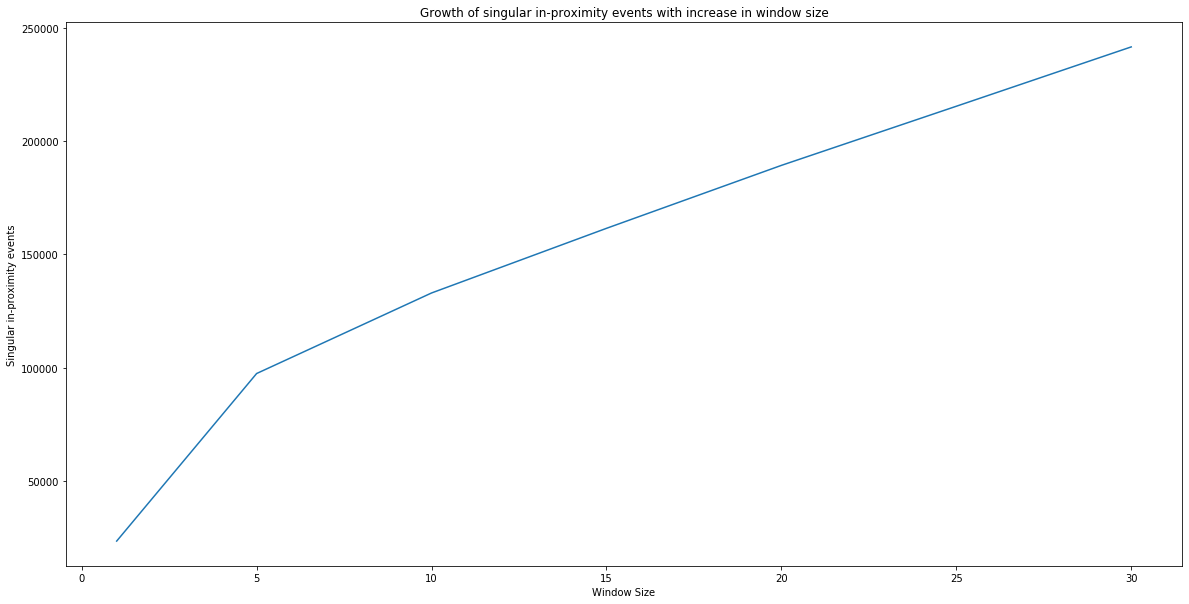

time: 435 ms


In [40]:
plt.figure(figsize=(20,10))
plt.title("Growth of singular in-proximity events with increase in window size")
plt.xlabel("Window Size")
plt.ylabel("Singular in-proximity events")
plt.plot([1,5,10,15,20,25,30],total_singular_list)


The above graph shows a very interesting behavior. We can see a steep increase in number of singular events of proximity until window size of 5 which seems to increase linearly after 10. This is because we find more singular events as our window size increases which leads to the linear growth after 10. These singular events are however many instances of a single continous event of proximity lasting several minutes. Let us try and consider only the number of actual events over several window sizes.

In [3]:
total_actual_list = []
for dt in [1,5,10,15,20,25,30]:
    total_actual = 0
    with open(path_results+'//bt_delta'+str(dt)+'m_gt.json', 'r') as json_file:
        proximity_gt = json.load(json_file)
    for key,value in proximity_gt.items():
        if len(value) >= 2:
            value = pd.to_datetime(pd.Series(value)).sort_values()
            temp = (value.shift(-1) - value).dt.total_seconds() / 60
            total_actual = total_actual + len(temp[temp>dt])
    total_actual_list.append(total_actual)


KeyboardInterrupt: 

time: 11.3 s


Reason for considering a gap greater than dt:
This is because our ground truth algorithm at timestamp t1 looks in the past by dt and future by dt. Looking in the past is not a problem. However when you look in the future and find the same mac at timestamp t2, we add t2 to the list of timestamps when the proximity occurs. This is because when you are scanning through device 2 with window dt, you will see the scan in device 1 at t1 and add t2 to the list of proximity timestamps. Both t1 and t2 belong to the same proximity event.
Hence we consider only those events who have a gap of more than dt.

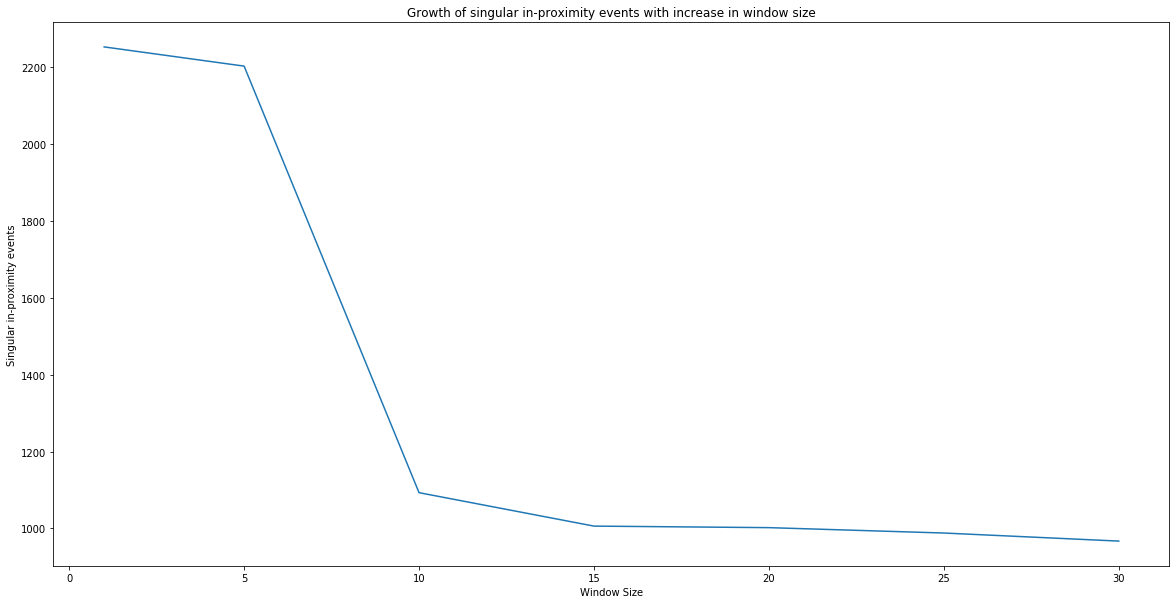

time: 377 ms


In [42]:
plt.figure(figsize=(20,10))
plt.title("Growth of singular in-proximity events with increase in window size")
plt.xlabel("Window Size")
plt.ylabel("Singular in-proximity events")
plt.plot([1,5,10,15,20,25,30],total_actual_list)

As we can see, the number of actual proximity events stay somewhat same for window sizes of more than 15.

#### Verification ####


In [2]:
with open(path_results+'//bt_delta15m_gt.json', 'r') as json_file:
    proximity_gt = json.load(json_file)

time: 4.21 s


In [8]:
data_location = b2s(pd.read_parquet(os.path.join(path_data_collection, "locations.parquet.snappy")))
data_location['device_id'].replace(device_id_mappings, inplace = True)
data_location.head()

_id               timestamp  device_id  double_latitude  double_longitude  \
0    1 2018-04-23 11:16:48.485       23.0        48.262711         11.668508   
1    2 2018-04-25 15:15:56.621       37.0        48.262920         11.668423   
2    3 2018-04-25 15:21:21.537       37.0        48.262930         11.668407   
3    4 2018-04-25 15:26:58.779       37.0        48.262920         11.668424   
4    5 2018-04-25 15:32:06.167       37.0        48.262922         11.668420   

   double_bearing  double_speed  double_altitude provider  accuracy label  
0             0.0           0.0       528.400024  network    19.365   NaN  
1             0.0           0.0       528.299988  network    19.328   NaN  
2             0.0           0.0       528.000000  network    20.793   NaN  
3             0.0           0.0       528.000000  network    19.367   NaN  
4             0.0           0.0       528.299988  network    20.777   NaN

time: 7.98 s


In [13]:
x = data_location[data_location['device_id'] == 37]
y = data_location[data_location['device_id'] == 98]
x = x[['timestamp','double_latitude','double_longitude']]
y = y[['timestamp','double_latitude','double_longitude']]
times = pd.DatetimeIndex(x.timestamp)
grouped_x = x.groupby([times.year,times.month,times.day,times.hour,times.minute]).mean()
times = pd.DatetimeIndex(y.timestamp)
grouped_y = y.groupby([times.year,times.month,times.day,times.hour,times.minute]).mean()

time: 152 ms


In [14]:
joined = grouped_x.join(grouped_y,lsuffix="_x",rsuffix="_y")
joined.dropna(inplace = True)
joined['distance'] = np.sqrt(((joined['double_latitude_y'] - joined['double_latitude_x']) ** 2) + ((joined['double_longitude_y'] - joined['double_longitude_x']) ** 2))
ground_truth_locations = pd.DataFrame()
ts_list = list(joined.index)
ground_truth_locations['timestamp'] = [datetime(*x) for x in ts_list]
ground_truth_locations['distance'] = list(joined['distance'])

time: 71.8 ms


/home/swaraj/TUM/Thesis/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


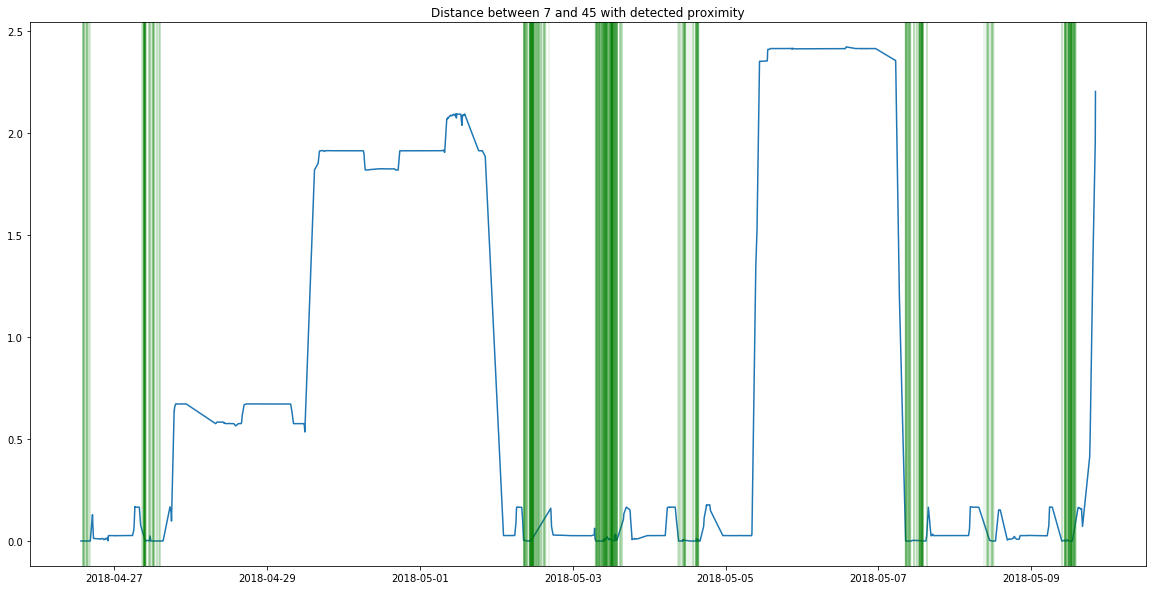

time: 1.68 s


In [15]:
proximity_ts = proximity_gt['37_98']
plt.figure(figsize=(20,10))
plt.title("Distance between 7 and 45 with detected proximity")
plt.plot(ground_truth_locations['timestamp'], ground_truth_locations['distance'])
for ts in proximity_ts:
    plt.axvline(ts, color='green', alpha=0.1)

Building a group where maximum number of proximity events are seen

In [29]:
actual_proximity = {}
full_list_ts = []
for key, value in proximity_gt.items():
    
    val_series = pd.to_datetime(value)
    val_series = val_series.round('min')
    val_series = pd.Series(val_series)
    val_series.sort_values(inplace=True)
    val_series = val_series.unique()
    full_list_ts = full_list_ts + list(val_series)

ts_list, counts = np.unique(full_list_ts, return_counts = True)

time: 2.17 s


In [30]:
df = pd.DataFrame()
df['ts'] = ts_list
df['count'] = counts
df.sort_values('ts', inplace = True)
df.head()

ts  count
0 2018-04-26 11:28:00      1
1 2018-04-26 11:39:00      1
2 2018-04-26 11:43:00      1
3 2018-04-26 11:48:00      1
4 2018-04-26 11:53:00      1

time: 50.5 ms


Considering a 30 min window to see where maximum proximity events are seen among all events

In [31]:
np.argmax(df.rolling(30).sum()['count'].fillna(0))

/u/home/oturkar/venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


1411

time: 40.1 ms


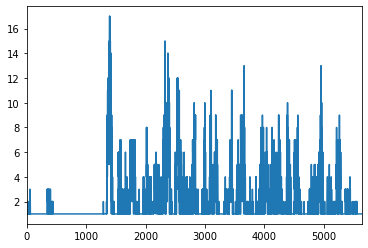

time: 350 ms


In [35]:
df['count'].plot()

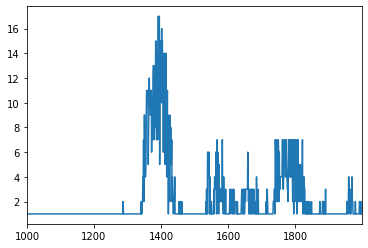

time: 309 ms


In [32]:
df['count'][(1000):(2000)].plot()

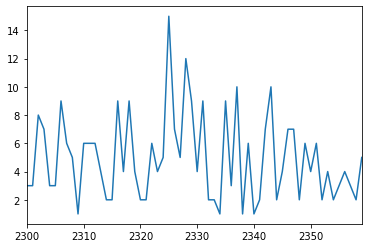

time: 249 ms


In [39]:
df['count'][(2300):(2360)].plot()

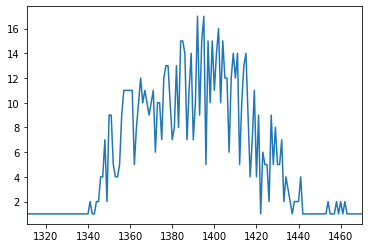

time: 293 ms


In [33]:
df['count'][(1311):(1471)].plot()

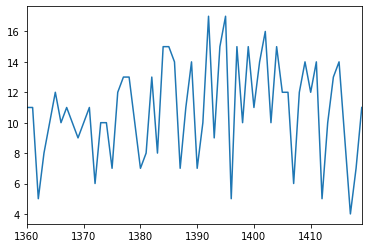

time: 291 ms


In [34]:
df['count'][(1360):(1420)].plot()

Considering 1360 to 1420 (60 mins) for devices in proximity

In [64]:
ts_interest = df[(1360):(1420)]['ts']
ts_min = pd.to_datetime(ts_interest).min()
ts_max = pd.to_datetime(ts_interest).max()

devices_interest  = []
for key, value in proximity_gt.items():
    
    val_series = pd.to_datetime(value)
    val_series = val_series.round('min')
    val_series = pd.Series(val_series)
    val_series.sort_values(inplace=True)
    val_series = pd.to_datetime(val_series.unique())
    
    if ((len(set(val_series).intersection(set(ts_interest)))) > 20):
        devices_interest.append(key)


time: 2.62 s


In [40]:
ts_interest = df[(2300):(2360)]['ts']
ts_min = pd.to_datetime(ts_interest).min()
ts_max = pd.to_datetime(ts_interest).max()

devices_interest  = []
for key, value in proximity_gt.items():
    
    val_series = pd.to_datetime(value)
    val_series = val_series.round('min')
    val_series = pd.Series(val_series)
    val_series.sort_values(inplace=True)
    val_series = pd.to_datetime(val_series.unique())
    
    if ((len(set(val_series).intersection(set(ts_interest)))) > 20):
        devices_interest.append(key)


time: 2.74 s


In [44]:
devices_interest

['96_57', '96_14', '96_66', '57_14', '57_66', '14_66']

time: 4.58 ms


In [144]:
ts_min_not_prox = pd.to_datetime("2018-05-17 21:00:00")
ts_max_not_prox = pd.to_datetime("2018-05-17 22:00:00")
ts_interest_notprox = pd.date_range(ts_min_not_prox,ts_max_not_prox,freq="min")


time: 3.26 ms


In [145]:
ts_interest_notprox

DatetimeIndex(['2018-05-15 21:00:00', '2018-05-15 21:01:00',
               '2018-05-15 21:02:00', '2018-05-15 21:03:00',
               '2018-05-15 21:04:00', '2018-05-15 21:05:00',
               '2018-05-15 21:06:00', '2018-05-15 21:07:00',
               '2018-05-15 21:08:00', '2018-05-15 21:09:00',
               '2018-05-15 21:10:00', '2018-05-15 21:11:00',
               '2018-05-15 21:12:00', '2018-05-15 21:13:00',
               '2018-05-15 21:14:00', '2018-05-15 21:15:00',
               '2018-05-15 21:16:00', '2018-05-15 21:17:00',
               '2018-05-15 21:18:00', '2018-05-15 21:19:00',
               '2018-05-15 21:20:00', '2018-05-15 21:21:00',
               '2018-05-15 21:22:00', '2018-05-15 21:23:00',
               '2018-05-15 21:24:00', '2018-05-15 21:25:00',
               '2018-05-15 21:26:00', '2018-05-15 21:27:00',
               '2018-05-15 21:28:00', '2018-05-15 21:29:00',
               '2018-05-15 21:30:00', '2018-05-15 21:31:00',
               '2018-05-

time: 6.75 ms


Some filtering and group forming to find which devices were in a group 

In [49]:
devices_inproximity = [96]
for devices in devices_interest:
    dev1 = int(devices.split('_')[0])
    dev2 = int(devices.split('_')[1])
    
    if (dev1 in devices_inproximity) or (dev2 in devices_inproximity):
        devices_inproximity.append(dev1)
        devices_inproximity.append(dev2)
devices_inproximity = np.unique(devices_inproximity)

time: 2.66 ms


In [50]:
devices_inproximity

array([14, 57, 66, 96])

time: 5.97 ms


In [7]:
data_mag.to_parquet("/data/magnetometer_mapped.parquet.snappy")

time: 1min 53s


In [2]:
data_mag = pd.read_parquet("/data/magnetometer_mapped.parquet.snappy")


time: 36.1 s


In [11]:
data_acc = pd.read_parquet("/data/accelerometer_mapped.parquet.snappy")

_id               timestamp  device_id  double_values_0  \
0                 1 2018-04-23 11:06:43.047         23       -17.700001   
1                 2 2018-04-23 11:06:43.201         23       -19.350000   
2                 3 2018-04-23 11:06:43.402         23       -18.900002   
3                 4 2018-04-23 11:06:43.562         23       -18.600000   
4                 5 2018-04-23 11:06:43.720         23       -18.450001   
...             ...                     ...        ...              ...   
324101937  85835957 2018-08-15 01:00:00.382         83        93.267380   
324101938  85835958 2018-08-15 01:05:00.378         83        93.041977   
324101939  85835959 2018-08-15 01:10:00.381         83        93.495377   
324101940  85835960 2018-08-15 01:15:00.366         83        93.721039   
324101941  85835961 2018-08-15 01:20:00.372         83        93.494812   

           double_values_1  double_values_2  accuracy  label  
0               -88.200005       -31.350000         0    NaN  
1               -88.350006       -31.950001         0    NaN  
2               -88.350006       -31.200001         0    NaN  
3               -88.050003       -36.000000         0    NaN  
4               -88.500000       -36.150002         0    NaN  
...                    ...              ...       ...    ...  
324101937       252.997192      -733.805054         3    NaN  
324101938       252.923447      -734.257385         3    NaN  
324101939       253.296616      -734.703186         3    NaN  
324101940       253.370636      -734.775818         3    NaN  
324101941       253.221710      -734.852966         3    NaN  

[324101751 rows x 8 columns]

time: 91 ms


In [6]:
data_mag = b2s(pd.read_parquet(os.path.join(path_data_collection, "magnetometer.parquet.snappy")))
data_mag = data_mag[pd.notnull(data_mag.device_id)]
data_mag['device_id'].replace(device_id_mappings, inplace = True)

time: 33min 30s


In [492]:
data_acc = pd.read_parquet("/data/accelerometer.parquet.snappy")#accelerometer_sliced.gzip also possible

time: 10min 1s


In [502]:
data_acc = data_acc[data_acc.device_id.notnull()]

time: 11min


In [494]:
data_acc['device_id'].replace(device_id_mappings, inplace = True)

time: 45min 38s


In [531]:
data_acc.to_parquet("/data/accelerometer_mapped.parquet.snappy")

time: 9min 40s


In [504]:
data_acc["device_id"] = data_acc.device_id.astype(int)

time: 23.5 s


In [530]:
data_acc.head()

_id               timestamp  device_id  double_values_0  \
0  92018860 2018-05-14 19:48:42.920         99         0.047884   
1  92018861 2018-05-14 19:48:43.121         99         0.004788   
2  92018862 2018-05-14 19:48:43.321         99         0.000000   
3  92018863 2018-05-14 19:48:43.522         99         0.009577   
4  92018864 2018-05-14 19:48:43.722         99        -0.038307   

   double_values_1  double_values_2  accuracy  label  
0         0.225055         9.840169         3    NaN  
1         0.201113         9.825804         3    NaN  
2         0.201113         9.830592         3    NaN  
3         0.167594         9.844957         3    NaN  
4         0.186748         9.859323         3    NaN

time: 105 ms


### Accelerometer Analysis for devices in proximity and devices not in proximity ###

In [60]:
acc_meta = b2s(pd.read_parquet(os.path.join(path_data_collection, "sensor_accelerometer.parquet.snappy")))
acc_meta['device_id'].replace(device_id_mappings, inplace = True)


time: 49.5 ms


In [61]:
v,c = np.unique(acc_meta['sensor_vendor'], return_counts = True)
c_sort_i = np.argsort(c)
v = v[c_sort_i]
c = c[c_sort_i]
top_sensor_vender = v[::-1]

time: 2.27 ms


time: 1.27 ms


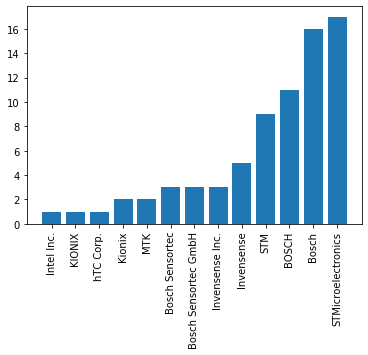

time: 319 ms


In [63]:
plt.bar(v,c)
x = plt.xticks(rotation='90')

In [64]:
top_sensor_vender = v[::-1]

time: 1.04 ms


In [65]:
top_sensor_vender

array(['STMicroelectronics', 'Bosch', 'BOSCH', 'STM', 'Invensense',
       'Invensense Inc.', 'Bosch Sensortec GmbH', 'Bosch Sensortec',
       'MTK', 'Kionix', 'hTC Corp.', 'KIONIX', 'Intel Inc.'], dtype=object)

time: 6.79 ms


In [66]:
v,c = np.unique(acc_meta['sensor_name'], return_counts = True)
c_sort_i = np.argsort(c)
v = v[c_sort_i]
c = c[c_sort_i]


time: 2.81 ms


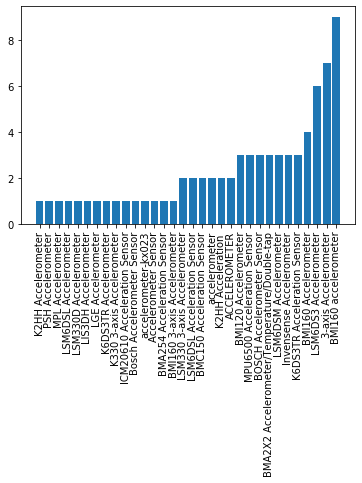

time: 534 ms


In [67]:
plt.bar(v,c)
x = plt.xticks(rotation='90')

In [69]:
top_acc_meta_devices = acc_meta[acc_meta['sensor_name'] == v[-1]]
top_acc_meta_devices_2 = acc_meta[acc_meta['sensor_name'] == v[-2]]

time: 6.81 ms


In [131]:
same_sensor_combs = list(combinations(list(top_acc_meta_devices['device_id']),2))


time: 1.32 ms


In [136]:
same_sensor_comb = [str(x[0])+'_'+str(x[1]) for x in list(same_sensor_combs)]


time: 1.43 ms


In [137]:
same_sensor_comb_2 = [str(x[1])+'_'+str(x[0]) for x in list(same_sensor_combs)]

time: 1.5 ms


In [142]:
proximity_gt_top = {}
for key, value in proximity_gt.items():
    if (key in same_sensor_comb) or (key in same_sensor_comb_2):
        proximity_gt_top[key] = value

time: 5.37 ms


In [144]:
actual_proximity = {}
full_list_ts = []
for key, value in proximity_gt_top.items():
    
    val_series = pd.to_datetime(value)
    val_series = val_series.round('min')
    val_series = pd.Series(val_series)
    val_series.sort_values(inplace=True)
    val_series = val_series.unique()
    full_list_ts = full_list_ts + list(val_series)

ts_list, counts = np.unique(full_list_ts, return_counts = True)

time: 67.9 ms


In [145]:
df = pd.DataFrame()
df['ts'] = ts_list
df['count'] = counts
df.sort_values('ts', inplace = True)
df.head()

ts  count
0 2018-04-26 11:28:00      1
1 2018-04-26 11:39:00      1
2 2018-04-26 11:43:00      1
3 2018-04-26 11:48:00      1
4 2018-04-26 11:53:00      1

time: 21.1 ms


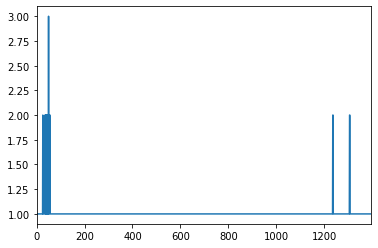

time: 290 ms


In [147]:
df['count'].plot()

In [58]:
top_sensor_vender

NameError: name 'top_sensor_vender' is not defined

time: 12.4 ms


In [206]:
top_vender_df = acc_meta[acc_meta['sensor_vendor'] == top_sensor_vender[1]]

time: 5.51 ms


In [207]:
same_sensor_combs = list(combinations(list(top_vender_df['device_id']),2))
same_sensor_comb = [str(x[0])+'_'+str(x[1]) for x in list(same_sensor_combs)]
same_sensor_comb_2 = [str(x[1])+'_'+str(x[0]) for x in list(same_sensor_combs)]
proximity_gt_vendor = {}
for key, value in proximity_gt.items():
    if (key in same_sensor_comb) or (key in same_sensor_comb_2):
        proximity_gt_vendor[key] = value


time: 11.6 ms


In [208]:
proximity_gt_vendor

{'37_23': ['2018-04-26 11:28:02.059000',
  '2018-04-26 11:38:54.290000',
  '2018-04-26 11:43:23.888000',
  '2018-04-26 11:48:20.520000',
  '2018-04-26 11:53:09.216000',
  '2018-04-26 11:58:49.137000',
  '2018-04-26 12:17:28.998000',
  '2018-04-26 12:34:18.626000',
  '2018-04-26 12:37:09.249000',
  '2018-04-26 12:42:20.648000',
  '2018-04-26 12:44:23.384000',
  '2018-04-26 12:46:49.487000',
  '2018-04-26 12:52:20.795000',
  '2018-04-26 12:57:08.876000',
  '2018-04-26 13:01:47.110000',
  '2018-04-26 13:06:52.630000',
  '2018-04-26 13:12:08.557000',
  '2018-04-26 13:16:46.852000',
  '2018-04-26 13:22:07.050000',
  '2018-04-26 13:27:18.889000',
  '2018-04-26 13:32:07.383000',
  '2018-04-26 13:37:07.673000',
  '2018-04-26 13:42:06.667000',
  '2018-04-26 13:46:34.680000',
  '2018-04-26 13:51:12.004000',
  '2018-04-26 13:56:34.920000',
  '2018-04-26 14:00:50.794000',
  '2018-04-26 14:06:47.830000',
  '2018-04-26 14:11:10.747000',
  '2018-04-26 14:15:49.849000',
  '2018-04-26 14:21:35.663000',

time: 66.7 ms


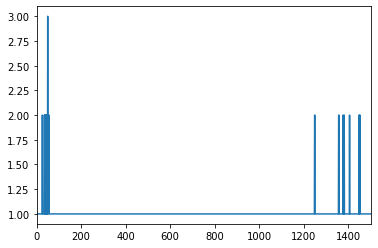

time: 332 ms


In [209]:
full_list_ts = []
for key, value in proximity_gt_vendor.items():
    
    val_series = pd.to_datetime(value)
    val_series = val_series.round('min')
    val_series = pd.Series(val_series)
    val_series.sort_values(inplace=True)
    val_series = val_series.unique()
    full_list_ts = full_list_ts + list(val_series)

ts_list, counts = np.unique(full_list_ts, return_counts = True)
df = pd.DataFrame()
df['ts'] = ts_list
df['count'] = counts
df.sort_values('ts', inplace = True)
df.head()
df['count'].plot()

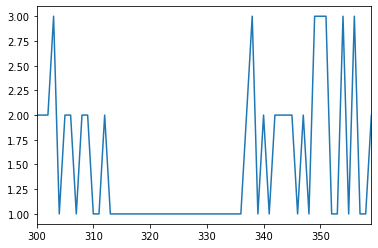

time: 278 ms


In [197]:
df[300:360]['count'].plot()

In [95]:
inproximity_sensor_df_0 = aggregate_signals(data_acc, ['double_values_0'], '1s', ts_interest, devices_inproximity, "final_acc_prox_0.gzip")
inproximity_sensor_df_1 = aggregate_signals(data_acc, ['double_values_1'], '1s', ts_interest, devices_inproximity, "final_acc_prox_1.gzip")
inproximity_sensor_df_2 = aggregate_signals(data_acc, ['double_values_2'], '1s', ts_interest, devices_inproximity, "final_acc_prox_2.gzip")

time: 3.05 s


In [14]:
inproximity_sensor_df_0 = pd.read_parquet(os.path.join(path_results, "final_acc_prox_0.gzip"))
inproximity_sensor_df_1 = pd.read_parquet(os.path.join(path_results, "final_acc_prox_1.gzip"))
inproximity_sensor_df_2 = pd.read_parquet(os.path.join(path_results, "final_acc_prox_2.gzip"))

time: 116 ms


In [16]:
inproximity_sensor_df_0.columns



Index(['dev22', 'dev41', 'dev48', 'dev57', 'dev99', 'dev104'], dtype='object')

time: 5.44 ms


In [22]:
acc = [int(x[3:]) for x in inproximity_sensor_df_0.columns]

time: 1.44 ms


In [55]:
acc_meta

_id               timestamp  device_id  double_sensor_maximum_range  \
12   16 2018-05-13 16:22:50.068         96                    39.226593   
19   23 2018-05-13 21:50:26.689         57                    39.226601   
45   55 2018-05-16 13:14:56.120         14                    32.000000   
54   73 2018-05-20 17:08:19.980         66                    19.613300   

    double_sensor_minimum_delay                                  sensor_name  \
12                         5000  BMA2X2 Accelerometer/Temperature/Double-tap   
19                        10000                           K2HH Acceleration    
45                        10000                                ACCELEROMETER   
54                         5000                  MPU6500 Acceleration Sensor   

    double_sensor_power_ma  double_sensor_resolution  sensor_type  \
12                    0.13                  0.019150            1   
19                    0.13                  0.001197            1   
45                    0.13                  0.003906            1   
54                    0.25                  0.000599            1   

   sensor_vendor  sensor_version  
12         BOSCH               1  
19           STM               1  
45           MTK               3  
54    Invensense               1

time: 23.8 ms


               comb    cosine
0    (dev22, dev41)  1.185267
1    (dev22, dev48)  0.861393
2    (dev22, dev57)  0.593122
3    (dev22, dev99)  1.212511
4   (dev22, dev104)  0.865448
5    (dev41, dev48)  1.143740
6    (dev41, dev57)  1.524837
7    (dev41, dev99)  0.546957
8   (dev41, dev104)  1.259420
9    (dev48, dev57)  0.564297
10   (dev48, dev99)  1.046214
11  (dev48, dev104)  1.029197
12   (dev57, dev99)  1.511787
13  (dev57, dev104)  0.656415
14  (dev99, dev104)  1.396568
-----------------------------------------------
               comb    cosine
0    (dev22, dev41)  0.256639
1    (dev22, dev48)  0.096893
2    (dev22, dev57)  0.281336
3    (dev22, dev99)  0.015913
4   (dev22, dev104)  0.052043
5    (dev41, dev48)  0.290139
6    (dev41, dev57)  0.553212
7    (dev41, dev99)  0.238039
8   (dev41, dev104)  0.297941
9    (dev48, dev57)  0.309088
10   (dev48, dev99)  0.080080
11  (dev48, dev104)  0.149472
12   (dev57, dev99)  0.265943
13  (dev57, dev104)  0.372686
14  (dev99, dev104)  0

dev22     dev41     dev48     dev57     dev99    dev104
dev22   1.000000  0.028191 -0.140021  0.004884  0.015632 -0.031542
dev41   0.028191  1.000000  0.010711 -0.208826 -0.105280  0.029402
dev48  -0.140021  0.010711  1.000000  0.063377 -0.000139 -0.168823
dev57   0.004884 -0.208826  0.063377  1.000000  0.108692 -0.338063
dev99   0.015632 -0.105280 -0.000139  0.108692  1.000000 -0.142862
dev104 -0.031542  0.029402 -0.168823 -0.338063 -0.142862  1.000000

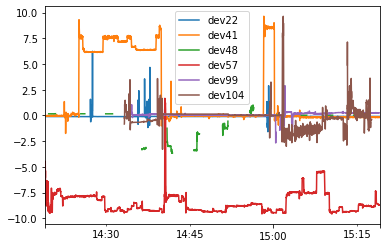

time: 23.1 s


In [169]:
inproximity_sensor_df_0.plot()
print(cosine_dist(inproximity_sensor_df_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(inproximity_sensor_df_0))
print("-----------------------------------------------")
print(fast_dtw(inproximity_sensor_df_0))
print("-----------------------------------------------")
inproximity_sensor_df_0.corr()

               comb    cosine
0    (dev22, dev41)  1.184540
1    (dev22, dev48)  0.836969
2    (dev22, dev57)  1.138358
3    (dev22, dev99)  0.919295
4   (dev22, dev104)  0.954191
5    (dev41, dev48)  0.889254
6    (dev41, dev57)  0.728636
7    (dev41, dev99)  1.145062
8   (dev41, dev104)  1.122360
9    (dev48, dev57)  0.911646
10   (dev48, dev99)  0.904419
11  (dev48, dev104)  0.956551
12   (dev57, dev99)  1.092639
13  (dev57, dev104)  1.266432
14  (dev99, dev104)  0.374298
-----------------------------------------------
               comb    cosine
0    (dev22, dev41)  0.859679
1    (dev22, dev48)  0.758735
2    (dev22, dev57)  0.769035
3    (dev22, dev99)  0.870260
4   (dev22, dev104)  0.757984
5    (dev41, dev48)  0.400892
6    (dev41, dev57)  0.124854
7    (dev41, dev99)  0.526103
8   (dev41, dev104)  0.254718
9    (dev48, dev57)  0.367867
10   (dev48, dev99)  0.723861
11  (dev48, dev104)  0.443281
12   (dev57, dev99)  0.414971
13  (dev57, dev104)  0.148511
14  (dev99, dev104)  0

dev22     dev41     dev48     dev57     dev99    dev104
dev22   1.000000 -0.183458 -0.005071 -0.152531  0.007678  0.061872
dev41  -0.183458  1.000000  0.010624  0.274061 -0.164119 -0.092441
dev48  -0.005071  0.010624  1.000000  0.293685 -0.121591  0.094127
dev57  -0.152531  0.274061  0.293685  1.000000 -0.113902 -0.341935
dev99   0.007678 -0.164119 -0.121591 -0.113902  1.000000 -0.115677
dev104  0.061872 -0.092441  0.094127 -0.341935 -0.115677  1.000000

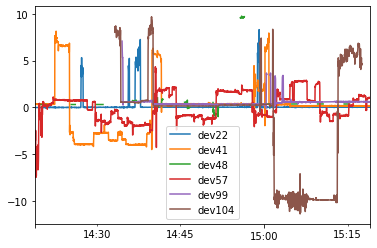

time: 27 s


In [170]:
inproximity_sensor_df_1.plot()
print(cosine_dist(inproximity_sensor_df_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(inproximity_sensor_df_1))
print("-----------------------------------------------")
print(fast_dtw(inproximity_sensor_df_1))
print("-----------------------------------------------")
inproximity_sensor_df_1.corr()

               comb    cosine
0    (dev22, dev41)  0.399067
1    (dev22, dev48)  0.025196
2    (dev22, dev57)  0.312835
3    (dev22, dev99)  0.010412
4   (dev22, dev104)  0.153862
5    (dev41, dev48)  0.406931
6    (dev41, dev57)  0.532850
7    (dev41, dev99)  0.358695
8   (dev41, dev104)  0.533943
9    (dev48, dev57)  0.307429
10   (dev48, dev99)  0.041615
11  (dev48, dev104)  0.207897
12   (dev57, dev99)  0.345775
13  (dev57, dev104)  0.574732
14  (dev99, dev104)  0.145342
-----------------------------------------------
               comb    cosine
0    (dev22, dev41)  0.130881
1    (dev22, dev48)  0.036078
2    (dev22, dev57)  0.040284
3    (dev22, dev99)  0.143460
4   (dev22, dev104)  0.031992
5    (dev41, dev48)  0.157978
6    (dev41, dev57)  0.157501
7    (dev41, dev99)  0.138607
8   (dev41, dev104)  0.172700
9    (dev48, dev57)  0.063602
10   (dev48, dev99)  0.200889
11  (dev48, dev104)  0.082281
12   (dev57, dev99)  0.209607
13  (dev57, dev104)  0.095892
14  (dev99, dev104)  0

dev22     dev41     dev48     dev57     dev99    dev104
dev22   1.000000  0.251746 -0.047683  0.138497 -0.011448 -0.110700
dev41   0.251746  1.000000 -0.147592  0.101130  0.076114 -0.241157
dev48  -0.047683 -0.147592  1.000000 -0.131971 -0.065226 -0.241534
dev57   0.138497  0.101130 -0.131971  1.000000 -0.022938 -0.423133
dev99  -0.011448  0.076114 -0.065226 -0.022938  1.000000  0.055036
dev104 -0.110700 -0.241157 -0.241534 -0.423133  0.055036  1.000000

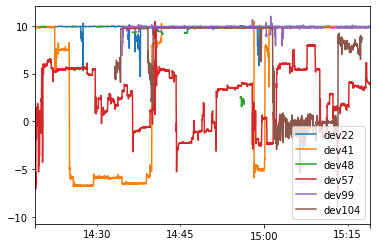

time: 33.8 s


In [171]:
inproximity_sensor_df_2.plot()
print(cosine_dist(inproximity_sensor_df_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(inproximity_sensor_df_2))
print("-----------------------------------------------")
print(fast_dtw(inproximity_sensor_df_2))
print("-----------------------------------------------")
inproximity_sensor_df_2.corr()

In [153]:
notinproximity_sensor_df_0 = aggregate_signals(data_acc_sliced, ['double_values_0'], '1s', ts_interest_notprox, devices_inproximity, "final_acc_not_prox_0.gzip")
notinproximity_sensor_df_1 = aggregate_signals(data_acc_sliced, ['double_values_1'], '1s', ts_interest_notprox, devices_inproximity, "final_acc_not_prox_1.gzip")
notinproximity_sensor_df_2 = aggregate_signals(data_acc_sliced, ['double_values_2'], '1s', ts_interest_notprox, devices_inproximity, "final_acc_not_prox_2.gzip")

time: 28.3 s


             comb    cosine
0  (dev41, dev48)  0.825973
1  (dev41, dev57)  1.066193
2  (dev41, dev99)  0.699193
3  (dev48, dev57)  0.997591
4  (dev48, dev99)  1.007010
5  (dev57, dev99)  1.027204
-----------------------------------------------
             comb    cosine
0  (dev41, dev48)  0.060798
1  (dev41, dev57)  0.124184
2  (dev41, dev99)  0.013175
3  (dev48, dev57)  0.151437
4  (dev48, dev99)  0.060257
5  (dev57, dev99)  0.114502
-----------------------------------------------
             comb      distance
0  (dev41, dev48)   4171.025921
1  (dev41, dev57)  12542.027460
2  (dev41, dev99)   4361.848759
3  (dev48, dev57)  10407.139977
4  (dev48, dev99)   2357.472123
5  (dev57, dev99)  10135.877687
-----------------------------------------------


dev41     dev48     dev57     dev99
dev41  1.000000  0.104528 -0.059539  0.443469
dev48  0.104528  1.000000  0.005289 -0.019353
dev57 -0.059539  0.005289  1.000000 -0.024171
dev99  0.443469 -0.019353 -0.024171  1.000000

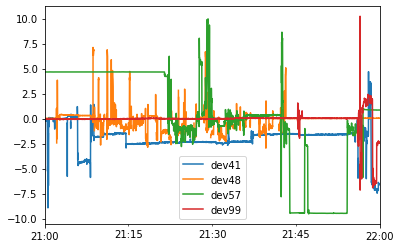

time: 9.64 s


In [172]:
notinproximity_sensor_df_0.plot()
print(cosine_dist(notinproximity_sensor_df_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(notinproximity_sensor_df_0))
print("-----------------------------------------------")
print(fast_dtw(notinproximity_sensor_df_0))
print("-----------------------------------------------")
notinproximity_sensor_df_0.corr()

             comb    cosine
0  (dev41, dev48)  1.107572
1  (dev41, dev57)  1.238909
2  (dev41, dev99)  0.364382
3  (dev48, dev57)  1.041964
4  (dev48, dev99)  0.882205
5  (dev57, dev99)  0.939553
-----------------------------------------------
             comb    cosine
0  (dev41, dev48)  0.608224
1  (dev41, dev57)  0.540953
2  (dev41, dev99)  0.223760
3  (dev48, dev57)  0.496550
4  (dev48, dev99)  0.385545
5  (dev57, dev99)  0.194973
-----------------------------------------------
             comb      distance
0  (dev41, dev48)  11805.390826
1  (dev41, dev57)  24141.339597
2  (dev41, dev99)   5926.989191
3  (dev48, dev57)  18590.606726
4  (dev48, dev99)   9608.110413
5  (dev57, dev99)  20699.173759
-----------------------------------------------


dev41     dev48     dev57     dev99
dev41  1.000000 -0.101027 -0.235086  0.694979
dev48 -0.101027  1.000000 -0.080299 -0.175965
dev57 -0.235086 -0.080299  1.000000  0.057459
dev99  0.694979 -0.175965  0.057459  1.000000

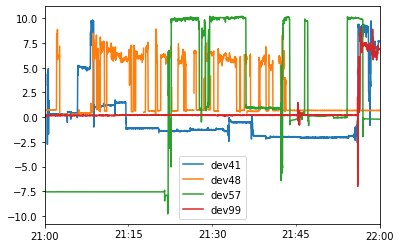

time: 9.22 s


In [174]:
notinproximity_sensor_df_1.plot()
print(cosine_dist(notinproximity_sensor_df_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(notinproximity_sensor_df_1))
print("-----------------------------------------------")
print(fast_dtw(notinproximity_sensor_df_1))
print("-----------------------------------------------")
notinproximity_sensor_df_1.corr()

             comb    cosine
0  (dev41, dev48)  0.065758
1  (dev41, dev57)  1.007804
2  (dev41, dev99)  0.027229
3  (dev48, dev57)  0.888116
4  (dev48, dev99)  0.020559
5  (dev57, dev99)  0.953844
-----------------------------------------------
             comb    cosine
0  (dev41, dev48)  0.023070
1  (dev41, dev57)  0.129290
2  (dev41, dev99)  0.006538
3  (dev48, dev57)  0.090039
4  (dev48, dev99)  0.015437
5  (dev57, dev99)  0.121517
-----------------------------------------------
             comb      distance
0  (dev41, dev48)   5480.190235
1  (dev41, dev57)  16558.226019
2  (dev41, dev99)   2747.313506
3  (dev48, dev57)  25673.379295
4  (dev48, dev99)   3994.515602
5  (dev57, dev99)  28430.984133
-----------------------------------------------


dev41     dev48     dev57     dev99
dev41  1.000000 -0.154402 -0.306501  0.765523
dev48 -0.154402  1.000000  0.156455 -0.147814
dev57 -0.306501  0.156455  1.000000 -0.380960
dev99  0.765523 -0.147814 -0.380960  1.000000

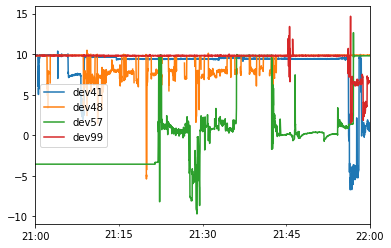

time: 10.4 s


In [173]:
notinproximity_sensor_df_2.plot()
print(cosine_dist(notinproximity_sensor_df_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(notinproximity_sensor_df_2))
print("-----------------------------------------------")
print(fast_dtw(notinproximity_sensor_df_2))
print("-----------------------------------------------")
notinproximity_sensor_df_2.corr()

Distribution of Cosine distance between NORMALIZED Sensors for In-Proximity and Not-In-Proximity

(array([6., 4., 2., 2., 0., 0., 1., 0., 2., 1.]),
 array([0.00653829, 0.06670682, 0.12687535, 0.18704387, 0.2472124 ,
        0.30738093, 0.36754946, 0.42771799, 0.48788652, 0.54805505,
        0.60822357]),
 <a list of 10 Patch objects>)

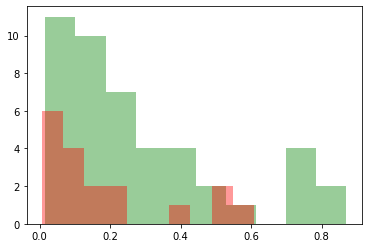

time: 366 ms


In [180]:
all_in_proximity = list(cosine_dist_normalized(inproximity_sensor_df_0)['cosine']) + list(cosine_dist_normalized(inproximity_sensor_df_1)['cosine']) + list(cosine_dist_normalized(inproximity_sensor_df_2)['cosine'])
all_not_in_proximity = list(cosine_dist_normalized(notinproximity_sensor_df_0)['cosine']) + list(cosine_dist_normalized(notinproximity_sensor_df_1)['cosine']) + list(cosine_dist_normalized(notinproximity_sensor_df_2)['cosine'])

plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)


Distribution of DTW distance between Sensors for In-Proximity and Not-In-Proximity

(array([5., 2., 2., 3., 0., 1., 1., 1., 2., 1.]),
 array([ 2357.47212284,  4964.82332383,  7572.17452482, 10179.52572581,
        12786.8769268 , 15394.22812779, 18001.57932878, 20608.93052977,
        23216.28173076, 25823.63293175, 28430.98413274]),
 <a list of 10 Patch objects>)

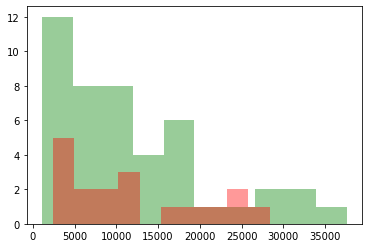

time: 1min 32s


In [182]:
all_in_proximity = list(fast_dtw(inproximity_sensor_df_0)['distance']) + list(fast_dtw(inproximity_sensor_df_1)['distance']) + list(fast_dtw(inproximity_sensor_df_2)['distance'])
all_not_in_proximity = list(fast_dtw(notinproximity_sensor_df_0)['distance']) + list(fast_dtw(notinproximity_sensor_df_1)['distance']) + list(fast_dtw(notinproximity_sensor_df_2)['distance'])

plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)


### Magnetometer Analysis for devices in proximity and devices not in proximity ###

In [258]:
inproximity_sensor_df_0 = aggregate_signals(data_mag, ['double_values_0'], '1min', ts_interest, devices_inproximity, "final_mag_prox_0.gzip")
inproximity_sensor_df_1 = aggregate_signals(data_mag, ['double_values_1'], '1min', ts_interest, devices_inproximity, "final_mag_prox_1.gzip")
inproximity_sensor_df_2 = aggregate_signals(data_mag, ['double_values_2'], '1min', ts_interest, devices_inproximity, "final_mag_prox_2.gzip")

time: 14.9 s


               comb    cosine
0    (dev22, dev41)  0.862657
1   (dev22, dev104)  1.036564
2   (dev22, dev115)  0.265102
3   (dev41, dev104)  0.976094
4   (dev41, dev115)  0.779953
5  (dev104, dev115)  1.244070
-----------------------------------------------
               comb    cosine
0    (dev22, dev41)  0.165491
1   (dev22, dev104)  0.126449
2   (dev22, dev115)  0.274618
3   (dev41, dev104)  0.184237
4   (dev41, dev115)  0.381091
5  (dev104, dev115)  0.504723
-----------------------------------------------
               comb     distance
0    (dev22, dev41)   996.469401
1   (dev22, dev104)  1710.082480
2   (dev22, dev115)   471.150266
3   (dev41, dev104)  2221.818542
4   (dev41, dev115)  1048.237325
5  (dev104, dev115)  1605.897298
-----------------------------------------------


dev22     dev41    dev104    dev115
dev22   1.000000 -0.122703  0.102106  0.060645
dev41  -0.122703  1.000000  0.079457 -0.098820
dev104  0.102106  0.079457  1.000000 -0.393249
dev115  0.060645 -0.098820 -0.393249  1.000000

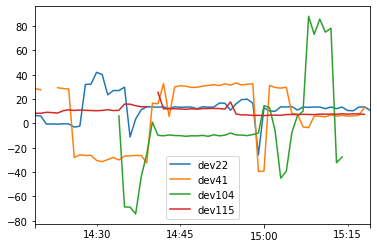

time: 855 ms


In [204]:
inproximity_sensor_df_0.plot()
print(cosine_dist(inproximity_sensor_df_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(inproximity_sensor_df_0))
print("-----------------------------------------------")
print(fast_dtw(inproximity_sensor_df_0))
print("-----------------------------------------------")
inproximity_sensor_df_0.corr()

               comb    cosine
0    (dev22, dev41)  1.075719
1   (dev22, dev104)  1.142898
2   (dev22, dev115)  0.893915
3   (dev41, dev104)  0.377065
4   (dev41, dev115)  0.760727
5  (dev104, dev115)  0.777959
-----------------------------------------------
               comb    cosine
0    (dev22, dev41)  0.200165
1   (dev22, dev104)  0.356460
2   (dev22, dev115)  0.084084
3   (dev41, dev104)  0.130281
4   (dev41, dev115)  0.088088
5  (dev104, dev115)  0.184415
-----------------------------------------------
               comb     distance
0    (dev22, dev41)  1355.018549
1   (dev22, dev104)  1418.895424
2   (dev22, dev115)   999.969289
3   (dev41, dev104)  1100.716400
4   (dev41, dev115)  1035.671773
5  (dev104, dev115)  1287.176971
-----------------------------------------------


dev22     dev41    dev104    dev115
dev22   1.000000 -0.367057 -0.530845 -0.037830
dev41  -0.367057  1.000000  0.492411  0.088133
dev104 -0.530845  0.492411  1.000000  0.101546
dev115 -0.037830  0.088133  0.101546  1.000000

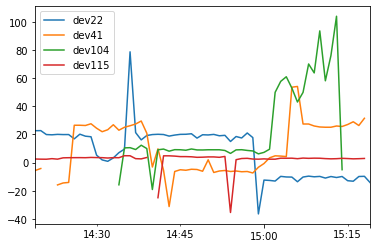

time: 748 ms


In [205]:
inproximity_sensor_df_1.plot()
print(cosine_dist(inproximity_sensor_df_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(inproximity_sensor_df_1))
print("-----------------------------------------------")
print(fast_dtw(inproximity_sensor_df_1))
print("-----------------------------------------------")
inproximity_sensor_df_1.corr()

               comb    cosine
0    (dev22, dev41)  0.270149
1   (dev22, dev104)  0.630707
2   (dev22, dev115)  0.167331
3   (dev41, dev104)  0.544266
4   (dev41, dev115)  0.255008
5  (dev104, dev115)  0.311706
-----------------------------------------------
               comb    cosine
0    (dev22, dev41)  0.195675
1   (dev22, dev104)  0.433111
2   (dev22, dev115)  0.423763
3   (dev41, dev104)  0.323458
4   (dev41, dev115)  0.579178
5  (dev104, dev115)  0.634486
-----------------------------------------------
               comb     distance
0    (dev22, dev41)  1528.091074
1   (dev22, dev104)  1616.273767
2   (dev22, dev115)   966.679826
3   (dev41, dev104)  1515.303802
4   (dev41, dev115)  1161.989705
5  (dev104, dev115)  1344.312978
-----------------------------------------------


dev22     dev41    dev104    dev115
dev22   1.000000  0.298843 -0.639568  0.307030
dev41   0.298843  1.000000 -0.489676 -0.002702
dev104 -0.639568 -0.489676  1.000000 -0.355400
dev115  0.307030 -0.002702 -0.355400  1.000000

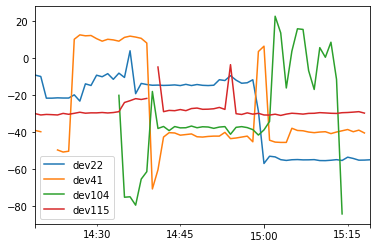

time: 578 ms


In [206]:
inproximity_sensor_df_2.plot()
print(cosine_dist(inproximity_sensor_df_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(inproximity_sensor_df_2))
print("-----------------------------------------------")
print(fast_dtw(inproximity_sensor_df_2))
print("-----------------------------------------------")
inproximity_sensor_df_2.corr()

In [270]:
notinproximity_sensor_df_0 = aggregate_signals(data_mag, ['double_values_0'], '1min', ts_interest_notprox, devices_inproximity, "final_mag_not_prox_0.gzip")
notinproximity_sensor_df_1 = aggregate_signals(data_mag, ['double_values_1'], '1min', ts_interest_notprox, devices_inproximity, "final_mag_not_prox_1.gzip")
notinproximity_sensor_df_2 = aggregate_signals(data_mag, ['double_values_2'], '1min', ts_interest_notprox, devices_inproximity, "final_mag_not_prox_2.gzip")

time: 1min 34s


              comb    cosine
0   (dev22, dev41)  0.645790
1   (dev22, dev48)  1.531127
2  (dev22, dev104)  0.849623
3   (dev41, dev48)  1.768153
4  (dev41, dev104)  0.324922
5  (dev48, dev104)  1.691976
-----------------------------------------------
              comb    cosine
0   (dev22, dev41)  0.407141
1   (dev22, dev48)  0.253630
2  (dev22, dev104)  0.304668
3   (dev41, dev48)  0.700351
4  (dev41, dev104)  0.171429
5  (dev48, dev104)  0.401380
-----------------------------------------------
              comb     distance
0   (dev22, dev41)   676.853326
1   (dev22, dev48)  2141.557565
2  (dev22, dev104)   764.109573
3   (dev41, dev48)  2261.676147
4  (dev41, dev104)   123.628998
5  (dev48, dev104)  2260.896314
-----------------------------------------------


dev22     dev41     dev48    dev104
dev22   1.000000  0.092445 -0.399078  0.089696
dev41   0.092445  1.000000 -0.686938  0.673891
dev48  -0.399078 -0.686938  1.000000 -0.714983
dev104  0.089696  0.673891 -0.714983  1.000000

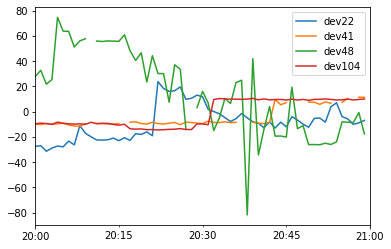

time: 530 ms


In [271]:
notinproximity_sensor_df_0.plot()
print(cosine_dist(notinproximity_sensor_df_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(notinproximity_sensor_df_0))
print("-----------------------------------------------")
print(fast_dtw(notinproximity_sensor_df_0))
print("-----------------------------------------------")
notinproximity_sensor_df_0.corr()

              comb    cosine
0   (dev22, dev41)  1.413771
1   (dev22, dev48)  0.917417
2  (dev22, dev104)  1.794941
3   (dev41, dev48)  1.257948
4  (dev41, dev104)  0.999785
5  (dev48, dev104)  1.240905
-----------------------------------------------
              comb    cosine
0   (dev22, dev41)  0.385080
1   (dev22, dev48)  0.231092
2  (dev22, dev104)  0.115296
3   (dev41, dev48)  0.169115
4  (dev41, dev104)  0.338182
5  (dev48, dev104)  0.167428
-----------------------------------------------
              comb     distance
0   (dev22, dev41)  2209.180092
1   (dev22, dev48)  2835.953970
2  (dev22, dev104)  1891.622168
3   (dev41, dev48)  2303.879281
4  (dev41, dev104)  1115.614319
5  (dev48, dev104)  2886.426278
-----------------------------------------------


dev22     dev41     dev48    dev104
dev22   1.000000 -0.598704 -0.309007  0.554521
dev41  -0.598704  1.000000 -0.240672 -0.548893
dev48  -0.309007 -0.240672  1.000000 -0.130536
dev104  0.554521 -0.548893 -0.130536  1.000000

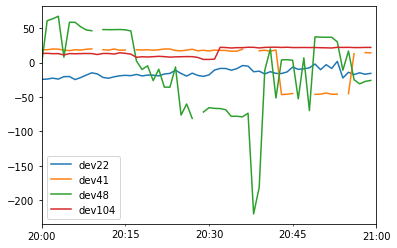

time: 539 ms


In [272]:
notinproximity_sensor_df_1.plot()
print(cosine_dist(notinproximity_sensor_df_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(notinproximity_sensor_df_1))
print("-----------------------------------------------")
print(fast_dtw(notinproximity_sensor_df_1))
print("-----------------------------------------------")
notinproximity_sensor_df_1.corr()

              comb    cosine
0   (dev22, dev41)  0.722315
1   (dev22, dev48)  0.531909
2  (dev22, dev104)  0.520847
3   (dev41, dev48)  0.196196
4  (dev41, dev104)  0.172931
5  (dev48, dev104)  0.025264
-----------------------------------------------
              comb    cosine
0   (dev22, dev41)  0.618170
1   (dev22, dev48)  0.170048
2  (dev22, dev104)  0.253538
3   (dev41, dev48)  0.504831
4  (dev41, dev104)  0.426230
5  (dev48, dev104)  0.153957
-----------------------------------------------
              comb      distance
0   (dev22, dev41)   1307.708815
1   (dev22, dev48)  10702.929492
2  (dev22, dev104)   2932.706953
3   (dev41, dev48)   9813.322514
4  (dev41, dev104)   2043.099976
5  (dev48, dev104)   7695.661992
-----------------------------------------------


dev22     dev41     dev48    dev104
dev22   1.000000 -0.134638 -0.209631 -0.139332
dev41  -0.134638  1.000000  0.187864  0.379339
dev48  -0.209631  0.187864  1.000000  0.333790
dev104 -0.139332  0.379339  0.333790  1.000000

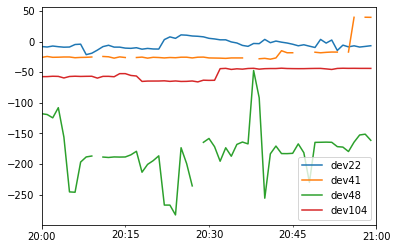

time: 543 ms


In [273]:
notinproximity_sensor_df_2.plot()
print(cosine_dist(notinproximity_sensor_df_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(notinproximity_sensor_df_2))
print("-----------------------------------------------")
print(fast_dtw(notinproximity_sensor_df_2))
print("-----------------------------------------------")
notinproximity_sensor_df_2.corr()

(array([6., 1., 2., 2., 3., 1., 1., 0., 1., 1.]),
 array([0.11529634, 0.17380182, 0.2323073 , 0.29081278, 0.34931826,
        0.40782374, 0.46632922, 0.52483469, 0.58334017, 0.64184565,
        0.70035113]),
 <a list of 10 Patch objects>)

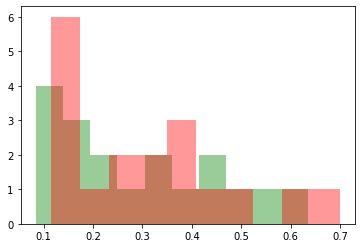

time: 639 ms


In [274]:
all_in_proximity = list(cosine_dist_normalized(inproximity_sensor_df_0)['cosine']) + list(cosine_dist_normalized(inproximity_sensor_df_1)['cosine']) + list(cosine_dist_normalized(inproximity_sensor_df_2)['cosine'])
all_not_in_proximity = list(cosine_dist_normalized(notinproximity_sensor_df_0)['cosine']) + list(cosine_dist_normalized(notinproximity_sensor_df_1)['cosine']) + list(cosine_dist_normalized(notinproximity_sensor_df_2)['cosine'])

plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)


(array([4., 5., 6., 0., 0., 0., 0., 1., 0., 2.]),
 array([  123.6289978 ,  1181.55904721,  2239.48909662,  3297.41914604,
         4355.34919545,  5413.27924486,  6471.20929427,  7529.13934368,
         8587.06939309,  9644.9994425 , 10702.92949191]),
 <a list of 10 Patch objects>)

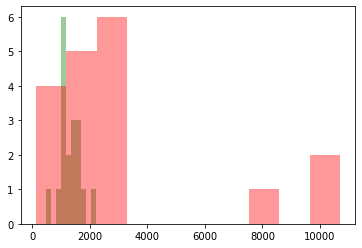

time: 1.03 s


In [275]:
all_in_proximity = list(fast_dtw(inproximity_sensor_df_0)['distance']) + list(fast_dtw(inproximity_sensor_df_1)['distance']) + list(fast_dtw(inproximity_sensor_df_2)['distance'])
all_not_in_proximity = list(fast_dtw(notinproximity_sensor_df_0)['distance']) + list(fast_dtw(notinproximity_sensor_df_1)['distance']) + list(fast_dtw(notinproximity_sensor_df_2)['distance'])

plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)


## Wifi Proximity Analysis ##

### Preprocess/ Prep ###

In [5]:
data_wifi = b2s(pd.read_parquet(os.path.join(path_data_collection, "wifi.parquet.snappy")))
data_wifi = data_wifi[pd.notnull(data_wifi.device_id)]
data_wifi['device_id'].replace(device_id_mappings, inplace = True)

time: 3min 25s


In [6]:
data_wifi_ts_list = data_wifi['timestamp'].dt.round('5min')

time: 1.18 s


In [7]:
data_wifi_ts_list = pd.to_datetime((np.unique(data_wifi_ts_list)))

time: 437 ms


In [8]:
data_wifi_ts_list

DatetimeIndex(['2018-04-23 11:05:00', '2018-04-23 11:10:00',
               '2018-04-23 11:15:00', '2018-04-23 11:20:00',
               '2018-04-23 11:25:00', '2018-04-25 15:15:00',
               '2018-04-25 15:20:00', '2018-04-25 15:25:00',
               '2018-04-25 15:30:00', '2018-04-25 15:35:00',
               ...
               '2018-08-14 23:35:00', '2018-08-14 23:40:00',
               '2018-08-14 23:45:00', '2018-08-14 23:50:00',
               '2018-08-14 23:55:00', '2018-08-15 00:00:00',
               '2018-08-15 00:05:00', '2018-08-15 00:10:00',
               '2018-08-15 00:15:00', '2018-08-15 00:20:00'],
              dtype='datetime64[ns]', length=31860, freq=None)

time: 2.63 s


In [9]:
temp = pd.DataFrame()
temp['date'] = date
temp['device'] = device
temp['scans'] = list(data_wifi_grouped)



NameError: name 'date' is not defined

time: 28 ms


In [13]:
data_wifi.head(20)

_id               timestamp  device_id              bssid        ssid  \
0     1 2018-04-23 11:06:49.304         23  ac:4b:c8:08:ae:ca  mwn-events   
1     2 2018-04-23 11:06:49.304         23  ac:4b:c8:08:ae:cc  fmi-events   
2     3 2018-04-23 11:06:49.304         23  ac:4b:c8:08:ae:c2     eduroam   
3     4 2018-04-23 11:06:49.304         23  ac:4b:c8:08:ae:c4         lrz   
4     5 2018-04-23 11:06:49.304         23  ac:4b:c8:08:ae:c1     eduroam   
5     6 2018-04-23 11:06:49.304         23  ac:4b:c8:08:ae:cd  fmi-events   
6     7 2018-04-23 11:06:49.304         23  ac:4b:c8:08:ae:c9  mwn-events   
7     8 2018-04-23 11:06:49.304         23  ac:4b:c8:08:ae:c3         lrz   
8     9 2018-04-23 11:06:49.304         23  00:04:4b:8d:64:d3      jetson   
9    10 2018-04-23 11:06:49.304         23  ac:4b:c8:09:16:0a  mwn-events   
10   11 2018-04-23 11:06:49.304         23  ac:4b:c8:09:16:04         lrz   
11   12 2018-04-23 11:06:49.304         23  00:26:3e:f4:d1:0c  fmi-events   
12   13 2018-04-23 11:06:49.304         23  ac:4b:c8:09:16:08         NaN   
13   14 2018-04-23 11:06:49.304         23  00:26:3e:f4:d1:02     eduroam   
14   15 2018-04-23 11:06:49.304         23  ac:4b:c8:09:16:0c  fmi-events   
15   16 2018-04-23 11:06:49.304         23  00:26:3e:f4:d1:04         lrz   
16   17 2018-04-23 11:06:49.304         23  ac:4b:c8:09:16:06         NaN   
17   18 2018-04-23 11:06:49.304         23  ac:4b:c8:09:16:12         NaN   
18   19 2018-04-23 11:06:49.304         23  00:26:3e:f4:d1:0a  mwn-events   
19   20 2018-04-23 11:06:49.304         23  00:26:3e:f4:d1:00         NaN   

                         security  frequency  rssi label  
0            [WPA2-EAP-CCMP][ESS]       2462 -43.0   NaN  
1            [WPA2-PSK-CCMP][ESS]       2462 -47.0   NaN  
2            [WPA2-EAP-CCMP][ESS]       2462 -48.0   NaN  
3                           [ESS]       2462 -49.0   NaN  
4            [WPA2-EAP-CCMP][ESS]       5220 -56.0   NaN  
5            [WPA2-PSK-CCMP][ESS]       5220 -56.0   NaN  
6            [WPA2-EAP-CCMP][ESS]       5220 -56.0   NaN  
7                           [ESS]       5220 -56.0   NaN  
8   [WPA-PSK-CCMP+TKIP][ESS][WPS]       2412 -60.0   NaN  
9            [WPA2-EAP-CCMP][ESS]       2412 -65.0   NaN  
10                          [ESS]       2412 -66.0   NaN  
11           [WPA2-PSK-CCMP][ESS]       2437 -66.0   NaN  
12           [WPA2-EAP-CCMP][ESS]       2412 -66.0   NaN  
13           [WPA2-EAP-CCMP][ESS]       2437 -68.0   NaN  
14           [WPA2-PSK-CCMP][ESS]       2412 -68.0   NaN  
15                          [ESS]       2437 -68.0   NaN  
16           [WPA2-PSK-CCMP][ESS]       2412 -69.0   NaN  
17           [WPA2-PSK-CCMP][ESS]       2412 -69.0   NaN  
18           [WPA2-EAP-CCMP][ESS]       2437 -70.0   NaN  
19           [WPA2-PSK-CCMP][ESS]       2437 -70.0   NaN

time: 34.6 ms


In [19]:
last = str(data_wifi_ts_list[-1])
for delta in [20]:
    devices_detected = []
    date_list = []
    for date in data_wifi_ts_list:
        start = date - timedelta(minutes=delta)
        filtered = data_wifi[(data_wifi['timestamp']>=start) & (data_wifi['timestamp']<=date)]
        filtered  = filtered[['timestamp','device_id','bssid']]
        filtered = filtered.groupby(['bssid'])['device_id'].apply(list).apply(np.unique)
        unique_data = [list(x) for x in set(tuple(x) for x in list(filtered))]
        unique_data = [x for x in unique_data if (len(x)>1)]
        devices_detected.append(unique_data)
        print(str(date)+" / "+last)
    wifi_proximity = pd.DataFrame()
    wifi_proximity['timestamp'] = data_wifi_ts_list
    wifi_proximity['devices'] = devices_detected
    wifi_proximity.to_parquet(os.path.join(path_results, "wifi_proximity_"+str(delta)+"m_captured.gzip"))

    
    

2018-04-23 11:05:00 / 2018-08-15 00:20:00
2018-04-23 11:10:00 / 2018-08-15 00:20:00
2018-04-23 11:15:00 / 2018-08-15 00:20:00
2018-04-23 11:20:00 / 2018-08-15 00:20:00
2018-04-23 11:25:00 / 2018-08-15 00:20:00
2018-04-25 15:15:00 / 2018-08-15 00:20:00
2018-04-25 15:20:00 / 2018-08-15 00:20:00
2018-04-25 15:25:00 / 2018-08-15 00:20:00
2018-04-25 15:30:00 / 2018-08-15 00:20:00
2018-04-25 15:35:00 / 2018-08-15 00:20:00
2018-04-25 15:55:00 / 2018-08-15 00:20:00
2018-04-25 16:00:00 / 2018-08-15 00:20:00
2018-04-25 16:05:00 / 2018-08-15 00:20:00
2018-04-25 16:10:00 / 2018-08-15 00:20:00
2018-04-25 16:15:00 / 2018-08-15 00:20:00
2018-04-25 16:20:00 / 2018-08-15 00:20:00
2018-04-25 16:25:00 / 2018-08-15 00:20:00
2018-04-25 16:30:00 / 2018-08-15 00:20:00
2018-04-25 16:35:00 / 2018-08-15 00:20:00
2018-04-25 16:40:00 / 2018-08-15 00:20:00
2018-04-25 16:45:00 / 2018-08-15 00:20:00
2018-04-25 16:50:00 / 2018-08-15 00:20:00
2018-04-25 16:55:00 / 2018-08-15 00:20:00
2018-04-25 17:00:00 / 2018-08-15 0

2018-04-26 08:20:00 / 2018-08-15 00:20:00
2018-04-26 08:25:00 / 2018-08-15 00:20:00
2018-04-26 08:30:00 / 2018-08-15 00:20:00
2018-04-26 08:35:00 / 2018-08-15 00:20:00
2018-04-26 08:40:00 / 2018-08-15 00:20:00
2018-04-26 08:45:00 / 2018-08-15 00:20:00
2018-04-26 08:50:00 / 2018-08-15 00:20:00
2018-04-26 08:55:00 / 2018-08-15 00:20:00
2018-04-26 09:00:00 / 2018-08-15 00:20:00
2018-04-26 09:05:00 / 2018-08-15 00:20:00
2018-04-26 09:10:00 / 2018-08-15 00:20:00
2018-04-26 09:15:00 / 2018-08-15 00:20:00
2018-04-26 09:20:00 / 2018-08-15 00:20:00
2018-04-26 09:25:00 / 2018-08-15 00:20:00
2018-04-26 09:30:00 / 2018-08-15 00:20:00
2018-04-26 09:35:00 / 2018-08-15 00:20:00
2018-04-26 09:40:00 / 2018-08-15 00:20:00
2018-04-26 09:45:00 / 2018-08-15 00:20:00
2018-04-26 09:50:00 / 2018-08-15 00:20:00
2018-04-26 09:55:00 / 2018-08-15 00:20:00
2018-04-26 10:00:00 / 2018-08-15 00:20:00
2018-04-26 10:05:00 / 2018-08-15 00:20:00
2018-04-26 10:10:00 / 2018-08-15 00:20:00
2018-04-26 10:15:00 / 2018-08-15 0

2018-04-27 00:45:00 / 2018-08-15 00:20:00
2018-04-27 00:50:00 / 2018-08-15 00:20:00
2018-04-27 00:55:00 / 2018-08-15 00:20:00
2018-04-27 01:00:00 / 2018-08-15 00:20:00
2018-04-27 01:05:00 / 2018-08-15 00:20:00
2018-04-27 01:10:00 / 2018-08-15 00:20:00
2018-04-27 01:15:00 / 2018-08-15 00:20:00
2018-04-27 01:20:00 / 2018-08-15 00:20:00
2018-04-27 01:25:00 / 2018-08-15 00:20:00
2018-04-27 01:30:00 / 2018-08-15 00:20:00
2018-04-27 01:35:00 / 2018-08-15 00:20:00
2018-04-27 01:40:00 / 2018-08-15 00:20:00
2018-04-27 01:45:00 / 2018-08-15 00:20:00
2018-04-27 01:50:00 / 2018-08-15 00:20:00
2018-04-27 01:55:00 / 2018-08-15 00:20:00
2018-04-27 02:00:00 / 2018-08-15 00:20:00
2018-04-27 02:05:00 / 2018-08-15 00:20:00
2018-04-27 02:10:00 / 2018-08-15 00:20:00
2018-04-27 02:15:00 / 2018-08-15 00:20:00
2018-04-27 02:20:00 / 2018-08-15 00:20:00
2018-04-27 02:25:00 / 2018-08-15 00:20:00
2018-04-27 02:30:00 / 2018-08-15 00:20:00
2018-04-27 02:35:00 / 2018-08-15 00:20:00
2018-04-27 02:40:00 / 2018-08-15 0

2018-04-27 17:05:00 / 2018-08-15 00:20:00
2018-04-27 17:10:00 / 2018-08-15 00:20:00
2018-04-27 17:15:00 / 2018-08-15 00:20:00
2018-04-27 17:20:00 / 2018-08-15 00:20:00
2018-04-27 17:25:00 / 2018-08-15 00:20:00
2018-04-27 17:30:00 / 2018-08-15 00:20:00
2018-04-27 17:35:00 / 2018-08-15 00:20:00
2018-04-27 17:40:00 / 2018-08-15 00:20:00
2018-04-27 17:45:00 / 2018-08-15 00:20:00
2018-04-27 17:50:00 / 2018-08-15 00:20:00
2018-04-27 17:55:00 / 2018-08-15 00:20:00
2018-04-27 18:00:00 / 2018-08-15 00:20:00
2018-04-27 18:05:00 / 2018-08-15 00:20:00
2018-04-27 18:10:00 / 2018-08-15 00:20:00
2018-04-27 18:15:00 / 2018-08-15 00:20:00
2018-04-27 18:20:00 / 2018-08-15 00:20:00
2018-04-27 18:25:00 / 2018-08-15 00:20:00
2018-04-27 18:30:00 / 2018-08-15 00:20:00
2018-04-27 18:35:00 / 2018-08-15 00:20:00
2018-04-27 18:40:00 / 2018-08-15 00:20:00
2018-04-27 18:45:00 / 2018-08-15 00:20:00
2018-04-27 18:50:00 / 2018-08-15 00:20:00
2018-04-27 18:55:00 / 2018-08-15 00:20:00
2018-04-27 19:00:00 / 2018-08-15 0

2018-04-28 09:25:00 / 2018-08-15 00:20:00
2018-04-28 09:30:00 / 2018-08-15 00:20:00
2018-04-28 09:35:00 / 2018-08-15 00:20:00
2018-04-28 09:40:00 / 2018-08-15 00:20:00
2018-04-28 09:45:00 / 2018-08-15 00:20:00
2018-04-28 09:50:00 / 2018-08-15 00:20:00
2018-04-28 09:55:00 / 2018-08-15 00:20:00
2018-04-28 10:00:00 / 2018-08-15 00:20:00
2018-04-28 10:05:00 / 2018-08-15 00:20:00
2018-04-28 10:10:00 / 2018-08-15 00:20:00
2018-04-28 10:15:00 / 2018-08-15 00:20:00
2018-04-28 10:20:00 / 2018-08-15 00:20:00
2018-04-28 10:25:00 / 2018-08-15 00:20:00
2018-04-28 10:30:00 / 2018-08-15 00:20:00
2018-04-28 10:35:00 / 2018-08-15 00:20:00
2018-04-28 10:40:00 / 2018-08-15 00:20:00
2018-04-28 10:45:00 / 2018-08-15 00:20:00
2018-04-28 10:50:00 / 2018-08-15 00:20:00
2018-04-28 10:55:00 / 2018-08-15 00:20:00
2018-04-28 11:00:00 / 2018-08-15 00:20:00
2018-04-28 11:05:00 / 2018-08-15 00:20:00
2018-04-28 11:10:00 / 2018-08-15 00:20:00
2018-04-28 11:15:00 / 2018-08-15 00:20:00
2018-04-28 11:20:00 / 2018-08-15 0

2018-04-29 01:45:00 / 2018-08-15 00:20:00
2018-04-29 01:50:00 / 2018-08-15 00:20:00
2018-04-29 01:55:00 / 2018-08-15 00:20:00
2018-04-29 02:00:00 / 2018-08-15 00:20:00
2018-04-29 02:05:00 / 2018-08-15 00:20:00
2018-04-29 02:10:00 / 2018-08-15 00:20:00
2018-04-29 02:15:00 / 2018-08-15 00:20:00
2018-04-29 02:20:00 / 2018-08-15 00:20:00
2018-04-29 02:25:00 / 2018-08-15 00:20:00
2018-04-29 02:30:00 / 2018-08-15 00:20:00
2018-04-29 02:35:00 / 2018-08-15 00:20:00
2018-04-29 02:40:00 / 2018-08-15 00:20:00
2018-04-29 02:45:00 / 2018-08-15 00:20:00
2018-04-29 02:50:00 / 2018-08-15 00:20:00
2018-04-29 02:55:00 / 2018-08-15 00:20:00
2018-04-29 03:00:00 / 2018-08-15 00:20:00
2018-04-29 03:05:00 / 2018-08-15 00:20:00
2018-04-29 03:10:00 / 2018-08-15 00:20:00
2018-04-29 03:15:00 / 2018-08-15 00:20:00
2018-04-29 03:20:00 / 2018-08-15 00:20:00
2018-04-29 03:25:00 / 2018-08-15 00:20:00
2018-04-29 03:30:00 / 2018-08-15 00:20:00
2018-04-29 03:35:00 / 2018-08-15 00:20:00
2018-04-29 03:40:00 / 2018-08-15 0

2018-04-29 18:05:00 / 2018-08-15 00:20:00
2018-04-29 18:10:00 / 2018-08-15 00:20:00
2018-04-29 18:15:00 / 2018-08-15 00:20:00
2018-04-29 18:20:00 / 2018-08-15 00:20:00
2018-04-29 18:25:00 / 2018-08-15 00:20:00
2018-04-29 18:30:00 / 2018-08-15 00:20:00
2018-04-29 18:35:00 / 2018-08-15 00:20:00
2018-04-29 18:40:00 / 2018-08-15 00:20:00
2018-04-29 18:45:00 / 2018-08-15 00:20:00
2018-04-29 18:50:00 / 2018-08-15 00:20:00
2018-04-29 18:55:00 / 2018-08-15 00:20:00
2018-04-29 19:00:00 / 2018-08-15 00:20:00
2018-04-29 19:05:00 / 2018-08-15 00:20:00
2018-04-29 19:10:00 / 2018-08-15 00:20:00
2018-04-29 19:15:00 / 2018-08-15 00:20:00
2018-04-29 19:20:00 / 2018-08-15 00:20:00
2018-04-29 19:25:00 / 2018-08-15 00:20:00
2018-04-29 19:30:00 / 2018-08-15 00:20:00
2018-04-29 19:35:00 / 2018-08-15 00:20:00
2018-04-29 19:40:00 / 2018-08-15 00:20:00
2018-04-29 19:45:00 / 2018-08-15 00:20:00
2018-04-29 19:50:00 / 2018-08-15 00:20:00
2018-04-29 19:55:00 / 2018-08-15 00:20:00
2018-04-29 20:00:00 / 2018-08-15 0

2018-04-30 10:30:00 / 2018-08-15 00:20:00
2018-04-30 10:35:00 / 2018-08-15 00:20:00
2018-04-30 10:40:00 / 2018-08-15 00:20:00
2018-04-30 10:45:00 / 2018-08-15 00:20:00
2018-04-30 10:50:00 / 2018-08-15 00:20:00
2018-04-30 10:55:00 / 2018-08-15 00:20:00
2018-04-30 11:00:00 / 2018-08-15 00:20:00
2018-04-30 11:05:00 / 2018-08-15 00:20:00
2018-04-30 11:10:00 / 2018-08-15 00:20:00
2018-04-30 11:15:00 / 2018-08-15 00:20:00
2018-04-30 11:20:00 / 2018-08-15 00:20:00
2018-04-30 11:25:00 / 2018-08-15 00:20:00
2018-04-30 11:30:00 / 2018-08-15 00:20:00
2018-04-30 11:35:00 / 2018-08-15 00:20:00
2018-04-30 11:40:00 / 2018-08-15 00:20:00
2018-04-30 11:45:00 / 2018-08-15 00:20:00
2018-04-30 11:50:00 / 2018-08-15 00:20:00
2018-04-30 11:55:00 / 2018-08-15 00:20:00
2018-04-30 12:00:00 / 2018-08-15 00:20:00
2018-04-30 12:05:00 / 2018-08-15 00:20:00
2018-04-30 12:10:00 / 2018-08-15 00:20:00
2018-04-30 12:15:00 / 2018-08-15 00:20:00
2018-04-30 12:20:00 / 2018-08-15 00:20:00
2018-04-30 12:25:00 / 2018-08-15 0

2018-05-01 02:50:00 / 2018-08-15 00:20:00
2018-05-01 02:55:00 / 2018-08-15 00:20:00
2018-05-01 03:00:00 / 2018-08-15 00:20:00
2018-05-01 03:05:00 / 2018-08-15 00:20:00
2018-05-01 03:10:00 / 2018-08-15 00:20:00
2018-05-01 03:15:00 / 2018-08-15 00:20:00
2018-05-01 03:20:00 / 2018-08-15 00:20:00
2018-05-01 03:25:00 / 2018-08-15 00:20:00
2018-05-01 03:30:00 / 2018-08-15 00:20:00
2018-05-01 03:35:00 / 2018-08-15 00:20:00
2018-05-01 03:40:00 / 2018-08-15 00:20:00
2018-05-01 03:45:00 / 2018-08-15 00:20:00
2018-05-01 03:50:00 / 2018-08-15 00:20:00
2018-05-01 03:55:00 / 2018-08-15 00:20:00
2018-05-01 04:00:00 / 2018-08-15 00:20:00
2018-05-01 04:05:00 / 2018-08-15 00:20:00
2018-05-01 04:10:00 / 2018-08-15 00:20:00
2018-05-01 04:15:00 / 2018-08-15 00:20:00
2018-05-01 04:20:00 / 2018-08-15 00:20:00
2018-05-01 04:25:00 / 2018-08-15 00:20:00
2018-05-01 04:30:00 / 2018-08-15 00:20:00
2018-05-01 04:35:00 / 2018-08-15 00:20:00
2018-05-01 04:40:00 / 2018-08-15 00:20:00
2018-05-01 04:45:00 / 2018-08-15 0

2018-05-01 19:15:00 / 2018-08-15 00:20:00
2018-05-01 19:20:00 / 2018-08-15 00:20:00
2018-05-01 19:25:00 / 2018-08-15 00:20:00
2018-05-01 19:30:00 / 2018-08-15 00:20:00
2018-05-01 19:35:00 / 2018-08-15 00:20:00
2018-05-01 19:40:00 / 2018-08-15 00:20:00
2018-05-01 19:45:00 / 2018-08-15 00:20:00
2018-05-01 19:50:00 / 2018-08-15 00:20:00
2018-05-01 19:55:00 / 2018-08-15 00:20:00
2018-05-01 20:00:00 / 2018-08-15 00:20:00
2018-05-01 20:05:00 / 2018-08-15 00:20:00
2018-05-01 20:10:00 / 2018-08-15 00:20:00
2018-05-01 20:15:00 / 2018-08-15 00:20:00
2018-05-01 20:20:00 / 2018-08-15 00:20:00
2018-05-01 20:25:00 / 2018-08-15 00:20:00
2018-05-01 20:30:00 / 2018-08-15 00:20:00
2018-05-01 20:35:00 / 2018-08-15 00:20:00
2018-05-01 20:40:00 / 2018-08-15 00:20:00
2018-05-01 20:45:00 / 2018-08-15 00:20:00
2018-05-01 20:50:00 / 2018-08-15 00:20:00
2018-05-01 20:55:00 / 2018-08-15 00:20:00
2018-05-01 21:00:00 / 2018-08-15 00:20:00
2018-05-01 21:05:00 / 2018-08-15 00:20:00
2018-05-01 21:10:00 / 2018-08-15 0

2018-05-02 11:40:00 / 2018-08-15 00:20:00
2018-05-02 11:45:00 / 2018-08-15 00:20:00
2018-05-02 11:50:00 / 2018-08-15 00:20:00
2018-05-02 11:55:00 / 2018-08-15 00:20:00
2018-05-02 12:00:00 / 2018-08-15 00:20:00
2018-05-02 12:05:00 / 2018-08-15 00:20:00
2018-05-02 12:10:00 / 2018-08-15 00:20:00
2018-05-02 12:15:00 / 2018-08-15 00:20:00
2018-05-02 12:20:00 / 2018-08-15 00:20:00
2018-05-02 12:25:00 / 2018-08-15 00:20:00
2018-05-02 12:30:00 / 2018-08-15 00:20:00
2018-05-02 12:35:00 / 2018-08-15 00:20:00
2018-05-02 12:40:00 / 2018-08-15 00:20:00
2018-05-02 12:45:00 / 2018-08-15 00:20:00
2018-05-02 12:50:00 / 2018-08-15 00:20:00
2018-05-02 12:55:00 / 2018-08-15 00:20:00
2018-05-02 13:00:00 / 2018-08-15 00:20:00
2018-05-02 13:05:00 / 2018-08-15 00:20:00
2018-05-02 13:10:00 / 2018-08-15 00:20:00
2018-05-02 13:15:00 / 2018-08-15 00:20:00
2018-05-02 13:20:00 / 2018-08-15 00:20:00
2018-05-02 13:25:00 / 2018-08-15 00:20:00
2018-05-02 13:30:00 / 2018-08-15 00:20:00
2018-05-02 13:35:00 / 2018-08-15 0

2018-05-03 04:05:00 / 2018-08-15 00:20:00
2018-05-03 04:10:00 / 2018-08-15 00:20:00
2018-05-03 04:15:00 / 2018-08-15 00:20:00
2018-05-03 04:20:00 / 2018-08-15 00:20:00
2018-05-03 04:25:00 / 2018-08-15 00:20:00
2018-05-03 04:30:00 / 2018-08-15 00:20:00
2018-05-03 04:35:00 / 2018-08-15 00:20:00
2018-05-03 04:40:00 / 2018-08-15 00:20:00
2018-05-03 04:45:00 / 2018-08-15 00:20:00
2018-05-03 04:50:00 / 2018-08-15 00:20:00
2018-05-03 04:55:00 / 2018-08-15 00:20:00
2018-05-03 05:00:00 / 2018-08-15 00:20:00
2018-05-03 05:05:00 / 2018-08-15 00:20:00
2018-05-03 05:10:00 / 2018-08-15 00:20:00
2018-05-03 05:15:00 / 2018-08-15 00:20:00
2018-05-03 05:20:00 / 2018-08-15 00:20:00
2018-05-03 05:25:00 / 2018-08-15 00:20:00
2018-05-03 05:30:00 / 2018-08-15 00:20:00
2018-05-03 05:35:00 / 2018-08-15 00:20:00
2018-05-03 05:40:00 / 2018-08-15 00:20:00
2018-05-03 05:45:00 / 2018-08-15 00:20:00
2018-05-03 05:50:00 / 2018-08-15 00:20:00
2018-05-03 05:55:00 / 2018-08-15 00:20:00
2018-05-03 06:00:00 / 2018-08-15 0

2018-05-03 20:25:00 / 2018-08-15 00:20:00
2018-05-03 20:30:00 / 2018-08-15 00:20:00
2018-05-03 20:35:00 / 2018-08-15 00:20:00
2018-05-03 20:40:00 / 2018-08-15 00:20:00
2018-05-03 20:45:00 / 2018-08-15 00:20:00
2018-05-03 20:50:00 / 2018-08-15 00:20:00
2018-05-03 20:55:00 / 2018-08-15 00:20:00
2018-05-03 21:00:00 / 2018-08-15 00:20:00
2018-05-03 21:05:00 / 2018-08-15 00:20:00
2018-05-03 21:10:00 / 2018-08-15 00:20:00
2018-05-03 21:15:00 / 2018-08-15 00:20:00
2018-05-03 21:20:00 / 2018-08-15 00:20:00
2018-05-03 21:25:00 / 2018-08-15 00:20:00
2018-05-03 21:30:00 / 2018-08-15 00:20:00
2018-05-03 21:35:00 / 2018-08-15 00:20:00
2018-05-03 21:40:00 / 2018-08-15 00:20:00
2018-05-03 21:45:00 / 2018-08-15 00:20:00
2018-05-03 21:50:00 / 2018-08-15 00:20:00
2018-05-03 21:55:00 / 2018-08-15 00:20:00
2018-05-03 22:00:00 / 2018-08-15 00:20:00
2018-05-03 22:05:00 / 2018-08-15 00:20:00
2018-05-03 22:10:00 / 2018-08-15 00:20:00
2018-05-03 22:15:00 / 2018-08-15 00:20:00
2018-05-03 22:20:00 / 2018-08-15 0

2018-05-04 12:45:00 / 2018-08-15 00:20:00
2018-05-04 12:50:00 / 2018-08-15 00:20:00
2018-05-04 12:55:00 / 2018-08-15 00:20:00
2018-05-04 13:00:00 / 2018-08-15 00:20:00
2018-05-04 13:05:00 / 2018-08-15 00:20:00
2018-05-04 13:10:00 / 2018-08-15 00:20:00
2018-05-04 13:15:00 / 2018-08-15 00:20:00
2018-05-04 13:20:00 / 2018-08-15 00:20:00
2018-05-04 13:25:00 / 2018-08-15 00:20:00
2018-05-04 13:30:00 / 2018-08-15 00:20:00
2018-05-04 13:35:00 / 2018-08-15 00:20:00
2018-05-04 13:40:00 / 2018-08-15 00:20:00
2018-05-04 13:45:00 / 2018-08-15 00:20:00
2018-05-04 13:50:00 / 2018-08-15 00:20:00
2018-05-04 13:55:00 / 2018-08-15 00:20:00
2018-05-04 14:00:00 / 2018-08-15 00:20:00
2018-05-04 14:05:00 / 2018-08-15 00:20:00
2018-05-04 14:10:00 / 2018-08-15 00:20:00
2018-05-04 14:15:00 / 2018-08-15 00:20:00
2018-05-04 14:20:00 / 2018-08-15 00:20:00
2018-05-04 14:25:00 / 2018-08-15 00:20:00
2018-05-04 14:30:00 / 2018-08-15 00:20:00
2018-05-04 14:35:00 / 2018-08-15 00:20:00
2018-05-04 14:40:00 / 2018-08-15 0

2018-05-05 05:05:00 / 2018-08-15 00:20:00
2018-05-05 05:10:00 / 2018-08-15 00:20:00
2018-05-05 05:15:00 / 2018-08-15 00:20:00
2018-05-05 05:20:00 / 2018-08-15 00:20:00
2018-05-05 05:25:00 / 2018-08-15 00:20:00
2018-05-05 05:30:00 / 2018-08-15 00:20:00
2018-05-05 05:35:00 / 2018-08-15 00:20:00
2018-05-05 05:40:00 / 2018-08-15 00:20:00
2018-05-05 05:45:00 / 2018-08-15 00:20:00
2018-05-05 05:50:00 / 2018-08-15 00:20:00
2018-05-05 05:55:00 / 2018-08-15 00:20:00
2018-05-05 06:00:00 / 2018-08-15 00:20:00
2018-05-05 06:05:00 / 2018-08-15 00:20:00
2018-05-05 06:10:00 / 2018-08-15 00:20:00
2018-05-05 06:15:00 / 2018-08-15 00:20:00
2018-05-05 06:20:00 / 2018-08-15 00:20:00
2018-05-05 06:25:00 / 2018-08-15 00:20:00
2018-05-05 06:30:00 / 2018-08-15 00:20:00
2018-05-05 06:35:00 / 2018-08-15 00:20:00
2018-05-05 06:40:00 / 2018-08-15 00:20:00
2018-05-05 06:45:00 / 2018-08-15 00:20:00
2018-05-05 06:50:00 / 2018-08-15 00:20:00
2018-05-05 06:55:00 / 2018-08-15 00:20:00
2018-05-05 07:00:00 / 2018-08-15 0

2018-05-05 21:30:00 / 2018-08-15 00:20:00
2018-05-05 21:35:00 / 2018-08-15 00:20:00
2018-05-05 21:40:00 / 2018-08-15 00:20:00
2018-05-05 21:45:00 / 2018-08-15 00:20:00
2018-05-05 21:50:00 / 2018-08-15 00:20:00
2018-05-05 21:55:00 / 2018-08-15 00:20:00
2018-05-05 22:00:00 / 2018-08-15 00:20:00
2018-05-05 22:05:00 / 2018-08-15 00:20:00
2018-05-05 22:10:00 / 2018-08-15 00:20:00
2018-05-05 22:15:00 / 2018-08-15 00:20:00
2018-05-05 22:20:00 / 2018-08-15 00:20:00
2018-05-05 22:25:00 / 2018-08-15 00:20:00
2018-05-05 22:30:00 / 2018-08-15 00:20:00
2018-05-05 22:35:00 / 2018-08-15 00:20:00
2018-05-05 22:40:00 / 2018-08-15 00:20:00
2018-05-05 22:45:00 / 2018-08-15 00:20:00
2018-05-05 22:50:00 / 2018-08-15 00:20:00
2018-05-05 22:55:00 / 2018-08-15 00:20:00
2018-05-05 23:00:00 / 2018-08-15 00:20:00
2018-05-05 23:05:00 / 2018-08-15 00:20:00
2018-05-05 23:10:00 / 2018-08-15 00:20:00
2018-05-05 23:15:00 / 2018-08-15 00:20:00
2018-05-05 23:20:00 / 2018-08-15 00:20:00
2018-05-05 23:25:00 / 2018-08-15 0

2018-05-06 13:50:00 / 2018-08-15 00:20:00
2018-05-06 13:55:00 / 2018-08-15 00:20:00
2018-05-06 14:00:00 / 2018-08-15 00:20:00
2018-05-06 14:05:00 / 2018-08-15 00:20:00
2018-05-06 14:10:00 / 2018-08-15 00:20:00
2018-05-06 14:15:00 / 2018-08-15 00:20:00
2018-05-06 14:20:00 / 2018-08-15 00:20:00
2018-05-06 14:25:00 / 2018-08-15 00:20:00
2018-05-06 14:30:00 / 2018-08-15 00:20:00
2018-05-06 14:35:00 / 2018-08-15 00:20:00
2018-05-06 14:40:00 / 2018-08-15 00:20:00
2018-05-06 14:45:00 / 2018-08-15 00:20:00
2018-05-06 14:50:00 / 2018-08-15 00:20:00
2018-05-06 14:55:00 / 2018-08-15 00:20:00
2018-05-06 15:00:00 / 2018-08-15 00:20:00
2018-05-06 15:05:00 / 2018-08-15 00:20:00
2018-05-06 15:10:00 / 2018-08-15 00:20:00
2018-05-06 15:15:00 / 2018-08-15 00:20:00
2018-05-06 15:20:00 / 2018-08-15 00:20:00
2018-05-06 15:25:00 / 2018-08-15 00:20:00
2018-05-06 15:30:00 / 2018-08-15 00:20:00
2018-05-06 15:35:00 / 2018-08-15 00:20:00
2018-05-06 15:40:00 / 2018-08-15 00:20:00
2018-05-06 15:45:00 / 2018-08-15 0

2018-05-07 06:10:00 / 2018-08-15 00:20:00
2018-05-07 06:15:00 / 2018-08-15 00:20:00
2018-05-07 06:20:00 / 2018-08-15 00:20:00
2018-05-07 06:25:00 / 2018-08-15 00:20:00
2018-05-07 06:30:00 / 2018-08-15 00:20:00
2018-05-07 06:35:00 / 2018-08-15 00:20:00
2018-05-07 06:40:00 / 2018-08-15 00:20:00
2018-05-07 06:45:00 / 2018-08-15 00:20:00
2018-05-07 06:50:00 / 2018-08-15 00:20:00
2018-05-07 06:55:00 / 2018-08-15 00:20:00
2018-05-07 07:00:00 / 2018-08-15 00:20:00
2018-05-07 07:05:00 / 2018-08-15 00:20:00
2018-05-07 07:10:00 / 2018-08-15 00:20:00
2018-05-07 07:15:00 / 2018-08-15 00:20:00
2018-05-07 07:20:00 / 2018-08-15 00:20:00
2018-05-07 07:25:00 / 2018-08-15 00:20:00
2018-05-07 07:30:00 / 2018-08-15 00:20:00
2018-05-07 07:35:00 / 2018-08-15 00:20:00
2018-05-07 07:40:00 / 2018-08-15 00:20:00
2018-05-07 07:45:00 / 2018-08-15 00:20:00
2018-05-07 07:50:00 / 2018-08-15 00:20:00
2018-05-07 07:55:00 / 2018-08-15 00:20:00
2018-05-07 08:00:00 / 2018-08-15 00:20:00
2018-05-07 08:05:00 / 2018-08-15 0

2018-05-07 22:35:00 / 2018-08-15 00:20:00
2018-05-07 22:40:00 / 2018-08-15 00:20:00
2018-05-07 22:45:00 / 2018-08-15 00:20:00
2018-05-07 22:50:00 / 2018-08-15 00:20:00
2018-05-07 22:55:00 / 2018-08-15 00:20:00
2018-05-07 23:00:00 / 2018-08-15 00:20:00
2018-05-07 23:05:00 / 2018-08-15 00:20:00
2018-05-07 23:10:00 / 2018-08-15 00:20:00
2018-05-07 23:15:00 / 2018-08-15 00:20:00
2018-05-07 23:20:00 / 2018-08-15 00:20:00
2018-05-07 23:25:00 / 2018-08-15 00:20:00
2018-05-07 23:30:00 / 2018-08-15 00:20:00
2018-05-07 23:35:00 / 2018-08-15 00:20:00
2018-05-07 23:40:00 / 2018-08-15 00:20:00
2018-05-07 23:45:00 / 2018-08-15 00:20:00
2018-05-07 23:50:00 / 2018-08-15 00:20:00
2018-05-07 23:55:00 / 2018-08-15 00:20:00
2018-05-08 00:00:00 / 2018-08-15 00:20:00
2018-05-08 00:05:00 / 2018-08-15 00:20:00
2018-05-08 00:10:00 / 2018-08-15 00:20:00
2018-05-08 00:15:00 / 2018-08-15 00:20:00
2018-05-08 00:20:00 / 2018-08-15 00:20:00
2018-05-08 00:25:00 / 2018-08-15 00:20:00
2018-05-08 00:30:00 / 2018-08-15 0

2018-05-08 14:55:00 / 2018-08-15 00:20:00
2018-05-08 15:00:00 / 2018-08-15 00:20:00
2018-05-08 15:05:00 / 2018-08-15 00:20:00
2018-05-08 15:10:00 / 2018-08-15 00:20:00
2018-05-08 15:15:00 / 2018-08-15 00:20:00
2018-05-08 15:20:00 / 2018-08-15 00:20:00
2018-05-08 15:25:00 / 2018-08-15 00:20:00
2018-05-08 15:30:00 / 2018-08-15 00:20:00
2018-05-08 15:35:00 / 2018-08-15 00:20:00
2018-05-08 15:40:00 / 2018-08-15 00:20:00
2018-05-08 15:45:00 / 2018-08-15 00:20:00
2018-05-08 15:50:00 / 2018-08-15 00:20:00
2018-05-08 15:55:00 / 2018-08-15 00:20:00
2018-05-08 16:00:00 / 2018-08-15 00:20:00
2018-05-08 16:05:00 / 2018-08-15 00:20:00
2018-05-08 16:10:00 / 2018-08-15 00:20:00
2018-05-08 16:15:00 / 2018-08-15 00:20:00
2018-05-08 16:20:00 / 2018-08-15 00:20:00
2018-05-08 16:25:00 / 2018-08-15 00:20:00
2018-05-08 16:30:00 / 2018-08-15 00:20:00
2018-05-08 16:35:00 / 2018-08-15 00:20:00
2018-05-08 16:40:00 / 2018-08-15 00:20:00
2018-05-08 16:45:00 / 2018-08-15 00:20:00
2018-05-08 16:50:00 / 2018-08-15 0

2018-05-09 07:15:00 / 2018-08-15 00:20:00
2018-05-09 07:20:00 / 2018-08-15 00:20:00
2018-05-09 07:25:00 / 2018-08-15 00:20:00
2018-05-09 07:30:00 / 2018-08-15 00:20:00
2018-05-09 07:35:00 / 2018-08-15 00:20:00
2018-05-09 07:40:00 / 2018-08-15 00:20:00
2018-05-09 07:45:00 / 2018-08-15 00:20:00
2018-05-09 07:50:00 / 2018-08-15 00:20:00
2018-05-09 07:55:00 / 2018-08-15 00:20:00
2018-05-09 08:00:00 / 2018-08-15 00:20:00
2018-05-09 08:05:00 / 2018-08-15 00:20:00
2018-05-09 08:10:00 / 2018-08-15 00:20:00
2018-05-09 08:15:00 / 2018-08-15 00:20:00
2018-05-09 08:20:00 / 2018-08-15 00:20:00
2018-05-09 08:25:00 / 2018-08-15 00:20:00
2018-05-09 08:30:00 / 2018-08-15 00:20:00
2018-05-09 08:35:00 / 2018-08-15 00:20:00
2018-05-09 08:40:00 / 2018-08-15 00:20:00
2018-05-09 08:45:00 / 2018-08-15 00:20:00
2018-05-09 08:50:00 / 2018-08-15 00:20:00
2018-05-09 08:55:00 / 2018-08-15 00:20:00
2018-05-09 09:00:00 / 2018-08-15 00:20:00
2018-05-09 09:05:00 / 2018-08-15 00:20:00
2018-05-09 09:10:00 / 2018-08-15 0

2018-05-09 23:40:00 / 2018-08-15 00:20:00
2018-05-09 23:45:00 / 2018-08-15 00:20:00
2018-05-09 23:50:00 / 2018-08-15 00:20:00
2018-05-09 23:55:00 / 2018-08-15 00:20:00
2018-05-10 00:00:00 / 2018-08-15 00:20:00
2018-05-10 00:05:00 / 2018-08-15 00:20:00
2018-05-10 00:10:00 / 2018-08-15 00:20:00
2018-05-10 00:15:00 / 2018-08-15 00:20:00
2018-05-10 00:20:00 / 2018-08-15 00:20:00
2018-05-10 00:25:00 / 2018-08-15 00:20:00
2018-05-10 00:30:00 / 2018-08-15 00:20:00
2018-05-10 00:35:00 / 2018-08-15 00:20:00
2018-05-10 00:40:00 / 2018-08-15 00:20:00
2018-05-10 00:45:00 / 2018-08-15 00:20:00
2018-05-10 00:50:00 / 2018-08-15 00:20:00
2018-05-10 00:55:00 / 2018-08-15 00:20:00
2018-05-10 01:00:00 / 2018-08-15 00:20:00
2018-05-10 01:05:00 / 2018-08-15 00:20:00
2018-05-10 01:10:00 / 2018-08-15 00:20:00
2018-05-10 01:15:00 / 2018-08-15 00:20:00
2018-05-10 01:20:00 / 2018-08-15 00:20:00
2018-05-10 01:25:00 / 2018-08-15 00:20:00
2018-05-10 01:30:00 / 2018-08-15 00:20:00
2018-05-10 01:35:00 / 2018-08-15 0

2018-05-10 16:00:00 / 2018-08-15 00:20:00
2018-05-10 16:05:00 / 2018-08-15 00:20:00
2018-05-10 16:10:00 / 2018-08-15 00:20:00
2018-05-10 16:15:00 / 2018-08-15 00:20:00
2018-05-10 16:20:00 / 2018-08-15 00:20:00
2018-05-10 16:25:00 / 2018-08-15 00:20:00
2018-05-10 16:30:00 / 2018-08-15 00:20:00
2018-05-10 16:35:00 / 2018-08-15 00:20:00
2018-05-10 16:40:00 / 2018-08-15 00:20:00
2018-05-10 16:45:00 / 2018-08-15 00:20:00
2018-05-10 16:50:00 / 2018-08-15 00:20:00
2018-05-10 16:55:00 / 2018-08-15 00:20:00
2018-05-10 17:00:00 / 2018-08-15 00:20:00
2018-05-10 17:05:00 / 2018-08-15 00:20:00
2018-05-10 17:10:00 / 2018-08-15 00:20:00
2018-05-10 17:15:00 / 2018-08-15 00:20:00
2018-05-10 17:20:00 / 2018-08-15 00:20:00
2018-05-10 17:25:00 / 2018-08-15 00:20:00
2018-05-10 17:30:00 / 2018-08-15 00:20:00
2018-05-10 17:35:00 / 2018-08-15 00:20:00
2018-05-10 17:40:00 / 2018-08-15 00:20:00
2018-05-10 17:45:00 / 2018-08-15 00:20:00
2018-05-10 17:50:00 / 2018-08-15 00:20:00
2018-05-10 17:55:00 / 2018-08-15 0

2018-05-11 08:25:00 / 2018-08-15 00:20:00
2018-05-11 08:30:00 / 2018-08-15 00:20:00
2018-05-11 08:35:00 / 2018-08-15 00:20:00
2018-05-11 08:40:00 / 2018-08-15 00:20:00
2018-05-11 08:45:00 / 2018-08-15 00:20:00
2018-05-11 08:50:00 / 2018-08-15 00:20:00
2018-05-11 08:55:00 / 2018-08-15 00:20:00
2018-05-11 09:00:00 / 2018-08-15 00:20:00
2018-05-11 09:05:00 / 2018-08-15 00:20:00
2018-05-11 09:10:00 / 2018-08-15 00:20:00
2018-05-11 09:15:00 / 2018-08-15 00:20:00
2018-05-11 09:20:00 / 2018-08-15 00:20:00
2018-05-11 09:25:00 / 2018-08-15 00:20:00
2018-05-11 09:30:00 / 2018-08-15 00:20:00
2018-05-11 09:35:00 / 2018-08-15 00:20:00
2018-05-11 09:40:00 / 2018-08-15 00:20:00
2018-05-11 09:45:00 / 2018-08-15 00:20:00
2018-05-11 09:50:00 / 2018-08-15 00:20:00
2018-05-11 09:55:00 / 2018-08-15 00:20:00
2018-05-11 10:00:00 / 2018-08-15 00:20:00
2018-05-11 10:05:00 / 2018-08-15 00:20:00
2018-05-11 10:10:00 / 2018-08-15 00:20:00
2018-05-11 10:15:00 / 2018-08-15 00:20:00
2018-05-11 10:20:00 / 2018-08-15 0

2018-05-12 00:45:00 / 2018-08-15 00:20:00
2018-05-12 00:50:00 / 2018-08-15 00:20:00
2018-05-12 00:55:00 / 2018-08-15 00:20:00
2018-05-12 01:00:00 / 2018-08-15 00:20:00
2018-05-12 01:05:00 / 2018-08-15 00:20:00
2018-05-12 01:10:00 / 2018-08-15 00:20:00
2018-05-12 01:15:00 / 2018-08-15 00:20:00
2018-05-12 01:20:00 / 2018-08-15 00:20:00
2018-05-12 01:25:00 / 2018-08-15 00:20:00
2018-05-12 01:30:00 / 2018-08-15 00:20:00
2018-05-12 01:35:00 / 2018-08-15 00:20:00
2018-05-12 01:40:00 / 2018-08-15 00:20:00
2018-05-12 01:45:00 / 2018-08-15 00:20:00
2018-05-12 01:50:00 / 2018-08-15 00:20:00
2018-05-12 01:55:00 / 2018-08-15 00:20:00
2018-05-12 02:00:00 / 2018-08-15 00:20:00
2018-05-12 02:05:00 / 2018-08-15 00:20:00
2018-05-12 02:10:00 / 2018-08-15 00:20:00
2018-05-12 02:15:00 / 2018-08-15 00:20:00
2018-05-12 02:20:00 / 2018-08-15 00:20:00
2018-05-12 02:25:00 / 2018-08-15 00:20:00
2018-05-12 02:30:00 / 2018-08-15 00:20:00
2018-05-12 02:35:00 / 2018-08-15 00:20:00
2018-05-12 02:40:00 / 2018-08-15 0

2018-05-12 17:05:00 / 2018-08-15 00:20:00
2018-05-12 17:10:00 / 2018-08-15 00:20:00
2018-05-12 17:15:00 / 2018-08-15 00:20:00
2018-05-12 17:20:00 / 2018-08-15 00:20:00
2018-05-12 17:25:00 / 2018-08-15 00:20:00
2018-05-12 17:30:00 / 2018-08-15 00:20:00
2018-05-12 17:35:00 / 2018-08-15 00:20:00
2018-05-12 17:40:00 / 2018-08-15 00:20:00
2018-05-12 17:45:00 / 2018-08-15 00:20:00
2018-05-12 17:50:00 / 2018-08-15 00:20:00
2018-05-12 17:55:00 / 2018-08-15 00:20:00
2018-05-12 18:00:00 / 2018-08-15 00:20:00
2018-05-12 18:05:00 / 2018-08-15 00:20:00
2018-05-12 18:10:00 / 2018-08-15 00:20:00
2018-05-12 18:15:00 / 2018-08-15 00:20:00
2018-05-12 18:20:00 / 2018-08-15 00:20:00
2018-05-12 18:25:00 / 2018-08-15 00:20:00
2018-05-12 18:30:00 / 2018-08-15 00:20:00
2018-05-12 18:35:00 / 2018-08-15 00:20:00
2018-05-12 18:40:00 / 2018-08-15 00:20:00
2018-05-12 18:45:00 / 2018-08-15 00:20:00
2018-05-12 18:50:00 / 2018-08-15 00:20:00
2018-05-12 18:55:00 / 2018-08-15 00:20:00
2018-05-12 19:00:00 / 2018-08-15 0

2018-05-13 09:30:00 / 2018-08-15 00:20:00
2018-05-13 09:35:00 / 2018-08-15 00:20:00
2018-05-13 09:40:00 / 2018-08-15 00:20:00
2018-05-13 09:45:00 / 2018-08-15 00:20:00
2018-05-13 09:50:00 / 2018-08-15 00:20:00
2018-05-13 09:55:00 / 2018-08-15 00:20:00
2018-05-13 10:00:00 / 2018-08-15 00:20:00
2018-05-13 10:05:00 / 2018-08-15 00:20:00
2018-05-13 10:10:00 / 2018-08-15 00:20:00
2018-05-13 10:15:00 / 2018-08-15 00:20:00
2018-05-13 10:20:00 / 2018-08-15 00:20:00
2018-05-13 10:25:00 / 2018-08-15 00:20:00
2018-05-13 10:30:00 / 2018-08-15 00:20:00
2018-05-13 10:35:00 / 2018-08-15 00:20:00
2018-05-13 10:40:00 / 2018-08-15 00:20:00
2018-05-13 10:45:00 / 2018-08-15 00:20:00
2018-05-13 10:50:00 / 2018-08-15 00:20:00
2018-05-13 10:55:00 / 2018-08-15 00:20:00
2018-05-13 11:00:00 / 2018-08-15 00:20:00
2018-05-13 11:05:00 / 2018-08-15 00:20:00
2018-05-13 11:10:00 / 2018-08-15 00:20:00
2018-05-13 11:15:00 / 2018-08-15 00:20:00
2018-05-13 11:20:00 / 2018-08-15 00:20:00
2018-05-13 11:25:00 / 2018-08-15 0

2018-05-14 01:50:00 / 2018-08-15 00:20:00
2018-05-14 01:55:00 / 2018-08-15 00:20:00
2018-05-14 02:00:00 / 2018-08-15 00:20:00
2018-05-14 02:05:00 / 2018-08-15 00:20:00
2018-05-14 02:10:00 / 2018-08-15 00:20:00
2018-05-14 02:15:00 / 2018-08-15 00:20:00
2018-05-14 02:20:00 / 2018-08-15 00:20:00
2018-05-14 02:25:00 / 2018-08-15 00:20:00
2018-05-14 02:30:00 / 2018-08-15 00:20:00
2018-05-14 02:35:00 / 2018-08-15 00:20:00
2018-05-14 02:40:00 / 2018-08-15 00:20:00
2018-05-14 02:45:00 / 2018-08-15 00:20:00
2018-05-14 02:50:00 / 2018-08-15 00:20:00
2018-05-14 02:55:00 / 2018-08-15 00:20:00
2018-05-14 03:00:00 / 2018-08-15 00:20:00
2018-05-14 03:05:00 / 2018-08-15 00:20:00
2018-05-14 03:10:00 / 2018-08-15 00:20:00
2018-05-14 03:15:00 / 2018-08-15 00:20:00
2018-05-14 03:20:00 / 2018-08-15 00:20:00
2018-05-14 03:25:00 / 2018-08-15 00:20:00
2018-05-14 03:30:00 / 2018-08-15 00:20:00
2018-05-14 03:35:00 / 2018-08-15 00:20:00
2018-05-14 03:40:00 / 2018-08-15 00:20:00
2018-05-14 03:45:00 / 2018-08-15 0

2018-05-14 18:10:00 / 2018-08-15 00:20:00
2018-05-14 18:15:00 / 2018-08-15 00:20:00
2018-05-14 18:20:00 / 2018-08-15 00:20:00
2018-05-14 18:25:00 / 2018-08-15 00:20:00
2018-05-14 18:30:00 / 2018-08-15 00:20:00
2018-05-14 18:35:00 / 2018-08-15 00:20:00
2018-05-14 18:40:00 / 2018-08-15 00:20:00
2018-05-14 18:45:00 / 2018-08-15 00:20:00
2018-05-14 18:50:00 / 2018-08-15 00:20:00
2018-05-14 18:55:00 / 2018-08-15 00:20:00
2018-05-14 19:00:00 / 2018-08-15 00:20:00
2018-05-14 19:05:00 / 2018-08-15 00:20:00
2018-05-14 19:10:00 / 2018-08-15 00:20:00
2018-05-14 19:15:00 / 2018-08-15 00:20:00
2018-05-14 19:20:00 / 2018-08-15 00:20:00
2018-05-14 19:25:00 / 2018-08-15 00:20:00
2018-05-14 19:30:00 / 2018-08-15 00:20:00
2018-05-14 19:35:00 / 2018-08-15 00:20:00
2018-05-14 19:40:00 / 2018-08-15 00:20:00
2018-05-14 19:45:00 / 2018-08-15 00:20:00
2018-05-14 19:50:00 / 2018-08-15 00:20:00
2018-05-14 19:55:00 / 2018-08-15 00:20:00
2018-05-14 20:00:00 / 2018-08-15 00:20:00
2018-05-14 20:05:00 / 2018-08-15 0

2018-05-15 10:35:00 / 2018-08-15 00:20:00
2018-05-15 10:40:00 / 2018-08-15 00:20:00
2018-05-15 10:45:00 / 2018-08-15 00:20:00
2018-05-15 10:50:00 / 2018-08-15 00:20:00
2018-05-15 10:55:00 / 2018-08-15 00:20:00
2018-05-15 11:00:00 / 2018-08-15 00:20:00
2018-05-15 11:05:00 / 2018-08-15 00:20:00
2018-05-15 11:10:00 / 2018-08-15 00:20:00
2018-05-15 11:15:00 / 2018-08-15 00:20:00
2018-05-15 11:20:00 / 2018-08-15 00:20:00
2018-05-15 11:25:00 / 2018-08-15 00:20:00
2018-05-15 11:30:00 / 2018-08-15 00:20:00
2018-05-15 11:35:00 / 2018-08-15 00:20:00
2018-05-15 11:40:00 / 2018-08-15 00:20:00
2018-05-15 11:45:00 / 2018-08-15 00:20:00
2018-05-15 11:50:00 / 2018-08-15 00:20:00
2018-05-15 11:55:00 / 2018-08-15 00:20:00
2018-05-15 12:00:00 / 2018-08-15 00:20:00
2018-05-15 12:05:00 / 2018-08-15 00:20:00
2018-05-15 12:10:00 / 2018-08-15 00:20:00
2018-05-15 12:15:00 / 2018-08-15 00:20:00
2018-05-15 12:20:00 / 2018-08-15 00:20:00
2018-05-15 12:25:00 / 2018-08-15 00:20:00
2018-05-15 12:30:00 / 2018-08-15 0

2018-05-16 03:00:00 / 2018-08-15 00:20:00
2018-05-16 03:05:00 / 2018-08-15 00:20:00
2018-05-16 03:10:00 / 2018-08-15 00:20:00
2018-05-16 03:15:00 / 2018-08-15 00:20:00
2018-05-16 03:20:00 / 2018-08-15 00:20:00
2018-05-16 03:25:00 / 2018-08-15 00:20:00
2018-05-16 03:30:00 / 2018-08-15 00:20:00
2018-05-16 03:35:00 / 2018-08-15 00:20:00
2018-05-16 03:40:00 / 2018-08-15 00:20:00
2018-05-16 03:45:00 / 2018-08-15 00:20:00
2018-05-16 03:50:00 / 2018-08-15 00:20:00
2018-05-16 03:55:00 / 2018-08-15 00:20:00
2018-05-16 04:00:00 / 2018-08-15 00:20:00
2018-05-16 04:05:00 / 2018-08-15 00:20:00
2018-05-16 04:10:00 / 2018-08-15 00:20:00
2018-05-16 04:15:00 / 2018-08-15 00:20:00
2018-05-16 04:20:00 / 2018-08-15 00:20:00
2018-05-16 04:25:00 / 2018-08-15 00:20:00
2018-05-16 04:30:00 / 2018-08-15 00:20:00
2018-05-16 04:35:00 / 2018-08-15 00:20:00
2018-05-16 04:40:00 / 2018-08-15 00:20:00
2018-05-16 04:45:00 / 2018-08-15 00:20:00
2018-05-16 04:50:00 / 2018-08-15 00:20:00
2018-05-16 04:55:00 / 2018-08-15 0

2018-05-16 19:20:00 / 2018-08-15 00:20:00
2018-05-16 19:25:00 / 2018-08-15 00:20:00
2018-05-16 19:30:00 / 2018-08-15 00:20:00
2018-05-16 19:35:00 / 2018-08-15 00:20:00
2018-05-16 19:40:00 / 2018-08-15 00:20:00
2018-05-16 19:45:00 / 2018-08-15 00:20:00
2018-05-16 19:50:00 / 2018-08-15 00:20:00
2018-05-16 19:55:00 / 2018-08-15 00:20:00
2018-05-16 20:00:00 / 2018-08-15 00:20:00
2018-05-16 20:05:00 / 2018-08-15 00:20:00
2018-05-16 20:10:00 / 2018-08-15 00:20:00
2018-05-16 20:15:00 / 2018-08-15 00:20:00
2018-05-16 20:20:00 / 2018-08-15 00:20:00
2018-05-16 20:25:00 / 2018-08-15 00:20:00
2018-05-16 20:30:00 / 2018-08-15 00:20:00
2018-05-16 20:35:00 / 2018-08-15 00:20:00
2018-05-16 20:40:00 / 2018-08-15 00:20:00
2018-05-16 20:45:00 / 2018-08-15 00:20:00
2018-05-16 20:50:00 / 2018-08-15 00:20:00
2018-05-16 20:55:00 / 2018-08-15 00:20:00
2018-05-16 21:00:00 / 2018-08-15 00:20:00
2018-05-16 21:05:00 / 2018-08-15 00:20:00
2018-05-16 21:10:00 / 2018-08-15 00:20:00
2018-05-16 21:15:00 / 2018-08-15 0

2018-05-17 11:40:00 / 2018-08-15 00:20:00
2018-05-17 11:45:00 / 2018-08-15 00:20:00
2018-05-17 11:50:00 / 2018-08-15 00:20:00
2018-05-17 11:55:00 / 2018-08-15 00:20:00
2018-05-17 12:00:00 / 2018-08-15 00:20:00
2018-05-17 12:05:00 / 2018-08-15 00:20:00
2018-05-17 12:10:00 / 2018-08-15 00:20:00
2018-05-17 12:15:00 / 2018-08-15 00:20:00
2018-05-17 12:20:00 / 2018-08-15 00:20:00
2018-05-17 12:25:00 / 2018-08-15 00:20:00
2018-05-17 12:30:00 / 2018-08-15 00:20:00
2018-05-17 12:35:00 / 2018-08-15 00:20:00
2018-05-17 12:40:00 / 2018-08-15 00:20:00
2018-05-17 12:45:00 / 2018-08-15 00:20:00
2018-05-17 12:50:00 / 2018-08-15 00:20:00
2018-05-17 12:55:00 / 2018-08-15 00:20:00
2018-05-17 13:00:00 / 2018-08-15 00:20:00
2018-05-17 13:05:00 / 2018-08-15 00:20:00
2018-05-17 13:10:00 / 2018-08-15 00:20:00
2018-05-17 13:15:00 / 2018-08-15 00:20:00
2018-05-17 13:20:00 / 2018-08-15 00:20:00
2018-05-17 13:25:00 / 2018-08-15 00:20:00
2018-05-17 13:30:00 / 2018-08-15 00:20:00
2018-05-17 13:35:00 / 2018-08-15 0

2018-05-18 04:00:00 / 2018-08-15 00:20:00
2018-05-18 04:05:00 / 2018-08-15 00:20:00
2018-05-18 04:10:00 / 2018-08-15 00:20:00
2018-05-18 04:15:00 / 2018-08-15 00:20:00
2018-05-18 04:20:00 / 2018-08-15 00:20:00
2018-05-18 04:25:00 / 2018-08-15 00:20:00
2018-05-18 04:30:00 / 2018-08-15 00:20:00
2018-05-18 04:35:00 / 2018-08-15 00:20:00
2018-05-18 04:40:00 / 2018-08-15 00:20:00
2018-05-18 04:45:00 / 2018-08-15 00:20:00
2018-05-18 04:50:00 / 2018-08-15 00:20:00
2018-05-18 04:55:00 / 2018-08-15 00:20:00
2018-05-18 05:00:00 / 2018-08-15 00:20:00
2018-05-18 05:05:00 / 2018-08-15 00:20:00
2018-05-18 05:10:00 / 2018-08-15 00:20:00
2018-05-18 05:15:00 / 2018-08-15 00:20:00
2018-05-18 05:20:00 / 2018-08-15 00:20:00
2018-05-18 05:25:00 / 2018-08-15 00:20:00
2018-05-18 05:30:00 / 2018-08-15 00:20:00
2018-05-18 05:35:00 / 2018-08-15 00:20:00
2018-05-18 05:40:00 / 2018-08-15 00:20:00
2018-05-18 05:45:00 / 2018-08-15 00:20:00
2018-05-18 05:50:00 / 2018-08-15 00:20:00
2018-05-18 05:55:00 / 2018-08-15 0

2018-05-18 20:20:00 / 2018-08-15 00:20:00
2018-05-18 20:25:00 / 2018-08-15 00:20:00
2018-05-18 20:30:00 / 2018-08-15 00:20:00
2018-05-18 20:35:00 / 2018-08-15 00:20:00
2018-05-18 20:40:00 / 2018-08-15 00:20:00
2018-05-18 20:45:00 / 2018-08-15 00:20:00
2018-05-18 20:50:00 / 2018-08-15 00:20:00
2018-05-18 20:55:00 / 2018-08-15 00:20:00
2018-05-18 21:00:00 / 2018-08-15 00:20:00
2018-05-18 21:05:00 / 2018-08-15 00:20:00
2018-05-18 21:10:00 / 2018-08-15 00:20:00
2018-05-18 21:15:00 / 2018-08-15 00:20:00
2018-05-18 21:20:00 / 2018-08-15 00:20:00
2018-05-18 21:25:00 / 2018-08-15 00:20:00
2018-05-18 21:30:00 / 2018-08-15 00:20:00
2018-05-18 21:35:00 / 2018-08-15 00:20:00
2018-05-18 21:40:00 / 2018-08-15 00:20:00
2018-05-18 21:45:00 / 2018-08-15 00:20:00
2018-05-18 21:50:00 / 2018-08-15 00:20:00
2018-05-18 21:55:00 / 2018-08-15 00:20:00
2018-05-18 22:00:00 / 2018-08-15 00:20:00
2018-05-18 22:05:00 / 2018-08-15 00:20:00
2018-05-18 22:10:00 / 2018-08-15 00:20:00
2018-05-18 22:15:00 / 2018-08-15 0

2018-05-19 12:40:00 / 2018-08-15 00:20:00
2018-05-19 12:45:00 / 2018-08-15 00:20:00
2018-05-19 12:50:00 / 2018-08-15 00:20:00
2018-05-19 12:55:00 / 2018-08-15 00:20:00
2018-05-19 13:00:00 / 2018-08-15 00:20:00
2018-05-19 13:05:00 / 2018-08-15 00:20:00
2018-05-19 13:10:00 / 2018-08-15 00:20:00
2018-05-19 13:15:00 / 2018-08-15 00:20:00
2018-05-19 13:20:00 / 2018-08-15 00:20:00
2018-05-19 13:25:00 / 2018-08-15 00:20:00
2018-05-19 13:30:00 / 2018-08-15 00:20:00
2018-05-19 13:35:00 / 2018-08-15 00:20:00
2018-05-19 13:40:00 / 2018-08-15 00:20:00
2018-05-19 13:45:00 / 2018-08-15 00:20:00
2018-05-19 13:50:00 / 2018-08-15 00:20:00
2018-05-19 13:55:00 / 2018-08-15 00:20:00
2018-05-19 14:00:00 / 2018-08-15 00:20:00
2018-05-19 14:05:00 / 2018-08-15 00:20:00
2018-05-19 14:10:00 / 2018-08-15 00:20:00
2018-05-19 14:15:00 / 2018-08-15 00:20:00
2018-05-19 14:20:00 / 2018-08-15 00:20:00
2018-05-19 14:25:00 / 2018-08-15 00:20:00
2018-05-19 14:30:00 / 2018-08-15 00:20:00
2018-05-19 14:35:00 / 2018-08-15 0

2018-05-20 05:05:00 / 2018-08-15 00:20:00
2018-05-20 05:10:00 / 2018-08-15 00:20:00
2018-05-20 05:15:00 / 2018-08-15 00:20:00
2018-05-20 05:20:00 / 2018-08-15 00:20:00
2018-05-20 05:25:00 / 2018-08-15 00:20:00
2018-05-20 05:30:00 / 2018-08-15 00:20:00
2018-05-20 05:35:00 / 2018-08-15 00:20:00
2018-05-20 05:40:00 / 2018-08-15 00:20:00
2018-05-20 05:45:00 / 2018-08-15 00:20:00
2018-05-20 05:50:00 / 2018-08-15 00:20:00
2018-05-20 05:55:00 / 2018-08-15 00:20:00
2018-05-20 06:00:00 / 2018-08-15 00:20:00
2018-05-20 06:05:00 / 2018-08-15 00:20:00
2018-05-20 06:10:00 / 2018-08-15 00:20:00
2018-05-20 06:15:00 / 2018-08-15 00:20:00
2018-05-20 06:20:00 / 2018-08-15 00:20:00
2018-05-20 06:25:00 / 2018-08-15 00:20:00
2018-05-20 06:30:00 / 2018-08-15 00:20:00
2018-05-20 06:35:00 / 2018-08-15 00:20:00
2018-05-20 06:40:00 / 2018-08-15 00:20:00
2018-05-20 06:45:00 / 2018-08-15 00:20:00
2018-05-20 06:50:00 / 2018-08-15 00:20:00
2018-05-20 06:55:00 / 2018-08-15 00:20:00
2018-05-20 07:00:00 / 2018-08-15 0

2018-05-20 21:30:00 / 2018-08-15 00:20:00
2018-05-20 21:35:00 / 2018-08-15 00:20:00
2018-05-20 21:40:00 / 2018-08-15 00:20:00
2018-05-20 21:45:00 / 2018-08-15 00:20:00
2018-05-20 21:50:00 / 2018-08-15 00:20:00
2018-05-20 21:55:00 / 2018-08-15 00:20:00
2018-05-20 22:00:00 / 2018-08-15 00:20:00
2018-05-20 22:05:00 / 2018-08-15 00:20:00
2018-05-20 22:10:00 / 2018-08-15 00:20:00
2018-05-20 22:15:00 / 2018-08-15 00:20:00
2018-05-20 22:20:00 / 2018-08-15 00:20:00
2018-05-20 22:25:00 / 2018-08-15 00:20:00
2018-05-20 22:30:00 / 2018-08-15 00:20:00
2018-05-20 22:35:00 / 2018-08-15 00:20:00
2018-05-20 22:40:00 / 2018-08-15 00:20:00
2018-05-20 22:45:00 / 2018-08-15 00:20:00
2018-05-20 22:50:00 / 2018-08-15 00:20:00
2018-05-20 22:55:00 / 2018-08-15 00:20:00
2018-05-20 23:00:00 / 2018-08-15 00:20:00
2018-05-20 23:05:00 / 2018-08-15 00:20:00
2018-05-20 23:10:00 / 2018-08-15 00:20:00
2018-05-20 23:15:00 / 2018-08-15 00:20:00
2018-05-20 23:20:00 / 2018-08-15 00:20:00
2018-05-20 23:25:00 / 2018-08-15 0

2018-05-21 13:50:00 / 2018-08-15 00:20:00
2018-05-21 13:55:00 / 2018-08-15 00:20:00
2018-05-21 14:00:00 / 2018-08-15 00:20:00
2018-05-21 14:05:00 / 2018-08-15 00:20:00
2018-05-21 14:10:00 / 2018-08-15 00:20:00
2018-05-21 14:15:00 / 2018-08-15 00:20:00
2018-05-21 14:20:00 / 2018-08-15 00:20:00
2018-05-21 14:25:00 / 2018-08-15 00:20:00
2018-05-21 14:30:00 / 2018-08-15 00:20:00
2018-05-21 14:35:00 / 2018-08-15 00:20:00
2018-05-21 14:40:00 / 2018-08-15 00:20:00
2018-05-21 14:45:00 / 2018-08-15 00:20:00
2018-05-21 14:50:00 / 2018-08-15 00:20:00
2018-05-21 14:55:00 / 2018-08-15 00:20:00
2018-05-21 15:00:00 / 2018-08-15 00:20:00
2018-05-21 15:05:00 / 2018-08-15 00:20:00
2018-05-21 15:10:00 / 2018-08-15 00:20:00
2018-05-21 15:15:00 / 2018-08-15 00:20:00
2018-05-21 15:20:00 / 2018-08-15 00:20:00
2018-05-21 15:25:00 / 2018-08-15 00:20:00
2018-05-21 15:30:00 / 2018-08-15 00:20:00
2018-05-21 15:35:00 / 2018-08-15 00:20:00
2018-05-21 15:40:00 / 2018-08-15 00:20:00
2018-05-21 15:45:00 / 2018-08-15 0

2018-05-22 06:15:00 / 2018-08-15 00:20:00
2018-05-22 06:20:00 / 2018-08-15 00:20:00
2018-05-22 06:25:00 / 2018-08-15 00:20:00
2018-05-22 06:30:00 / 2018-08-15 00:20:00
2018-05-22 06:35:00 / 2018-08-15 00:20:00
2018-05-22 06:40:00 / 2018-08-15 00:20:00
2018-05-22 06:45:00 / 2018-08-15 00:20:00
2018-05-22 06:50:00 / 2018-08-15 00:20:00
2018-05-22 06:55:00 / 2018-08-15 00:20:00
2018-05-22 07:00:00 / 2018-08-15 00:20:00
2018-05-22 07:05:00 / 2018-08-15 00:20:00
2018-05-22 07:10:00 / 2018-08-15 00:20:00
2018-05-22 07:15:00 / 2018-08-15 00:20:00
2018-05-22 07:20:00 / 2018-08-15 00:20:00
2018-05-22 07:25:00 / 2018-08-15 00:20:00
2018-05-22 07:30:00 / 2018-08-15 00:20:00
2018-05-22 07:35:00 / 2018-08-15 00:20:00
2018-05-22 07:40:00 / 2018-08-15 00:20:00
2018-05-22 07:45:00 / 2018-08-15 00:20:00
2018-05-22 07:50:00 / 2018-08-15 00:20:00
2018-05-22 07:55:00 / 2018-08-15 00:20:00
2018-05-22 08:00:00 / 2018-08-15 00:20:00
2018-05-22 08:05:00 / 2018-08-15 00:20:00
2018-05-22 08:10:00 / 2018-08-15 0

2018-05-22 22:35:00 / 2018-08-15 00:20:00
2018-05-22 22:40:00 / 2018-08-15 00:20:00
2018-05-22 22:45:00 / 2018-08-15 00:20:00
2018-05-22 22:50:00 / 2018-08-15 00:20:00
2018-05-22 22:55:00 / 2018-08-15 00:20:00
2018-05-22 23:00:00 / 2018-08-15 00:20:00
2018-05-22 23:05:00 / 2018-08-15 00:20:00
2018-05-22 23:10:00 / 2018-08-15 00:20:00
2018-05-22 23:15:00 / 2018-08-15 00:20:00
2018-05-22 23:20:00 / 2018-08-15 00:20:00
2018-05-22 23:25:00 / 2018-08-15 00:20:00
2018-05-22 23:30:00 / 2018-08-15 00:20:00
2018-05-22 23:35:00 / 2018-08-15 00:20:00
2018-05-22 23:40:00 / 2018-08-15 00:20:00
2018-05-22 23:45:00 / 2018-08-15 00:20:00
2018-05-22 23:50:00 / 2018-08-15 00:20:00
2018-05-22 23:55:00 / 2018-08-15 00:20:00
2018-05-23 00:00:00 / 2018-08-15 00:20:00
2018-05-23 00:05:00 / 2018-08-15 00:20:00
2018-05-23 00:10:00 / 2018-08-15 00:20:00
2018-05-23 00:15:00 / 2018-08-15 00:20:00
2018-05-23 00:20:00 / 2018-08-15 00:20:00
2018-05-23 00:25:00 / 2018-08-15 00:20:00
2018-05-23 00:30:00 / 2018-08-15 0

2018-05-23 14:55:00 / 2018-08-15 00:20:00
2018-05-23 15:00:00 / 2018-08-15 00:20:00
2018-05-23 15:05:00 / 2018-08-15 00:20:00
2018-05-23 15:10:00 / 2018-08-15 00:20:00
2018-05-23 15:15:00 / 2018-08-15 00:20:00
2018-05-23 15:20:00 / 2018-08-15 00:20:00
2018-05-23 15:25:00 / 2018-08-15 00:20:00
2018-05-23 15:30:00 / 2018-08-15 00:20:00
2018-05-23 15:35:00 / 2018-08-15 00:20:00
2018-05-23 15:40:00 / 2018-08-15 00:20:00
2018-05-23 15:45:00 / 2018-08-15 00:20:00
2018-05-23 15:50:00 / 2018-08-15 00:20:00
2018-05-23 15:55:00 / 2018-08-15 00:20:00
2018-05-23 16:00:00 / 2018-08-15 00:20:00
2018-05-23 16:05:00 / 2018-08-15 00:20:00
2018-05-23 16:10:00 / 2018-08-15 00:20:00
2018-05-23 16:15:00 / 2018-08-15 00:20:00
2018-05-23 16:20:00 / 2018-08-15 00:20:00
2018-05-23 16:25:00 / 2018-08-15 00:20:00
2018-05-23 16:30:00 / 2018-08-15 00:20:00
2018-05-23 16:35:00 / 2018-08-15 00:20:00
2018-05-23 16:40:00 / 2018-08-15 00:20:00
2018-05-23 16:45:00 / 2018-08-15 00:20:00
2018-05-23 16:50:00 / 2018-08-15 0

2018-05-24 07:20:00 / 2018-08-15 00:20:00
2018-05-24 07:25:00 / 2018-08-15 00:20:00
2018-05-24 07:30:00 / 2018-08-15 00:20:00
2018-05-24 07:35:00 / 2018-08-15 00:20:00
2018-05-24 07:40:00 / 2018-08-15 00:20:00
2018-05-24 07:45:00 / 2018-08-15 00:20:00
2018-05-24 07:50:00 / 2018-08-15 00:20:00
2018-05-24 07:55:00 / 2018-08-15 00:20:00
2018-05-24 08:00:00 / 2018-08-15 00:20:00
2018-05-24 08:05:00 / 2018-08-15 00:20:00
2018-05-24 08:10:00 / 2018-08-15 00:20:00
2018-05-24 08:15:00 / 2018-08-15 00:20:00
2018-05-24 08:20:00 / 2018-08-15 00:20:00
2018-05-24 08:25:00 / 2018-08-15 00:20:00
2018-05-24 08:30:00 / 2018-08-15 00:20:00
2018-05-24 08:35:00 / 2018-08-15 00:20:00
2018-05-24 08:40:00 / 2018-08-15 00:20:00
2018-05-24 08:45:00 / 2018-08-15 00:20:00
2018-05-24 08:50:00 / 2018-08-15 00:20:00
2018-05-24 08:55:00 / 2018-08-15 00:20:00
2018-05-24 09:00:00 / 2018-08-15 00:20:00
2018-05-24 09:05:00 / 2018-08-15 00:20:00
2018-05-24 09:10:00 / 2018-08-15 00:20:00
2018-05-24 09:15:00 / 2018-08-15 0

2018-05-24 23:40:00 / 2018-08-15 00:20:00
2018-05-24 23:45:00 / 2018-08-15 00:20:00
2018-05-24 23:50:00 / 2018-08-15 00:20:00
2018-05-24 23:55:00 / 2018-08-15 00:20:00
2018-05-25 00:00:00 / 2018-08-15 00:20:00
2018-05-25 00:05:00 / 2018-08-15 00:20:00
2018-05-25 00:10:00 / 2018-08-15 00:20:00
2018-05-25 00:15:00 / 2018-08-15 00:20:00
2018-05-25 00:20:00 / 2018-08-15 00:20:00
2018-05-25 00:25:00 / 2018-08-15 00:20:00
2018-05-25 00:30:00 / 2018-08-15 00:20:00
2018-05-25 00:35:00 / 2018-08-15 00:20:00
2018-05-25 00:40:00 / 2018-08-15 00:20:00
2018-05-25 00:45:00 / 2018-08-15 00:20:00
2018-05-25 00:50:00 / 2018-08-15 00:20:00
2018-05-25 00:55:00 / 2018-08-15 00:20:00
2018-05-25 01:00:00 / 2018-08-15 00:20:00
2018-05-25 01:05:00 / 2018-08-15 00:20:00
2018-05-25 01:10:00 / 2018-08-15 00:20:00
2018-05-25 01:15:00 / 2018-08-15 00:20:00
2018-05-25 01:20:00 / 2018-08-15 00:20:00
2018-05-25 01:25:00 / 2018-08-15 00:20:00
2018-05-25 01:30:00 / 2018-08-15 00:20:00
2018-05-25 01:35:00 / 2018-08-15 0

2018-05-25 16:05:00 / 2018-08-15 00:20:00
2018-05-25 16:10:00 / 2018-08-15 00:20:00
2018-05-25 16:15:00 / 2018-08-15 00:20:00
2018-05-25 16:20:00 / 2018-08-15 00:20:00
2018-05-25 16:25:00 / 2018-08-15 00:20:00
2018-05-25 16:30:00 / 2018-08-15 00:20:00
2018-05-25 16:35:00 / 2018-08-15 00:20:00
2018-05-25 16:40:00 / 2018-08-15 00:20:00
2018-05-25 16:45:00 / 2018-08-15 00:20:00
2018-05-25 16:50:00 / 2018-08-15 00:20:00
2018-05-25 16:55:00 / 2018-08-15 00:20:00
2018-05-25 17:00:00 / 2018-08-15 00:20:00
2018-05-25 17:05:00 / 2018-08-15 00:20:00
2018-05-25 17:10:00 / 2018-08-15 00:20:00
2018-05-25 17:15:00 / 2018-08-15 00:20:00
2018-05-25 17:20:00 / 2018-08-15 00:20:00
2018-05-25 17:25:00 / 2018-08-15 00:20:00
2018-05-25 17:30:00 / 2018-08-15 00:20:00
2018-05-25 17:35:00 / 2018-08-15 00:20:00
2018-05-25 17:40:00 / 2018-08-15 00:20:00
2018-05-25 17:45:00 / 2018-08-15 00:20:00
2018-05-25 17:50:00 / 2018-08-15 00:20:00
2018-05-25 17:55:00 / 2018-08-15 00:20:00
2018-05-25 18:00:00 / 2018-08-15 0

2018-05-26 08:30:00 / 2018-08-15 00:20:00
2018-05-26 08:35:00 / 2018-08-15 00:20:00
2018-05-26 08:40:00 / 2018-08-15 00:20:00
2018-05-26 08:45:00 / 2018-08-15 00:20:00
2018-05-26 08:50:00 / 2018-08-15 00:20:00
2018-05-26 08:55:00 / 2018-08-15 00:20:00
2018-05-26 09:00:00 / 2018-08-15 00:20:00
2018-05-26 09:05:00 / 2018-08-15 00:20:00
2018-05-26 09:10:00 / 2018-08-15 00:20:00
2018-05-26 09:15:00 / 2018-08-15 00:20:00
2018-05-26 09:20:00 / 2018-08-15 00:20:00
2018-05-26 09:25:00 / 2018-08-15 00:20:00
2018-05-26 09:30:00 / 2018-08-15 00:20:00
2018-05-26 09:35:00 / 2018-08-15 00:20:00
2018-05-26 09:40:00 / 2018-08-15 00:20:00
2018-05-26 09:45:00 / 2018-08-15 00:20:00
2018-05-26 09:50:00 / 2018-08-15 00:20:00
2018-05-26 09:55:00 / 2018-08-15 00:20:00
2018-05-26 10:00:00 / 2018-08-15 00:20:00
2018-05-26 10:05:00 / 2018-08-15 00:20:00
2018-05-26 10:10:00 / 2018-08-15 00:20:00
2018-05-26 10:15:00 / 2018-08-15 00:20:00
2018-05-26 10:20:00 / 2018-08-15 00:20:00
2018-05-26 10:25:00 / 2018-08-15 0

2018-05-27 00:50:00 / 2018-08-15 00:20:00
2018-05-27 00:55:00 / 2018-08-15 00:20:00
2018-05-27 01:00:00 / 2018-08-15 00:20:00
2018-05-27 01:05:00 / 2018-08-15 00:20:00
2018-05-27 01:10:00 / 2018-08-15 00:20:00
2018-05-27 01:15:00 / 2018-08-15 00:20:00
2018-05-27 01:20:00 / 2018-08-15 00:20:00
2018-05-27 01:25:00 / 2018-08-15 00:20:00
2018-05-27 01:30:00 / 2018-08-15 00:20:00
2018-05-27 01:35:00 / 2018-08-15 00:20:00
2018-05-27 01:40:00 / 2018-08-15 00:20:00
2018-05-27 01:45:00 / 2018-08-15 00:20:00
2018-05-27 01:50:00 / 2018-08-15 00:20:00
2018-05-27 01:55:00 / 2018-08-15 00:20:00
2018-05-27 02:00:00 / 2018-08-15 00:20:00
2018-05-27 02:05:00 / 2018-08-15 00:20:00
2018-05-27 02:10:00 / 2018-08-15 00:20:00
2018-05-27 02:15:00 / 2018-08-15 00:20:00
2018-05-27 02:20:00 / 2018-08-15 00:20:00
2018-05-27 02:25:00 / 2018-08-15 00:20:00
2018-05-27 02:30:00 / 2018-08-15 00:20:00
2018-05-27 02:35:00 / 2018-08-15 00:20:00
2018-05-27 02:40:00 / 2018-08-15 00:20:00
2018-05-27 02:45:00 / 2018-08-15 0

2018-05-27 17:15:00 / 2018-08-15 00:20:00
2018-05-27 17:20:00 / 2018-08-15 00:20:00
2018-05-27 17:25:00 / 2018-08-15 00:20:00
2018-05-27 17:30:00 / 2018-08-15 00:20:00
2018-05-27 17:35:00 / 2018-08-15 00:20:00
2018-05-27 17:40:00 / 2018-08-15 00:20:00
2018-05-27 17:45:00 / 2018-08-15 00:20:00
2018-05-27 17:50:00 / 2018-08-15 00:20:00
2018-05-27 17:55:00 / 2018-08-15 00:20:00
2018-05-27 18:00:00 / 2018-08-15 00:20:00
2018-05-27 18:05:00 / 2018-08-15 00:20:00
2018-05-27 18:10:00 / 2018-08-15 00:20:00
2018-05-27 18:15:00 / 2018-08-15 00:20:00
2018-05-27 18:20:00 / 2018-08-15 00:20:00
2018-05-27 18:25:00 / 2018-08-15 00:20:00
2018-05-27 18:30:00 / 2018-08-15 00:20:00
2018-05-27 18:35:00 / 2018-08-15 00:20:00
2018-05-27 18:40:00 / 2018-08-15 00:20:00
2018-05-27 18:45:00 / 2018-08-15 00:20:00
2018-05-27 18:50:00 / 2018-08-15 00:20:00
2018-05-27 18:55:00 / 2018-08-15 00:20:00
2018-05-27 19:00:00 / 2018-08-15 00:20:00
2018-05-27 19:05:00 / 2018-08-15 00:20:00
2018-05-27 19:10:00 / 2018-08-15 0

2018-05-28 09:35:00 / 2018-08-15 00:20:00
2018-05-28 09:40:00 / 2018-08-15 00:20:00
2018-05-28 09:45:00 / 2018-08-15 00:20:00
2018-05-28 09:50:00 / 2018-08-15 00:20:00
2018-05-28 09:55:00 / 2018-08-15 00:20:00
2018-05-28 10:00:00 / 2018-08-15 00:20:00
2018-05-28 10:05:00 / 2018-08-15 00:20:00
2018-05-28 10:10:00 / 2018-08-15 00:20:00
2018-05-28 10:15:00 / 2018-08-15 00:20:00
2018-05-28 10:20:00 / 2018-08-15 00:20:00
2018-05-28 10:25:00 / 2018-08-15 00:20:00
2018-05-28 10:30:00 / 2018-08-15 00:20:00
2018-05-28 10:35:00 / 2018-08-15 00:20:00
2018-05-28 10:40:00 / 2018-08-15 00:20:00
2018-05-28 10:45:00 / 2018-08-15 00:20:00
2018-05-28 10:50:00 / 2018-08-15 00:20:00
2018-05-28 10:55:00 / 2018-08-15 00:20:00
2018-05-28 11:00:00 / 2018-08-15 00:20:00
2018-05-28 11:05:00 / 2018-08-15 00:20:00
2018-05-28 11:10:00 / 2018-08-15 00:20:00
2018-05-28 11:15:00 / 2018-08-15 00:20:00
2018-05-28 11:20:00 / 2018-08-15 00:20:00
2018-05-28 11:25:00 / 2018-08-15 00:20:00
2018-05-28 11:30:00 / 2018-08-15 0

2018-05-29 01:55:00 / 2018-08-15 00:20:00
2018-05-29 02:00:00 / 2018-08-15 00:20:00
2018-05-29 02:05:00 / 2018-08-15 00:20:00
2018-05-29 02:10:00 / 2018-08-15 00:20:00
2018-05-29 02:15:00 / 2018-08-15 00:20:00
2018-05-29 02:20:00 / 2018-08-15 00:20:00
2018-05-29 02:25:00 / 2018-08-15 00:20:00
2018-05-29 02:30:00 / 2018-08-15 00:20:00
2018-05-29 02:35:00 / 2018-08-15 00:20:00
2018-05-29 02:40:00 / 2018-08-15 00:20:00
2018-05-29 02:45:00 / 2018-08-15 00:20:00
2018-05-29 02:50:00 / 2018-08-15 00:20:00
2018-05-29 02:55:00 / 2018-08-15 00:20:00
2018-05-29 03:00:00 / 2018-08-15 00:20:00
2018-05-29 03:05:00 / 2018-08-15 00:20:00
2018-05-29 03:10:00 / 2018-08-15 00:20:00
2018-05-29 03:15:00 / 2018-08-15 00:20:00
2018-05-29 03:20:00 / 2018-08-15 00:20:00
2018-05-29 03:25:00 / 2018-08-15 00:20:00
2018-05-29 03:30:00 / 2018-08-15 00:20:00
2018-05-29 03:35:00 / 2018-08-15 00:20:00
2018-05-29 03:40:00 / 2018-08-15 00:20:00
2018-05-29 03:45:00 / 2018-08-15 00:20:00
2018-05-29 03:50:00 / 2018-08-15 0

2018-05-29 18:15:00 / 2018-08-15 00:20:00
2018-05-29 18:20:00 / 2018-08-15 00:20:00
2018-05-29 18:25:00 / 2018-08-15 00:20:00
2018-05-29 18:30:00 / 2018-08-15 00:20:00
2018-05-29 18:35:00 / 2018-08-15 00:20:00
2018-05-29 18:40:00 / 2018-08-15 00:20:00
2018-05-29 18:45:00 / 2018-08-15 00:20:00
2018-05-29 18:50:00 / 2018-08-15 00:20:00
2018-05-29 18:55:00 / 2018-08-15 00:20:00
2018-05-29 19:00:00 / 2018-08-15 00:20:00
2018-05-29 19:05:00 / 2018-08-15 00:20:00
2018-05-29 19:10:00 / 2018-08-15 00:20:00
2018-05-29 19:15:00 / 2018-08-15 00:20:00
2018-05-29 19:20:00 / 2018-08-15 00:20:00
2018-05-29 19:25:00 / 2018-08-15 00:20:00
2018-05-29 19:30:00 / 2018-08-15 00:20:00
2018-05-29 19:35:00 / 2018-08-15 00:20:00
2018-05-29 19:40:00 / 2018-08-15 00:20:00
2018-05-29 19:45:00 / 2018-08-15 00:20:00
2018-05-29 19:50:00 / 2018-08-15 00:20:00
2018-05-29 19:55:00 / 2018-08-15 00:20:00
2018-05-29 20:00:00 / 2018-08-15 00:20:00
2018-05-29 20:05:00 / 2018-08-15 00:20:00
2018-05-29 20:10:00 / 2018-08-15 0

2018-05-30 10:35:00 / 2018-08-15 00:20:00
2018-05-30 10:40:00 / 2018-08-15 00:20:00
2018-05-30 10:45:00 / 2018-08-15 00:20:00
2018-05-30 10:50:00 / 2018-08-15 00:20:00
2018-05-30 10:55:00 / 2018-08-15 00:20:00
2018-05-30 11:00:00 / 2018-08-15 00:20:00
2018-05-30 11:05:00 / 2018-08-15 00:20:00
2018-05-30 11:10:00 / 2018-08-15 00:20:00
2018-05-30 11:15:00 / 2018-08-15 00:20:00
2018-05-30 11:20:00 / 2018-08-15 00:20:00
2018-05-30 11:25:00 / 2018-08-15 00:20:00
2018-05-30 11:30:00 / 2018-08-15 00:20:00
2018-05-30 11:35:00 / 2018-08-15 00:20:00
2018-05-30 11:40:00 / 2018-08-15 00:20:00
2018-05-30 11:45:00 / 2018-08-15 00:20:00
2018-05-30 11:50:00 / 2018-08-15 00:20:00
2018-05-30 11:55:00 / 2018-08-15 00:20:00
2018-05-30 12:00:00 / 2018-08-15 00:20:00
2018-05-30 12:05:00 / 2018-08-15 00:20:00
2018-05-30 12:10:00 / 2018-08-15 00:20:00
2018-05-30 12:15:00 / 2018-08-15 00:20:00
2018-05-30 12:20:00 / 2018-08-15 00:20:00
2018-05-30 12:25:00 / 2018-08-15 00:20:00
2018-05-30 12:30:00 / 2018-08-15 0

2018-05-31 03:00:00 / 2018-08-15 00:20:00
2018-05-31 03:05:00 / 2018-08-15 00:20:00
2018-05-31 03:10:00 / 2018-08-15 00:20:00
2018-05-31 03:15:00 / 2018-08-15 00:20:00
2018-05-31 03:20:00 / 2018-08-15 00:20:00
2018-05-31 03:25:00 / 2018-08-15 00:20:00
2018-05-31 03:30:00 / 2018-08-15 00:20:00
2018-05-31 03:35:00 / 2018-08-15 00:20:00
2018-05-31 03:40:00 / 2018-08-15 00:20:00
2018-05-31 03:45:00 / 2018-08-15 00:20:00
2018-05-31 03:50:00 / 2018-08-15 00:20:00
2018-05-31 03:55:00 / 2018-08-15 00:20:00
2018-05-31 04:00:00 / 2018-08-15 00:20:00
2018-05-31 04:05:00 / 2018-08-15 00:20:00
2018-05-31 04:10:00 / 2018-08-15 00:20:00
2018-05-31 04:15:00 / 2018-08-15 00:20:00
2018-05-31 04:20:00 / 2018-08-15 00:20:00
2018-05-31 04:25:00 / 2018-08-15 00:20:00
2018-05-31 04:30:00 / 2018-08-15 00:20:00
2018-05-31 04:35:00 / 2018-08-15 00:20:00
2018-05-31 04:40:00 / 2018-08-15 00:20:00
2018-05-31 04:45:00 / 2018-08-15 00:20:00
2018-05-31 04:50:00 / 2018-08-15 00:20:00
2018-05-31 04:55:00 / 2018-08-15 0

2018-05-31 19:25:00 / 2018-08-15 00:20:00
2018-05-31 19:30:00 / 2018-08-15 00:20:00
2018-05-31 19:35:00 / 2018-08-15 00:20:00
2018-05-31 19:40:00 / 2018-08-15 00:20:00
2018-05-31 19:45:00 / 2018-08-15 00:20:00
2018-05-31 19:50:00 / 2018-08-15 00:20:00
2018-05-31 19:55:00 / 2018-08-15 00:20:00
2018-05-31 20:00:00 / 2018-08-15 00:20:00
2018-05-31 20:05:00 / 2018-08-15 00:20:00
2018-05-31 20:10:00 / 2018-08-15 00:20:00
2018-05-31 20:15:00 / 2018-08-15 00:20:00
2018-05-31 20:20:00 / 2018-08-15 00:20:00
2018-05-31 20:25:00 / 2018-08-15 00:20:00
2018-05-31 20:30:00 / 2018-08-15 00:20:00
2018-05-31 20:35:00 / 2018-08-15 00:20:00
2018-05-31 20:40:00 / 2018-08-15 00:20:00
2018-05-31 20:45:00 / 2018-08-15 00:20:00
2018-05-31 20:50:00 / 2018-08-15 00:20:00
2018-05-31 20:55:00 / 2018-08-15 00:20:00
2018-05-31 21:00:00 / 2018-08-15 00:20:00
2018-05-31 21:05:00 / 2018-08-15 00:20:00
2018-05-31 21:10:00 / 2018-08-15 00:20:00
2018-05-31 21:15:00 / 2018-08-15 00:20:00
2018-05-31 21:20:00 / 2018-08-15 0

2018-06-01 11:45:00 / 2018-08-15 00:20:00
2018-06-01 11:50:00 / 2018-08-15 00:20:00
2018-06-01 11:55:00 / 2018-08-15 00:20:00
2018-06-01 12:00:00 / 2018-08-15 00:20:00
2018-06-01 12:05:00 / 2018-08-15 00:20:00
2018-06-01 12:10:00 / 2018-08-15 00:20:00
2018-06-01 12:15:00 / 2018-08-15 00:20:00
2018-06-01 12:20:00 / 2018-08-15 00:20:00
2018-06-01 12:25:00 / 2018-08-15 00:20:00
2018-06-01 12:30:00 / 2018-08-15 00:20:00
2018-06-01 12:35:00 / 2018-08-15 00:20:00
2018-06-01 12:40:00 / 2018-08-15 00:20:00
2018-06-01 12:45:00 / 2018-08-15 00:20:00
2018-06-01 12:50:00 / 2018-08-15 00:20:00
2018-06-01 12:55:00 / 2018-08-15 00:20:00
2018-06-01 13:00:00 / 2018-08-15 00:20:00
2018-06-01 13:05:00 / 2018-08-15 00:20:00
2018-06-01 13:10:00 / 2018-08-15 00:20:00
2018-06-01 13:15:00 / 2018-08-15 00:20:00
2018-06-01 13:20:00 / 2018-08-15 00:20:00
2018-06-01 13:25:00 / 2018-08-15 00:20:00
2018-06-01 13:30:00 / 2018-08-15 00:20:00
2018-06-01 13:35:00 / 2018-08-15 00:20:00
2018-06-01 13:40:00 / 2018-08-15 0

2018-06-02 04:10:00 / 2018-08-15 00:20:00
2018-06-02 04:15:00 / 2018-08-15 00:20:00
2018-06-02 04:20:00 / 2018-08-15 00:20:00
2018-06-02 04:25:00 / 2018-08-15 00:20:00
2018-06-02 04:30:00 / 2018-08-15 00:20:00
2018-06-02 04:35:00 / 2018-08-15 00:20:00
2018-06-02 04:40:00 / 2018-08-15 00:20:00
2018-06-02 04:45:00 / 2018-08-15 00:20:00
2018-06-02 04:50:00 / 2018-08-15 00:20:00
2018-06-02 04:55:00 / 2018-08-15 00:20:00
2018-06-02 05:00:00 / 2018-08-15 00:20:00
2018-06-02 05:05:00 / 2018-08-15 00:20:00
2018-06-02 05:10:00 / 2018-08-15 00:20:00
2018-06-02 05:15:00 / 2018-08-15 00:20:00
2018-06-02 05:20:00 / 2018-08-15 00:20:00
2018-06-02 05:25:00 / 2018-08-15 00:20:00
2018-06-02 05:30:00 / 2018-08-15 00:20:00
2018-06-02 05:35:00 / 2018-08-15 00:20:00
2018-06-02 05:40:00 / 2018-08-15 00:20:00
2018-06-02 05:45:00 / 2018-08-15 00:20:00
2018-06-02 05:50:00 / 2018-08-15 00:20:00
2018-06-02 05:55:00 / 2018-08-15 00:20:00
2018-06-02 06:00:00 / 2018-08-15 00:20:00
2018-06-02 06:05:00 / 2018-08-15 0

2018-06-02 20:30:00 / 2018-08-15 00:20:00
2018-06-02 20:35:00 / 2018-08-15 00:20:00
2018-06-02 20:40:00 / 2018-08-15 00:20:00
2018-06-02 20:45:00 / 2018-08-15 00:20:00
2018-06-02 20:50:00 / 2018-08-15 00:20:00
2018-06-02 20:55:00 / 2018-08-15 00:20:00
2018-06-02 21:00:00 / 2018-08-15 00:20:00
2018-06-02 21:05:00 / 2018-08-15 00:20:00
2018-06-02 21:10:00 / 2018-08-15 00:20:00
2018-06-02 21:15:00 / 2018-08-15 00:20:00
2018-06-02 21:20:00 / 2018-08-15 00:20:00
2018-06-02 21:25:00 / 2018-08-15 00:20:00
2018-06-02 21:30:00 / 2018-08-15 00:20:00
2018-06-02 21:35:00 / 2018-08-15 00:20:00
2018-06-02 21:40:00 / 2018-08-15 00:20:00
2018-06-02 21:45:00 / 2018-08-15 00:20:00
2018-06-02 21:50:00 / 2018-08-15 00:20:00
2018-06-02 21:55:00 / 2018-08-15 00:20:00
2018-06-02 22:00:00 / 2018-08-15 00:20:00
2018-06-02 22:05:00 / 2018-08-15 00:20:00
2018-06-02 22:10:00 / 2018-08-15 00:20:00
2018-06-02 22:15:00 / 2018-08-15 00:20:00
2018-06-02 22:20:00 / 2018-08-15 00:20:00
2018-06-02 22:25:00 / 2018-08-15 0

2018-06-03 12:50:00 / 2018-08-15 00:20:00
2018-06-03 12:55:00 / 2018-08-15 00:20:00
2018-06-03 13:00:00 / 2018-08-15 00:20:00
2018-06-03 13:05:00 / 2018-08-15 00:20:00
2018-06-03 13:10:00 / 2018-08-15 00:20:00
2018-06-03 13:15:00 / 2018-08-15 00:20:00
2018-06-03 13:20:00 / 2018-08-15 00:20:00
2018-06-03 13:25:00 / 2018-08-15 00:20:00
2018-06-03 13:30:00 / 2018-08-15 00:20:00
2018-06-03 13:35:00 / 2018-08-15 00:20:00
2018-06-03 13:40:00 / 2018-08-15 00:20:00
2018-06-03 13:45:00 / 2018-08-15 00:20:00
2018-06-03 13:50:00 / 2018-08-15 00:20:00
2018-06-03 13:55:00 / 2018-08-15 00:20:00
2018-06-03 14:00:00 / 2018-08-15 00:20:00
2018-06-03 14:05:00 / 2018-08-15 00:20:00
2018-06-03 14:10:00 / 2018-08-15 00:20:00
2018-06-03 14:15:00 / 2018-08-15 00:20:00
2018-06-03 14:20:00 / 2018-08-15 00:20:00
2018-06-03 14:25:00 / 2018-08-15 00:20:00
2018-06-03 14:30:00 / 2018-08-15 00:20:00
2018-06-03 14:35:00 / 2018-08-15 00:20:00
2018-06-03 14:40:00 / 2018-08-15 00:20:00
2018-06-03 14:45:00 / 2018-08-15 0

2018-06-04 05:10:00 / 2018-08-15 00:20:00
2018-06-04 05:15:00 / 2018-08-15 00:20:00
2018-06-04 05:20:00 / 2018-08-15 00:20:00
2018-06-04 05:25:00 / 2018-08-15 00:20:00
2018-06-04 05:30:00 / 2018-08-15 00:20:00
2018-06-04 05:35:00 / 2018-08-15 00:20:00
2018-06-04 05:40:00 / 2018-08-15 00:20:00
2018-06-04 05:45:00 / 2018-08-15 00:20:00
2018-06-04 05:50:00 / 2018-08-15 00:20:00
2018-06-04 05:55:00 / 2018-08-15 00:20:00
2018-06-04 06:00:00 / 2018-08-15 00:20:00
2018-06-04 06:05:00 / 2018-08-15 00:20:00
2018-06-04 06:10:00 / 2018-08-15 00:20:00
2018-06-04 06:15:00 / 2018-08-15 00:20:00
2018-06-04 06:20:00 / 2018-08-15 00:20:00
2018-06-04 06:25:00 / 2018-08-15 00:20:00
2018-06-04 06:30:00 / 2018-08-15 00:20:00
2018-06-04 06:35:00 / 2018-08-15 00:20:00
2018-06-04 06:40:00 / 2018-08-15 00:20:00
2018-06-04 06:45:00 / 2018-08-15 00:20:00
2018-06-04 06:50:00 / 2018-08-15 00:20:00
2018-06-04 06:55:00 / 2018-08-15 00:20:00
2018-06-04 07:00:00 / 2018-08-15 00:20:00
2018-06-04 07:05:00 / 2018-08-15 0

2018-06-04 21:30:00 / 2018-08-15 00:20:00
2018-06-04 21:35:00 / 2018-08-15 00:20:00
2018-06-04 21:40:00 / 2018-08-15 00:20:00
2018-06-04 21:45:00 / 2018-08-15 00:20:00
2018-06-04 21:50:00 / 2018-08-15 00:20:00
2018-06-04 21:55:00 / 2018-08-15 00:20:00
2018-06-04 22:00:00 / 2018-08-15 00:20:00
2018-06-04 22:05:00 / 2018-08-15 00:20:00
2018-06-04 22:10:00 / 2018-08-15 00:20:00
2018-06-04 22:15:00 / 2018-08-15 00:20:00
2018-06-04 22:20:00 / 2018-08-15 00:20:00
2018-06-04 22:25:00 / 2018-08-15 00:20:00
2018-06-04 22:30:00 / 2018-08-15 00:20:00
2018-06-04 22:35:00 / 2018-08-15 00:20:00
2018-06-04 22:40:00 / 2018-08-15 00:20:00
2018-06-04 22:45:00 / 2018-08-15 00:20:00
2018-06-04 22:50:00 / 2018-08-15 00:20:00
2018-06-04 22:55:00 / 2018-08-15 00:20:00
2018-06-04 23:00:00 / 2018-08-15 00:20:00
2018-06-04 23:05:00 / 2018-08-15 00:20:00
2018-06-04 23:10:00 / 2018-08-15 00:20:00
2018-06-04 23:15:00 / 2018-08-15 00:20:00
2018-06-04 23:20:00 / 2018-08-15 00:20:00
2018-06-04 23:25:00 / 2018-08-15 0

2018-06-05 13:50:00 / 2018-08-15 00:20:00
2018-06-05 13:55:00 / 2018-08-15 00:20:00
2018-06-05 14:00:00 / 2018-08-15 00:20:00
2018-06-05 14:05:00 / 2018-08-15 00:20:00
2018-06-05 14:10:00 / 2018-08-15 00:20:00
2018-06-05 14:15:00 / 2018-08-15 00:20:00
2018-06-05 14:20:00 / 2018-08-15 00:20:00
2018-06-05 14:25:00 / 2018-08-15 00:20:00
2018-06-05 14:30:00 / 2018-08-15 00:20:00
2018-06-05 14:35:00 / 2018-08-15 00:20:00
2018-06-05 14:40:00 / 2018-08-15 00:20:00
2018-06-05 14:45:00 / 2018-08-15 00:20:00
2018-06-05 14:50:00 / 2018-08-15 00:20:00
2018-06-05 14:55:00 / 2018-08-15 00:20:00
2018-06-05 15:00:00 / 2018-08-15 00:20:00
2018-06-05 15:05:00 / 2018-08-15 00:20:00
2018-06-05 15:10:00 / 2018-08-15 00:20:00
2018-06-05 15:15:00 / 2018-08-15 00:20:00
2018-06-05 15:20:00 / 2018-08-15 00:20:00
2018-06-05 15:25:00 / 2018-08-15 00:20:00
2018-06-05 15:30:00 / 2018-08-15 00:20:00
2018-06-05 15:35:00 / 2018-08-15 00:20:00
2018-06-05 15:40:00 / 2018-08-15 00:20:00
2018-06-05 15:45:00 / 2018-08-15 0

2018-06-06 06:10:00 / 2018-08-15 00:20:00
2018-06-06 06:15:00 / 2018-08-15 00:20:00
2018-06-06 06:20:00 / 2018-08-15 00:20:00
2018-06-06 06:25:00 / 2018-08-15 00:20:00
2018-06-06 06:30:00 / 2018-08-15 00:20:00
2018-06-06 06:35:00 / 2018-08-15 00:20:00
2018-06-06 06:40:00 / 2018-08-15 00:20:00
2018-06-06 06:45:00 / 2018-08-15 00:20:00
2018-06-06 06:50:00 / 2018-08-15 00:20:00
2018-06-06 06:55:00 / 2018-08-15 00:20:00
2018-06-06 07:00:00 / 2018-08-15 00:20:00
2018-06-06 07:05:00 / 2018-08-15 00:20:00
2018-06-06 07:10:00 / 2018-08-15 00:20:00
2018-06-06 07:15:00 / 2018-08-15 00:20:00
2018-06-06 07:20:00 / 2018-08-15 00:20:00
2018-06-06 07:25:00 / 2018-08-15 00:20:00
2018-06-06 07:30:00 / 2018-08-15 00:20:00
2018-06-06 07:35:00 / 2018-08-15 00:20:00
2018-06-06 07:40:00 / 2018-08-15 00:20:00
2018-06-06 07:45:00 / 2018-08-15 00:20:00
2018-06-06 07:50:00 / 2018-08-15 00:20:00
2018-06-06 07:55:00 / 2018-08-15 00:20:00
2018-06-06 08:00:00 / 2018-08-15 00:20:00
2018-06-06 08:05:00 / 2018-08-15 0

2018-06-06 22:35:00 / 2018-08-15 00:20:00
2018-06-06 22:40:00 / 2018-08-15 00:20:00
2018-06-06 22:45:00 / 2018-08-15 00:20:00
2018-06-06 22:50:00 / 2018-08-15 00:20:00
2018-06-06 22:55:00 / 2018-08-15 00:20:00
2018-06-06 23:00:00 / 2018-08-15 00:20:00
2018-06-06 23:05:00 / 2018-08-15 00:20:00
2018-06-06 23:10:00 / 2018-08-15 00:20:00
2018-06-06 23:15:00 / 2018-08-15 00:20:00
2018-06-06 23:20:00 / 2018-08-15 00:20:00
2018-06-06 23:25:00 / 2018-08-15 00:20:00
2018-06-06 23:30:00 / 2018-08-15 00:20:00
2018-06-06 23:35:00 / 2018-08-15 00:20:00
2018-06-06 23:40:00 / 2018-08-15 00:20:00
2018-06-06 23:45:00 / 2018-08-15 00:20:00
2018-06-06 23:50:00 / 2018-08-15 00:20:00
2018-06-06 23:55:00 / 2018-08-15 00:20:00
2018-06-07 00:00:00 / 2018-08-15 00:20:00
2018-06-07 00:05:00 / 2018-08-15 00:20:00
2018-06-07 00:10:00 / 2018-08-15 00:20:00
2018-06-07 00:15:00 / 2018-08-15 00:20:00
2018-06-07 00:20:00 / 2018-08-15 00:20:00
2018-06-07 00:25:00 / 2018-08-15 00:20:00
2018-06-07 00:30:00 / 2018-08-15 0

2018-06-07 14:55:00 / 2018-08-15 00:20:00
2018-06-07 15:00:00 / 2018-08-15 00:20:00
2018-06-07 15:05:00 / 2018-08-15 00:20:00
2018-06-07 15:10:00 / 2018-08-15 00:20:00
2018-06-07 15:15:00 / 2018-08-15 00:20:00
2018-06-07 15:20:00 / 2018-08-15 00:20:00
2018-06-07 15:25:00 / 2018-08-15 00:20:00
2018-06-07 15:30:00 / 2018-08-15 00:20:00
2018-06-07 15:35:00 / 2018-08-15 00:20:00
2018-06-07 15:40:00 / 2018-08-15 00:20:00
2018-06-07 15:45:00 / 2018-08-15 00:20:00
2018-06-07 15:50:00 / 2018-08-15 00:20:00
2018-06-07 15:55:00 / 2018-08-15 00:20:00
2018-06-07 16:00:00 / 2018-08-15 00:20:00
2018-06-07 16:05:00 / 2018-08-15 00:20:00
2018-06-07 16:10:00 / 2018-08-15 00:20:00
2018-06-07 16:15:00 / 2018-08-15 00:20:00
2018-06-07 16:20:00 / 2018-08-15 00:20:00
2018-06-07 16:25:00 / 2018-08-15 00:20:00
2018-06-07 16:30:00 / 2018-08-15 00:20:00
2018-06-07 16:35:00 / 2018-08-15 00:20:00
2018-06-07 16:40:00 / 2018-08-15 00:20:00
2018-06-07 16:45:00 / 2018-08-15 00:20:00
2018-06-07 16:50:00 / 2018-08-15 0

2018-06-08 07:20:00 / 2018-08-15 00:20:00
2018-06-08 07:25:00 / 2018-08-15 00:20:00
2018-06-08 07:30:00 / 2018-08-15 00:20:00
2018-06-08 07:35:00 / 2018-08-15 00:20:00
2018-06-08 07:40:00 / 2018-08-15 00:20:00
2018-06-08 07:45:00 / 2018-08-15 00:20:00
2018-06-08 07:50:00 / 2018-08-15 00:20:00
2018-06-08 07:55:00 / 2018-08-15 00:20:00
2018-06-08 08:00:00 / 2018-08-15 00:20:00
2018-06-08 08:05:00 / 2018-08-15 00:20:00
2018-06-08 08:10:00 / 2018-08-15 00:20:00
2018-06-08 08:15:00 / 2018-08-15 00:20:00
2018-06-08 08:20:00 / 2018-08-15 00:20:00
2018-06-08 08:25:00 / 2018-08-15 00:20:00
2018-06-08 08:30:00 / 2018-08-15 00:20:00
2018-06-08 08:35:00 / 2018-08-15 00:20:00
2018-06-08 08:40:00 / 2018-08-15 00:20:00
2018-06-08 08:45:00 / 2018-08-15 00:20:00
2018-06-08 08:50:00 / 2018-08-15 00:20:00
2018-06-08 08:55:00 / 2018-08-15 00:20:00
2018-06-08 09:00:00 / 2018-08-15 00:20:00
2018-06-08 09:05:00 / 2018-08-15 00:20:00
2018-06-08 09:10:00 / 2018-08-15 00:20:00
2018-06-08 09:15:00 / 2018-08-15 0

2018-06-08 23:40:00 / 2018-08-15 00:20:00
2018-06-08 23:45:00 / 2018-08-15 00:20:00
2018-06-08 23:50:00 / 2018-08-15 00:20:00
2018-06-08 23:55:00 / 2018-08-15 00:20:00
2018-06-09 00:00:00 / 2018-08-15 00:20:00
2018-06-09 00:05:00 / 2018-08-15 00:20:00
2018-06-09 00:10:00 / 2018-08-15 00:20:00
2018-06-09 00:15:00 / 2018-08-15 00:20:00
2018-06-09 00:20:00 / 2018-08-15 00:20:00
2018-06-09 00:25:00 / 2018-08-15 00:20:00
2018-06-09 00:30:00 / 2018-08-15 00:20:00
2018-06-09 00:35:00 / 2018-08-15 00:20:00
2018-06-09 00:40:00 / 2018-08-15 00:20:00
2018-06-09 00:45:00 / 2018-08-15 00:20:00
2018-06-09 00:50:00 / 2018-08-15 00:20:00
2018-06-09 00:55:00 / 2018-08-15 00:20:00
2018-06-09 01:00:00 / 2018-08-15 00:20:00
2018-06-09 01:05:00 / 2018-08-15 00:20:00
2018-06-09 01:10:00 / 2018-08-15 00:20:00
2018-06-09 01:15:00 / 2018-08-15 00:20:00
2018-06-09 01:20:00 / 2018-08-15 00:20:00
2018-06-09 01:25:00 / 2018-08-15 00:20:00
2018-06-09 01:30:00 / 2018-08-15 00:20:00
2018-06-09 01:35:00 / 2018-08-15 0

2018-06-09 16:00:00 / 2018-08-15 00:20:00
2018-06-09 16:05:00 / 2018-08-15 00:20:00
2018-06-09 16:10:00 / 2018-08-15 00:20:00
2018-06-09 16:15:00 / 2018-08-15 00:20:00
2018-06-09 16:20:00 / 2018-08-15 00:20:00
2018-06-09 16:25:00 / 2018-08-15 00:20:00
2018-06-09 16:30:00 / 2018-08-15 00:20:00
2018-06-09 16:35:00 / 2018-08-15 00:20:00
2018-06-09 16:40:00 / 2018-08-15 00:20:00
2018-06-09 16:45:00 / 2018-08-15 00:20:00
2018-06-09 16:50:00 / 2018-08-15 00:20:00
2018-06-09 16:55:00 / 2018-08-15 00:20:00
2018-06-09 17:00:00 / 2018-08-15 00:20:00
2018-06-09 17:05:00 / 2018-08-15 00:20:00
2018-06-09 17:10:00 / 2018-08-15 00:20:00
2018-06-09 17:15:00 / 2018-08-15 00:20:00
2018-06-09 17:20:00 / 2018-08-15 00:20:00
2018-06-09 17:25:00 / 2018-08-15 00:20:00
2018-06-09 17:30:00 / 2018-08-15 00:20:00
2018-06-09 17:35:00 / 2018-08-15 00:20:00
2018-06-09 17:40:00 / 2018-08-15 00:20:00
2018-06-09 17:45:00 / 2018-08-15 00:20:00
2018-06-09 17:50:00 / 2018-08-15 00:20:00
2018-06-09 17:55:00 / 2018-08-15 0

2018-06-10 08:20:00 / 2018-08-15 00:20:00
2018-06-10 08:25:00 / 2018-08-15 00:20:00
2018-06-10 08:30:00 / 2018-08-15 00:20:00
2018-06-10 08:35:00 / 2018-08-15 00:20:00
2018-06-10 08:40:00 / 2018-08-15 00:20:00
2018-06-10 08:45:00 / 2018-08-15 00:20:00
2018-06-10 08:50:00 / 2018-08-15 00:20:00
2018-06-10 08:55:00 / 2018-08-15 00:20:00
2018-06-10 09:00:00 / 2018-08-15 00:20:00
2018-06-10 09:05:00 / 2018-08-15 00:20:00
2018-06-10 09:10:00 / 2018-08-15 00:20:00
2018-06-10 09:15:00 / 2018-08-15 00:20:00
2018-06-10 09:20:00 / 2018-08-15 00:20:00
2018-06-10 09:25:00 / 2018-08-15 00:20:00
2018-06-10 09:30:00 / 2018-08-15 00:20:00
2018-06-10 09:35:00 / 2018-08-15 00:20:00
2018-06-10 09:40:00 / 2018-08-15 00:20:00
2018-06-10 09:45:00 / 2018-08-15 00:20:00
2018-06-10 09:50:00 / 2018-08-15 00:20:00
2018-06-10 09:55:00 / 2018-08-15 00:20:00
2018-06-10 10:00:00 / 2018-08-15 00:20:00
2018-06-10 10:05:00 / 2018-08-15 00:20:00
2018-06-10 10:10:00 / 2018-08-15 00:20:00
2018-06-10 10:15:00 / 2018-08-15 0

2018-06-11 00:40:00 / 2018-08-15 00:20:00
2018-06-11 00:45:00 / 2018-08-15 00:20:00
2018-06-11 00:50:00 / 2018-08-15 00:20:00
2018-06-11 00:55:00 / 2018-08-15 00:20:00
2018-06-11 01:00:00 / 2018-08-15 00:20:00
2018-06-11 01:05:00 / 2018-08-15 00:20:00
2018-06-11 01:10:00 / 2018-08-15 00:20:00
2018-06-11 01:15:00 / 2018-08-15 00:20:00
2018-06-11 01:20:00 / 2018-08-15 00:20:00
2018-06-11 01:25:00 / 2018-08-15 00:20:00
2018-06-11 01:30:00 / 2018-08-15 00:20:00
2018-06-11 01:35:00 / 2018-08-15 00:20:00
2018-06-11 01:40:00 / 2018-08-15 00:20:00
2018-06-11 01:45:00 / 2018-08-15 00:20:00
2018-06-11 01:50:00 / 2018-08-15 00:20:00
2018-06-11 01:55:00 / 2018-08-15 00:20:00
2018-06-11 02:00:00 / 2018-08-15 00:20:00
2018-06-11 02:05:00 / 2018-08-15 00:20:00
2018-06-11 02:10:00 / 2018-08-15 00:20:00
2018-06-11 02:15:00 / 2018-08-15 00:20:00
2018-06-11 02:20:00 / 2018-08-15 00:20:00
2018-06-11 02:25:00 / 2018-08-15 00:20:00
2018-06-11 02:30:00 / 2018-08-15 00:20:00
2018-06-11 02:35:00 / 2018-08-15 0

2018-06-11 17:00:00 / 2018-08-15 00:20:00
2018-06-11 17:05:00 / 2018-08-15 00:20:00
2018-06-11 17:10:00 / 2018-08-15 00:20:00
2018-06-11 17:15:00 / 2018-08-15 00:20:00
2018-06-11 17:20:00 / 2018-08-15 00:20:00
2018-06-11 17:25:00 / 2018-08-15 00:20:00
2018-06-11 17:30:00 / 2018-08-15 00:20:00
2018-06-11 17:35:00 / 2018-08-15 00:20:00
2018-06-11 17:40:00 / 2018-08-15 00:20:00
2018-06-11 17:45:00 / 2018-08-15 00:20:00
2018-06-11 17:50:00 / 2018-08-15 00:20:00
2018-06-11 17:55:00 / 2018-08-15 00:20:00
2018-06-11 18:00:00 / 2018-08-15 00:20:00
2018-06-11 18:05:00 / 2018-08-15 00:20:00
2018-06-11 18:10:00 / 2018-08-15 00:20:00
2018-06-11 18:15:00 / 2018-08-15 00:20:00
2018-06-11 18:20:00 / 2018-08-15 00:20:00
2018-06-11 18:25:00 / 2018-08-15 00:20:00
2018-06-11 18:30:00 / 2018-08-15 00:20:00
2018-06-11 18:35:00 / 2018-08-15 00:20:00
2018-06-11 18:40:00 / 2018-08-15 00:20:00
2018-06-11 18:45:00 / 2018-08-15 00:20:00
2018-06-11 18:50:00 / 2018-08-15 00:20:00
2018-06-11 18:55:00 / 2018-08-15 0

2018-06-12 09:20:00 / 2018-08-15 00:20:00
2018-06-12 09:25:00 / 2018-08-15 00:20:00
2018-06-12 09:30:00 / 2018-08-15 00:20:00
2018-06-12 09:35:00 / 2018-08-15 00:20:00
2018-06-12 09:40:00 / 2018-08-15 00:20:00
2018-06-12 09:45:00 / 2018-08-15 00:20:00
2018-06-12 09:50:00 / 2018-08-15 00:20:00
2018-06-12 09:55:00 / 2018-08-15 00:20:00
2018-06-12 10:00:00 / 2018-08-15 00:20:00
2018-06-12 10:05:00 / 2018-08-15 00:20:00
2018-06-12 10:10:00 / 2018-08-15 00:20:00
2018-06-12 10:15:00 / 2018-08-15 00:20:00
2018-06-12 10:20:00 / 2018-08-15 00:20:00
2018-06-12 10:25:00 / 2018-08-15 00:20:00
2018-06-12 10:30:00 / 2018-08-15 00:20:00
2018-06-12 10:35:00 / 2018-08-15 00:20:00
2018-06-12 10:40:00 / 2018-08-15 00:20:00
2018-06-12 10:45:00 / 2018-08-15 00:20:00
2018-06-12 10:50:00 / 2018-08-15 00:20:00
2018-06-12 10:55:00 / 2018-08-15 00:20:00
2018-06-12 11:00:00 / 2018-08-15 00:20:00
2018-06-12 11:05:00 / 2018-08-15 00:20:00
2018-06-12 11:10:00 / 2018-08-15 00:20:00
2018-06-12 11:15:00 / 2018-08-15 0

2018-06-13 01:45:00 / 2018-08-15 00:20:00
2018-06-13 01:50:00 / 2018-08-15 00:20:00
2018-06-13 01:55:00 / 2018-08-15 00:20:00
2018-06-13 02:00:00 / 2018-08-15 00:20:00
2018-06-13 02:05:00 / 2018-08-15 00:20:00
2018-06-13 02:10:00 / 2018-08-15 00:20:00
2018-06-13 02:15:00 / 2018-08-15 00:20:00
2018-06-13 02:20:00 / 2018-08-15 00:20:00
2018-06-13 02:25:00 / 2018-08-15 00:20:00
2018-06-13 02:30:00 / 2018-08-15 00:20:00
2018-06-13 02:35:00 / 2018-08-15 00:20:00
2018-06-13 02:40:00 / 2018-08-15 00:20:00
2018-06-13 02:45:00 / 2018-08-15 00:20:00
2018-06-13 02:50:00 / 2018-08-15 00:20:00
2018-06-13 02:55:00 / 2018-08-15 00:20:00
2018-06-13 03:00:00 / 2018-08-15 00:20:00
2018-06-13 03:05:00 / 2018-08-15 00:20:00
2018-06-13 03:10:00 / 2018-08-15 00:20:00
2018-06-13 03:15:00 / 2018-08-15 00:20:00
2018-06-13 03:20:00 / 2018-08-15 00:20:00
2018-06-13 03:25:00 / 2018-08-15 00:20:00
2018-06-13 03:30:00 / 2018-08-15 00:20:00
2018-06-13 03:35:00 / 2018-08-15 00:20:00
2018-06-13 03:40:00 / 2018-08-15 0

2018-06-13 18:10:00 / 2018-08-15 00:20:00
2018-06-13 18:15:00 / 2018-08-15 00:20:00
2018-06-13 18:20:00 / 2018-08-15 00:20:00
2018-06-13 18:25:00 / 2018-08-15 00:20:00
2018-06-13 18:30:00 / 2018-08-15 00:20:00
2018-06-13 18:35:00 / 2018-08-15 00:20:00
2018-06-13 18:40:00 / 2018-08-15 00:20:00
2018-06-13 18:45:00 / 2018-08-15 00:20:00
2018-06-13 18:50:00 / 2018-08-15 00:20:00
2018-06-13 18:55:00 / 2018-08-15 00:20:00
2018-06-13 19:00:00 / 2018-08-15 00:20:00
2018-06-13 19:05:00 / 2018-08-15 00:20:00
2018-06-13 19:10:00 / 2018-08-15 00:20:00
2018-06-13 19:15:00 / 2018-08-15 00:20:00
2018-06-13 19:20:00 / 2018-08-15 00:20:00
2018-06-13 19:25:00 / 2018-08-15 00:20:00
2018-06-13 19:30:00 / 2018-08-15 00:20:00
2018-06-13 19:35:00 / 2018-08-15 00:20:00
2018-06-13 19:40:00 / 2018-08-15 00:20:00
2018-06-13 19:45:00 / 2018-08-15 00:20:00
2018-06-13 19:50:00 / 2018-08-15 00:20:00
2018-06-13 19:55:00 / 2018-08-15 00:20:00
2018-06-13 20:00:00 / 2018-08-15 00:20:00
2018-06-13 20:05:00 / 2018-08-15 0

2018-06-14 10:30:00 / 2018-08-15 00:20:00
2018-06-14 10:35:00 / 2018-08-15 00:20:00
2018-06-14 10:40:00 / 2018-08-15 00:20:00
2018-06-14 10:45:00 / 2018-08-15 00:20:00
2018-06-14 10:50:00 / 2018-08-15 00:20:00
2018-06-14 10:55:00 / 2018-08-15 00:20:00
2018-06-14 11:00:00 / 2018-08-15 00:20:00
2018-06-14 11:05:00 / 2018-08-15 00:20:00
2018-06-14 11:10:00 / 2018-08-15 00:20:00
2018-06-14 11:15:00 / 2018-08-15 00:20:00
2018-06-14 11:20:00 / 2018-08-15 00:20:00
2018-06-14 11:25:00 / 2018-08-15 00:20:00
2018-06-14 11:30:00 / 2018-08-15 00:20:00
2018-06-14 11:35:00 / 2018-08-15 00:20:00
2018-06-14 11:40:00 / 2018-08-15 00:20:00
2018-06-14 11:45:00 / 2018-08-15 00:20:00
2018-06-14 11:50:00 / 2018-08-15 00:20:00
2018-06-14 11:55:00 / 2018-08-15 00:20:00
2018-06-14 12:00:00 / 2018-08-15 00:20:00
2018-06-14 12:05:00 / 2018-08-15 00:20:00
2018-06-14 12:10:00 / 2018-08-15 00:20:00
2018-06-14 12:15:00 / 2018-08-15 00:20:00
2018-06-14 12:20:00 / 2018-08-15 00:20:00
2018-06-14 12:25:00 / 2018-08-15 0

2018-06-15 02:55:00 / 2018-08-15 00:20:00
2018-06-15 03:00:00 / 2018-08-15 00:20:00
2018-06-15 03:05:00 / 2018-08-15 00:20:00
2018-06-15 03:10:00 / 2018-08-15 00:20:00
2018-06-15 03:15:00 / 2018-08-15 00:20:00
2018-06-15 03:20:00 / 2018-08-15 00:20:00
2018-06-15 03:25:00 / 2018-08-15 00:20:00
2018-06-15 03:30:00 / 2018-08-15 00:20:00
2018-06-15 03:35:00 / 2018-08-15 00:20:00
2018-06-15 03:40:00 / 2018-08-15 00:20:00
2018-06-15 03:45:00 / 2018-08-15 00:20:00
2018-06-15 03:50:00 / 2018-08-15 00:20:00
2018-06-15 03:55:00 / 2018-08-15 00:20:00
2018-06-15 04:00:00 / 2018-08-15 00:20:00
2018-06-15 04:05:00 / 2018-08-15 00:20:00
2018-06-15 04:10:00 / 2018-08-15 00:20:00
2018-06-15 04:15:00 / 2018-08-15 00:20:00
2018-06-15 04:20:00 / 2018-08-15 00:20:00
2018-06-15 04:25:00 / 2018-08-15 00:20:00
2018-06-15 04:30:00 / 2018-08-15 00:20:00
2018-06-15 04:35:00 / 2018-08-15 00:20:00
2018-06-15 04:40:00 / 2018-08-15 00:20:00
2018-06-15 04:45:00 / 2018-08-15 00:20:00
2018-06-15 04:50:00 / 2018-08-15 0

2018-06-15 19:15:00 / 2018-08-15 00:20:00
2018-06-15 19:20:00 / 2018-08-15 00:20:00
2018-06-15 19:25:00 / 2018-08-15 00:20:00
2018-06-15 19:30:00 / 2018-08-15 00:20:00
2018-06-15 19:35:00 / 2018-08-15 00:20:00
2018-06-15 19:40:00 / 2018-08-15 00:20:00
2018-06-15 19:45:00 / 2018-08-15 00:20:00
2018-06-15 19:50:00 / 2018-08-15 00:20:00
2018-06-15 19:55:00 / 2018-08-15 00:20:00
2018-06-15 20:00:00 / 2018-08-15 00:20:00
2018-06-15 20:05:00 / 2018-08-15 00:20:00
2018-06-15 20:10:00 / 2018-08-15 00:20:00
2018-06-15 20:15:00 / 2018-08-15 00:20:00
2018-06-15 20:20:00 / 2018-08-15 00:20:00
2018-06-15 20:25:00 / 2018-08-15 00:20:00
2018-06-15 20:30:00 / 2018-08-15 00:20:00
2018-06-15 20:35:00 / 2018-08-15 00:20:00
2018-06-15 20:40:00 / 2018-08-15 00:20:00
2018-06-15 20:45:00 / 2018-08-15 00:20:00
2018-06-15 20:50:00 / 2018-08-15 00:20:00
2018-06-15 20:55:00 / 2018-08-15 00:20:00
2018-06-15 21:00:00 / 2018-08-15 00:20:00
2018-06-15 21:05:00 / 2018-08-15 00:20:00
2018-06-15 21:10:00 / 2018-08-15 0

2018-06-16 11:35:00 / 2018-08-15 00:20:00
2018-06-16 11:40:00 / 2018-08-15 00:20:00
2018-06-16 11:45:00 / 2018-08-15 00:20:00
2018-06-16 11:50:00 / 2018-08-15 00:20:00
2018-06-16 11:55:00 / 2018-08-15 00:20:00
2018-06-16 12:00:00 / 2018-08-15 00:20:00
2018-06-16 12:05:00 / 2018-08-15 00:20:00
2018-06-16 12:10:00 / 2018-08-15 00:20:00
2018-06-16 12:15:00 / 2018-08-15 00:20:00
2018-06-16 12:20:00 / 2018-08-15 00:20:00
2018-06-16 12:25:00 / 2018-08-15 00:20:00
2018-06-16 12:30:00 / 2018-08-15 00:20:00
2018-06-16 12:35:00 / 2018-08-15 00:20:00
2018-06-16 12:40:00 / 2018-08-15 00:20:00
2018-06-16 12:45:00 / 2018-08-15 00:20:00
2018-06-16 12:50:00 / 2018-08-15 00:20:00
2018-06-16 12:55:00 / 2018-08-15 00:20:00
2018-06-16 13:00:00 / 2018-08-15 00:20:00
2018-06-16 13:05:00 / 2018-08-15 00:20:00
2018-06-16 13:10:00 / 2018-08-15 00:20:00
2018-06-16 13:15:00 / 2018-08-15 00:20:00
2018-06-16 13:20:00 / 2018-08-15 00:20:00
2018-06-16 13:25:00 / 2018-08-15 00:20:00
2018-06-16 13:30:00 / 2018-08-15 0

2018-06-17 03:55:00 / 2018-08-15 00:20:00
2018-06-17 04:00:00 / 2018-08-15 00:20:00
2018-06-17 04:05:00 / 2018-08-15 00:20:00
2018-06-17 04:10:00 / 2018-08-15 00:20:00
2018-06-17 04:15:00 / 2018-08-15 00:20:00
2018-06-17 04:20:00 / 2018-08-15 00:20:00
2018-06-17 04:25:00 / 2018-08-15 00:20:00
2018-06-17 04:30:00 / 2018-08-15 00:20:00
2018-06-17 04:35:00 / 2018-08-15 00:20:00
2018-06-17 04:40:00 / 2018-08-15 00:20:00
2018-06-17 04:45:00 / 2018-08-15 00:20:00
2018-06-17 04:50:00 / 2018-08-15 00:20:00
2018-06-17 04:55:00 / 2018-08-15 00:20:00
2018-06-17 05:00:00 / 2018-08-15 00:20:00
2018-06-17 05:05:00 / 2018-08-15 00:20:00
2018-06-17 05:10:00 / 2018-08-15 00:20:00
2018-06-17 05:15:00 / 2018-08-15 00:20:00
2018-06-17 05:20:00 / 2018-08-15 00:20:00
2018-06-17 05:25:00 / 2018-08-15 00:20:00
2018-06-17 05:30:00 / 2018-08-15 00:20:00
2018-06-17 05:35:00 / 2018-08-15 00:20:00
2018-06-17 05:40:00 / 2018-08-15 00:20:00
2018-06-17 05:45:00 / 2018-08-15 00:20:00
2018-06-17 05:50:00 / 2018-08-15 0

2018-06-17 20:20:00 / 2018-08-15 00:20:00
2018-06-17 20:25:00 / 2018-08-15 00:20:00
2018-06-17 20:30:00 / 2018-08-15 00:20:00
2018-06-17 20:35:00 / 2018-08-15 00:20:00
2018-06-17 20:40:00 / 2018-08-15 00:20:00
2018-06-17 20:45:00 / 2018-08-15 00:20:00
2018-06-17 20:50:00 / 2018-08-15 00:20:00
2018-06-17 20:55:00 / 2018-08-15 00:20:00
2018-06-17 21:00:00 / 2018-08-15 00:20:00
2018-06-17 21:05:00 / 2018-08-15 00:20:00
2018-06-17 21:10:00 / 2018-08-15 00:20:00
2018-06-17 21:15:00 / 2018-08-15 00:20:00
2018-06-17 21:20:00 / 2018-08-15 00:20:00
2018-06-17 21:25:00 / 2018-08-15 00:20:00
2018-06-17 21:30:00 / 2018-08-15 00:20:00
2018-06-17 21:35:00 / 2018-08-15 00:20:00
2018-06-17 21:40:00 / 2018-08-15 00:20:00
2018-06-17 21:45:00 / 2018-08-15 00:20:00
2018-06-17 21:50:00 / 2018-08-15 00:20:00
2018-06-17 21:55:00 / 2018-08-15 00:20:00
2018-06-17 22:00:00 / 2018-08-15 00:20:00
2018-06-17 22:05:00 / 2018-08-15 00:20:00
2018-06-17 22:10:00 / 2018-08-15 00:20:00
2018-06-17 22:15:00 / 2018-08-15 0

2018-06-18 12:40:00 / 2018-08-15 00:20:00
2018-06-18 12:45:00 / 2018-08-15 00:20:00
2018-06-18 12:50:00 / 2018-08-15 00:20:00
2018-06-18 12:55:00 / 2018-08-15 00:20:00
2018-06-18 13:00:00 / 2018-08-15 00:20:00
2018-06-18 13:05:00 / 2018-08-15 00:20:00
2018-06-18 13:10:00 / 2018-08-15 00:20:00
2018-06-18 13:15:00 / 2018-08-15 00:20:00
2018-06-18 13:20:00 / 2018-08-15 00:20:00
2018-06-18 13:25:00 / 2018-08-15 00:20:00
2018-06-18 13:30:00 / 2018-08-15 00:20:00
2018-06-18 13:35:00 / 2018-08-15 00:20:00
2018-06-18 13:40:00 / 2018-08-15 00:20:00
2018-06-18 13:45:00 / 2018-08-15 00:20:00
2018-06-18 13:50:00 / 2018-08-15 00:20:00
2018-06-18 13:55:00 / 2018-08-15 00:20:00
2018-06-18 14:00:00 / 2018-08-15 00:20:00
2018-06-18 14:05:00 / 2018-08-15 00:20:00
2018-06-18 14:10:00 / 2018-08-15 00:20:00
2018-06-18 14:15:00 / 2018-08-15 00:20:00
2018-06-18 14:20:00 / 2018-08-15 00:20:00
2018-06-18 14:25:00 / 2018-08-15 00:20:00
2018-06-18 14:30:00 / 2018-08-15 00:20:00
2018-06-18 14:35:00 / 2018-08-15 0

2018-06-19 05:00:00 / 2018-08-15 00:20:00
2018-06-19 05:05:00 / 2018-08-15 00:20:00
2018-06-19 05:10:00 / 2018-08-15 00:20:00
2018-06-19 05:15:00 / 2018-08-15 00:20:00
2018-06-19 05:20:00 / 2018-08-15 00:20:00
2018-06-19 05:25:00 / 2018-08-15 00:20:00
2018-06-19 05:30:00 / 2018-08-15 00:20:00
2018-06-19 05:35:00 / 2018-08-15 00:20:00
2018-06-19 05:40:00 / 2018-08-15 00:20:00
2018-06-19 05:45:00 / 2018-08-15 00:20:00
2018-06-19 05:50:00 / 2018-08-15 00:20:00
2018-06-19 05:55:00 / 2018-08-15 00:20:00
2018-06-19 06:00:00 / 2018-08-15 00:20:00
2018-06-19 06:05:00 / 2018-08-15 00:20:00
2018-06-19 06:10:00 / 2018-08-15 00:20:00
2018-06-19 06:15:00 / 2018-08-15 00:20:00
2018-06-19 06:20:00 / 2018-08-15 00:20:00
2018-06-19 06:25:00 / 2018-08-15 00:20:00
2018-06-19 06:30:00 / 2018-08-15 00:20:00
2018-06-19 06:35:00 / 2018-08-15 00:20:00
2018-06-19 06:40:00 / 2018-08-15 00:20:00
2018-06-19 06:45:00 / 2018-08-15 00:20:00
2018-06-19 06:50:00 / 2018-08-15 00:20:00
2018-06-19 06:55:00 / 2018-08-15 0

2018-06-19 21:20:00 / 2018-08-15 00:20:00
2018-06-19 21:25:00 / 2018-08-15 00:20:00
2018-06-19 21:30:00 / 2018-08-15 00:20:00
2018-06-19 21:35:00 / 2018-08-15 00:20:00
2018-06-19 21:40:00 / 2018-08-15 00:20:00
2018-06-19 21:45:00 / 2018-08-15 00:20:00
2018-06-19 21:50:00 / 2018-08-15 00:20:00
2018-06-19 21:55:00 / 2018-08-15 00:20:00
2018-06-19 22:00:00 / 2018-08-15 00:20:00
2018-06-19 22:05:00 / 2018-08-15 00:20:00
2018-06-19 22:10:00 / 2018-08-15 00:20:00
2018-06-19 22:15:00 / 2018-08-15 00:20:00
2018-06-19 22:20:00 / 2018-08-15 00:20:00
2018-06-19 22:25:00 / 2018-08-15 00:20:00
2018-06-19 22:30:00 / 2018-08-15 00:20:00
2018-06-19 22:35:00 / 2018-08-15 00:20:00
2018-06-19 22:40:00 / 2018-08-15 00:20:00
2018-06-19 22:45:00 / 2018-08-15 00:20:00
2018-06-19 22:50:00 / 2018-08-15 00:20:00
2018-06-19 22:55:00 / 2018-08-15 00:20:00
2018-06-19 23:00:00 / 2018-08-15 00:20:00
2018-06-19 23:05:00 / 2018-08-15 00:20:00
2018-06-19 23:10:00 / 2018-08-15 00:20:00
2018-06-19 23:15:00 / 2018-08-15 0

2018-06-20 13:40:00 / 2018-08-15 00:20:00
2018-06-20 13:45:00 / 2018-08-15 00:20:00
2018-06-20 13:50:00 / 2018-08-15 00:20:00
2018-06-20 13:55:00 / 2018-08-15 00:20:00
2018-06-20 14:00:00 / 2018-08-15 00:20:00
2018-06-20 14:05:00 / 2018-08-15 00:20:00
2018-06-20 14:10:00 / 2018-08-15 00:20:00
2018-06-20 14:15:00 / 2018-08-15 00:20:00
2018-06-20 14:20:00 / 2018-08-15 00:20:00
2018-06-20 14:25:00 / 2018-08-15 00:20:00
2018-06-20 14:30:00 / 2018-08-15 00:20:00
2018-06-20 14:35:00 / 2018-08-15 00:20:00
2018-06-20 14:40:00 / 2018-08-15 00:20:00
2018-06-20 14:45:00 / 2018-08-15 00:20:00
2018-06-20 14:50:00 / 2018-08-15 00:20:00
2018-06-20 14:55:00 / 2018-08-15 00:20:00
2018-06-20 15:00:00 / 2018-08-15 00:20:00
2018-06-20 15:05:00 / 2018-08-15 00:20:00
2018-06-20 15:10:00 / 2018-08-15 00:20:00
2018-06-20 15:15:00 / 2018-08-15 00:20:00
2018-06-20 15:20:00 / 2018-08-15 00:20:00
2018-06-20 15:25:00 / 2018-08-15 00:20:00
2018-06-20 15:30:00 / 2018-08-15 00:20:00
2018-06-20 15:35:00 / 2018-08-15 0

2018-06-21 06:00:00 / 2018-08-15 00:20:00
2018-06-21 06:05:00 / 2018-08-15 00:20:00
2018-06-21 06:10:00 / 2018-08-15 00:20:00
2018-06-21 06:15:00 / 2018-08-15 00:20:00
2018-06-21 06:20:00 / 2018-08-15 00:20:00
2018-06-21 06:25:00 / 2018-08-15 00:20:00
2018-06-21 06:30:00 / 2018-08-15 00:20:00
2018-06-21 06:35:00 / 2018-08-15 00:20:00
2018-06-21 06:40:00 / 2018-08-15 00:20:00
2018-06-21 06:45:00 / 2018-08-15 00:20:00
2018-06-21 06:50:00 / 2018-08-15 00:20:00
2018-06-21 06:55:00 / 2018-08-15 00:20:00
2018-06-21 07:00:00 / 2018-08-15 00:20:00
2018-06-21 07:05:00 / 2018-08-15 00:20:00
2018-06-21 07:10:00 / 2018-08-15 00:20:00
2018-06-21 07:15:00 / 2018-08-15 00:20:00
2018-06-21 07:20:00 / 2018-08-15 00:20:00
2018-06-21 07:25:00 / 2018-08-15 00:20:00
2018-06-21 07:30:00 / 2018-08-15 00:20:00
2018-06-21 07:35:00 / 2018-08-15 00:20:00
2018-06-21 07:40:00 / 2018-08-15 00:20:00
2018-06-21 07:45:00 / 2018-08-15 00:20:00
2018-06-21 07:50:00 / 2018-08-15 00:20:00
2018-06-21 07:55:00 / 2018-08-15 0

2018-06-21 22:25:00 / 2018-08-15 00:20:00
2018-06-21 22:30:00 / 2018-08-15 00:20:00
2018-06-21 22:35:00 / 2018-08-15 00:20:00
2018-06-21 22:40:00 / 2018-08-15 00:20:00
2018-06-21 22:45:00 / 2018-08-15 00:20:00
2018-06-21 22:50:00 / 2018-08-15 00:20:00
2018-06-21 22:55:00 / 2018-08-15 00:20:00
2018-06-21 23:00:00 / 2018-08-15 00:20:00
2018-06-21 23:05:00 / 2018-08-15 00:20:00
2018-06-21 23:10:00 / 2018-08-15 00:20:00
2018-06-21 23:15:00 / 2018-08-15 00:20:00
2018-06-21 23:20:00 / 2018-08-15 00:20:00
2018-06-21 23:25:00 / 2018-08-15 00:20:00
2018-06-21 23:30:00 / 2018-08-15 00:20:00
2018-06-21 23:35:00 / 2018-08-15 00:20:00
2018-06-21 23:40:00 / 2018-08-15 00:20:00
2018-06-21 23:45:00 / 2018-08-15 00:20:00
2018-06-21 23:50:00 / 2018-08-15 00:20:00
2018-06-21 23:55:00 / 2018-08-15 00:20:00
2018-06-22 00:00:00 / 2018-08-15 00:20:00
2018-06-22 00:05:00 / 2018-08-15 00:20:00
2018-06-22 00:10:00 / 2018-08-15 00:20:00
2018-06-22 00:15:00 / 2018-08-15 00:20:00
2018-06-22 00:20:00 / 2018-08-15 0

2018-06-22 14:45:00 / 2018-08-15 00:20:00
2018-06-22 14:50:00 / 2018-08-15 00:20:00
2018-06-22 14:55:00 / 2018-08-15 00:20:00
2018-06-22 15:00:00 / 2018-08-15 00:20:00
2018-06-22 15:05:00 / 2018-08-15 00:20:00
2018-06-22 15:10:00 / 2018-08-15 00:20:00
2018-06-22 15:15:00 / 2018-08-15 00:20:00
2018-06-22 15:20:00 / 2018-08-15 00:20:00
2018-06-22 15:25:00 / 2018-08-15 00:20:00
2018-06-22 15:30:00 / 2018-08-15 00:20:00
2018-06-22 15:35:00 / 2018-08-15 00:20:00
2018-06-22 15:40:00 / 2018-08-15 00:20:00
2018-06-22 15:45:00 / 2018-08-15 00:20:00
2018-06-22 15:50:00 / 2018-08-15 00:20:00
2018-06-22 15:55:00 / 2018-08-15 00:20:00
2018-06-22 16:00:00 / 2018-08-15 00:20:00
2018-06-22 16:05:00 / 2018-08-15 00:20:00
2018-06-22 16:10:00 / 2018-08-15 00:20:00
2018-06-22 16:15:00 / 2018-08-15 00:20:00
2018-06-22 16:20:00 / 2018-08-15 00:20:00
2018-06-22 16:25:00 / 2018-08-15 00:20:00
2018-06-22 16:30:00 / 2018-08-15 00:20:00
2018-06-22 16:35:00 / 2018-08-15 00:20:00
2018-06-22 16:40:00 / 2018-08-15 0

2018-06-23 07:10:00 / 2018-08-15 00:20:00
2018-06-23 07:15:00 / 2018-08-15 00:20:00
2018-06-23 07:20:00 / 2018-08-15 00:20:00
2018-06-23 07:25:00 / 2018-08-15 00:20:00
2018-06-23 07:30:00 / 2018-08-15 00:20:00
2018-06-23 07:35:00 / 2018-08-15 00:20:00
2018-06-23 07:40:00 / 2018-08-15 00:20:00
2018-06-23 07:45:00 / 2018-08-15 00:20:00
2018-06-23 07:50:00 / 2018-08-15 00:20:00
2018-06-23 07:55:00 / 2018-08-15 00:20:00
2018-06-23 08:00:00 / 2018-08-15 00:20:00
2018-06-23 08:05:00 / 2018-08-15 00:20:00
2018-06-23 08:10:00 / 2018-08-15 00:20:00
2018-06-23 08:15:00 / 2018-08-15 00:20:00
2018-06-23 08:20:00 / 2018-08-15 00:20:00
2018-06-23 08:25:00 / 2018-08-15 00:20:00
2018-06-23 08:30:00 / 2018-08-15 00:20:00
2018-06-23 08:35:00 / 2018-08-15 00:20:00
2018-06-23 08:40:00 / 2018-08-15 00:20:00
2018-06-23 08:45:00 / 2018-08-15 00:20:00
2018-06-23 08:50:00 / 2018-08-15 00:20:00
2018-06-23 08:55:00 / 2018-08-15 00:20:00
2018-06-23 09:00:00 / 2018-08-15 00:20:00
2018-06-23 09:05:00 / 2018-08-15 0

2018-06-23 23:30:00 / 2018-08-15 00:20:00
2018-06-23 23:35:00 / 2018-08-15 00:20:00
2018-06-23 23:40:00 / 2018-08-15 00:20:00
2018-06-23 23:45:00 / 2018-08-15 00:20:00
2018-06-23 23:50:00 / 2018-08-15 00:20:00
2018-06-23 23:55:00 / 2018-08-15 00:20:00
2018-06-24 00:00:00 / 2018-08-15 00:20:00
2018-06-24 00:05:00 / 2018-08-15 00:20:00
2018-06-24 00:10:00 / 2018-08-15 00:20:00
2018-06-24 00:15:00 / 2018-08-15 00:20:00
2018-06-24 00:20:00 / 2018-08-15 00:20:00
2018-06-24 00:25:00 / 2018-08-15 00:20:00
2018-06-24 00:30:00 / 2018-08-15 00:20:00
2018-06-24 00:35:00 / 2018-08-15 00:20:00
2018-06-24 00:40:00 / 2018-08-15 00:20:00
2018-06-24 00:45:00 / 2018-08-15 00:20:00
2018-06-24 00:50:00 / 2018-08-15 00:20:00
2018-06-24 00:55:00 / 2018-08-15 00:20:00
2018-06-24 01:00:00 / 2018-08-15 00:20:00
2018-06-24 01:05:00 / 2018-08-15 00:20:00
2018-06-24 01:10:00 / 2018-08-15 00:20:00
2018-06-24 01:15:00 / 2018-08-15 00:20:00
2018-06-24 01:20:00 / 2018-08-15 00:20:00
2018-06-24 01:25:00 / 2018-08-15 0

2018-06-24 15:50:00 / 2018-08-15 00:20:00
2018-06-24 15:55:00 / 2018-08-15 00:20:00
2018-06-24 16:00:00 / 2018-08-15 00:20:00
2018-06-24 16:05:00 / 2018-08-15 00:20:00
2018-06-24 16:10:00 / 2018-08-15 00:20:00
2018-06-24 16:15:00 / 2018-08-15 00:20:00
2018-06-24 16:20:00 / 2018-08-15 00:20:00
2018-06-24 16:25:00 / 2018-08-15 00:20:00
2018-06-24 16:30:00 / 2018-08-15 00:20:00
2018-06-24 16:35:00 / 2018-08-15 00:20:00
2018-06-24 16:40:00 / 2018-08-15 00:20:00
2018-06-24 16:45:00 / 2018-08-15 00:20:00
2018-06-24 16:50:00 / 2018-08-15 00:20:00
2018-06-24 16:55:00 / 2018-08-15 00:20:00
2018-06-24 17:00:00 / 2018-08-15 00:20:00
2018-06-24 17:05:00 / 2018-08-15 00:20:00
2018-06-24 17:10:00 / 2018-08-15 00:20:00
2018-06-24 17:15:00 / 2018-08-15 00:20:00
2018-06-24 17:20:00 / 2018-08-15 00:20:00
2018-06-24 17:25:00 / 2018-08-15 00:20:00
2018-06-24 17:30:00 / 2018-08-15 00:20:00
2018-06-24 17:35:00 / 2018-08-15 00:20:00
2018-06-24 17:40:00 / 2018-08-15 00:20:00
2018-06-24 17:45:00 / 2018-08-15 0

2018-06-25 08:10:00 / 2018-08-15 00:20:00
2018-06-25 08:15:00 / 2018-08-15 00:20:00
2018-06-25 08:20:00 / 2018-08-15 00:20:00
2018-06-25 08:25:00 / 2018-08-15 00:20:00
2018-06-25 08:30:00 / 2018-08-15 00:20:00
2018-06-25 08:35:00 / 2018-08-15 00:20:00
2018-06-25 08:40:00 / 2018-08-15 00:20:00
2018-06-25 08:45:00 / 2018-08-15 00:20:00
2018-06-25 08:50:00 / 2018-08-15 00:20:00
2018-06-25 08:55:00 / 2018-08-15 00:20:00
2018-06-25 09:00:00 / 2018-08-15 00:20:00
2018-06-25 09:05:00 / 2018-08-15 00:20:00
2018-06-25 09:10:00 / 2018-08-15 00:20:00
2018-06-25 09:15:00 / 2018-08-15 00:20:00
2018-06-25 09:20:00 / 2018-08-15 00:20:00
2018-06-25 09:25:00 / 2018-08-15 00:20:00
2018-06-25 09:30:00 / 2018-08-15 00:20:00
2018-06-25 09:35:00 / 2018-08-15 00:20:00
2018-06-25 09:40:00 / 2018-08-15 00:20:00
2018-06-25 09:45:00 / 2018-08-15 00:20:00
2018-06-25 09:50:00 / 2018-08-15 00:20:00
2018-06-25 09:55:00 / 2018-08-15 00:20:00
2018-06-25 10:00:00 / 2018-08-15 00:20:00
2018-06-25 10:05:00 / 2018-08-15 0

2018-06-26 00:30:00 / 2018-08-15 00:20:00
2018-06-26 00:35:00 / 2018-08-15 00:20:00
2018-06-26 00:40:00 / 2018-08-15 00:20:00
2018-06-26 00:45:00 / 2018-08-15 00:20:00
2018-06-26 00:50:00 / 2018-08-15 00:20:00
2018-06-26 00:55:00 / 2018-08-15 00:20:00
2018-06-26 01:00:00 / 2018-08-15 00:20:00
2018-06-26 01:05:00 / 2018-08-15 00:20:00
2018-06-26 01:10:00 / 2018-08-15 00:20:00
2018-06-26 01:15:00 / 2018-08-15 00:20:00
2018-06-26 01:20:00 / 2018-08-15 00:20:00
2018-06-26 01:25:00 / 2018-08-15 00:20:00
2018-06-26 01:30:00 / 2018-08-15 00:20:00
2018-06-26 01:35:00 / 2018-08-15 00:20:00
2018-06-26 01:40:00 / 2018-08-15 00:20:00
2018-06-26 01:45:00 / 2018-08-15 00:20:00
2018-06-26 01:50:00 / 2018-08-15 00:20:00
2018-06-26 01:55:00 / 2018-08-15 00:20:00
2018-06-26 02:00:00 / 2018-08-15 00:20:00
2018-06-26 02:05:00 / 2018-08-15 00:20:00
2018-06-26 02:10:00 / 2018-08-15 00:20:00
2018-06-26 02:15:00 / 2018-08-15 00:20:00
2018-06-26 02:20:00 / 2018-08-15 00:20:00
2018-06-26 02:25:00 / 2018-08-15 0

2018-06-26 16:50:00 / 2018-08-15 00:20:00
2018-06-26 16:55:00 / 2018-08-15 00:20:00
2018-06-26 17:00:00 / 2018-08-15 00:20:00
2018-06-26 17:05:00 / 2018-08-15 00:20:00
2018-06-26 17:10:00 / 2018-08-15 00:20:00
2018-06-26 17:15:00 / 2018-08-15 00:20:00
2018-06-26 17:20:00 / 2018-08-15 00:20:00
2018-06-26 17:25:00 / 2018-08-15 00:20:00
2018-06-26 17:30:00 / 2018-08-15 00:20:00
2018-06-26 17:35:00 / 2018-08-15 00:20:00
2018-06-26 17:40:00 / 2018-08-15 00:20:00
2018-06-26 17:45:00 / 2018-08-15 00:20:00
2018-06-26 17:50:00 / 2018-08-15 00:20:00
2018-06-26 17:55:00 / 2018-08-15 00:20:00
2018-06-26 18:00:00 / 2018-08-15 00:20:00
2018-06-26 18:05:00 / 2018-08-15 00:20:00
2018-06-26 18:10:00 / 2018-08-15 00:20:00
2018-06-26 18:15:00 / 2018-08-15 00:20:00
2018-06-26 18:20:00 / 2018-08-15 00:20:00
2018-06-26 18:25:00 / 2018-08-15 00:20:00
2018-06-26 18:30:00 / 2018-08-15 00:20:00
2018-06-26 18:35:00 / 2018-08-15 00:20:00
2018-06-26 18:40:00 / 2018-08-15 00:20:00
2018-06-26 18:45:00 / 2018-08-15 0

2018-06-27 09:10:00 / 2018-08-15 00:20:00
2018-06-27 09:15:00 / 2018-08-15 00:20:00
2018-06-27 09:20:00 / 2018-08-15 00:20:00
2018-06-27 09:25:00 / 2018-08-15 00:20:00
2018-06-27 09:30:00 / 2018-08-15 00:20:00
2018-06-27 09:35:00 / 2018-08-15 00:20:00
2018-06-27 09:40:00 / 2018-08-15 00:20:00
2018-06-27 09:45:00 / 2018-08-15 00:20:00
2018-06-27 09:50:00 / 2018-08-15 00:20:00
2018-06-27 09:55:00 / 2018-08-15 00:20:00
2018-06-27 10:00:00 / 2018-08-15 00:20:00
2018-06-27 10:05:00 / 2018-08-15 00:20:00
2018-06-27 10:10:00 / 2018-08-15 00:20:00
2018-06-27 10:15:00 / 2018-08-15 00:20:00
2018-06-27 10:20:00 / 2018-08-15 00:20:00
2018-06-27 10:25:00 / 2018-08-15 00:20:00
2018-06-27 10:30:00 / 2018-08-15 00:20:00
2018-06-27 10:35:00 / 2018-08-15 00:20:00
2018-06-27 10:40:00 / 2018-08-15 00:20:00
2018-06-27 10:45:00 / 2018-08-15 00:20:00
2018-06-27 10:50:00 / 2018-08-15 00:20:00
2018-06-27 10:55:00 / 2018-08-15 00:20:00
2018-06-27 11:00:00 / 2018-08-15 00:20:00
2018-06-27 11:05:00 / 2018-08-15 0

2018-06-28 01:30:00 / 2018-08-15 00:20:00
2018-06-28 01:35:00 / 2018-08-15 00:20:00
2018-06-28 01:40:00 / 2018-08-15 00:20:00
2018-06-28 01:45:00 / 2018-08-15 00:20:00
2018-06-28 01:50:00 / 2018-08-15 00:20:00
2018-06-28 01:55:00 / 2018-08-15 00:20:00
2018-06-28 02:00:00 / 2018-08-15 00:20:00
2018-06-28 02:05:00 / 2018-08-15 00:20:00
2018-06-28 02:10:00 / 2018-08-15 00:20:00
2018-06-28 02:15:00 / 2018-08-15 00:20:00
2018-06-28 02:20:00 / 2018-08-15 00:20:00
2018-06-28 02:25:00 / 2018-08-15 00:20:00
2018-06-28 02:30:00 / 2018-08-15 00:20:00
2018-06-28 02:35:00 / 2018-08-15 00:20:00
2018-06-28 02:40:00 / 2018-08-15 00:20:00
2018-06-28 02:45:00 / 2018-08-15 00:20:00
2018-06-28 02:50:00 / 2018-08-15 00:20:00
2018-06-28 02:55:00 / 2018-08-15 00:20:00
2018-06-28 03:00:00 / 2018-08-15 00:20:00
2018-06-28 03:05:00 / 2018-08-15 00:20:00
2018-06-28 03:10:00 / 2018-08-15 00:20:00
2018-06-28 03:15:00 / 2018-08-15 00:20:00
2018-06-28 03:20:00 / 2018-08-15 00:20:00
2018-06-28 03:25:00 / 2018-08-15 0

2018-06-28 17:50:00 / 2018-08-15 00:20:00
2018-06-28 17:55:00 / 2018-08-15 00:20:00
2018-06-28 18:00:00 / 2018-08-15 00:20:00
2018-06-28 18:05:00 / 2018-08-15 00:20:00
2018-06-28 18:10:00 / 2018-08-15 00:20:00
2018-06-28 18:15:00 / 2018-08-15 00:20:00
2018-06-28 18:20:00 / 2018-08-15 00:20:00
2018-06-28 18:25:00 / 2018-08-15 00:20:00
2018-06-28 18:30:00 / 2018-08-15 00:20:00
2018-06-28 18:35:00 / 2018-08-15 00:20:00
2018-06-28 18:40:00 / 2018-08-15 00:20:00
2018-06-28 18:45:00 / 2018-08-15 00:20:00
2018-06-28 18:50:00 / 2018-08-15 00:20:00
2018-06-28 18:55:00 / 2018-08-15 00:20:00
2018-06-28 19:00:00 / 2018-08-15 00:20:00
2018-06-28 19:05:00 / 2018-08-15 00:20:00
2018-06-28 19:10:00 / 2018-08-15 00:20:00
2018-06-28 19:15:00 / 2018-08-15 00:20:00
2018-06-28 19:20:00 / 2018-08-15 00:20:00
2018-06-28 19:25:00 / 2018-08-15 00:20:00
2018-06-28 19:30:00 / 2018-08-15 00:20:00
2018-06-28 19:35:00 / 2018-08-15 00:20:00
2018-06-28 19:40:00 / 2018-08-15 00:20:00
2018-06-28 19:45:00 / 2018-08-15 0

2018-06-29 10:10:00 / 2018-08-15 00:20:00
2018-06-29 10:15:00 / 2018-08-15 00:20:00
2018-06-29 10:20:00 / 2018-08-15 00:20:00
2018-06-29 10:25:00 / 2018-08-15 00:20:00
2018-06-29 10:30:00 / 2018-08-15 00:20:00
2018-06-29 10:35:00 / 2018-08-15 00:20:00
2018-06-29 10:40:00 / 2018-08-15 00:20:00
2018-06-29 10:45:00 / 2018-08-15 00:20:00
2018-06-29 10:50:00 / 2018-08-15 00:20:00
2018-06-29 10:55:00 / 2018-08-15 00:20:00
2018-06-29 11:00:00 / 2018-08-15 00:20:00
2018-06-29 11:05:00 / 2018-08-15 00:20:00
2018-06-29 11:10:00 / 2018-08-15 00:20:00
2018-06-29 11:15:00 / 2018-08-15 00:20:00
2018-06-29 11:20:00 / 2018-08-15 00:20:00
2018-06-29 11:25:00 / 2018-08-15 00:20:00
2018-06-29 11:30:00 / 2018-08-15 00:20:00
2018-06-29 11:35:00 / 2018-08-15 00:20:00
2018-06-29 11:40:00 / 2018-08-15 00:20:00
2018-06-29 11:45:00 / 2018-08-15 00:20:00
2018-06-29 11:50:00 / 2018-08-15 00:20:00
2018-06-29 11:55:00 / 2018-08-15 00:20:00
2018-06-29 12:00:00 / 2018-08-15 00:20:00
2018-06-29 12:05:00 / 2018-08-15 0

2018-06-30 02:35:00 / 2018-08-15 00:20:00
2018-06-30 02:40:00 / 2018-08-15 00:20:00
2018-06-30 02:45:00 / 2018-08-15 00:20:00
2018-06-30 02:50:00 / 2018-08-15 00:20:00
2018-06-30 02:55:00 / 2018-08-15 00:20:00
2018-06-30 03:00:00 / 2018-08-15 00:20:00
2018-06-30 03:05:00 / 2018-08-15 00:20:00
2018-06-30 03:10:00 / 2018-08-15 00:20:00
2018-06-30 03:15:00 / 2018-08-15 00:20:00
2018-06-30 03:20:00 / 2018-08-15 00:20:00
2018-06-30 03:25:00 / 2018-08-15 00:20:00
2018-06-30 03:30:00 / 2018-08-15 00:20:00
2018-06-30 03:35:00 / 2018-08-15 00:20:00
2018-06-30 03:40:00 / 2018-08-15 00:20:00
2018-06-30 03:45:00 / 2018-08-15 00:20:00
2018-06-30 03:50:00 / 2018-08-15 00:20:00
2018-06-30 03:55:00 / 2018-08-15 00:20:00
2018-06-30 04:00:00 / 2018-08-15 00:20:00
2018-06-30 04:05:00 / 2018-08-15 00:20:00
2018-06-30 04:10:00 / 2018-08-15 00:20:00
2018-06-30 04:15:00 / 2018-08-15 00:20:00
2018-06-30 04:20:00 / 2018-08-15 00:20:00
2018-06-30 04:25:00 / 2018-08-15 00:20:00
2018-06-30 04:30:00 / 2018-08-15 0

2018-06-30 19:00:00 / 2018-08-15 00:20:00
2018-06-30 19:05:00 / 2018-08-15 00:20:00
2018-06-30 19:10:00 / 2018-08-15 00:20:00
2018-06-30 19:15:00 / 2018-08-15 00:20:00
2018-06-30 19:20:00 / 2018-08-15 00:20:00
2018-06-30 19:25:00 / 2018-08-15 00:20:00
2018-06-30 19:30:00 / 2018-08-15 00:20:00
2018-06-30 19:35:00 / 2018-08-15 00:20:00
2018-06-30 19:40:00 / 2018-08-15 00:20:00
2018-06-30 19:45:00 / 2018-08-15 00:20:00
2018-06-30 19:50:00 / 2018-08-15 00:20:00
2018-06-30 19:55:00 / 2018-08-15 00:20:00
2018-06-30 20:00:00 / 2018-08-15 00:20:00
2018-06-30 20:05:00 / 2018-08-15 00:20:00
2018-06-30 20:10:00 / 2018-08-15 00:20:00
2018-06-30 20:15:00 / 2018-08-15 00:20:00
2018-06-30 20:20:00 / 2018-08-15 00:20:00
2018-06-30 20:25:00 / 2018-08-15 00:20:00
2018-06-30 20:30:00 / 2018-08-15 00:20:00
2018-06-30 20:35:00 / 2018-08-15 00:20:00
2018-06-30 20:40:00 / 2018-08-15 00:20:00
2018-06-30 20:45:00 / 2018-08-15 00:20:00
2018-06-30 20:50:00 / 2018-08-15 00:20:00
2018-06-30 20:55:00 / 2018-08-15 0

2018-07-01 11:20:00 / 2018-08-15 00:20:00
2018-07-01 11:25:00 / 2018-08-15 00:20:00
2018-07-01 11:30:00 / 2018-08-15 00:20:00
2018-07-01 11:35:00 / 2018-08-15 00:20:00
2018-07-01 11:40:00 / 2018-08-15 00:20:00
2018-07-01 11:45:00 / 2018-08-15 00:20:00
2018-07-01 11:50:00 / 2018-08-15 00:20:00
2018-07-01 11:55:00 / 2018-08-15 00:20:00
2018-07-01 12:00:00 / 2018-08-15 00:20:00
2018-07-01 12:05:00 / 2018-08-15 00:20:00
2018-07-01 12:10:00 / 2018-08-15 00:20:00
2018-07-01 12:15:00 / 2018-08-15 00:20:00
2018-07-01 12:20:00 / 2018-08-15 00:20:00
2018-07-01 12:25:00 / 2018-08-15 00:20:00
2018-07-01 12:30:00 / 2018-08-15 00:20:00
2018-07-01 12:35:00 / 2018-08-15 00:20:00
2018-07-01 12:40:00 / 2018-08-15 00:20:00
2018-07-01 12:45:00 / 2018-08-15 00:20:00
2018-07-01 12:50:00 / 2018-08-15 00:20:00
2018-07-01 12:55:00 / 2018-08-15 00:20:00
2018-07-01 13:00:00 / 2018-08-15 00:20:00
2018-07-01 13:05:00 / 2018-08-15 00:20:00
2018-07-01 13:10:00 / 2018-08-15 00:20:00
2018-07-01 13:15:00 / 2018-08-15 0

2018-07-02 03:45:00 / 2018-08-15 00:20:00
2018-07-02 03:50:00 / 2018-08-15 00:20:00
2018-07-02 03:55:00 / 2018-08-15 00:20:00
2018-07-02 04:00:00 / 2018-08-15 00:20:00
2018-07-02 04:05:00 / 2018-08-15 00:20:00
2018-07-02 04:10:00 / 2018-08-15 00:20:00
2018-07-02 04:15:00 / 2018-08-15 00:20:00
2018-07-02 04:20:00 / 2018-08-15 00:20:00
2018-07-02 04:25:00 / 2018-08-15 00:20:00
2018-07-02 04:30:00 / 2018-08-15 00:20:00
2018-07-02 04:35:00 / 2018-08-15 00:20:00
2018-07-02 04:40:00 / 2018-08-15 00:20:00
2018-07-02 04:45:00 / 2018-08-15 00:20:00
2018-07-02 04:50:00 / 2018-08-15 00:20:00
2018-07-02 04:55:00 / 2018-08-15 00:20:00
2018-07-02 05:00:00 / 2018-08-15 00:20:00
2018-07-02 05:05:00 / 2018-08-15 00:20:00
2018-07-02 05:10:00 / 2018-08-15 00:20:00
2018-07-02 05:15:00 / 2018-08-15 00:20:00
2018-07-02 05:20:00 / 2018-08-15 00:20:00
2018-07-02 05:25:00 / 2018-08-15 00:20:00
2018-07-02 05:30:00 / 2018-08-15 00:20:00
2018-07-02 05:35:00 / 2018-08-15 00:20:00
2018-07-02 05:40:00 / 2018-08-15 0

2018-07-02 20:05:00 / 2018-08-15 00:20:00
2018-07-02 20:10:00 / 2018-08-15 00:20:00
2018-07-02 20:15:00 / 2018-08-15 00:20:00
2018-07-02 20:20:00 / 2018-08-15 00:20:00
2018-07-02 20:25:00 / 2018-08-15 00:20:00
2018-07-02 20:30:00 / 2018-08-15 00:20:00
2018-07-02 20:35:00 / 2018-08-15 00:20:00
2018-07-02 20:40:00 / 2018-08-15 00:20:00
2018-07-02 20:45:00 / 2018-08-15 00:20:00
2018-07-02 20:50:00 / 2018-08-15 00:20:00
2018-07-02 20:55:00 / 2018-08-15 00:20:00
2018-07-02 21:00:00 / 2018-08-15 00:20:00
2018-07-02 21:05:00 / 2018-08-15 00:20:00
2018-07-02 21:10:00 / 2018-08-15 00:20:00
2018-07-02 21:15:00 / 2018-08-15 00:20:00
2018-07-02 21:20:00 / 2018-08-15 00:20:00
2018-07-02 21:25:00 / 2018-08-15 00:20:00
2018-07-02 21:30:00 / 2018-08-15 00:20:00
2018-07-02 21:35:00 / 2018-08-15 00:20:00
2018-07-02 21:40:00 / 2018-08-15 00:20:00
2018-07-02 21:45:00 / 2018-08-15 00:20:00
2018-07-02 21:50:00 / 2018-08-15 00:20:00
2018-07-02 21:55:00 / 2018-08-15 00:20:00
2018-07-02 22:00:00 / 2018-08-15 0

2018-07-03 12:30:00 / 2018-08-15 00:20:00
2018-07-03 12:35:00 / 2018-08-15 00:20:00
2018-07-03 12:40:00 / 2018-08-15 00:20:00
2018-07-03 12:45:00 / 2018-08-15 00:20:00
2018-07-03 12:50:00 / 2018-08-15 00:20:00
2018-07-03 12:55:00 / 2018-08-15 00:20:00
2018-07-03 13:00:00 / 2018-08-15 00:20:00
2018-07-03 13:05:00 / 2018-08-15 00:20:00
2018-07-03 13:10:00 / 2018-08-15 00:20:00
2018-07-03 13:15:00 / 2018-08-15 00:20:00
2018-07-03 13:20:00 / 2018-08-15 00:20:00
2018-07-03 13:25:00 / 2018-08-15 00:20:00
2018-07-03 13:30:00 / 2018-08-15 00:20:00
2018-07-03 13:35:00 / 2018-08-15 00:20:00
2018-07-03 13:40:00 / 2018-08-15 00:20:00
2018-07-03 13:45:00 / 2018-08-15 00:20:00
2018-07-03 13:50:00 / 2018-08-15 00:20:00
2018-07-03 13:55:00 / 2018-08-15 00:20:00
2018-07-03 14:00:00 / 2018-08-15 00:20:00
2018-07-03 14:05:00 / 2018-08-15 00:20:00
2018-07-03 14:10:00 / 2018-08-15 00:20:00
2018-07-03 14:15:00 / 2018-08-15 00:20:00
2018-07-03 14:20:00 / 2018-08-15 00:20:00
2018-07-03 14:25:00 / 2018-08-15 0

2018-07-04 04:50:00 / 2018-08-15 00:20:00
2018-07-04 04:55:00 / 2018-08-15 00:20:00
2018-07-04 05:00:00 / 2018-08-15 00:20:00
2018-07-04 05:05:00 / 2018-08-15 00:20:00
2018-07-04 05:10:00 / 2018-08-15 00:20:00
2018-07-04 05:15:00 / 2018-08-15 00:20:00
2018-07-04 05:20:00 / 2018-08-15 00:20:00
2018-07-04 05:25:00 / 2018-08-15 00:20:00
2018-07-04 05:30:00 / 2018-08-15 00:20:00
2018-07-04 05:35:00 / 2018-08-15 00:20:00
2018-07-04 05:40:00 / 2018-08-15 00:20:00
2018-07-04 05:45:00 / 2018-08-15 00:20:00
2018-07-04 05:50:00 / 2018-08-15 00:20:00
2018-07-04 05:55:00 / 2018-08-15 00:20:00
2018-07-04 06:00:00 / 2018-08-15 00:20:00
2018-07-04 06:05:00 / 2018-08-15 00:20:00
2018-07-04 06:10:00 / 2018-08-15 00:20:00
2018-07-04 06:15:00 / 2018-08-15 00:20:00
2018-07-04 06:20:00 / 2018-08-15 00:20:00
2018-07-04 06:25:00 / 2018-08-15 00:20:00
2018-07-04 06:30:00 / 2018-08-15 00:20:00
2018-07-04 06:35:00 / 2018-08-15 00:20:00
2018-07-04 06:40:00 / 2018-08-15 00:20:00
2018-07-04 06:45:00 / 2018-08-15 0

2018-07-04 21:15:00 / 2018-08-15 00:20:00
2018-07-04 21:20:00 / 2018-08-15 00:20:00
2018-07-04 21:25:00 / 2018-08-15 00:20:00
2018-07-04 21:30:00 / 2018-08-15 00:20:00
2018-07-04 21:35:00 / 2018-08-15 00:20:00
2018-07-04 21:40:00 / 2018-08-15 00:20:00
2018-07-04 21:45:00 / 2018-08-15 00:20:00
2018-07-04 21:50:00 / 2018-08-15 00:20:00
2018-07-04 21:55:00 / 2018-08-15 00:20:00
2018-07-04 22:00:00 / 2018-08-15 00:20:00
2018-07-04 22:05:00 / 2018-08-15 00:20:00
2018-07-04 22:10:00 / 2018-08-15 00:20:00
2018-07-04 22:15:00 / 2018-08-15 00:20:00
2018-07-04 22:20:00 / 2018-08-15 00:20:00
2018-07-04 22:25:00 / 2018-08-15 00:20:00
2018-07-04 22:30:00 / 2018-08-15 00:20:00
2018-07-04 22:35:00 / 2018-08-15 00:20:00
2018-07-04 22:40:00 / 2018-08-15 00:20:00
2018-07-04 22:45:00 / 2018-08-15 00:20:00
2018-07-04 22:50:00 / 2018-08-15 00:20:00
2018-07-04 22:55:00 / 2018-08-15 00:20:00
2018-07-04 23:00:00 / 2018-08-15 00:20:00
2018-07-04 23:05:00 / 2018-08-15 00:20:00
2018-07-04 23:10:00 / 2018-08-15 0

2018-07-05 13:35:00 / 2018-08-15 00:20:00
2018-07-05 13:40:00 / 2018-08-15 00:20:00
2018-07-05 13:45:00 / 2018-08-15 00:20:00
2018-07-05 13:50:00 / 2018-08-15 00:20:00
2018-07-05 13:55:00 / 2018-08-15 00:20:00
2018-07-05 14:00:00 / 2018-08-15 00:20:00
2018-07-05 14:05:00 / 2018-08-15 00:20:00
2018-07-05 14:10:00 / 2018-08-15 00:20:00
2018-07-05 14:15:00 / 2018-08-15 00:20:00
2018-07-05 14:20:00 / 2018-08-15 00:20:00
2018-07-05 14:25:00 / 2018-08-15 00:20:00
2018-07-05 14:30:00 / 2018-08-15 00:20:00
2018-07-05 14:35:00 / 2018-08-15 00:20:00
2018-07-05 14:40:00 / 2018-08-15 00:20:00
2018-07-05 14:45:00 / 2018-08-15 00:20:00
2018-07-05 14:50:00 / 2018-08-15 00:20:00
2018-07-05 14:55:00 / 2018-08-15 00:20:00
2018-07-05 15:00:00 / 2018-08-15 00:20:00
2018-07-05 15:05:00 / 2018-08-15 00:20:00
2018-07-05 15:10:00 / 2018-08-15 00:20:00
2018-07-05 15:15:00 / 2018-08-15 00:20:00
2018-07-05 15:20:00 / 2018-08-15 00:20:00
2018-07-05 15:25:00 / 2018-08-15 00:20:00
2018-07-05 15:30:00 / 2018-08-15 0

2018-07-06 05:55:00 / 2018-08-15 00:20:00
2018-07-06 06:00:00 / 2018-08-15 00:20:00
2018-07-06 06:05:00 / 2018-08-15 00:20:00
2018-07-06 06:10:00 / 2018-08-15 00:20:00
2018-07-06 06:15:00 / 2018-08-15 00:20:00
2018-07-06 06:20:00 / 2018-08-15 00:20:00
2018-07-06 06:25:00 / 2018-08-15 00:20:00
2018-07-06 06:30:00 / 2018-08-15 00:20:00
2018-07-06 06:35:00 / 2018-08-15 00:20:00
2018-07-06 06:40:00 / 2018-08-15 00:20:00
2018-07-06 06:45:00 / 2018-08-15 00:20:00
2018-07-06 06:50:00 / 2018-08-15 00:20:00
2018-07-06 06:55:00 / 2018-08-15 00:20:00
2018-07-06 07:00:00 / 2018-08-15 00:20:00
2018-07-06 07:05:00 / 2018-08-15 00:20:00
2018-07-06 07:10:00 / 2018-08-15 00:20:00
2018-07-06 07:15:00 / 2018-08-15 00:20:00
2018-07-06 07:20:00 / 2018-08-15 00:20:00
2018-07-06 07:25:00 / 2018-08-15 00:20:00
2018-07-06 07:30:00 / 2018-08-15 00:20:00
2018-07-06 07:35:00 / 2018-08-15 00:20:00
2018-07-06 07:40:00 / 2018-08-15 00:20:00
2018-07-06 07:45:00 / 2018-08-15 00:20:00
2018-07-06 07:50:00 / 2018-08-15 0

2018-07-06 22:20:00 / 2018-08-15 00:20:00
2018-07-06 22:25:00 / 2018-08-15 00:20:00
2018-07-06 22:30:00 / 2018-08-15 00:20:00
2018-07-06 22:35:00 / 2018-08-15 00:20:00
2018-07-06 22:40:00 / 2018-08-15 00:20:00
2018-07-06 22:45:00 / 2018-08-15 00:20:00
2018-07-06 22:50:00 / 2018-08-15 00:20:00
2018-07-06 22:55:00 / 2018-08-15 00:20:00
2018-07-06 23:00:00 / 2018-08-15 00:20:00
2018-07-06 23:05:00 / 2018-08-15 00:20:00
2018-07-06 23:10:00 / 2018-08-15 00:20:00
2018-07-06 23:15:00 / 2018-08-15 00:20:00
2018-07-06 23:20:00 / 2018-08-15 00:20:00
2018-07-06 23:25:00 / 2018-08-15 00:20:00
2018-07-06 23:30:00 / 2018-08-15 00:20:00
2018-07-06 23:35:00 / 2018-08-15 00:20:00
2018-07-06 23:40:00 / 2018-08-15 00:20:00
2018-07-06 23:45:00 / 2018-08-15 00:20:00
2018-07-06 23:50:00 / 2018-08-15 00:20:00
2018-07-06 23:55:00 / 2018-08-15 00:20:00
2018-07-07 00:00:00 / 2018-08-15 00:20:00
2018-07-07 00:05:00 / 2018-08-15 00:20:00
2018-07-07 00:10:00 / 2018-08-15 00:20:00
2018-07-07 00:15:00 / 2018-08-15 0

2018-07-07 14:45:00 / 2018-08-15 00:20:00
2018-07-07 14:50:00 / 2018-08-15 00:20:00
2018-07-07 14:55:00 / 2018-08-15 00:20:00
2018-07-07 15:00:00 / 2018-08-15 00:20:00
2018-07-07 15:05:00 / 2018-08-15 00:20:00
2018-07-07 15:10:00 / 2018-08-15 00:20:00
2018-07-07 15:15:00 / 2018-08-15 00:20:00
2018-07-07 15:20:00 / 2018-08-15 00:20:00
2018-07-07 15:25:00 / 2018-08-15 00:20:00
2018-07-07 15:30:00 / 2018-08-15 00:20:00
2018-07-07 15:35:00 / 2018-08-15 00:20:00
2018-07-07 15:40:00 / 2018-08-15 00:20:00
2018-07-07 15:45:00 / 2018-08-15 00:20:00
2018-07-07 15:50:00 / 2018-08-15 00:20:00
2018-07-07 15:55:00 / 2018-08-15 00:20:00
2018-07-07 16:00:00 / 2018-08-15 00:20:00
2018-07-07 16:05:00 / 2018-08-15 00:20:00
2018-07-07 16:10:00 / 2018-08-15 00:20:00
2018-07-07 16:15:00 / 2018-08-15 00:20:00
2018-07-07 16:20:00 / 2018-08-15 00:20:00
2018-07-07 16:25:00 / 2018-08-15 00:20:00
2018-07-07 16:30:00 / 2018-08-15 00:20:00
2018-07-07 16:35:00 / 2018-08-15 00:20:00
2018-07-07 16:40:00 / 2018-08-15 0

2018-07-08 07:05:00 / 2018-08-15 00:20:00
2018-07-08 07:10:00 / 2018-08-15 00:20:00
2018-07-08 07:15:00 / 2018-08-15 00:20:00
2018-07-08 07:20:00 / 2018-08-15 00:20:00
2018-07-08 07:25:00 / 2018-08-15 00:20:00
2018-07-08 07:30:00 / 2018-08-15 00:20:00
2018-07-08 07:35:00 / 2018-08-15 00:20:00
2018-07-08 07:40:00 / 2018-08-15 00:20:00
2018-07-08 07:45:00 / 2018-08-15 00:20:00
2018-07-08 07:50:00 / 2018-08-15 00:20:00
2018-07-08 07:55:00 / 2018-08-15 00:20:00
2018-07-08 08:00:00 / 2018-08-15 00:20:00
2018-07-08 08:05:00 / 2018-08-15 00:20:00
2018-07-08 08:10:00 / 2018-08-15 00:20:00
2018-07-08 08:15:00 / 2018-08-15 00:20:00
2018-07-08 08:20:00 / 2018-08-15 00:20:00
2018-07-08 08:25:00 / 2018-08-15 00:20:00
2018-07-08 08:30:00 / 2018-08-15 00:20:00
2018-07-08 08:35:00 / 2018-08-15 00:20:00
2018-07-08 08:40:00 / 2018-08-15 00:20:00
2018-07-08 08:45:00 / 2018-08-15 00:20:00
2018-07-08 08:50:00 / 2018-08-15 00:20:00
2018-07-08 08:55:00 / 2018-08-15 00:20:00
2018-07-08 09:00:00 / 2018-08-15 0

2018-07-08 23:30:00 / 2018-08-15 00:20:00
2018-07-08 23:35:00 / 2018-08-15 00:20:00
2018-07-08 23:40:00 / 2018-08-15 00:20:00
2018-07-08 23:45:00 / 2018-08-15 00:20:00
2018-07-08 23:50:00 / 2018-08-15 00:20:00
2018-07-08 23:55:00 / 2018-08-15 00:20:00
2018-07-09 00:00:00 / 2018-08-15 00:20:00
2018-07-09 00:05:00 / 2018-08-15 00:20:00
2018-07-09 00:10:00 / 2018-08-15 00:20:00
2018-07-09 00:15:00 / 2018-08-15 00:20:00
2018-07-09 00:20:00 / 2018-08-15 00:20:00
2018-07-09 00:25:00 / 2018-08-15 00:20:00
2018-07-09 00:30:00 / 2018-08-15 00:20:00
2018-07-09 00:35:00 / 2018-08-15 00:20:00
2018-07-09 00:40:00 / 2018-08-15 00:20:00
2018-07-09 00:45:00 / 2018-08-15 00:20:00
2018-07-09 00:50:00 / 2018-08-15 00:20:00
2018-07-09 00:55:00 / 2018-08-15 00:20:00
2018-07-09 01:00:00 / 2018-08-15 00:20:00
2018-07-09 01:05:00 / 2018-08-15 00:20:00
2018-07-09 01:10:00 / 2018-08-15 00:20:00
2018-07-09 01:15:00 / 2018-08-15 00:20:00
2018-07-09 01:20:00 / 2018-08-15 00:20:00
2018-07-09 01:25:00 / 2018-08-15 0

2018-07-09 15:50:00 / 2018-08-15 00:20:00
2018-07-09 15:55:00 / 2018-08-15 00:20:00
2018-07-09 16:00:00 / 2018-08-15 00:20:00
2018-07-09 16:05:00 / 2018-08-15 00:20:00
2018-07-09 16:10:00 / 2018-08-15 00:20:00
2018-07-09 16:15:00 / 2018-08-15 00:20:00
2018-07-09 16:20:00 / 2018-08-15 00:20:00
2018-07-09 16:25:00 / 2018-08-15 00:20:00
2018-07-09 16:30:00 / 2018-08-15 00:20:00
2018-07-09 16:35:00 / 2018-08-15 00:20:00
2018-07-09 16:40:00 / 2018-08-15 00:20:00
2018-07-09 16:45:00 / 2018-08-15 00:20:00
2018-07-09 16:50:00 / 2018-08-15 00:20:00
2018-07-09 16:55:00 / 2018-08-15 00:20:00
2018-07-09 17:00:00 / 2018-08-15 00:20:00
2018-07-09 17:05:00 / 2018-08-15 00:20:00
2018-07-09 17:10:00 / 2018-08-15 00:20:00
2018-07-09 17:15:00 / 2018-08-15 00:20:00
2018-07-09 17:20:00 / 2018-08-15 00:20:00
2018-07-09 17:25:00 / 2018-08-15 00:20:00
2018-07-09 17:30:00 / 2018-08-15 00:20:00
2018-07-09 17:35:00 / 2018-08-15 00:20:00
2018-07-09 17:40:00 / 2018-08-15 00:20:00
2018-07-09 17:45:00 / 2018-08-15 0

2018-07-10 08:10:00 / 2018-08-15 00:20:00
2018-07-10 08:15:00 / 2018-08-15 00:20:00
2018-07-10 08:20:00 / 2018-08-15 00:20:00
2018-07-10 08:25:00 / 2018-08-15 00:20:00
2018-07-10 08:30:00 / 2018-08-15 00:20:00
2018-07-10 08:35:00 / 2018-08-15 00:20:00
2018-07-10 08:40:00 / 2018-08-15 00:20:00
2018-07-10 08:45:00 / 2018-08-15 00:20:00
2018-07-10 08:50:00 / 2018-08-15 00:20:00
2018-07-10 08:55:00 / 2018-08-15 00:20:00
2018-07-10 09:00:00 / 2018-08-15 00:20:00
2018-07-10 09:05:00 / 2018-08-15 00:20:00
2018-07-10 09:10:00 / 2018-08-15 00:20:00
2018-07-10 09:15:00 / 2018-08-15 00:20:00
2018-07-10 09:20:00 / 2018-08-15 00:20:00
2018-07-10 09:25:00 / 2018-08-15 00:20:00
2018-07-10 09:30:00 / 2018-08-15 00:20:00
2018-07-10 09:35:00 / 2018-08-15 00:20:00
2018-07-10 09:40:00 / 2018-08-15 00:20:00
2018-07-10 09:45:00 / 2018-08-15 00:20:00
2018-07-10 09:50:00 / 2018-08-15 00:20:00
2018-07-10 09:55:00 / 2018-08-15 00:20:00
2018-07-10 10:00:00 / 2018-08-15 00:20:00
2018-07-10 10:05:00 / 2018-08-15 0

2018-07-11 00:30:00 / 2018-08-15 00:20:00
2018-07-11 00:35:00 / 2018-08-15 00:20:00
2018-07-11 00:40:00 / 2018-08-15 00:20:00
2018-07-11 00:45:00 / 2018-08-15 00:20:00
2018-07-11 00:50:00 / 2018-08-15 00:20:00
2018-07-11 00:55:00 / 2018-08-15 00:20:00
2018-07-11 01:00:00 / 2018-08-15 00:20:00
2018-07-11 01:05:00 / 2018-08-15 00:20:00
2018-07-11 01:10:00 / 2018-08-15 00:20:00
2018-07-11 01:15:00 / 2018-08-15 00:20:00
2018-07-11 01:20:00 / 2018-08-15 00:20:00
2018-07-11 01:25:00 / 2018-08-15 00:20:00
2018-07-11 01:30:00 / 2018-08-15 00:20:00
2018-07-11 01:35:00 / 2018-08-15 00:20:00
2018-07-11 01:40:00 / 2018-08-15 00:20:00
2018-07-11 01:45:00 / 2018-08-15 00:20:00
2018-07-11 01:50:00 / 2018-08-15 00:20:00
2018-07-11 01:55:00 / 2018-08-15 00:20:00
2018-07-11 02:00:00 / 2018-08-15 00:20:00
2018-07-11 02:05:00 / 2018-08-15 00:20:00
2018-07-11 02:10:00 / 2018-08-15 00:20:00
2018-07-11 02:15:00 / 2018-08-15 00:20:00
2018-07-11 02:20:00 / 2018-08-15 00:20:00
2018-07-11 02:25:00 / 2018-08-15 0

2018-07-11 16:50:00 / 2018-08-15 00:20:00
2018-07-11 16:55:00 / 2018-08-15 00:20:00
2018-07-11 17:00:00 / 2018-08-15 00:20:00
2018-07-11 17:05:00 / 2018-08-15 00:20:00
2018-07-11 17:10:00 / 2018-08-15 00:20:00
2018-07-11 17:15:00 / 2018-08-15 00:20:00
2018-07-11 17:20:00 / 2018-08-15 00:20:00
2018-07-11 17:25:00 / 2018-08-15 00:20:00
2018-07-11 17:30:00 / 2018-08-15 00:20:00
2018-07-11 17:35:00 / 2018-08-15 00:20:00
2018-07-11 17:40:00 / 2018-08-15 00:20:00
2018-07-11 17:45:00 / 2018-08-15 00:20:00
2018-07-11 17:50:00 / 2018-08-15 00:20:00
2018-07-11 17:55:00 / 2018-08-15 00:20:00
2018-07-11 18:00:00 / 2018-08-15 00:20:00
2018-07-11 18:05:00 / 2018-08-15 00:20:00
2018-07-11 18:10:00 / 2018-08-15 00:20:00
2018-07-11 18:15:00 / 2018-08-15 00:20:00
2018-07-11 18:20:00 / 2018-08-15 00:20:00
2018-07-11 18:25:00 / 2018-08-15 00:20:00
2018-07-11 18:30:00 / 2018-08-15 00:20:00
2018-07-11 18:35:00 / 2018-08-15 00:20:00
2018-07-11 18:40:00 / 2018-08-15 00:20:00
2018-07-11 18:45:00 / 2018-08-15 0

2018-07-12 09:10:00 / 2018-08-15 00:20:00
2018-07-12 09:15:00 / 2018-08-15 00:20:00
2018-07-12 09:20:00 / 2018-08-15 00:20:00
2018-07-12 09:25:00 / 2018-08-15 00:20:00
2018-07-12 09:30:00 / 2018-08-15 00:20:00
2018-07-12 09:35:00 / 2018-08-15 00:20:00
2018-07-12 09:40:00 / 2018-08-15 00:20:00
2018-07-12 09:45:00 / 2018-08-15 00:20:00
2018-07-12 09:50:00 / 2018-08-15 00:20:00
2018-07-12 09:55:00 / 2018-08-15 00:20:00
2018-07-12 10:00:00 / 2018-08-15 00:20:00
2018-07-12 10:05:00 / 2018-08-15 00:20:00
2018-07-12 10:10:00 / 2018-08-15 00:20:00
2018-07-12 10:15:00 / 2018-08-15 00:20:00
2018-07-12 10:20:00 / 2018-08-15 00:20:00
2018-07-12 10:25:00 / 2018-08-15 00:20:00
2018-07-12 10:30:00 / 2018-08-15 00:20:00
2018-07-12 10:35:00 / 2018-08-15 00:20:00
2018-07-12 10:40:00 / 2018-08-15 00:20:00
2018-07-12 10:45:00 / 2018-08-15 00:20:00
2018-07-12 10:50:00 / 2018-08-15 00:20:00
2018-07-12 10:55:00 / 2018-08-15 00:20:00
2018-07-12 11:00:00 / 2018-08-15 00:20:00
2018-07-12 11:05:00 / 2018-08-15 0

2018-07-13 01:30:00 / 2018-08-15 00:20:00
2018-07-13 01:35:00 / 2018-08-15 00:20:00
2018-07-13 01:40:00 / 2018-08-15 00:20:00
2018-07-13 01:45:00 / 2018-08-15 00:20:00
2018-07-13 01:50:00 / 2018-08-15 00:20:00
2018-07-13 01:55:00 / 2018-08-15 00:20:00
2018-07-13 02:00:00 / 2018-08-15 00:20:00
2018-07-13 02:05:00 / 2018-08-15 00:20:00
2018-07-13 02:10:00 / 2018-08-15 00:20:00
2018-07-13 02:15:00 / 2018-08-15 00:20:00
2018-07-13 02:20:00 / 2018-08-15 00:20:00
2018-07-13 02:25:00 / 2018-08-15 00:20:00
2018-07-13 02:30:00 / 2018-08-15 00:20:00
2018-07-13 02:35:00 / 2018-08-15 00:20:00
2018-07-13 02:40:00 / 2018-08-15 00:20:00
2018-07-13 02:45:00 / 2018-08-15 00:20:00
2018-07-13 02:50:00 / 2018-08-15 00:20:00
2018-07-13 02:55:00 / 2018-08-15 00:20:00
2018-07-13 03:00:00 / 2018-08-15 00:20:00
2018-07-13 03:05:00 / 2018-08-15 00:20:00
2018-07-13 03:10:00 / 2018-08-15 00:20:00
2018-07-13 03:15:00 / 2018-08-15 00:20:00
2018-07-13 03:20:00 / 2018-08-15 00:20:00
2018-07-13 03:25:00 / 2018-08-15 0

2018-07-13 17:50:00 / 2018-08-15 00:20:00
2018-07-13 17:55:00 / 2018-08-15 00:20:00
2018-07-13 18:00:00 / 2018-08-15 00:20:00
2018-07-13 18:05:00 / 2018-08-15 00:20:00
2018-07-13 18:10:00 / 2018-08-15 00:20:00
2018-07-13 18:15:00 / 2018-08-15 00:20:00
2018-07-13 18:20:00 / 2018-08-15 00:20:00
2018-07-13 18:25:00 / 2018-08-15 00:20:00
2018-07-13 18:30:00 / 2018-08-15 00:20:00
2018-07-13 18:35:00 / 2018-08-15 00:20:00
2018-07-13 18:40:00 / 2018-08-15 00:20:00
2018-07-13 18:45:00 / 2018-08-15 00:20:00
2018-07-13 18:50:00 / 2018-08-15 00:20:00
2018-07-13 18:55:00 / 2018-08-15 00:20:00
2018-07-13 19:00:00 / 2018-08-15 00:20:00
2018-07-13 19:05:00 / 2018-08-15 00:20:00
2018-07-13 19:10:00 / 2018-08-15 00:20:00
2018-07-13 19:15:00 / 2018-08-15 00:20:00
2018-07-13 19:20:00 / 2018-08-15 00:20:00
2018-07-13 19:25:00 / 2018-08-15 00:20:00
2018-07-13 19:30:00 / 2018-08-15 00:20:00
2018-07-13 19:35:00 / 2018-08-15 00:20:00
2018-07-13 19:40:00 / 2018-08-15 00:20:00
2018-07-13 19:45:00 / 2018-08-15 0

2018-07-14 10:10:00 / 2018-08-15 00:20:00
2018-07-14 10:15:00 / 2018-08-15 00:20:00
2018-07-14 10:20:00 / 2018-08-15 00:20:00
2018-07-14 10:25:00 / 2018-08-15 00:20:00
2018-07-14 10:30:00 / 2018-08-15 00:20:00
2018-07-14 10:35:00 / 2018-08-15 00:20:00
2018-07-14 10:40:00 / 2018-08-15 00:20:00
2018-07-14 10:45:00 / 2018-08-15 00:20:00
2018-07-14 10:50:00 / 2018-08-15 00:20:00
2018-07-14 10:55:00 / 2018-08-15 00:20:00
2018-07-14 11:00:00 / 2018-08-15 00:20:00
2018-07-14 11:05:00 / 2018-08-15 00:20:00
2018-07-14 11:10:00 / 2018-08-15 00:20:00
2018-07-14 11:15:00 / 2018-08-15 00:20:00
2018-07-14 11:20:00 / 2018-08-15 00:20:00
2018-07-14 11:25:00 / 2018-08-15 00:20:00
2018-07-14 11:30:00 / 2018-08-15 00:20:00
2018-07-14 11:35:00 / 2018-08-15 00:20:00
2018-07-14 11:40:00 / 2018-08-15 00:20:00
2018-07-14 11:45:00 / 2018-08-15 00:20:00
2018-07-14 11:50:00 / 2018-08-15 00:20:00
2018-07-14 11:55:00 / 2018-08-15 00:20:00
2018-07-14 12:00:00 / 2018-08-15 00:20:00
2018-07-14 12:05:00 / 2018-08-15 0

2018-07-15 02:35:00 / 2018-08-15 00:20:00
2018-07-15 02:40:00 / 2018-08-15 00:20:00
2018-07-15 02:45:00 / 2018-08-15 00:20:00
2018-07-15 02:50:00 / 2018-08-15 00:20:00
2018-07-15 02:55:00 / 2018-08-15 00:20:00
2018-07-15 03:00:00 / 2018-08-15 00:20:00
2018-07-15 03:05:00 / 2018-08-15 00:20:00
2018-07-15 03:10:00 / 2018-08-15 00:20:00
2018-07-15 03:15:00 / 2018-08-15 00:20:00
2018-07-15 03:20:00 / 2018-08-15 00:20:00
2018-07-15 03:25:00 / 2018-08-15 00:20:00
2018-07-15 03:30:00 / 2018-08-15 00:20:00
2018-07-15 03:35:00 / 2018-08-15 00:20:00
2018-07-15 03:40:00 / 2018-08-15 00:20:00
2018-07-15 03:45:00 / 2018-08-15 00:20:00
2018-07-15 03:50:00 / 2018-08-15 00:20:00
2018-07-15 03:55:00 / 2018-08-15 00:20:00
2018-07-15 04:00:00 / 2018-08-15 00:20:00
2018-07-15 04:05:00 / 2018-08-15 00:20:00
2018-07-15 04:10:00 / 2018-08-15 00:20:00
2018-07-15 04:15:00 / 2018-08-15 00:20:00
2018-07-15 04:20:00 / 2018-08-15 00:20:00
2018-07-15 04:25:00 / 2018-08-15 00:20:00
2018-07-15 04:30:00 / 2018-08-15 0

2018-07-15 18:55:00 / 2018-08-15 00:20:00
2018-07-15 19:00:00 / 2018-08-15 00:20:00
2018-07-15 19:05:00 / 2018-08-15 00:20:00
2018-07-15 19:10:00 / 2018-08-15 00:20:00
2018-07-15 19:15:00 / 2018-08-15 00:20:00
2018-07-15 19:20:00 / 2018-08-15 00:20:00
2018-07-15 19:25:00 / 2018-08-15 00:20:00
2018-07-15 19:30:00 / 2018-08-15 00:20:00
2018-07-15 19:35:00 / 2018-08-15 00:20:00
2018-07-15 19:40:00 / 2018-08-15 00:20:00
2018-07-15 19:45:00 / 2018-08-15 00:20:00
2018-07-15 19:50:00 / 2018-08-15 00:20:00
2018-07-15 19:55:00 / 2018-08-15 00:20:00
2018-07-15 20:00:00 / 2018-08-15 00:20:00
2018-07-15 20:05:00 / 2018-08-15 00:20:00
2018-07-15 20:10:00 / 2018-08-15 00:20:00
2018-07-15 20:15:00 / 2018-08-15 00:20:00
2018-07-15 20:20:00 / 2018-08-15 00:20:00
2018-07-15 20:25:00 / 2018-08-15 00:20:00
2018-07-15 20:30:00 / 2018-08-15 00:20:00
2018-07-15 20:35:00 / 2018-08-15 00:20:00
2018-07-15 20:40:00 / 2018-08-15 00:20:00
2018-07-15 20:45:00 / 2018-08-15 00:20:00
2018-07-15 20:50:00 / 2018-08-15 0

2018-07-16 11:15:00 / 2018-08-15 00:20:00
2018-07-16 11:20:00 / 2018-08-15 00:20:00
2018-07-16 11:25:00 / 2018-08-15 00:20:00
2018-07-16 11:30:00 / 2018-08-15 00:20:00
2018-07-16 11:35:00 / 2018-08-15 00:20:00
2018-07-16 11:40:00 / 2018-08-15 00:20:00
2018-07-16 11:45:00 / 2018-08-15 00:20:00
2018-07-16 11:50:00 / 2018-08-15 00:20:00
2018-07-16 11:55:00 / 2018-08-15 00:20:00
2018-07-16 12:00:00 / 2018-08-15 00:20:00
2018-07-16 12:05:00 / 2018-08-15 00:20:00
2018-07-16 12:10:00 / 2018-08-15 00:20:00
2018-07-16 12:15:00 / 2018-08-15 00:20:00
2018-07-16 12:20:00 / 2018-08-15 00:20:00
2018-07-16 12:25:00 / 2018-08-15 00:20:00
2018-07-16 12:30:00 / 2018-08-15 00:20:00
2018-07-16 12:35:00 / 2018-08-15 00:20:00
2018-07-16 12:40:00 / 2018-08-15 00:20:00
2018-07-16 12:45:00 / 2018-08-15 00:20:00
2018-07-16 12:50:00 / 2018-08-15 00:20:00
2018-07-16 12:55:00 / 2018-08-15 00:20:00
2018-07-16 13:00:00 / 2018-08-15 00:20:00
2018-07-16 13:05:00 / 2018-08-15 00:20:00
2018-07-16 13:10:00 / 2018-08-15 0

2018-07-17 03:35:00 / 2018-08-15 00:20:00
2018-07-17 03:40:00 / 2018-08-15 00:20:00
2018-07-17 03:45:00 / 2018-08-15 00:20:00
2018-07-17 03:50:00 / 2018-08-15 00:20:00
2018-07-17 03:55:00 / 2018-08-15 00:20:00
2018-07-17 04:00:00 / 2018-08-15 00:20:00
2018-07-17 04:05:00 / 2018-08-15 00:20:00
2018-07-17 04:10:00 / 2018-08-15 00:20:00
2018-07-17 04:15:00 / 2018-08-15 00:20:00
2018-07-17 04:20:00 / 2018-08-15 00:20:00
2018-07-17 04:25:00 / 2018-08-15 00:20:00
2018-07-17 04:30:00 / 2018-08-15 00:20:00
2018-07-17 04:35:00 / 2018-08-15 00:20:00
2018-07-17 04:40:00 / 2018-08-15 00:20:00
2018-07-17 04:45:00 / 2018-08-15 00:20:00
2018-07-17 04:50:00 / 2018-08-15 00:20:00
2018-07-17 04:55:00 / 2018-08-15 00:20:00
2018-07-17 05:00:00 / 2018-08-15 00:20:00
2018-07-17 05:05:00 / 2018-08-15 00:20:00
2018-07-17 05:10:00 / 2018-08-15 00:20:00
2018-07-17 05:15:00 / 2018-08-15 00:20:00
2018-07-17 05:20:00 / 2018-08-15 00:20:00
2018-07-17 05:25:00 / 2018-08-15 00:20:00
2018-07-17 05:30:00 / 2018-08-15 0

2018-07-17 19:55:00 / 2018-08-15 00:20:00
2018-07-17 20:00:00 / 2018-08-15 00:20:00
2018-07-17 20:05:00 / 2018-08-15 00:20:00
2018-07-17 20:10:00 / 2018-08-15 00:20:00
2018-07-17 20:15:00 / 2018-08-15 00:20:00
2018-07-17 20:20:00 / 2018-08-15 00:20:00
2018-07-17 20:25:00 / 2018-08-15 00:20:00
2018-07-17 20:30:00 / 2018-08-15 00:20:00
2018-07-17 20:35:00 / 2018-08-15 00:20:00
2018-07-17 20:40:00 / 2018-08-15 00:20:00
2018-07-17 20:45:00 / 2018-08-15 00:20:00
2018-07-17 20:50:00 / 2018-08-15 00:20:00
2018-07-17 20:55:00 / 2018-08-15 00:20:00
2018-07-17 21:00:00 / 2018-08-15 00:20:00
2018-07-17 21:05:00 / 2018-08-15 00:20:00
2018-07-17 21:10:00 / 2018-08-15 00:20:00
2018-07-17 21:15:00 / 2018-08-15 00:20:00
2018-07-17 21:20:00 / 2018-08-15 00:20:00
2018-07-17 21:25:00 / 2018-08-15 00:20:00
2018-07-17 21:30:00 / 2018-08-15 00:20:00
2018-07-17 21:35:00 / 2018-08-15 00:20:00
2018-07-17 21:40:00 / 2018-08-15 00:20:00
2018-07-17 21:45:00 / 2018-08-15 00:20:00
2018-07-17 21:50:00 / 2018-08-15 0

2018-07-18 12:15:00 / 2018-08-15 00:20:00
2018-07-18 12:20:00 / 2018-08-15 00:20:00
2018-07-18 12:25:00 / 2018-08-15 00:20:00
2018-07-18 12:30:00 / 2018-08-15 00:20:00
2018-07-18 12:35:00 / 2018-08-15 00:20:00
2018-07-18 12:40:00 / 2018-08-15 00:20:00
2018-07-18 12:45:00 / 2018-08-15 00:20:00
2018-07-18 12:50:00 / 2018-08-15 00:20:00
2018-07-18 12:55:00 / 2018-08-15 00:20:00
2018-07-18 13:00:00 / 2018-08-15 00:20:00
2018-07-18 13:05:00 / 2018-08-15 00:20:00
2018-07-18 13:10:00 / 2018-08-15 00:20:00
2018-07-18 13:15:00 / 2018-08-15 00:20:00
2018-07-18 13:20:00 / 2018-08-15 00:20:00
2018-07-18 13:25:00 / 2018-08-15 00:20:00
2018-07-18 13:30:00 / 2018-08-15 00:20:00
2018-07-18 13:35:00 / 2018-08-15 00:20:00
2018-07-18 13:40:00 / 2018-08-15 00:20:00
2018-07-18 13:45:00 / 2018-08-15 00:20:00
2018-07-18 13:50:00 / 2018-08-15 00:20:00
2018-07-18 13:55:00 / 2018-08-15 00:20:00
2018-07-18 14:00:00 / 2018-08-15 00:20:00
2018-07-18 14:05:00 / 2018-08-15 00:20:00
2018-07-18 14:10:00 / 2018-08-15 0

2018-07-19 04:35:00 / 2018-08-15 00:20:00
2018-07-19 04:40:00 / 2018-08-15 00:20:00
2018-07-19 04:45:00 / 2018-08-15 00:20:00
2018-07-19 04:50:00 / 2018-08-15 00:20:00
2018-07-19 04:55:00 / 2018-08-15 00:20:00
2018-07-19 05:00:00 / 2018-08-15 00:20:00
2018-07-19 05:05:00 / 2018-08-15 00:20:00
2018-07-19 05:10:00 / 2018-08-15 00:20:00
2018-07-19 05:15:00 / 2018-08-15 00:20:00
2018-07-19 05:20:00 / 2018-08-15 00:20:00
2018-07-19 05:25:00 / 2018-08-15 00:20:00
2018-07-19 05:30:00 / 2018-08-15 00:20:00
2018-07-19 05:35:00 / 2018-08-15 00:20:00
2018-07-19 05:40:00 / 2018-08-15 00:20:00
2018-07-19 05:45:00 / 2018-08-15 00:20:00
2018-07-19 05:50:00 / 2018-08-15 00:20:00
2018-07-19 05:55:00 / 2018-08-15 00:20:00
2018-07-19 06:00:00 / 2018-08-15 00:20:00
2018-07-19 06:05:00 / 2018-08-15 00:20:00
2018-07-19 06:10:00 / 2018-08-15 00:20:00
2018-07-19 06:15:00 / 2018-08-15 00:20:00
2018-07-19 06:20:00 / 2018-08-15 00:20:00
2018-07-19 06:25:00 / 2018-08-15 00:20:00
2018-07-19 06:30:00 / 2018-08-15 0

2018-07-19 20:55:00 / 2018-08-15 00:20:00
2018-07-19 21:00:00 / 2018-08-15 00:20:00
2018-07-19 21:05:00 / 2018-08-15 00:20:00
2018-07-19 21:10:00 / 2018-08-15 00:20:00
2018-07-19 21:15:00 / 2018-08-15 00:20:00
2018-07-19 21:20:00 / 2018-08-15 00:20:00
2018-07-19 21:25:00 / 2018-08-15 00:20:00
2018-07-19 21:30:00 / 2018-08-15 00:20:00
2018-07-19 21:35:00 / 2018-08-15 00:20:00
2018-07-19 21:40:00 / 2018-08-15 00:20:00
2018-07-19 21:45:00 / 2018-08-15 00:20:00
2018-07-19 21:50:00 / 2018-08-15 00:20:00
2018-07-19 21:55:00 / 2018-08-15 00:20:00
2018-07-19 22:00:00 / 2018-08-15 00:20:00
2018-07-19 22:05:00 / 2018-08-15 00:20:00
2018-07-19 22:10:00 / 2018-08-15 00:20:00
2018-07-19 22:15:00 / 2018-08-15 00:20:00
2018-07-19 22:20:00 / 2018-08-15 00:20:00
2018-07-19 22:25:00 / 2018-08-15 00:20:00
2018-07-19 22:30:00 / 2018-08-15 00:20:00
2018-07-19 22:35:00 / 2018-08-15 00:20:00
2018-07-19 22:40:00 / 2018-08-15 00:20:00
2018-07-19 22:45:00 / 2018-08-15 00:20:00
2018-07-19 22:50:00 / 2018-08-15 0

2018-07-20 13:15:00 / 2018-08-15 00:20:00
2018-07-20 13:20:00 / 2018-08-15 00:20:00
2018-07-20 13:25:00 / 2018-08-15 00:20:00
2018-07-20 13:30:00 / 2018-08-15 00:20:00
2018-07-20 13:35:00 / 2018-08-15 00:20:00
2018-07-20 13:40:00 / 2018-08-15 00:20:00
2018-07-20 13:45:00 / 2018-08-15 00:20:00
2018-07-20 13:50:00 / 2018-08-15 00:20:00
2018-07-20 13:55:00 / 2018-08-15 00:20:00
2018-07-20 14:00:00 / 2018-08-15 00:20:00
2018-07-20 14:05:00 / 2018-08-15 00:20:00
2018-07-20 14:10:00 / 2018-08-15 00:20:00
2018-07-20 14:15:00 / 2018-08-15 00:20:00
2018-07-20 14:20:00 / 2018-08-15 00:20:00
2018-07-20 14:25:00 / 2018-08-15 00:20:00
2018-07-20 14:30:00 / 2018-08-15 00:20:00
2018-07-20 14:35:00 / 2018-08-15 00:20:00
2018-07-20 14:40:00 / 2018-08-15 00:20:00
2018-07-20 14:45:00 / 2018-08-15 00:20:00
2018-07-20 14:50:00 / 2018-08-15 00:20:00
2018-07-20 14:55:00 / 2018-08-15 00:20:00
2018-07-20 15:00:00 / 2018-08-15 00:20:00
2018-07-20 15:05:00 / 2018-08-15 00:20:00
2018-07-20 15:10:00 / 2018-08-15 0

2018-07-21 05:35:00 / 2018-08-15 00:20:00
2018-07-21 05:40:00 / 2018-08-15 00:20:00
2018-07-21 05:45:00 / 2018-08-15 00:20:00
2018-07-21 05:50:00 / 2018-08-15 00:20:00
2018-07-21 05:55:00 / 2018-08-15 00:20:00
2018-07-21 06:00:00 / 2018-08-15 00:20:00
2018-07-21 06:05:00 / 2018-08-15 00:20:00
2018-07-21 06:10:00 / 2018-08-15 00:20:00
2018-07-21 06:15:00 / 2018-08-15 00:20:00
2018-07-21 06:20:00 / 2018-08-15 00:20:00
2018-07-21 06:25:00 / 2018-08-15 00:20:00
2018-07-21 06:30:00 / 2018-08-15 00:20:00
2018-07-21 06:35:00 / 2018-08-15 00:20:00
2018-07-21 06:40:00 / 2018-08-15 00:20:00
2018-07-21 06:45:00 / 2018-08-15 00:20:00
2018-07-21 06:50:00 / 2018-08-15 00:20:00
2018-07-21 06:55:00 / 2018-08-15 00:20:00
2018-07-21 07:00:00 / 2018-08-15 00:20:00
2018-07-21 07:05:00 / 2018-08-15 00:20:00
2018-07-21 07:10:00 / 2018-08-15 00:20:00
2018-07-21 07:15:00 / 2018-08-15 00:20:00
2018-07-21 07:20:00 / 2018-08-15 00:20:00
2018-07-21 07:25:00 / 2018-08-15 00:20:00
2018-07-21 07:30:00 / 2018-08-15 0

2018-07-21 21:55:00 / 2018-08-15 00:20:00
2018-07-21 22:00:00 / 2018-08-15 00:20:00
2018-07-21 22:05:00 / 2018-08-15 00:20:00
2018-07-21 22:10:00 / 2018-08-15 00:20:00
2018-07-21 22:15:00 / 2018-08-15 00:20:00
2018-07-21 22:20:00 / 2018-08-15 00:20:00
2018-07-21 22:25:00 / 2018-08-15 00:20:00
2018-07-21 22:30:00 / 2018-08-15 00:20:00
2018-07-21 22:35:00 / 2018-08-15 00:20:00
2018-07-21 22:40:00 / 2018-08-15 00:20:00
2018-07-21 22:45:00 / 2018-08-15 00:20:00
2018-07-21 22:50:00 / 2018-08-15 00:20:00
2018-07-21 22:55:00 / 2018-08-15 00:20:00
2018-07-21 23:00:00 / 2018-08-15 00:20:00
2018-07-21 23:05:00 / 2018-08-15 00:20:00
2018-07-21 23:10:00 / 2018-08-15 00:20:00
2018-07-21 23:15:00 / 2018-08-15 00:20:00
2018-07-21 23:20:00 / 2018-08-15 00:20:00
2018-07-21 23:25:00 / 2018-08-15 00:20:00
2018-07-21 23:30:00 / 2018-08-15 00:20:00
2018-07-21 23:35:00 / 2018-08-15 00:20:00
2018-07-21 23:40:00 / 2018-08-15 00:20:00
2018-07-21 23:45:00 / 2018-08-15 00:20:00
2018-07-21 23:50:00 / 2018-08-15 0

2018-07-22 14:15:00 / 2018-08-15 00:20:00
2018-07-22 14:20:00 / 2018-08-15 00:20:00
2018-07-22 14:25:00 / 2018-08-15 00:20:00
2018-07-22 14:30:00 / 2018-08-15 00:20:00
2018-07-22 14:35:00 / 2018-08-15 00:20:00
2018-07-22 14:40:00 / 2018-08-15 00:20:00
2018-07-22 14:45:00 / 2018-08-15 00:20:00
2018-07-22 14:50:00 / 2018-08-15 00:20:00
2018-07-22 14:55:00 / 2018-08-15 00:20:00
2018-07-22 15:00:00 / 2018-08-15 00:20:00
2018-07-22 15:05:00 / 2018-08-15 00:20:00
2018-07-22 15:10:00 / 2018-08-15 00:20:00
2018-07-22 15:15:00 / 2018-08-15 00:20:00
2018-07-22 15:20:00 / 2018-08-15 00:20:00
2018-07-22 15:25:00 / 2018-08-15 00:20:00
2018-07-22 15:30:00 / 2018-08-15 00:20:00
2018-07-22 15:35:00 / 2018-08-15 00:20:00
2018-07-22 15:40:00 / 2018-08-15 00:20:00
2018-07-22 15:45:00 / 2018-08-15 00:20:00
2018-07-22 15:50:00 / 2018-08-15 00:20:00
2018-07-22 15:55:00 / 2018-08-15 00:20:00
2018-07-22 16:00:00 / 2018-08-15 00:20:00
2018-07-22 16:05:00 / 2018-08-15 00:20:00
2018-07-22 16:10:00 / 2018-08-15 0

2018-07-23 06:35:00 / 2018-08-15 00:20:00
2018-07-23 06:40:00 / 2018-08-15 00:20:00
2018-07-23 06:45:00 / 2018-08-15 00:20:00
2018-07-23 06:50:00 / 2018-08-15 00:20:00
2018-07-23 06:55:00 / 2018-08-15 00:20:00
2018-07-23 07:00:00 / 2018-08-15 00:20:00
2018-07-23 07:05:00 / 2018-08-15 00:20:00
2018-07-23 07:10:00 / 2018-08-15 00:20:00
2018-07-23 07:15:00 / 2018-08-15 00:20:00
2018-07-23 07:20:00 / 2018-08-15 00:20:00
2018-07-23 07:25:00 / 2018-08-15 00:20:00
2018-07-23 07:30:00 / 2018-08-15 00:20:00
2018-07-23 07:35:00 / 2018-08-15 00:20:00
2018-07-23 07:40:00 / 2018-08-15 00:20:00
2018-07-23 07:45:00 / 2018-08-15 00:20:00
2018-07-23 07:50:00 / 2018-08-15 00:20:00
2018-07-23 07:55:00 / 2018-08-15 00:20:00
2018-07-23 08:00:00 / 2018-08-15 00:20:00
2018-07-23 08:05:00 / 2018-08-15 00:20:00
2018-07-23 08:10:00 / 2018-08-15 00:20:00
2018-07-23 08:15:00 / 2018-08-15 00:20:00
2018-07-23 08:20:00 / 2018-08-15 00:20:00
2018-07-23 08:25:00 / 2018-08-15 00:20:00
2018-07-23 08:30:00 / 2018-08-15 0

2018-07-23 22:55:00 / 2018-08-15 00:20:00
2018-07-23 23:00:00 / 2018-08-15 00:20:00
2018-07-23 23:05:00 / 2018-08-15 00:20:00
2018-07-23 23:10:00 / 2018-08-15 00:20:00
2018-07-23 23:15:00 / 2018-08-15 00:20:00
2018-07-23 23:20:00 / 2018-08-15 00:20:00
2018-07-23 23:25:00 / 2018-08-15 00:20:00
2018-07-23 23:30:00 / 2018-08-15 00:20:00
2018-07-23 23:35:00 / 2018-08-15 00:20:00
2018-07-23 23:40:00 / 2018-08-15 00:20:00
2018-07-23 23:45:00 / 2018-08-15 00:20:00
2018-07-23 23:50:00 / 2018-08-15 00:20:00
2018-07-23 23:55:00 / 2018-08-15 00:20:00
2018-07-24 00:00:00 / 2018-08-15 00:20:00
2018-07-24 00:05:00 / 2018-08-15 00:20:00
2018-07-24 00:10:00 / 2018-08-15 00:20:00
2018-07-24 00:15:00 / 2018-08-15 00:20:00
2018-07-24 00:20:00 / 2018-08-15 00:20:00
2018-07-24 00:25:00 / 2018-08-15 00:20:00
2018-07-24 00:30:00 / 2018-08-15 00:20:00
2018-07-24 00:35:00 / 2018-08-15 00:20:00
2018-07-24 00:40:00 / 2018-08-15 00:20:00
2018-07-24 00:45:00 / 2018-08-15 00:20:00
2018-07-24 00:50:00 / 2018-08-15 0

2018-07-24 15:15:00 / 2018-08-15 00:20:00
2018-07-24 15:20:00 / 2018-08-15 00:20:00
2018-07-24 15:25:00 / 2018-08-15 00:20:00
2018-07-24 15:30:00 / 2018-08-15 00:20:00
2018-07-24 15:35:00 / 2018-08-15 00:20:00
2018-07-24 15:40:00 / 2018-08-15 00:20:00
2018-07-24 15:45:00 / 2018-08-15 00:20:00
2018-07-24 15:50:00 / 2018-08-15 00:20:00
2018-07-24 15:55:00 / 2018-08-15 00:20:00
2018-07-24 16:00:00 / 2018-08-15 00:20:00
2018-07-24 16:05:00 / 2018-08-15 00:20:00
2018-07-24 16:10:00 / 2018-08-15 00:20:00
2018-07-24 16:15:00 / 2018-08-15 00:20:00
2018-07-24 16:20:00 / 2018-08-15 00:20:00
2018-07-24 16:25:00 / 2018-08-15 00:20:00
2018-07-24 16:30:00 / 2018-08-15 00:20:00
2018-07-24 16:35:00 / 2018-08-15 00:20:00
2018-07-24 16:40:00 / 2018-08-15 00:20:00
2018-07-24 16:45:00 / 2018-08-15 00:20:00
2018-07-24 16:50:00 / 2018-08-15 00:20:00
2018-07-24 16:55:00 / 2018-08-15 00:20:00
2018-07-24 17:00:00 / 2018-08-15 00:20:00
2018-07-24 17:05:00 / 2018-08-15 00:20:00
2018-07-24 17:10:00 / 2018-08-15 0

2018-07-25 07:35:00 / 2018-08-15 00:20:00
2018-07-25 07:40:00 / 2018-08-15 00:20:00
2018-07-25 07:45:00 / 2018-08-15 00:20:00
2018-07-25 07:50:00 / 2018-08-15 00:20:00
2018-07-25 07:55:00 / 2018-08-15 00:20:00
2018-07-25 08:00:00 / 2018-08-15 00:20:00
2018-07-25 08:05:00 / 2018-08-15 00:20:00
2018-07-25 08:10:00 / 2018-08-15 00:20:00
2018-07-25 08:15:00 / 2018-08-15 00:20:00
2018-07-25 08:20:00 / 2018-08-15 00:20:00
2018-07-25 08:25:00 / 2018-08-15 00:20:00
2018-07-25 08:30:00 / 2018-08-15 00:20:00
2018-07-25 08:35:00 / 2018-08-15 00:20:00
2018-07-25 08:40:00 / 2018-08-15 00:20:00
2018-07-25 08:45:00 / 2018-08-15 00:20:00
2018-07-25 08:50:00 / 2018-08-15 00:20:00
2018-07-25 08:55:00 / 2018-08-15 00:20:00
2018-07-25 09:00:00 / 2018-08-15 00:20:00
2018-07-25 09:05:00 / 2018-08-15 00:20:00
2018-07-25 09:10:00 / 2018-08-15 00:20:00
2018-07-25 09:15:00 / 2018-08-15 00:20:00
2018-07-25 09:20:00 / 2018-08-15 00:20:00
2018-07-25 09:25:00 / 2018-08-15 00:20:00
2018-07-25 09:30:00 / 2018-08-15 0

2018-07-25 23:55:00 / 2018-08-15 00:20:00
2018-07-26 00:00:00 / 2018-08-15 00:20:00
2018-07-26 00:05:00 / 2018-08-15 00:20:00
2018-07-26 00:10:00 / 2018-08-15 00:20:00
2018-07-26 00:15:00 / 2018-08-15 00:20:00
2018-07-26 00:20:00 / 2018-08-15 00:20:00
2018-07-26 00:25:00 / 2018-08-15 00:20:00
2018-07-26 00:30:00 / 2018-08-15 00:20:00
2018-07-26 00:35:00 / 2018-08-15 00:20:00
2018-07-26 00:40:00 / 2018-08-15 00:20:00
2018-07-26 00:45:00 / 2018-08-15 00:20:00
2018-07-26 00:50:00 / 2018-08-15 00:20:00
2018-07-26 00:55:00 / 2018-08-15 00:20:00
2018-07-26 01:00:00 / 2018-08-15 00:20:00
2018-07-26 01:05:00 / 2018-08-15 00:20:00
2018-07-26 01:10:00 / 2018-08-15 00:20:00
2018-07-26 01:15:00 / 2018-08-15 00:20:00
2018-07-26 01:20:00 / 2018-08-15 00:20:00
2018-07-26 01:25:00 / 2018-08-15 00:20:00
2018-07-26 01:30:00 / 2018-08-15 00:20:00
2018-07-26 01:35:00 / 2018-08-15 00:20:00
2018-07-26 01:40:00 / 2018-08-15 00:20:00
2018-07-26 01:45:00 / 2018-08-15 00:20:00
2018-07-26 01:50:00 / 2018-08-15 0

2018-07-26 16:15:00 / 2018-08-15 00:20:00
2018-07-26 16:20:00 / 2018-08-15 00:20:00
2018-07-26 16:25:00 / 2018-08-15 00:20:00
2018-07-26 16:30:00 / 2018-08-15 00:20:00
2018-07-26 16:35:00 / 2018-08-15 00:20:00
2018-07-26 16:40:00 / 2018-08-15 00:20:00
2018-07-26 16:45:00 / 2018-08-15 00:20:00
2018-07-26 16:50:00 / 2018-08-15 00:20:00
2018-07-26 16:55:00 / 2018-08-15 00:20:00
2018-07-26 17:00:00 / 2018-08-15 00:20:00
2018-07-26 17:05:00 / 2018-08-15 00:20:00
2018-07-26 17:10:00 / 2018-08-15 00:20:00
2018-07-26 17:15:00 / 2018-08-15 00:20:00
2018-07-26 17:20:00 / 2018-08-15 00:20:00
2018-07-26 17:25:00 / 2018-08-15 00:20:00
2018-07-26 17:30:00 / 2018-08-15 00:20:00
2018-07-26 17:35:00 / 2018-08-15 00:20:00
2018-07-26 17:40:00 / 2018-08-15 00:20:00
2018-07-26 17:45:00 / 2018-08-15 00:20:00
2018-07-26 17:50:00 / 2018-08-15 00:20:00
2018-07-26 17:55:00 / 2018-08-15 00:20:00
2018-07-26 18:00:00 / 2018-08-15 00:20:00
2018-07-26 18:05:00 / 2018-08-15 00:20:00
2018-07-26 18:10:00 / 2018-08-15 0

2018-07-27 08:35:00 / 2018-08-15 00:20:00
2018-07-27 08:40:00 / 2018-08-15 00:20:00
2018-07-27 08:45:00 / 2018-08-15 00:20:00
2018-07-27 08:50:00 / 2018-08-15 00:20:00
2018-07-27 08:55:00 / 2018-08-15 00:20:00
2018-07-27 09:00:00 / 2018-08-15 00:20:00
2018-07-27 09:05:00 / 2018-08-15 00:20:00
2018-07-27 09:10:00 / 2018-08-15 00:20:00
2018-07-27 09:15:00 / 2018-08-15 00:20:00
2018-07-27 09:20:00 / 2018-08-15 00:20:00
2018-07-27 09:25:00 / 2018-08-15 00:20:00
2018-07-27 09:30:00 / 2018-08-15 00:20:00
2018-07-27 09:35:00 / 2018-08-15 00:20:00
2018-07-27 09:40:00 / 2018-08-15 00:20:00
2018-07-27 09:45:00 / 2018-08-15 00:20:00
2018-07-27 09:50:00 / 2018-08-15 00:20:00
2018-07-27 09:55:00 / 2018-08-15 00:20:00
2018-07-27 10:00:00 / 2018-08-15 00:20:00
2018-07-27 10:05:00 / 2018-08-15 00:20:00
2018-07-27 10:10:00 / 2018-08-15 00:20:00
2018-07-27 10:15:00 / 2018-08-15 00:20:00
2018-07-27 10:20:00 / 2018-08-15 00:20:00
2018-07-27 10:25:00 / 2018-08-15 00:20:00
2018-07-27 10:30:00 / 2018-08-15 0

2018-07-28 00:55:00 / 2018-08-15 00:20:00
2018-07-28 01:00:00 / 2018-08-15 00:20:00
2018-07-28 01:05:00 / 2018-08-15 00:20:00
2018-07-28 01:10:00 / 2018-08-15 00:20:00
2018-07-28 01:15:00 / 2018-08-15 00:20:00
2018-07-28 01:20:00 / 2018-08-15 00:20:00
2018-07-28 01:25:00 / 2018-08-15 00:20:00
2018-07-28 01:30:00 / 2018-08-15 00:20:00
2018-07-28 01:35:00 / 2018-08-15 00:20:00
2018-07-28 01:40:00 / 2018-08-15 00:20:00
2018-07-28 01:45:00 / 2018-08-15 00:20:00
2018-07-28 01:50:00 / 2018-08-15 00:20:00
2018-07-28 01:55:00 / 2018-08-15 00:20:00
2018-07-28 02:00:00 / 2018-08-15 00:20:00
2018-07-28 02:05:00 / 2018-08-15 00:20:00
2018-07-28 02:10:00 / 2018-08-15 00:20:00
2018-07-28 02:15:00 / 2018-08-15 00:20:00
2018-07-28 02:20:00 / 2018-08-15 00:20:00
2018-07-28 02:25:00 / 2018-08-15 00:20:00
2018-07-28 02:30:00 / 2018-08-15 00:20:00
2018-07-28 02:35:00 / 2018-08-15 00:20:00
2018-07-28 02:40:00 / 2018-08-15 00:20:00
2018-07-28 02:45:00 / 2018-08-15 00:20:00
2018-07-28 02:50:00 / 2018-08-15 0

2018-07-28 23:05:00 / 2018-08-15 00:20:00
2018-07-28 23:10:00 / 2018-08-15 00:20:00
2018-07-28 23:15:00 / 2018-08-15 00:20:00
2018-07-28 23:20:00 / 2018-08-15 00:20:00
2018-07-28 23:25:00 / 2018-08-15 00:20:00
2018-07-28 23:30:00 / 2018-08-15 00:20:00
2018-07-28 23:35:00 / 2018-08-15 00:20:00
2018-07-28 23:40:00 / 2018-08-15 00:20:00
2018-07-28 23:45:00 / 2018-08-15 00:20:00
2018-07-28 23:50:00 / 2018-08-15 00:20:00
2018-07-28 23:55:00 / 2018-08-15 00:20:00
2018-07-29 00:00:00 / 2018-08-15 00:20:00
2018-07-29 00:05:00 / 2018-08-15 00:20:00
2018-07-29 00:10:00 / 2018-08-15 00:20:00
2018-07-29 00:15:00 / 2018-08-15 00:20:00
2018-07-29 00:20:00 / 2018-08-15 00:20:00
2018-07-29 00:25:00 / 2018-08-15 00:20:00
2018-07-29 00:30:00 / 2018-08-15 00:20:00
2018-07-29 00:35:00 / 2018-08-15 00:20:00
2018-07-29 00:40:00 / 2018-08-15 00:20:00
2018-07-29 00:45:00 / 2018-08-15 00:20:00
2018-07-29 00:50:00 / 2018-08-15 00:20:00
2018-07-29 00:55:00 / 2018-08-15 00:20:00
2018-07-29 01:00:00 / 2018-08-15 0

2018-07-29 15:25:00 / 2018-08-15 00:20:00
2018-07-29 15:30:00 / 2018-08-15 00:20:00
2018-07-29 15:35:00 / 2018-08-15 00:20:00
2018-07-29 15:40:00 / 2018-08-15 00:20:00
2018-07-29 15:45:00 / 2018-08-15 00:20:00
2018-07-29 15:50:00 / 2018-08-15 00:20:00
2018-07-29 15:55:00 / 2018-08-15 00:20:00
2018-07-29 16:00:00 / 2018-08-15 00:20:00
2018-07-29 16:05:00 / 2018-08-15 00:20:00
2018-07-29 16:10:00 / 2018-08-15 00:20:00
2018-07-29 16:15:00 / 2018-08-15 00:20:00
2018-07-29 16:20:00 / 2018-08-15 00:20:00
2018-07-29 16:25:00 / 2018-08-15 00:20:00
2018-07-29 16:30:00 / 2018-08-15 00:20:00
2018-07-29 16:35:00 / 2018-08-15 00:20:00
2018-07-29 16:40:00 / 2018-08-15 00:20:00
2018-07-29 16:45:00 / 2018-08-15 00:20:00
2018-07-29 16:50:00 / 2018-08-15 00:20:00
2018-07-29 16:55:00 / 2018-08-15 00:20:00
2018-07-29 17:00:00 / 2018-08-15 00:20:00
2018-07-29 17:05:00 / 2018-08-15 00:20:00
2018-07-29 17:10:00 / 2018-08-15 00:20:00
2018-07-29 17:15:00 / 2018-08-15 00:20:00
2018-07-29 17:20:00 / 2018-08-15 0

2018-07-30 07:50:00 / 2018-08-15 00:20:00
2018-07-30 07:55:00 / 2018-08-15 00:20:00
2018-07-30 08:00:00 / 2018-08-15 00:20:00
2018-07-30 08:05:00 / 2018-08-15 00:20:00
2018-07-30 08:10:00 / 2018-08-15 00:20:00
2018-07-30 08:15:00 / 2018-08-15 00:20:00
2018-07-30 08:20:00 / 2018-08-15 00:20:00
2018-07-30 08:25:00 / 2018-08-15 00:20:00
2018-07-30 08:30:00 / 2018-08-15 00:20:00
2018-07-30 08:35:00 / 2018-08-15 00:20:00
2018-07-30 08:40:00 / 2018-08-15 00:20:00
2018-07-30 08:45:00 / 2018-08-15 00:20:00
2018-07-30 08:50:00 / 2018-08-15 00:20:00
2018-07-30 09:00:00 / 2018-08-15 00:20:00
2018-07-30 09:20:00 / 2018-08-15 00:20:00
2018-07-30 09:25:00 / 2018-08-15 00:20:00
2018-07-30 09:30:00 / 2018-08-15 00:20:00
2018-07-30 09:35:00 / 2018-08-15 00:20:00
2018-07-30 09:40:00 / 2018-08-15 00:20:00
2018-07-30 09:45:00 / 2018-08-15 00:20:00
2018-07-30 09:50:00 / 2018-08-15 00:20:00
2018-07-30 09:55:00 / 2018-08-15 00:20:00
2018-07-30 10:00:00 / 2018-08-15 00:20:00
2018-07-30 10:05:00 / 2018-08-15 0

2018-07-31 00:30:00 / 2018-08-15 00:20:00
2018-07-31 00:35:00 / 2018-08-15 00:20:00
2018-07-31 00:40:00 / 2018-08-15 00:20:00
2018-07-31 00:45:00 / 2018-08-15 00:20:00
2018-07-31 00:50:00 / 2018-08-15 00:20:00
2018-07-31 00:55:00 / 2018-08-15 00:20:00
2018-07-31 01:00:00 / 2018-08-15 00:20:00
2018-07-31 01:05:00 / 2018-08-15 00:20:00
2018-07-31 01:10:00 / 2018-08-15 00:20:00
2018-07-31 01:15:00 / 2018-08-15 00:20:00
2018-07-31 01:20:00 / 2018-08-15 00:20:00
2018-07-31 01:25:00 / 2018-08-15 00:20:00
2018-07-31 01:30:00 / 2018-08-15 00:20:00
2018-07-31 01:35:00 / 2018-08-15 00:20:00
2018-07-31 01:40:00 / 2018-08-15 00:20:00
2018-07-31 01:45:00 / 2018-08-15 00:20:00
2018-07-31 01:50:00 / 2018-08-15 00:20:00
2018-07-31 01:55:00 / 2018-08-15 00:20:00
2018-07-31 02:00:00 / 2018-08-15 00:20:00
2018-07-31 02:05:00 / 2018-08-15 00:20:00
2018-07-31 02:10:00 / 2018-08-15 00:20:00
2018-07-31 02:15:00 / 2018-08-15 00:20:00
2018-07-31 02:20:00 / 2018-08-15 00:20:00
2018-07-31 02:25:00 / 2018-08-15 0

2018-07-31 16:50:00 / 2018-08-15 00:20:00
2018-07-31 16:55:00 / 2018-08-15 00:20:00
2018-07-31 17:00:00 / 2018-08-15 00:20:00
2018-07-31 17:05:00 / 2018-08-15 00:20:00
2018-07-31 17:10:00 / 2018-08-15 00:20:00
2018-07-31 17:15:00 / 2018-08-15 00:20:00
2018-07-31 17:20:00 / 2018-08-15 00:20:00
2018-07-31 17:25:00 / 2018-08-15 00:20:00
2018-07-31 17:30:00 / 2018-08-15 00:20:00
2018-07-31 17:35:00 / 2018-08-15 00:20:00
2018-07-31 17:40:00 / 2018-08-15 00:20:00
2018-07-31 17:45:00 / 2018-08-15 00:20:00
2018-07-31 17:50:00 / 2018-08-15 00:20:00
2018-07-31 17:55:00 / 2018-08-15 00:20:00
2018-07-31 18:00:00 / 2018-08-15 00:20:00
2018-07-31 18:05:00 / 2018-08-15 00:20:00
2018-07-31 18:10:00 / 2018-08-15 00:20:00
2018-07-31 18:15:00 / 2018-08-15 00:20:00
2018-07-31 18:20:00 / 2018-08-15 00:20:00
2018-07-31 18:25:00 / 2018-08-15 00:20:00
2018-07-31 18:30:00 / 2018-08-15 00:20:00
2018-07-31 18:35:00 / 2018-08-15 00:20:00
2018-07-31 18:40:00 / 2018-08-15 00:20:00
2018-07-31 18:45:00 / 2018-08-15 0

2018-08-01 09:10:00 / 2018-08-15 00:20:00
2018-08-01 09:15:00 / 2018-08-15 00:20:00
2018-08-01 09:20:00 / 2018-08-15 00:20:00
2018-08-01 09:25:00 / 2018-08-15 00:20:00
2018-08-01 09:30:00 / 2018-08-15 00:20:00
2018-08-01 09:35:00 / 2018-08-15 00:20:00
2018-08-01 09:40:00 / 2018-08-15 00:20:00
2018-08-01 09:45:00 / 2018-08-15 00:20:00
2018-08-01 09:50:00 / 2018-08-15 00:20:00
2018-08-01 09:55:00 / 2018-08-15 00:20:00
2018-08-01 10:00:00 / 2018-08-15 00:20:00
2018-08-01 10:05:00 / 2018-08-15 00:20:00
2018-08-01 10:10:00 / 2018-08-15 00:20:00
2018-08-01 10:15:00 / 2018-08-15 00:20:00
2018-08-01 10:20:00 / 2018-08-15 00:20:00
2018-08-01 10:25:00 / 2018-08-15 00:20:00
2018-08-01 10:30:00 / 2018-08-15 00:20:00
2018-08-01 10:35:00 / 2018-08-15 00:20:00
2018-08-01 10:40:00 / 2018-08-15 00:20:00
2018-08-01 10:45:00 / 2018-08-15 00:20:00
2018-08-01 10:50:00 / 2018-08-15 00:20:00
2018-08-01 10:55:00 / 2018-08-15 00:20:00
2018-08-01 11:00:00 / 2018-08-15 00:20:00
2018-08-01 11:05:00 / 2018-08-15 0

2018-08-02 01:30:00 / 2018-08-15 00:20:00
2018-08-02 01:35:00 / 2018-08-15 00:20:00
2018-08-02 01:40:00 / 2018-08-15 00:20:00
2018-08-02 01:45:00 / 2018-08-15 00:20:00
2018-08-02 01:50:00 / 2018-08-15 00:20:00
2018-08-02 01:55:00 / 2018-08-15 00:20:00
2018-08-02 02:00:00 / 2018-08-15 00:20:00
2018-08-02 02:05:00 / 2018-08-15 00:20:00
2018-08-02 02:10:00 / 2018-08-15 00:20:00
2018-08-02 02:15:00 / 2018-08-15 00:20:00
2018-08-02 02:20:00 / 2018-08-15 00:20:00
2018-08-02 02:25:00 / 2018-08-15 00:20:00
2018-08-02 02:30:00 / 2018-08-15 00:20:00
2018-08-02 02:35:00 / 2018-08-15 00:20:00
2018-08-02 02:40:00 / 2018-08-15 00:20:00
2018-08-02 02:45:00 / 2018-08-15 00:20:00
2018-08-02 02:50:00 / 2018-08-15 00:20:00
2018-08-02 02:55:00 / 2018-08-15 00:20:00
2018-08-02 03:00:00 / 2018-08-15 00:20:00
2018-08-02 03:05:00 / 2018-08-15 00:20:00
2018-08-02 03:10:00 / 2018-08-15 00:20:00
2018-08-02 03:15:00 / 2018-08-15 00:20:00
2018-08-02 03:20:00 / 2018-08-15 00:20:00
2018-08-02 03:25:00 / 2018-08-15 0

2018-08-02 17:50:00 / 2018-08-15 00:20:00
2018-08-02 17:55:00 / 2018-08-15 00:20:00
2018-08-02 18:00:00 / 2018-08-15 00:20:00
2018-08-02 18:05:00 / 2018-08-15 00:20:00
2018-08-02 18:10:00 / 2018-08-15 00:20:00
2018-08-02 18:15:00 / 2018-08-15 00:20:00
2018-08-02 18:20:00 / 2018-08-15 00:20:00
2018-08-02 18:25:00 / 2018-08-15 00:20:00
2018-08-02 18:30:00 / 2018-08-15 00:20:00
2018-08-02 18:35:00 / 2018-08-15 00:20:00
2018-08-02 18:40:00 / 2018-08-15 00:20:00
2018-08-02 18:45:00 / 2018-08-15 00:20:00
2018-08-02 18:50:00 / 2018-08-15 00:20:00
2018-08-02 18:55:00 / 2018-08-15 00:20:00
2018-08-02 19:00:00 / 2018-08-15 00:20:00
2018-08-02 19:05:00 / 2018-08-15 00:20:00
2018-08-02 19:10:00 / 2018-08-15 00:20:00
2018-08-02 19:15:00 / 2018-08-15 00:20:00
2018-08-02 19:20:00 / 2018-08-15 00:20:00
2018-08-02 19:25:00 / 2018-08-15 00:20:00
2018-08-02 19:30:00 / 2018-08-15 00:20:00
2018-08-02 19:35:00 / 2018-08-15 00:20:00
2018-08-02 19:40:00 / 2018-08-15 00:20:00
2018-08-02 19:45:00 / 2018-08-15 0

2018-08-03 10:10:00 / 2018-08-15 00:20:00
2018-08-03 10:15:00 / 2018-08-15 00:20:00
2018-08-03 10:20:00 / 2018-08-15 00:20:00
2018-08-03 10:25:00 / 2018-08-15 00:20:00
2018-08-03 10:30:00 / 2018-08-15 00:20:00
2018-08-03 10:35:00 / 2018-08-15 00:20:00
2018-08-03 10:40:00 / 2018-08-15 00:20:00
2018-08-03 10:45:00 / 2018-08-15 00:20:00
2018-08-03 10:50:00 / 2018-08-15 00:20:00
2018-08-03 10:55:00 / 2018-08-15 00:20:00
2018-08-03 11:00:00 / 2018-08-15 00:20:00
2018-08-03 11:05:00 / 2018-08-15 00:20:00
2018-08-03 11:10:00 / 2018-08-15 00:20:00
2018-08-03 11:15:00 / 2018-08-15 00:20:00
2018-08-03 11:20:00 / 2018-08-15 00:20:00
2018-08-03 11:25:00 / 2018-08-15 00:20:00
2018-08-03 11:30:00 / 2018-08-15 00:20:00
2018-08-03 11:35:00 / 2018-08-15 00:20:00
2018-08-03 11:40:00 / 2018-08-15 00:20:00
2018-08-03 11:45:00 / 2018-08-15 00:20:00
2018-08-03 11:50:00 / 2018-08-15 00:20:00
2018-08-03 11:55:00 / 2018-08-15 00:20:00
2018-08-03 12:00:00 / 2018-08-15 00:20:00
2018-08-03 12:05:00 / 2018-08-15 0

2018-08-04 06:45:00 / 2018-08-15 00:20:00
2018-08-04 06:50:00 / 2018-08-15 00:20:00
2018-08-04 06:55:00 / 2018-08-15 00:20:00
2018-08-04 07:00:00 / 2018-08-15 00:20:00
2018-08-04 07:05:00 / 2018-08-15 00:20:00
2018-08-04 07:10:00 / 2018-08-15 00:20:00
2018-08-04 07:15:00 / 2018-08-15 00:20:00
2018-08-04 07:20:00 / 2018-08-15 00:20:00
2018-08-04 07:25:00 / 2018-08-15 00:20:00
2018-08-04 07:30:00 / 2018-08-15 00:20:00
2018-08-04 07:35:00 / 2018-08-15 00:20:00
2018-08-04 07:40:00 / 2018-08-15 00:20:00
2018-08-04 07:45:00 / 2018-08-15 00:20:00
2018-08-04 07:50:00 / 2018-08-15 00:20:00
2018-08-04 07:55:00 / 2018-08-15 00:20:00
2018-08-04 08:00:00 / 2018-08-15 00:20:00
2018-08-04 08:05:00 / 2018-08-15 00:20:00
2018-08-04 08:10:00 / 2018-08-15 00:20:00
2018-08-04 08:15:00 / 2018-08-15 00:20:00
2018-08-04 08:20:00 / 2018-08-15 00:20:00
2018-08-04 08:25:00 / 2018-08-15 00:20:00
2018-08-04 08:30:00 / 2018-08-15 00:20:00
2018-08-04 08:35:00 / 2018-08-15 00:20:00
2018-08-04 08:40:00 / 2018-08-15 0

2018-08-04 23:10:00 / 2018-08-15 00:20:00
2018-08-04 23:15:00 / 2018-08-15 00:20:00
2018-08-04 23:20:00 / 2018-08-15 00:20:00
2018-08-04 23:25:00 / 2018-08-15 00:20:00
2018-08-04 23:30:00 / 2018-08-15 00:20:00
2018-08-04 23:35:00 / 2018-08-15 00:20:00
2018-08-04 23:40:00 / 2018-08-15 00:20:00
2018-08-04 23:45:00 / 2018-08-15 00:20:00
2018-08-04 23:50:00 / 2018-08-15 00:20:00
2018-08-04 23:55:00 / 2018-08-15 00:20:00
2018-08-05 00:00:00 / 2018-08-15 00:20:00
2018-08-05 00:05:00 / 2018-08-15 00:20:00
2018-08-05 00:10:00 / 2018-08-15 00:20:00
2018-08-05 00:15:00 / 2018-08-15 00:20:00
2018-08-05 00:20:00 / 2018-08-15 00:20:00
2018-08-05 00:25:00 / 2018-08-15 00:20:00
2018-08-05 00:30:00 / 2018-08-15 00:20:00
2018-08-05 00:35:00 / 2018-08-15 00:20:00
2018-08-05 00:40:00 / 2018-08-15 00:20:00
2018-08-05 00:45:00 / 2018-08-15 00:20:00
2018-08-05 00:50:00 / 2018-08-15 00:20:00
2018-08-05 00:55:00 / 2018-08-15 00:20:00
2018-08-05 01:00:00 / 2018-08-15 00:20:00
2018-08-05 01:05:00 / 2018-08-15 0

2018-08-05 15:30:00 / 2018-08-15 00:20:00
2018-08-05 15:35:00 / 2018-08-15 00:20:00
2018-08-05 15:40:00 / 2018-08-15 00:20:00
2018-08-05 15:45:00 / 2018-08-15 00:20:00
2018-08-05 15:50:00 / 2018-08-15 00:20:00
2018-08-05 15:55:00 / 2018-08-15 00:20:00
2018-08-05 16:00:00 / 2018-08-15 00:20:00
2018-08-05 16:05:00 / 2018-08-15 00:20:00
2018-08-05 16:10:00 / 2018-08-15 00:20:00
2018-08-05 16:15:00 / 2018-08-15 00:20:00
2018-08-05 16:20:00 / 2018-08-15 00:20:00
2018-08-05 16:25:00 / 2018-08-15 00:20:00
2018-08-05 16:30:00 / 2018-08-15 00:20:00
2018-08-05 16:35:00 / 2018-08-15 00:20:00
2018-08-05 16:40:00 / 2018-08-15 00:20:00
2018-08-05 16:45:00 / 2018-08-15 00:20:00
2018-08-05 16:50:00 / 2018-08-15 00:20:00
2018-08-05 16:55:00 / 2018-08-15 00:20:00
2018-08-05 17:00:00 / 2018-08-15 00:20:00
2018-08-05 17:05:00 / 2018-08-15 00:20:00
2018-08-05 17:10:00 / 2018-08-15 00:20:00
2018-08-05 17:15:00 / 2018-08-15 00:20:00
2018-08-05 17:20:00 / 2018-08-15 00:20:00
2018-08-05 17:25:00 / 2018-08-15 0

2018-08-06 07:55:00 / 2018-08-15 00:20:00
2018-08-06 08:00:00 / 2018-08-15 00:20:00
2018-08-06 08:05:00 / 2018-08-15 00:20:00
2018-08-06 08:10:00 / 2018-08-15 00:20:00
2018-08-06 08:15:00 / 2018-08-15 00:20:00
2018-08-06 08:20:00 / 2018-08-15 00:20:00
2018-08-06 08:25:00 / 2018-08-15 00:20:00
2018-08-06 08:30:00 / 2018-08-15 00:20:00
2018-08-06 08:35:00 / 2018-08-15 00:20:00
2018-08-06 08:40:00 / 2018-08-15 00:20:00
2018-08-06 08:45:00 / 2018-08-15 00:20:00
2018-08-06 08:50:00 / 2018-08-15 00:20:00
2018-08-06 08:55:00 / 2018-08-15 00:20:00
2018-08-06 09:00:00 / 2018-08-15 00:20:00
2018-08-06 09:05:00 / 2018-08-15 00:20:00
2018-08-06 09:10:00 / 2018-08-15 00:20:00
2018-08-06 09:15:00 / 2018-08-15 00:20:00
2018-08-06 09:20:00 / 2018-08-15 00:20:00
2018-08-06 09:25:00 / 2018-08-15 00:20:00
2018-08-06 09:30:00 / 2018-08-15 00:20:00
2018-08-06 09:35:00 / 2018-08-15 00:20:00
2018-08-06 09:40:00 / 2018-08-15 00:20:00
2018-08-06 09:45:00 / 2018-08-15 00:20:00
2018-08-06 09:50:00 / 2018-08-15 0

2018-08-07 00:15:00 / 2018-08-15 00:20:00
2018-08-07 00:20:00 / 2018-08-15 00:20:00
2018-08-07 00:25:00 / 2018-08-15 00:20:00
2018-08-07 00:30:00 / 2018-08-15 00:20:00
2018-08-07 00:35:00 / 2018-08-15 00:20:00
2018-08-07 00:40:00 / 2018-08-15 00:20:00
2018-08-07 00:45:00 / 2018-08-15 00:20:00
2018-08-07 00:50:00 / 2018-08-15 00:20:00
2018-08-07 00:55:00 / 2018-08-15 00:20:00
2018-08-07 01:00:00 / 2018-08-15 00:20:00
2018-08-07 01:05:00 / 2018-08-15 00:20:00
2018-08-07 01:10:00 / 2018-08-15 00:20:00
2018-08-07 01:15:00 / 2018-08-15 00:20:00
2018-08-07 01:20:00 / 2018-08-15 00:20:00
2018-08-07 01:25:00 / 2018-08-15 00:20:00
2018-08-07 01:30:00 / 2018-08-15 00:20:00
2018-08-07 01:35:00 / 2018-08-15 00:20:00
2018-08-07 01:40:00 / 2018-08-15 00:20:00
2018-08-07 01:45:00 / 2018-08-15 00:20:00
2018-08-07 01:50:00 / 2018-08-15 00:20:00
2018-08-07 01:55:00 / 2018-08-15 00:20:00
2018-08-07 02:00:00 / 2018-08-15 00:20:00
2018-08-07 02:05:00 / 2018-08-15 00:20:00
2018-08-07 02:10:00 / 2018-08-15 0

2018-08-07 16:35:00 / 2018-08-15 00:20:00
2018-08-07 16:40:00 / 2018-08-15 00:20:00
2018-08-07 16:45:00 / 2018-08-15 00:20:00
2018-08-07 16:50:00 / 2018-08-15 00:20:00
2018-08-07 16:55:00 / 2018-08-15 00:20:00
2018-08-07 17:00:00 / 2018-08-15 00:20:00
2018-08-07 17:05:00 / 2018-08-15 00:20:00
2018-08-07 17:10:00 / 2018-08-15 00:20:00
2018-08-07 17:15:00 / 2018-08-15 00:20:00
2018-08-07 17:20:00 / 2018-08-15 00:20:00
2018-08-07 17:25:00 / 2018-08-15 00:20:00
2018-08-07 17:30:00 / 2018-08-15 00:20:00
2018-08-07 17:35:00 / 2018-08-15 00:20:00
2018-08-08 00:35:00 / 2018-08-15 00:20:00
2018-08-08 00:40:00 / 2018-08-15 00:20:00
2018-08-08 00:45:00 / 2018-08-15 00:20:00
2018-08-08 00:50:00 / 2018-08-15 00:20:00
2018-08-08 00:55:00 / 2018-08-15 00:20:00
2018-08-08 01:00:00 / 2018-08-15 00:20:00
2018-08-08 01:05:00 / 2018-08-15 00:20:00
2018-08-08 01:10:00 / 2018-08-15 00:20:00
2018-08-08 01:15:00 / 2018-08-15 00:20:00
2018-08-08 01:20:00 / 2018-08-15 00:20:00
2018-08-08 01:25:00 / 2018-08-15 0

2018-08-08 15:55:00 / 2018-08-15 00:20:00
2018-08-08 16:00:00 / 2018-08-15 00:20:00
2018-08-08 16:05:00 / 2018-08-15 00:20:00
2018-08-08 16:10:00 / 2018-08-15 00:20:00
2018-08-08 16:15:00 / 2018-08-15 00:20:00
2018-08-08 16:20:00 / 2018-08-15 00:20:00
2018-08-08 16:25:00 / 2018-08-15 00:20:00
2018-08-08 16:30:00 / 2018-08-15 00:20:00
2018-08-08 16:35:00 / 2018-08-15 00:20:00
2018-08-08 16:40:00 / 2018-08-15 00:20:00
2018-08-08 16:45:00 / 2018-08-15 00:20:00
2018-08-08 16:50:00 / 2018-08-15 00:20:00
2018-08-08 16:55:00 / 2018-08-15 00:20:00
2018-08-08 17:00:00 / 2018-08-15 00:20:00
2018-08-08 17:05:00 / 2018-08-15 00:20:00
2018-08-08 17:10:00 / 2018-08-15 00:20:00
2018-08-08 17:15:00 / 2018-08-15 00:20:00
2018-08-08 17:20:00 / 2018-08-15 00:20:00
2018-08-08 17:25:00 / 2018-08-15 00:20:00
2018-08-08 17:30:00 / 2018-08-15 00:20:00
2018-08-08 17:35:00 / 2018-08-15 00:20:00
2018-08-08 17:40:00 / 2018-08-15 00:20:00
2018-08-08 17:45:00 / 2018-08-15 00:20:00
2018-08-08 17:50:00 / 2018-08-15 0

2018-08-09 08:20:00 / 2018-08-15 00:20:00
2018-08-09 08:25:00 / 2018-08-15 00:20:00
2018-08-09 08:30:00 / 2018-08-15 00:20:00
2018-08-09 08:35:00 / 2018-08-15 00:20:00
2018-08-09 08:40:00 / 2018-08-15 00:20:00
2018-08-09 08:45:00 / 2018-08-15 00:20:00
2018-08-09 08:50:00 / 2018-08-15 00:20:00
2018-08-09 08:55:00 / 2018-08-15 00:20:00
2018-08-09 09:00:00 / 2018-08-15 00:20:00
2018-08-09 09:05:00 / 2018-08-15 00:20:00
2018-08-09 09:10:00 / 2018-08-15 00:20:00
2018-08-09 09:15:00 / 2018-08-15 00:20:00
2018-08-09 09:20:00 / 2018-08-15 00:20:00
2018-08-09 09:25:00 / 2018-08-15 00:20:00
2018-08-09 09:30:00 / 2018-08-15 00:20:00
2018-08-09 09:35:00 / 2018-08-15 00:20:00
2018-08-09 09:40:00 / 2018-08-15 00:20:00
2018-08-09 09:45:00 / 2018-08-15 00:20:00
2018-08-09 09:50:00 / 2018-08-15 00:20:00
2018-08-09 09:55:00 / 2018-08-15 00:20:00
2018-08-09 10:00:00 / 2018-08-15 00:20:00
2018-08-09 10:05:00 / 2018-08-15 00:20:00
2018-08-09 10:10:00 / 2018-08-15 00:20:00
2018-08-09 10:15:00 / 2018-08-15 0

2018-08-10 00:40:00 / 2018-08-15 00:20:00
2018-08-10 00:45:00 / 2018-08-15 00:20:00
2018-08-10 00:50:00 / 2018-08-15 00:20:00
2018-08-10 00:55:00 / 2018-08-15 00:20:00
2018-08-10 01:00:00 / 2018-08-15 00:20:00
2018-08-10 01:05:00 / 2018-08-15 00:20:00
2018-08-10 01:10:00 / 2018-08-15 00:20:00
2018-08-10 01:15:00 / 2018-08-15 00:20:00
2018-08-10 01:20:00 / 2018-08-15 00:20:00
2018-08-10 01:25:00 / 2018-08-15 00:20:00
2018-08-10 01:30:00 / 2018-08-15 00:20:00
2018-08-10 01:35:00 / 2018-08-15 00:20:00
2018-08-10 01:40:00 / 2018-08-15 00:20:00
2018-08-10 01:45:00 / 2018-08-15 00:20:00
2018-08-10 01:50:00 / 2018-08-15 00:20:00
2018-08-10 01:55:00 / 2018-08-15 00:20:00
2018-08-10 02:00:00 / 2018-08-15 00:20:00
2018-08-10 02:05:00 / 2018-08-15 00:20:00
2018-08-10 02:10:00 / 2018-08-15 00:20:00
2018-08-10 02:15:00 / 2018-08-15 00:20:00
2018-08-10 02:20:00 / 2018-08-15 00:20:00
2018-08-10 02:25:00 / 2018-08-15 00:20:00
2018-08-10 02:30:00 / 2018-08-15 00:20:00
2018-08-10 02:35:00 / 2018-08-15 0

2018-08-10 17:00:00 / 2018-08-15 00:20:00
2018-08-10 17:05:00 / 2018-08-15 00:20:00
2018-08-10 17:10:00 / 2018-08-15 00:20:00
2018-08-10 17:15:00 / 2018-08-15 00:20:00
2018-08-10 17:20:00 / 2018-08-15 00:20:00
2018-08-10 17:25:00 / 2018-08-15 00:20:00
2018-08-10 17:30:00 / 2018-08-15 00:20:00
2018-08-10 17:35:00 / 2018-08-15 00:20:00
2018-08-10 17:40:00 / 2018-08-15 00:20:00
2018-08-10 17:45:00 / 2018-08-15 00:20:00
2018-08-10 17:50:00 / 2018-08-15 00:20:00
2018-08-10 17:55:00 / 2018-08-15 00:20:00
2018-08-10 18:00:00 / 2018-08-15 00:20:00
2018-08-10 18:05:00 / 2018-08-15 00:20:00
2018-08-10 18:10:00 / 2018-08-15 00:20:00
2018-08-10 18:15:00 / 2018-08-15 00:20:00
2018-08-10 18:20:00 / 2018-08-15 00:20:00
2018-08-10 18:25:00 / 2018-08-15 00:20:00
2018-08-10 18:30:00 / 2018-08-15 00:20:00
2018-08-10 18:35:00 / 2018-08-15 00:20:00
2018-08-10 18:40:00 / 2018-08-15 00:20:00
2018-08-10 18:45:00 / 2018-08-15 00:20:00
2018-08-10 18:50:00 / 2018-08-15 00:20:00
2018-08-10 18:55:00 / 2018-08-15 0

2018-08-11 09:20:00 / 2018-08-15 00:20:00
2018-08-11 09:25:00 / 2018-08-15 00:20:00
2018-08-11 09:30:00 / 2018-08-15 00:20:00
2018-08-11 09:35:00 / 2018-08-15 00:20:00
2018-08-11 09:40:00 / 2018-08-15 00:20:00
2018-08-11 09:45:00 / 2018-08-15 00:20:00
2018-08-11 09:50:00 / 2018-08-15 00:20:00
2018-08-11 09:55:00 / 2018-08-15 00:20:00
2018-08-11 10:00:00 / 2018-08-15 00:20:00
2018-08-11 10:05:00 / 2018-08-15 00:20:00
2018-08-11 10:10:00 / 2018-08-15 00:20:00
2018-08-11 10:15:00 / 2018-08-15 00:20:00
2018-08-11 10:20:00 / 2018-08-15 00:20:00
2018-08-11 10:25:00 / 2018-08-15 00:20:00
2018-08-11 10:30:00 / 2018-08-15 00:20:00
2018-08-11 10:35:00 / 2018-08-15 00:20:00
2018-08-11 10:40:00 / 2018-08-15 00:20:00
2018-08-11 10:45:00 / 2018-08-15 00:20:00
2018-08-11 10:50:00 / 2018-08-15 00:20:00
2018-08-11 10:55:00 / 2018-08-15 00:20:00
2018-08-11 11:00:00 / 2018-08-15 00:20:00
2018-08-11 11:05:00 / 2018-08-15 00:20:00
2018-08-11 11:10:00 / 2018-08-15 00:20:00
2018-08-11 11:15:00 / 2018-08-15 0

2018-08-12 01:40:00 / 2018-08-15 00:20:00
2018-08-12 01:45:00 / 2018-08-15 00:20:00
2018-08-12 01:50:00 / 2018-08-15 00:20:00
2018-08-12 01:55:00 / 2018-08-15 00:20:00
2018-08-12 02:00:00 / 2018-08-15 00:20:00
2018-08-12 02:05:00 / 2018-08-15 00:20:00
2018-08-12 02:10:00 / 2018-08-15 00:20:00
2018-08-12 02:15:00 / 2018-08-15 00:20:00
2018-08-12 02:20:00 / 2018-08-15 00:20:00
2018-08-12 02:25:00 / 2018-08-15 00:20:00
2018-08-12 02:30:00 / 2018-08-15 00:20:00
2018-08-12 02:35:00 / 2018-08-15 00:20:00
2018-08-12 02:40:00 / 2018-08-15 00:20:00
2018-08-12 02:45:00 / 2018-08-15 00:20:00
2018-08-12 02:50:00 / 2018-08-15 00:20:00
2018-08-12 02:55:00 / 2018-08-15 00:20:00
2018-08-12 03:00:00 / 2018-08-15 00:20:00
2018-08-12 03:05:00 / 2018-08-15 00:20:00
2018-08-12 03:10:00 / 2018-08-15 00:20:00
2018-08-12 03:15:00 / 2018-08-15 00:20:00
2018-08-12 03:20:00 / 2018-08-15 00:20:00
2018-08-12 03:25:00 / 2018-08-15 00:20:00
2018-08-12 03:30:00 / 2018-08-15 00:20:00
2018-08-12 03:35:00 / 2018-08-15 0

2018-08-12 18:00:00 / 2018-08-15 00:20:00
2018-08-12 18:05:00 / 2018-08-15 00:20:00
2018-08-12 18:10:00 / 2018-08-15 00:20:00
2018-08-12 18:15:00 / 2018-08-15 00:20:00
2018-08-12 18:20:00 / 2018-08-15 00:20:00
2018-08-12 18:25:00 / 2018-08-15 00:20:00
2018-08-12 18:30:00 / 2018-08-15 00:20:00
2018-08-12 18:35:00 / 2018-08-15 00:20:00
2018-08-12 18:40:00 / 2018-08-15 00:20:00
2018-08-12 18:45:00 / 2018-08-15 00:20:00
2018-08-12 18:50:00 / 2018-08-15 00:20:00
2018-08-12 18:55:00 / 2018-08-15 00:20:00
2018-08-12 19:00:00 / 2018-08-15 00:20:00
2018-08-12 19:05:00 / 2018-08-15 00:20:00
2018-08-12 19:10:00 / 2018-08-15 00:20:00
2018-08-12 19:15:00 / 2018-08-15 00:20:00
2018-08-12 19:20:00 / 2018-08-15 00:20:00
2018-08-12 19:25:00 / 2018-08-15 00:20:00
2018-08-12 19:30:00 / 2018-08-15 00:20:00
2018-08-12 19:35:00 / 2018-08-15 00:20:00
2018-08-12 19:40:00 / 2018-08-15 00:20:00
2018-08-12 19:45:00 / 2018-08-15 00:20:00
2018-08-12 19:50:00 / 2018-08-15 00:20:00
2018-08-12 19:55:00 / 2018-08-15 0

2018-08-13 10:20:00 / 2018-08-15 00:20:00
2018-08-13 10:25:00 / 2018-08-15 00:20:00
2018-08-13 10:30:00 / 2018-08-15 00:20:00
2018-08-13 10:35:00 / 2018-08-15 00:20:00
2018-08-13 10:40:00 / 2018-08-15 00:20:00
2018-08-13 10:45:00 / 2018-08-15 00:20:00
2018-08-13 10:50:00 / 2018-08-15 00:20:00
2018-08-13 10:55:00 / 2018-08-15 00:20:00
2018-08-13 11:00:00 / 2018-08-15 00:20:00
2018-08-13 11:05:00 / 2018-08-15 00:20:00
2018-08-13 11:10:00 / 2018-08-15 00:20:00
2018-08-13 11:15:00 / 2018-08-15 00:20:00
2018-08-13 11:20:00 / 2018-08-15 00:20:00
2018-08-13 11:25:00 / 2018-08-15 00:20:00
2018-08-13 11:30:00 / 2018-08-15 00:20:00
2018-08-13 11:35:00 / 2018-08-15 00:20:00
2018-08-13 11:40:00 / 2018-08-15 00:20:00
2018-08-13 11:45:00 / 2018-08-15 00:20:00
2018-08-13 11:50:00 / 2018-08-15 00:20:00
2018-08-13 11:55:00 / 2018-08-15 00:20:00
2018-08-13 12:00:00 / 2018-08-15 00:20:00
2018-08-13 12:05:00 / 2018-08-15 00:20:00
2018-08-13 12:10:00 / 2018-08-15 00:20:00
2018-08-13 12:15:00 / 2018-08-15 0

2018-08-14 02:40:00 / 2018-08-15 00:20:00
2018-08-14 02:45:00 / 2018-08-15 00:20:00
2018-08-14 02:50:00 / 2018-08-15 00:20:00
2018-08-14 02:55:00 / 2018-08-15 00:20:00
2018-08-14 03:00:00 / 2018-08-15 00:20:00
2018-08-14 03:05:00 / 2018-08-15 00:20:00
2018-08-14 03:10:00 / 2018-08-15 00:20:00
2018-08-14 03:15:00 / 2018-08-15 00:20:00
2018-08-14 03:20:00 / 2018-08-15 00:20:00
2018-08-14 03:25:00 / 2018-08-15 00:20:00
2018-08-14 03:30:00 / 2018-08-15 00:20:00
2018-08-14 03:35:00 / 2018-08-15 00:20:00
2018-08-14 03:40:00 / 2018-08-15 00:20:00
2018-08-14 03:45:00 / 2018-08-15 00:20:00
2018-08-14 03:50:00 / 2018-08-15 00:20:00
2018-08-14 03:55:00 / 2018-08-15 00:20:00
2018-08-14 04:00:00 / 2018-08-15 00:20:00
2018-08-14 04:05:00 / 2018-08-15 00:20:00
2018-08-14 04:10:00 / 2018-08-15 00:20:00
2018-08-14 04:15:00 / 2018-08-15 00:20:00
2018-08-14 04:20:00 / 2018-08-15 00:20:00
2018-08-14 04:25:00 / 2018-08-15 00:20:00
2018-08-14 04:30:00 / 2018-08-15 00:20:00
2018-08-14 04:35:00 / 2018-08-15 0

2018-08-14 19:00:00 / 2018-08-15 00:20:00
2018-08-14 19:05:00 / 2018-08-15 00:20:00
2018-08-14 19:10:00 / 2018-08-15 00:20:00
2018-08-14 19:15:00 / 2018-08-15 00:20:00
2018-08-14 19:20:00 / 2018-08-15 00:20:00
2018-08-14 19:25:00 / 2018-08-15 00:20:00
2018-08-14 19:30:00 / 2018-08-15 00:20:00
2018-08-14 19:35:00 / 2018-08-15 00:20:00
2018-08-14 19:40:00 / 2018-08-15 00:20:00
2018-08-14 19:45:00 / 2018-08-15 00:20:00
2018-08-14 19:50:00 / 2018-08-15 00:20:00
2018-08-14 19:55:00 / 2018-08-15 00:20:00
2018-08-14 20:00:00 / 2018-08-15 00:20:00
2018-08-14 20:05:00 / 2018-08-15 00:20:00
2018-08-14 20:10:00 / 2018-08-15 00:20:00
2018-08-14 20:15:00 / 2018-08-15 00:20:00
2018-08-14 20:20:00 / 2018-08-15 00:20:00
2018-08-14 20:25:00 / 2018-08-15 00:20:00
2018-08-14 20:30:00 / 2018-08-15 00:20:00
2018-08-14 20:35:00 / 2018-08-15 00:20:00
2018-08-14 20:40:00 / 2018-08-15 00:20:00
2018-08-14 20:45:00 / 2018-08-15 00:20:00
2018-08-14 20:50:00 / 2018-08-15 00:20:00
2018-08-14 20:55:00 / 2018-08-15 0

In [8]:
wifi_proximity= pd.read_parquet(os.path.join(path_results, "wifi_proximity_20m_captured.gzip"))


time: 65.5 ms


(array([-5000.,     0.,  5000., 10000., 15000., 20000., 25000., 30000.,
        35000.]), <a list of 9 Text xticklabel objects>)

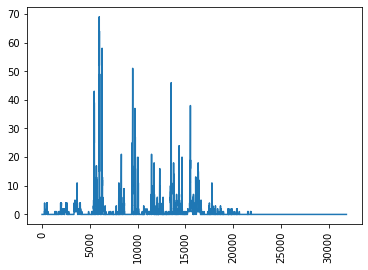

time: 319 ms


In [36]:
plt.plot(wifi_proximity.index.values,wifi_proximity["devices"].apply(len))
plt.xticks(rotation="90")

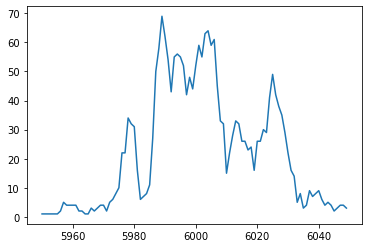

time: 266 ms


In [39]:
plt.plot(wifi_proximity["devices"].apply(len)[5950:6050])


In [6]:
def build_groups(all_scans):
    collapsed = []
    for scan in all_scans:
        l = copy.deepcopy(scan)
        out = []
        while len(l)>0:
            first, *rest = l
            first = set(first)

            lf = -1
            while len(first)>lf:
                lf = len(first)

                rest2 = []
                for r in rest:
                    if len(first.intersection(set(r)))>0:
                        first |= set(r)
                    else:
                        rest2.append(r)     
                rest = rest2

            out.append(first)
            l = rest

        collapsed.append(out)
    return collapsed


time: 13.2 ms


In [3]:
wifi_proximity["groups"] = build_groups(wifi_proximity["devices"])

time: 274 ms


In [141]:
p_list = []
for groups in list(wifi_proximity["groups"]):
    point = 0
    for group in groups:
        if len(set(top_acc_meta_devices["device_id"]).intersection(group)) > 3:
            point = point + len(set(top_acc_meta_devices["device_id"]).intersection(group))
    p_list.append(point)         

time: 195 ms


In [142]:
wifi_proximity["p_list"] = p_list

time: 13.8 ms


In [143]:
wifi_proximity["p_list"].max(), wifi_proximity["p_list"].argmax()

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


(4, 5988)

time: 6.87 ms


In [4]:
counts = []
for x in wifi_proximity["groups"]:
    sum_e = []
    for y in x:
        sum_e = sum_e + list(y)
    counts.append(len(np.unique(sum_e)))  

time: 381 ms


In [5]:
wifi_proximity["count_devices"] = counts

time: 19.8 ms


In [6]:
wifi_proximity[9464:9483]

timestamp                                            devices  \
9464 2018-05-28 12:40:00  [[28, 29], [14, 28, 57], [50, 97], [24, 104], ...   
9465 2018-05-28 12:45:00  [[28, 29], [14, 28, 57], [50, 97], [24, 104], ...   
9466 2018-05-28 12:50:00  [[24, 103], [28, 29], [14, 28, 57], [50, 97], ...   
9467 2018-05-28 12:55:00  [[24, 103], [28, 29], [28, 29, 85, 125], [14, ...   
9468 2018-05-28 13:00:00  [[24, 103], [28, 29], [14, 28, 57], [50, 97], ...   
9469 2018-05-28 13:05:00  [[24, 103], [24, 28, 96], [24, 28, 85, 96], [5...   
9470 2018-05-28 13:10:00  [[24, 103], [24, 28, 96], [24, 28, 85, 96], [3...   
9471 2018-05-28 13:15:00  [[14, 24, 28, 57, 85, 96, 125], [24, 28, 96], ...   
9472 2018-05-28 13:20:00  [[3, 104], [50, 97], [24, 29, 96, 125], [97, 1...   
9473 2018-05-28 13:25:00  [[14, 24, 57], [24, 125], [84, 98], [3, 104], ...   
9474 2018-05-28 13:30:00  [[14, 24, 57], [24, 125], [84, 98], [3, 104], ...   
9475 2018-05-28 13:35:00  [[14, 24, 57], [24, 125], [84, 98], [14, 24, 5...   
9476 2018-05-28 13:40:00  [[14, 24, 57], [24, 125], [84, 98], [14, 24, 5...   
9477 2018-05-28 13:45:00  [[24, 29, 85], [14, 24, 57], [24, 125], [84, 9...   
9478 2018-05-28 13:50:00  [[14, 57, 104], [24, 29, 85], [14, 24, 57], [2...   
9479 2018-05-28 13:55:00  [[48, 81], [24, 29, 85], [14, 24, 57], [84, 98...   
9480 2018-05-28 14:00:00  [[48, 81], [48, 81, 104], [29, 85], [57, 97], ...   
9481 2018-05-28 14:05:00  [[48, 81], [48, 81, 104], [29, 48, 81, 84, 104...   
9482 2018-05-28 14:10:00  [[48, 81], [48, 81, 104], [48, 57, 81, 84], [5...   

                                                 groups  count_devices  
9464  [{85, 57, 28, 29, 14}, {97, 50, 3, 103, 71, 24...             12  
9465  [{85, 57, 28, 29, 14}, {97, 50, 3, 103, 71, 24...             12  
9466  [{97, 50, 3, 71, 103, 24, 104}, {85, 57, 28, 2...             12  
9467  [{97, 50, 3, 71, 103, 24, 104}, {85, 125, 57, ...             13  
9468  [{97, 50, 3, 71, 103, 24, 104}, {85, 125, 57, ...             13  
9469  [{96, 97, 3, 103, 71, 104, 14, 50, 85, 125, 24...             14  
9470  [{96, 97, 3, 103, 104, 71, 14, 50, 85, 125, 24...             14  
9471  [{96, 14, 29, 85, 24, 57, 28, 125}, {97, 50, 3...             14  
9472  [{97, 50, 3, 71, 103, 104}, {96, 14, 85, 125, ...             13  
9473  [{14, 85, 125, 24, 57, 29}, {97, 98, 50, 84, 7...             14  
9474  [{14, 85, 125, 24, 57, 29}, {97, 98, 50, 84, 7...             13  
9475  [{14, 85, 125, 24, 57, 29}, {97, 98, 3, 84, 50...             13  
9476  [{14, 85, 125, 24, 57, 29}, {97, 98, 3, 84, 50...             13  
9477  [{14, 29, 85, 24, 57, 125}, {97, 98, 3, 84, 50...             13  
9478  [{97, 98, 3, 71, 104, 75, 14, 50, 29, 84, 85, ...             14  
9479  [{97, 98, 71, 104, 75, 14, 48, 81, 29, 50, 84,...             15  
9480  [{97, 71, 104, 75, 14, 48, 81, 29, 50, 84, 85,...             14  
9481    [{97, 71, 104, 75, 14, 48, 81, 50, 84, 57, 29}]             11  
9482    [{96, 97, 71, 104, 14, 48, 81, 50, 84, 57, 29}]             11

time: 131 ms


In [470]:
counts = []
for x in wifi_proximity[9464:9483]["groups"]:
    counts = counts + list(x)  

time: 4.37 ms


In [473]:
counts

[{14, 28, 29, 57, 85},
 {3, 24, 50, 71, 97, 103, 104},
 {14, 28, 29, 57, 85},
 {3, 24, 50, 71, 97, 103, 104},
 {3, 24, 50, 71, 97, 103, 104},
 {14, 28, 29, 57, 85},
 {3, 24, 50, 71, 97, 103, 104},
 {14, 28, 29, 57, 85, 125},
 {3, 24, 50, 71, 97, 103, 104},
 {14, 28, 29, 57, 85, 125},
 {3, 14, 24, 28, 29, 50, 57, 71, 85, 96, 97, 103, 104, 125},
 {3, 14, 24, 28, 29, 50, 57, 71, 85, 96, 97, 103, 104, 125},
 {14, 24, 28, 29, 57, 85, 96, 125},
 {3, 50, 71, 97, 103, 104},
 {3, 50, 71, 97, 103, 104},
 {14, 24, 29, 57, 85, 96, 125},
 {14, 24, 29, 57, 85, 125},
 {50, 71, 84, 97, 98, 103},
 {3, 104},
 {14, 24, 29, 57, 85, 125},
 {50, 71, 84, 97, 98},
 {3, 104},
 {14, 24, 29, 57, 85, 125},
 {3, 50, 71, 84, 97, 98, 104},
 {14, 24, 29, 57, 85, 125},
 {3, 50, 71, 84, 97, 98, 104},
 {14, 24, 29, 57, 85, 125},
 {3, 50, 71, 84, 97, 98, 104},
 {3, 14, 24, 29, 50, 57, 71, 75, 84, 85, 97, 98, 104, 125},
 {14, 24, 29, 48, 50, 57, 71, 75, 81, 84, 85, 97, 98, 104, 125},
 {14, 24, 29, 48, 50, 57, 71, 75, 81, 

time: 13 ms


In [138]:
top_acc_meta_devices

_id               timestamp  device_id  double_sensor_maximum_range  \
0     1 2018-03-16 14:56:19.418         23                   156.906403   
1     2 2018-04-25 15:15:52.895         37                   156.906403   
2     3 2018-04-26 13:20:21.243         98                   156.906403   
4     5 2018-04-26 22:57:15.802         38                   156.906403   
8    10 2018-05-08 09:45:48.885         40                    78.453201   
15   19 2018-05-13 20:17:47.279         34                   156.906403   
17   21 2018-05-13 17:40:22.251        115                   156.906403   
40   48 2018-05-15 06:20:53.268         94                   156.906403   
62   81 2018-05-25 04:57:28.804         24                   156.906403   

    double_sensor_minimum_delay           sensor_name  double_sensor_power_ma  \
0                          2500  BMI160 accelerometer                   0.001   
1                          2500  BMI160 accelerometer                   0.001   
2                          2500  BMI160 accelerometer                   0.001   
4                          2500  BMI160 accelerometer                   0.001   
8                          2500  BMI160 accelerometer                   0.000   
15                         2500  BMI160 accelerometer                   0.001   
17                         2500  BMI160 accelerometer                   0.001   
40                         2500  BMI160 accelerometer                   0.001   
62                         2500  BMI160 accelerometer                   0.001   

    double_sensor_resolution  sensor_type sensor_vendor  sensor_version  
0                   0.004788            1         Bosch               1  
1                   0.004788            1         Bosch               1  
2                   0.004788            1         Bosch               1  
4                   0.004788            1         Bosch               1  
8                   0.002394            1         Bosch               1  
15                  0.004788            1         Bosch               1  
17                  0.004788            1         Bosch               1  
40                  0.004788            1         Bosch               1  
62                  0.004788            1         Bosch               1

time: 23.8 ms


In [9]:
data_mag_filtered = data_mag[(data_mag['timestamp'] > "2018-05-16 10:59:00") & (data_mag['timestamp'] < "2018-05-16 11:42:00")]

time: 43.4 s


In [11]:
data_mag_filtered.to_parquet("/data/magnetometer_filtered.parquet.snappy")

time: 1.5 s


In [7]:
data_acc_filtered = data_acc[(data_acc['timestamp'] > "2018-05-16 10:59:00") & (data_acc['timestamp'] < "2018-05-16 11:42:00")]


time: 44.3 s


In [ ]:
data_mag = pd.read_parquet("/data/magnetometer_mapped.parquet.snappy")

In [2]:
data_acc = pd.read_parquet("/data/accelerometer_mapped.parquet.snappy")
wifi_proximity = pd.read_parquet(os.path.join(path_results, "wifi_proximity_20m_captured.gzip"))
wifi_proximity["groups"] = build_groups(wifi_proximity["devices"])

time: 9min 5s


In [8]:
wifi_proximity["groups"] = build_groups(wifi_proximity["devices"])

time: 319 ms


In [24]:
data_acc = data_acc[data_acc['device_id'].notnull()]
data_acc['device_id'] = data_acc['device_id'].astype(int)

time: 10min 17s


/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
data_acc.head()

_id               timestamp  device_id  double_values_0  \
0  92018860 2018-05-14 19:48:42.920         99         0.047884   
1  92018861 2018-05-14 19:48:43.121         99         0.004788   
2  92018862 2018-05-14 19:48:43.321         99         0.000000   
3  92018863 2018-05-14 19:48:43.522         99         0.009577   
4  92018864 2018-05-14 19:48:43.722         99        -0.038307   

   double_values_1  double_values_2  accuracy  label  
0         0.225055         9.840169         3    NaN  
1         0.201113         9.825804         3    NaN  
2         0.201113         9.830592         3    NaN  
3         0.167594         9.844957         3    NaN  
4         0.186748         9.859323         3    NaN

time: 27.3 ms


In [26]:
data_acc.to_parquet("/data/accelerometer_mapped.parquet.snappy")

time: 4min 39s


In [11]:
acc_meta = b2s(pd.read_parquet(os.path.join(path_data_collection, "sensor_accelerometer.parquet.snappy")))
acc_meta['device_id'].replace(device_id_mappings, inplace = True)
mag_meta = b2s(pd.read_parquet(os.path.join(path_data_collection, "sensor_magnetometer.parquet.snappy")))
mag_meta['device_id'].replace(device_id_mappings, inplace = True)
v,c = np.unique(mag_meta['sensor_vendor'], return_counts = True)
c_sort_i = np.argsort(c)
v = v[c_sort_i]
c = c[c_sort_i]
top_sensor_vender_mag = v[::-1]
v,c = np.unique(mag_meta['sensor_name'], return_counts = True)
c_sort_i = np.argsort(c)
v = v[c_sort_i]
c = c[c_sort_i]
top_sensor_device_mag = v[::-1]
v,c = np.unique(acc_meta['sensor_vendor'], return_counts = True)
c_sort_i = np.argsort(c)
v = v[c_sort_i]
c = c[c_sort_i]
top_sensor_vender_acc = v[::-1]
v,c = np.unique(acc_meta['sensor_name'], return_counts = True)
c_sort_i = np.argsort(c)
v = v[c_sort_i]
c = c[c_sort_i]
top_sensor_device_acc = v[::-1]





time: 96.6 ms


In [12]:
mag_meta_filtered_name_df = mag_meta[mag_meta['sensor_name'] == top_sensor_device_mag[0]]
mag_meta_filtered_vendor_df = mag_meta[mag_meta['sensor_vendor'] == top_sensor_vender_mag[0]]
acc_meta_filtered_name_df = acc_meta[acc_meta['sensor_name'] == top_sensor_device_acc[0]]
acc_meta_filtered_vendor_df = acc_meta[acc_meta['sensor_vendor'] == top_sensor_vender_acc[0]]


time: 13.3 ms


In [13]:
mag_meta_filtered_name_df_2 = mag_meta[mag_meta['sensor_name'] == top_sensor_device_mag[1]]
mag_meta_filtered_vendor_df_2 = mag_meta[mag_meta['sensor_vendor'] == top_sensor_vender_mag[1]]
acc_meta_filtered_name_df_2 = acc_meta[acc_meta['sensor_name'] == top_sensor_device_acc[1]]
acc_meta_filtered_vendor_df_2 = acc_meta[acc_meta['sensor_vendor'] == top_sensor_vender_acc[1]]


time: 12 ms


In [14]:
mag_meta_filtered_name_df_3 = mag_meta[mag_meta['sensor_name'] == top_sensor_device_mag[2]]
mag_meta_filtered_vendor_df_3 = mag_meta[mag_meta['sensor_vendor'] == top_sensor_vender_mag[2]]
acc_meta_filtered_name_df_3 = acc_meta[acc_meta['sensor_name'] == top_sensor_device_acc[2]]
acc_meta_filtered_vendor_df_3 = acc_meta[acc_meta['sensor_vendor'] == top_sensor_vender_acc[2]]


time: 10.1 ms


In [15]:
mag_meta_filtered_name = mag_meta_filtered_name_df['device_id']
mag_meta_filtered_vendor = mag_meta_filtered_vendor_df['device_id']
acc_meta_filtered_name = acc_meta_filtered_name_df['device_id']
acc_meta_filtered_vendor = acc_meta_filtered_vendor_df['device_id']


time: 1.59 ms


In [16]:
mag_meta_filtered_name_2 = mag_meta_filtered_name_df_2['device_id']
mag_meta_filtered_vendor_2 = mag_meta_filtered_vendor_df_2['device_id']
acc_meta_filtered_name_2 = acc_meta_filtered_name_df_2['device_id']
acc_meta_filtered_vendor_2 = acc_meta_filtered_vendor_df_2['device_id']


time: 2.95 ms


In [17]:
mag_meta_filtered_name_3 = mag_meta_filtered_name_df_3['device_id']
mag_meta_filtered_vendor_3 = mag_meta_filtered_vendor_df_3['device_id']
acc_meta_filtered_name_3 = acc_meta_filtered_name_df_3['device_id']
acc_meta_filtered_vendor_3 = acc_meta_filtered_vendor_df_3['device_id']


time: 2.17 ms


In [3]:
wifi_proximity["groups"] = build_groups(wifi_proximity["devices"])

time: 369 ms


In [19]:
p_list = []
same_group_list = []
for groups in list(wifi_proximity["groups"]):
    point = 0
    group_vendor = []
    for group in groups:
        x = set(acc_meta_filtered_vendor).intersection(group)
        if len(x) > 1:
            point = point + len(x)
            group_vendor = group_vendor + list(x)
    p_list.append(point)
    same_group_list.append(group_vendor)

time: 174 ms


In [549]:
wifi_proximity["p_list"] = p_list
wifi_proximity["p_group"] = same_group_list
wifi_proximity["p_list"].max(), wifi_proximity["p_list"][9283:].argmax()

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


(8, 9742)

time: 83.5 ms


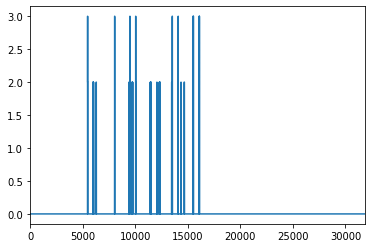

time: 481 ms


In [130]:

wifi_proximity["p_list"].plot()

<IPython.core.display.Javascript object>


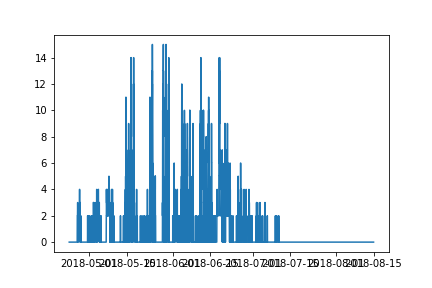

time: 241 ms


In [676]:
%matplotlib inline


time: 8.33 ms


               timestamp devices groups  p_list p_group  count_devices
5856 2018-05-16 00:00:00      []     []       0      []              0
5857 2018-05-16 00:05:00      []     []       0      []              0
5858 2018-05-16 00:10:00      []     []       0      []              0
5859 2018-05-16 00:15:00      []     []       0      []              0
5860 2018-05-16 00:20:00      []     []       0      []              0
...                  ...     ...    ...     ...     ...            ...
6139 2018-05-16 23:35:00      []     []       0      []              0
6140 2018-05-16 23:40:00      []     []       0      []              0
6141 2018-05-16 23:45:00      []     []       0      []              0
6142 2018-05-16 23:50:00      []     []       0      []              0
6143 2018-05-16 23:55:00      []     []       0      []              0

[288 rows x 6 columns]


<IPython.core.display.Javascript object>


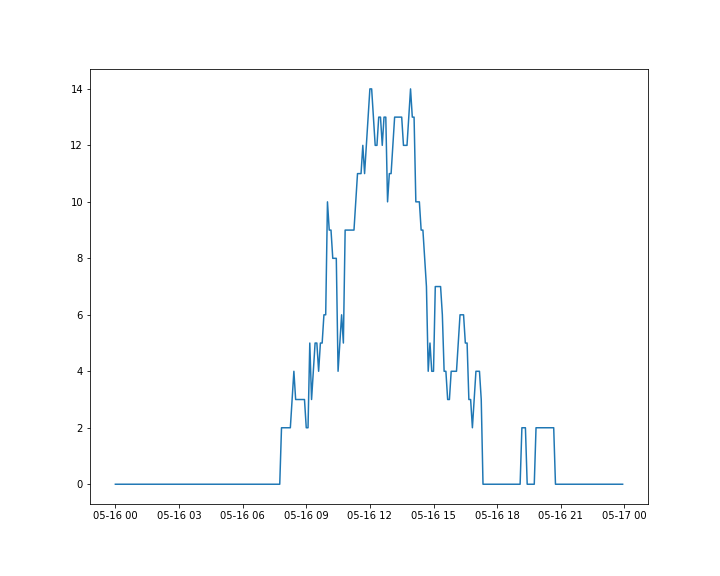

time: 80.9 ms


### Magnetometer - Same vendor ###

####  Group 1 ####

In [69]:
start = "2018-06-18 14:10:00"
end = "2018-06-18 15:00:00"


start_np = "2018-06-18 15:15:00"
end_np = "2018-06-18 16:00:00"

focus_on = [96, 97, 98, 36, 14, 84, 24]

data_mag_filtered = data_mag[(data_mag['timestamp'] >= start) & (data_mag['timestamp'] <= end)]
data_mag_filtered_np = data_mag[(data_mag['timestamp'] >= start_np) & (data_mag['timestamp'] <= end_np)]
df_0 = aggregate_signals(data_mag_filtered, ["double_values_0"], "1min", [start, end], list(focus_on))
df_np_0 = aggregate_signals(data_mag_filtered_np, ["double_values_0"], "1min", [start_np, end_np], list(focus_on))
df_1 = aggregate_signals(data_mag_filtered, ["double_values_1"], "1min", [start, end], list(focus_on))
df_np_1 = aggregate_signals(data_mag_filtered_np, ["double_values_1"], "1min", [start_np, end_np], list(focus_on))
df_2 = aggregate_signals(data_mag_filtered, ["double_values_2"], "1min", [start, end], list(focus_on))
df_np_2 = aggregate_signals(data_mag_filtered_np, ["double_values_2"], "1min", [start_np, end_np], list(focus_on))

time: 10.1 s


             comb    cosine
0  (dev96, dev97)  1.388696
1  (dev96, dev98)  0.895474
2  (dev96, dev36)  1.984423
3  (dev96, dev24)  0.739453
4  (dev97, dev98)  1.204163
5  (dev97, dev36)  1.226613
6  (dev97, dev24)  1.255044
7  (dev98, dev36)  0.071006
8  (dev98, dev24)  1.429344
9  (dev36, dev24)  1.433830
-----------------------------------------------
             comb    cosine
0  (dev96, dev97)  0.152463
1  (dev96, dev98)  0.101433
2  (dev96, dev36)  0.266084
3  (dev96, dev24)  0.119029
4  (dev97, dev98)  0.219705
5  (dev97, dev36)  0.095430
6  (dev97, dev24)  0.189951
7  (dev98, dev36)  0.166317
8  (dev98, dev24)  0.111385
9  (dev36, dev24)  0.157274
-----------------------------------------------
             comb     distance
0  (dev96, dev97)  1250.033798
1  (dev96, dev98)   445.562183
2  (dev96, dev36)   715.024218
3  (dev96, dev24)   799.986386
4  (dev97, dev98)  1194.393384
5  (dev97, dev36)  1151.217446
6  (dev97, dev24)  1082.416559
7  (dev98, dev36)   290.845198
8  (dev98

dev96     dev97     dev98     dev36     dev24
dev96  1.000000 -0.376213  0.308225  0.061115  0.247536
dev97 -0.376213  1.000000 -0.314969  0.666625 -0.327297
dev98  0.308225 -0.314969  1.000000  0.450394  0.344588
dev36  0.061115  0.666625  0.450394  1.000000  0.366480
dev24  0.247536 -0.327297  0.344588  0.366480  1.000000

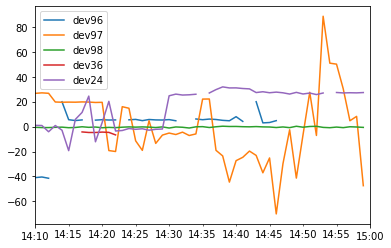

time: 694 ms


In [70]:
df_0.plot()
print(cosine_dist(df_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_0))
print("-----------------------------------------------")
print(fast_dtw(df_0))
print("-----------------------------------------------")
df_0.corr()

             comb    cosine
0  (dev96, dev97)  1.241409
1  (dev96, dev98)  0.426693
2  (dev96, dev36)  0.077958
3  (dev96, dev24)  1.652322
4  (dev97, dev98)  1.162648
5  (dev97, dev36)  1.957297
6  (dev97, dev24)  1.026679
7  (dev98, dev36)  0.065329
8  (dev98, dev24)  1.840182
9  (dev36, dev24)  1.815019
-----------------------------------------------
             comb    cosine
0  (dev96, dev97)  0.135940
1  (dev96, dev98)  0.214672
2  (dev96, dev36)  0.536176
3  (dev96, dev24)  0.251830
4  (dev97, dev98)  0.136296
5  (dev97, dev36)  0.961054
6  (dev97, dev24)  0.164212
7  (dev98, dev36)  0.650714
8  (dev98, dev24)  0.168156
9  (dev36, dev24)  0.574710
-----------------------------------------------
             comb     distance
0  (dev96, dev97)  1006.709824
1  (dev96, dev98)  1325.281323
2  (dev96, dev36)   612.948965
3  (dev96, dev24)  2320.755711
4  (dev97, dev98)  2433.339405
5  (dev97, dev36)  1806.775057
6  (dev97, dev24)  2102.420760
7  (dev98, dev36)  1545.495340
8  (dev98

dev96     dev97     dev98     dev36     dev24
dev96  1.000000  0.107322  0.110886  0.166208 -0.409270
dev97  0.107322  1.000000  0.013667 -0.628228 -0.313381
dev98  0.110886  0.013667  1.000000  0.015210 -0.210282
dev36  0.166208 -0.628228  0.015210  1.000000  0.061897
dev24 -0.409270 -0.313381 -0.210282  0.061897  1.000000

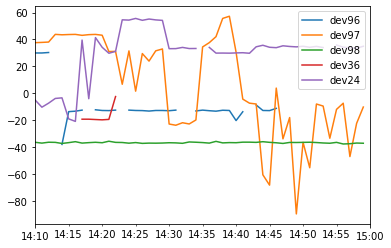

time: 725 ms


In [71]:
df_1.plot()
print(cosine_dist(df_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_1))
print("-----------------------------------------------")
print(fast_dtw(df_1))
print("-----------------------------------------------")
df_1.corr()

             comb    cosine
0  (dev96, dev97)  1.156046
1  (dev96, dev98)  1.559657
2  (dev96, dev36)  1.598961
3  (dev96, dev24)  1.412586
4  (dev97, dev98)  0.556185
5  (dev97, dev36)  0.294026
6  (dev97, dev24)  0.653990
7  (dev98, dev36)  0.330020
8  (dev98, dev24)  0.093681
9  (dev36, dev24)  0.544943
-----------------------------------------------
             comb    cosine
0  (dev96, dev97)  0.174705
1  (dev96, dev98)  0.181614
2  (dev96, dev36)  0.082867
3  (dev96, dev24)  0.350808
4  (dev97, dev98)  0.259996
5  (dev97, dev36)  0.305028
6  (dev97, dev24)  0.585842
7  (dev98, dev36)  0.437753
8  (dev98, dev24)  0.335862
9  (dev36, dev24)  0.382301
-----------------------------------------------
             comb     distance
0  (dev96, dev97)  1589.402237
1  (dev96, dev98)  3899.087024
2  (dev96, dev36)   710.629210
3  (dev96, dev24)  2569.564437
4  (dev97, dev98)  1605.941953
5  (dev97, dev36)  1298.678044
6  (dev97, dev24)  1584.701500
7  (dev98, dev36)  3424.677796
8  (dev98

dev96     dev97     dev98     dev36     dev24
dev96  1.000000  0.362359 -0.050190  0.917846  0.111860
dev97  0.362359  1.000000 -0.048529  0.609285 -0.215480
dev98 -0.050190 -0.048529  1.000000  0.427422  0.164946
dev36  0.917846  0.609285  0.427422  1.000000  0.550080
dev24  0.111860 -0.215480  0.164946  0.550080  1.000000

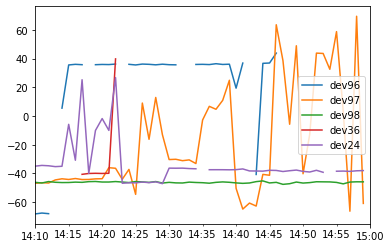

time: 692 ms


In [73]:
df_2.plot()
print(cosine_dist(df_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_2))
print("-----------------------------------------------")
print(fast_dtw(df_2))
print("-----------------------------------------------")
df_2.corr()

             comb    cosine
0  (dev96, dev97)  0.925690
1  (dev96, dev98)  1.192612
2  (dev96, dev24)  1.094226
3  (dev97, dev98)  0.931031
4  (dev97, dev24)  1.454176
5  (dev98, dev24)  0.813144
-----------------------------------------------
             comb    cosine
0  (dev96, dev97)  0.363544
1  (dev96, dev98)  0.244744
2  (dev96, dev24)  0.679408
3  (dev97, dev98)  0.131913
4  (dev97, dev24)  0.367392
5  (dev98, dev24)  0.230298
-----------------------------------------------
             comb     distance
0  (dev96, dev97)  3271.443062
1  (dev96, dev98)  4212.496912
2  (dev96, dev24)  4185.199386
3  (dev97, dev98)   613.670769
4  (dev97, dev24)   812.829451
5  (dev98, dev24)   539.462520
-----------------------------------------------


dev96     dev97     dev98     dev24
dev96  1.000000  0.402887  0.659983  0.000818
dev97  0.402887  1.000000  0.091400 -0.520025
dev98  0.659983  0.091400  1.000000 -0.049872
dev24  0.000818 -0.520025 -0.049872  1.000000

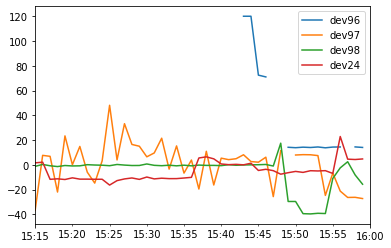

time: 496 ms


In [74]:
df_np_0.plot()
print(cosine_dist(df_np_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_0))
print("-----------------------------------------------")
print(fast_dtw(df_np_0))
print("-----------------------------------------------")
df_np_0.corr()

             comb    cosine
0  (dev96, dev97)  1.710672
1  (dev96, dev98)  0.383875
2  (dev96, dev24)  1.764173
3  (dev97, dev98)  1.206755
4  (dev97, dev24)  0.793891
5  (dev98, dev24)  1.875048
-----------------------------------------------
             comb    cosine
0  (dev96, dev97)  0.421180
1  (dev96, dev98)  0.328165
2  (dev96, dev24)  0.011391
3  (dev97, dev98)  0.162418
4  (dev97, dev24)  0.084366
5  (dev98, dev24)  0.132333
-----------------------------------------------
             comb     distance
0  (dev96, dev97)  1433.089111
1  (dev96, dev98)   425.959486
2  (dev96, dev24)  3530.271516
3  (dev97, dev98)  1572.717200
4  (dev97, dev24)  1425.354071
5  (dev98, dev24)  3840.900154
-----------------------------------------------


dev96     dev97     dev98     dev24
dev96  1.000000 -0.855777 -0.028369  0.927143
dev97 -0.855777  1.000000  0.000272 -0.144494
dev98 -0.028369  0.000272  1.000000  0.032337
dev24  0.927143 -0.144494  0.032337  1.000000

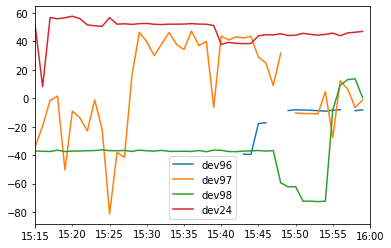

time: 506 ms


In [75]:
df_np_1.plot()
print(cosine_dist(df_np_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_1))
print("-----------------------------------------------")
print(fast_dtw(df_np_1))
print("-----------------------------------------------")
df_np_1.corr()

             comb    cosine
0  (dev96, dev97)  0.682141
1  (dev96, dev98)  0.976485
2  (dev96, dev24)  0.121446
3  (dev97, dev98)  1.298649
4  (dev97, dev24)  1.083394
5  (dev98, dev24)  0.517962
-----------------------------------------------
             comb    cosine
0  (dev96, dev97)  0.489039
1  (dev96, dev98)  0.222328
2  (dev96, dev24)  0.339926
3  (dev97, dev98)  0.748284
4  (dev97, dev24)  0.140120
5  (dev98, dev24)  0.542432
-----------------------------------------------
             comb     distance
0  (dev96, dev97)  4245.691566
1  (dev96, dev98)  3163.535580
2  (dev96, dev24)  2227.342465
3  (dev97, dev98)  2356.646596
4  (dev97, dev24)  1938.041232
5  (dev98, dev24)  1062.925025
-----------------------------------------------


dev96     dev97     dev98     dev24
dev96  1.000000 -0.736966  0.465300  0.061806
dev97 -0.736966  1.000000 -0.291542  0.325439
dev98  0.465300 -0.291542  1.000000 -0.066348
dev24  0.061806  0.325439 -0.066348  1.000000

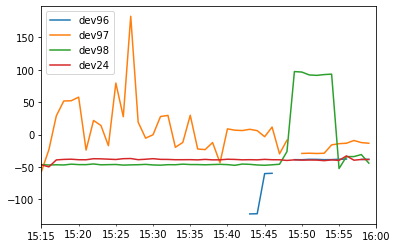

time: 481 ms


In [76]:
df_np_2.plot()
print(cosine_dist(df_np_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_2))
print("-----------------------------------------------")
print(fast_dtw(df_np_2))
print("-----------------------------------------------")
df_np_2.corr()

(array([3., 2., 2., 2., 1., 1., 0., 2., 2., 3.]),
 array([ 425.95948603,  807.93269407, 1189.90590212, 1571.87911016,
        1953.8523182 , 2335.82552625, 2717.79873429, 3099.77194234,
        3481.74515038, 3863.71835842, 4245.69156647]),
 <a list of 10 Patch objects>)

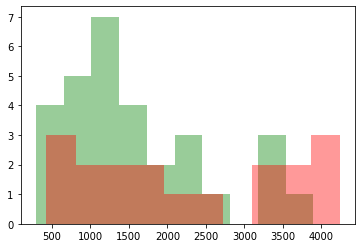

time: 1.23 s


In [77]:
all_in_proximity = list(fast_dtw(df_0)['distance']) + list(fast_dtw(df_1)['distance']) + list(fast_dtw(df_2)['distance'])
all_not_in_proximity = list(fast_dtw(df_np_0)['distance']) + list(fast_dtw(df_np_1)['distance']) + list(fast_dtw(df_np_2)['distance'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)

(array([2., 3., 3., 1., 4., 1., 1., 1., 0., 2.]),
 array([0.01139124, 0.08508054, 0.15876984, 0.23245914, 0.30614844,
        0.37983774, 0.45352704, 0.52721634, 0.60090564, 0.67459493,
        0.74828423]),
 <a list of 10 Patch objects>)

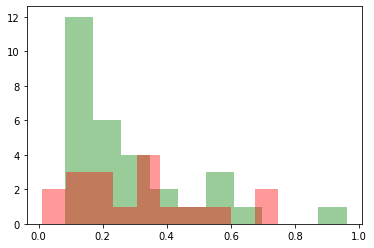

time: 472 ms


In [78]:
all_in_proximity = list(cosine_dist_normalized(df_0)['cosine']) + list(cosine_dist_normalized(df_1)['cosine']) + list(cosine_dist_normalized(df_2)['cosine'])
all_not_in_proximity = list(cosine_dist_normalized(df_np_0)['cosine']) + list(cosine_dist_normalized(df_np_1)['cosine']) + list(cosine_dist_normalized(df_np_2)['cosine'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)


#### Group 2 ####

In [84]:
start = "2018-05-13 16:30:00"
end = "2018-05-13 17:10:00"


start_np = "2018-05-13 17:20:00"
end_np = "2018-05-13 18:00:00"

focus_on = [74, 44]

data_mag_filtered = data_mag[(data_mag['timestamp'] >= start) & (data_mag['timestamp'] <= end)]
data_mag_filtered_np = data_mag[(data_mag['timestamp'] >= start_np) & (data_mag['timestamp'] <= end_np)]
df_0 = aggregate_signals(data_mag_filtered, ["double_values_0"], "1min", [start, end], list(focus_on))
df_np_0 = aggregate_signals(data_mag_filtered_np, ["double_values_0"], "1min", [start_np, end_np], list(focus_on))
df_1 = aggregate_signals(data_mag_filtered, ["double_values_1"], "1min", [start, end], list(focus_on))
df_np_1 = aggregate_signals(data_mag_filtered_np, ["double_values_1"], "1min", [start_np, end_np], list(focus_on))
df_2 = aggregate_signals(data_mag_filtered, ["double_values_2"], "1min", [start, end], list(focus_on))
df_np_2 = aggregate_signals(data_mag_filtered_np, ["double_values_2"], "1min", [start_np, end_np], list(focus_on))



time: 6.68 s


In [85]:
df_0.head()

Empty DataFrame
Columns: []
Index: [2018-05-13 16:30:00, 2018-05-13 16:31:00, 2018-05-13 16:32:00, 2018-05-13 16:33:00, 2018-05-13 16:34:00]

time: 18.4 ms


In [86]:
df_0.plot()
print(cosine_dist(df_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_0))
print("-----------------------------------------------")
print(fast_dtw(df_0))
print("-----------------------------------------------")
df_0.corr()

TypeError: no numeric data to plot

time: 164 ms


Empty DataFrame
Columns: [comb, cosine]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, cosine]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, distance]
Index: []
-----------------------------------------------


dev44
dev44    1.0

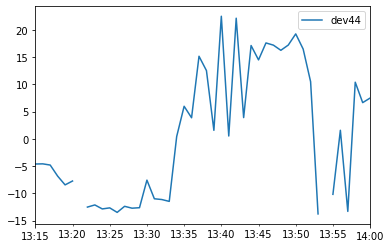

time: 300 ms


In [34]:
df_1.plot()
print(cosine_dist(df_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_1))
print("-----------------------------------------------")
print(fast_dtw(df_1))
print("-----------------------------------------------")
df_1.corr()

In [ ]:
df_2.plot()
print(cosine_dist(df_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_2))
print("-----------------------------------------------")
print(fast_dtw(df_2))
print("-----------------------------------------------")
df_2.corr()

In [ ]:
df_np_0.plot()
print(cosine_dist(df_np_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_0))
print("-----------------------------------------------")
print(fast_dtw(df_np_0))
print("-----------------------------------------------")
df_np_0.corr()

In [ ]:
df_np_1.plot()
print(cosine_dist(df_np_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_1))
print("-----------------------------------------------")
print(fast_dtw(df_np_1))
print("-----------------------------------------------")
df_np_1.corr()

             comb    cosine
0  (dev69, dev96)  0.365350
1  (dev69, dev43)  1.631853
2  (dev69, dev97)  1.631997
3  (dev96, dev43)  1.507740
4  (dev96, dev97)  1.758522
5  (dev43, dev97)  0.418306
-----------------------------------------------
             comb    cosine
0  (dev69, dev96)  0.134313
1  (dev69, dev43)  0.515671
2  (dev69, dev97)  0.427039
3  (dev96, dev43)  0.442462
4  (dev96, dev97)  0.512892
5  (dev43, dev97)  0.139976
-----------------------------------------------
             comb     distance
0  (dev69, dev96)   523.382797
1  (dev69, dev43)   670.318535
2  (dev69, dev97)   948.994446
3  (dev96, dev43)  1145.280930
4  (dev96, dev97)  1093.975830
5  (dev43, dev97)   394.547279
-----------------------------------------------
             comb    cosine
0  (dev69, dev96)  1.135125
1  (dev69, dev43)  1.708880
2  (dev69, dev97)  1.850899
3  (dev96, dev43)  1.028542
4  (dev96, dev97)  0.722376
5  (dev43, dev97)  0.313767
-----------------------------------------------
   

NameError: name 'df' is not defined

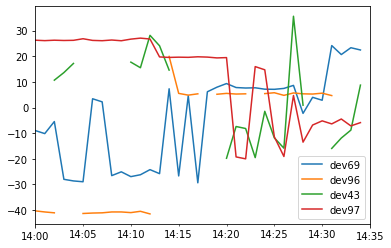

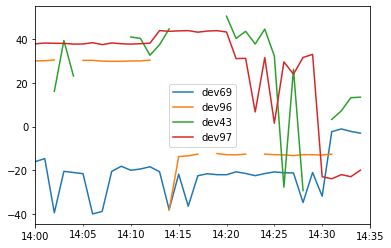

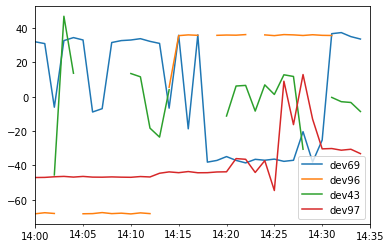

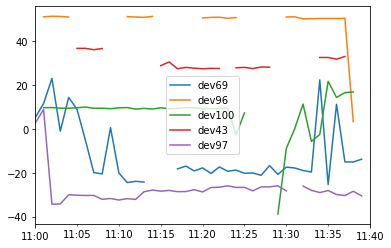

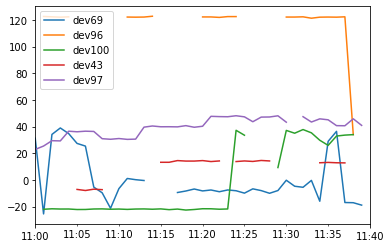

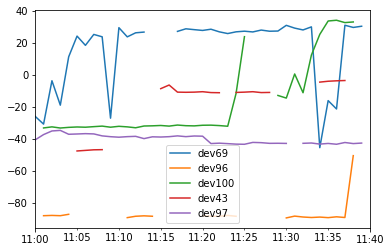

time: 2.96 s


In [30]:
df_np_2.plot()
print(cosine_dist(df_np_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_2))
print("-----------------------------------------------")
print(fast_dtw(df_np_2))
print("-----------------------------------------------")
df_np_2.corr()
print("-----------------------------------------------")

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

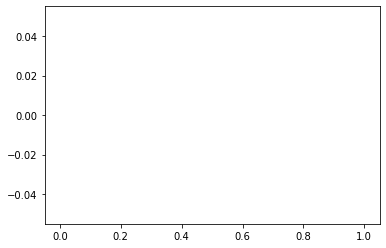

time: 340 ms


In [43]:
all_in_proximity = list(fast_dtw(df_0)['distance']) + list(fast_dtw(df_1)['distance']) + list(fast_dtw(df_2)['distance'])
all_not_in_proximity = list(fast_dtw(df_np_0)['distance']) + list(fast_dtw(df_np_1)['distance']) + list(fast_dtw(df_np_2)['distance'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

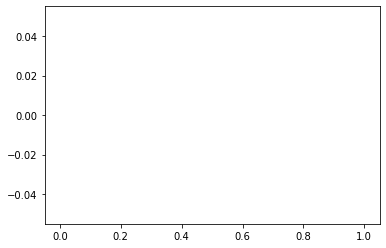

time: 286 ms


In [44]:
all_in_proximity = list(cosine_dist_normalized(df_0)['cosine']) + list(cosine_dist_normalized(df_1)['cosine']) + list(cosine_dist_normalized(df_2)['cosine'])
all_not_in_proximity = list(cosine_dist_normalized(df_np_0)['cosine']) + list(cosine_dist_normalized(df_np_1)['cosine']) + list(cosine_dist_normalized(df_np_2)['cosine'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)


#### Group 3 ####

In [106]:
start = "2018-05-17 10:30:00"
end = "2018-05-17 10:45:00"


start_np = "2018-05-17 10:50:00"
end_np = "2018-05-17 11:10:00"

focus_on = [81, 89]

data_mag_filtered = data_mag[(data_mag['timestamp'] >= start) & (data_mag['timestamp'] <= end)]
data_mag_filtered_np = data_mag[(data_mag['timestamp'] >= start_np) & (data_mag['timestamp'] <= end_np)]
df_0 = aggregate_signals(data_mag_filtered, ["double_values_0"], "1min", [start, end], list(focus_on))
df_np_0 = aggregate_signals(data_mag_filtered_np, ["double_values_0"], "1min", [start_np, end_np], list(focus_on))
df_1 = aggregate_signals(data_mag_filtered, ["double_values_1"], "1min", [start, end], list(focus_on))
df_np_1 = aggregate_signals(data_mag_filtered_np, ["double_values_1"], "1min", [start_np, end_np], list(focus_on))
df_2 = aggregate_signals(data_mag_filtered, ["double_values_2"], "1min", [start, end], list(focus_on))
df_np_2 = aggregate_signals(data_mag_filtered_np, ["double_values_2"], "1min", [start_np, end_np], list(focus_on))



time: 13.6 s


Empty DataFrame
Columns: [comb, cosine]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, cosine]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, distance]
Index: []
-----------------------------------------------


dev89
dev89    1.0

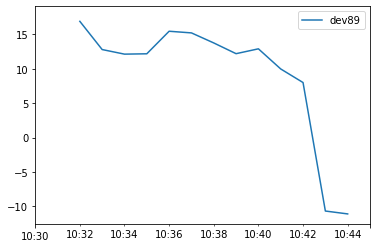

time: 379 ms


In [107]:
df_0.plot()
print(cosine_dist(df_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_0))
print("-----------------------------------------------")
print(fast_dtw(df_0))
print("-----------------------------------------------")
df_0.corr()

Empty DataFrame
Columns: [comb, cosine]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, cosine]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, distance]
Index: []
-----------------------------------------------


dev89
dev89    1.0

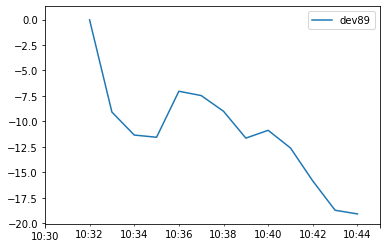

time: 319 ms


In [108]:
df_1.plot()
print(cosine_dist(df_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_1))
print("-----------------------------------------------")
print(fast_dtw(df_1))
print("-----------------------------------------------")
df_1.corr()

Empty DataFrame
Columns: [comb, cosine]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, cosine]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, distance]
Index: []
-----------------------------------------------


dev89
dev89    1.0

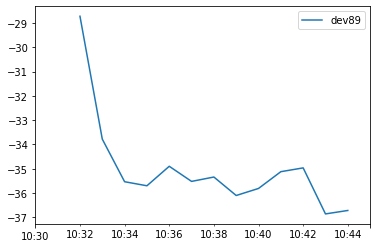

time: 448 ms


In [109]:
df_2.plot()
print(cosine_dist(df_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_2))
print("-----------------------------------------------")
print(fast_dtw(df_2))
print("-----------------------------------------------")
df_2.corr()

Empty DataFrame
Columns: [comb, cosine]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, cosine]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, distance]
Index: []
-----------------------------------------------


dev89
dev89    1.0

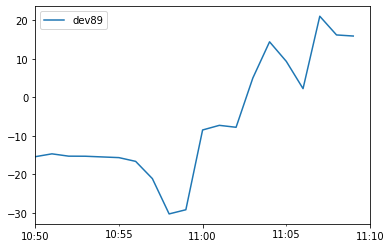

time: 214 ms


In [110]:
df_np_0.plot()
print(cosine_dist(df_np_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_0))
print("-----------------------------------------------")
print(fast_dtw(df_np_0))
print("-----------------------------------------------")
df_np_0.corr()

Empty DataFrame
Columns: [comb, cosine]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, cosine]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, distance]
Index: []
-----------------------------------------------


dev89
dev89    1.0

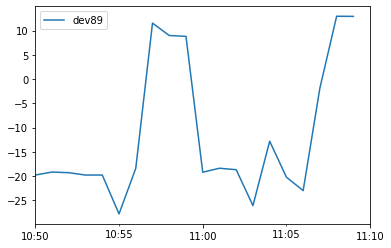

time: 218 ms


In [111]:
df_np_1.plot()
print(cosine_dist(df_np_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_1))
print("-----------------------------------------------")
print(fast_dtw(df_np_1))
print("-----------------------------------------------")
df_np_1.corr()

In [ ]:
df_np_2.plot()
print(cosine_dist(df_np_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_2))
print("-----------------------------------------------")
print(fast_dtw(df_np_2))
print("-----------------------------------------------")
df_np_2.corr()

In [ ]:
all_in_proximity = list(fast_dtw(df_0)['distance']) + list(fast_dtw(df_1)['distance']) + list(fast_dtw(df_2)['distance'])
all_not_in_proximity = list(fast_dtw(df_np_0)['distance']) + list(fast_dtw(df_np_1)['distance']) + list(fast_dtw(df_np_2)['distance'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)

In [ ]:
all_in_proximity = list(cosine_dist_normalized(df_0)['cosine']) + list(cosine_dist_normalized(df_1)['cosine']) + list(cosine_dist_normalized(df_2)['cosine'])
all_not_in_proximity = list(cosine_dist_normalized(df_np_0)['cosine']) + list(cosine_dist_normalized(df_np_1)['cosine']) + list(cosine_dist_normalized(df_np_2)['cosine'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)


### Accelerometer - Same vendor ###

#### Group 1 ####

In [24]:
start = "2018-06-11 13:55:00"
end = "2018-06-11 15:10:00"


start_np = "2018-06-11 12:10:00"
end_np = "2018-06-11 13:00:00"

focus_on = [48, 36, 60]

data_acc_filtered = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
data_acc_filtered_np = data_acc[(data_acc['timestamp'] >= start_np) & (data_acc['timestamp'] <= end_np)]
df_0 = aggregate_signals(data_acc_filtered, ["double_values_0"], "1min", [start, end], list(focus_on))
df_np_0 = aggregate_signals(data_acc_filtered_np, ["double_values_0"], "1min", [start_np, end_np], list(focus_on))
df_1 = aggregate_signals(data_acc_filtered, ["double_values_1"], "1min", [start, end], list(focus_on))
df_np_1 = aggregate_signals(data_acc_filtered_np, ["double_values_1"], "1min", [start_np, end_np], list(focus_on))
df_2 = aggregate_signals(data_acc_filtered, ["double_values_2"], "1min", [start, end], list(focus_on))
df_np_2 = aggregate_signals(data_acc_filtered_np, ["double_values_2"], "1min", [start_np, end_np], list(focus_on))

time: 22.8 s


             comb    cosine
0  (dev36, dev60)  0.949659
-----------------------------------------------
             comb    cosine
0  (dev36, dev60)  0.125752
-----------------------------------------------
             comb   distance
0  (dev36, dev60)  97.622488
-----------------------------------------------


dev36     dev60
dev36  1.000000  0.056634
dev60  0.056634  1.000000

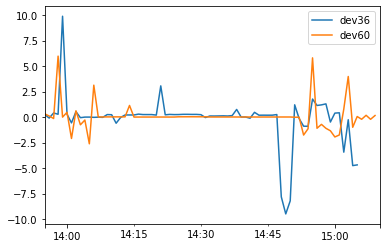

time: 344 ms


In [25]:
df_0.plot()
print(cosine_dist(df_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_0))
print("-----------------------------------------------")
print(fast_dtw(df_0))
print("-----------------------------------------------")
df_0.corr()

             comb    cosine
0  (dev36, dev60)  0.437962
-----------------------------------------------
             comb    cosine
0  (dev36, dev60)  0.062372
-----------------------------------------------
             comb   distance
0  (dev36, dev60)  159.19269
-----------------------------------------------


dev36     dev60
dev36  1.000000  0.551167
dev60  0.551167  1.000000

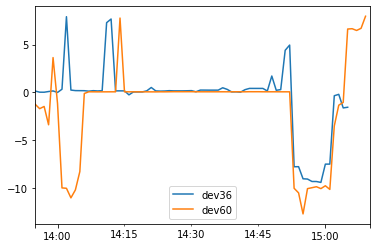

time: 997 ms


In [138]:
df_1.plot()
print(cosine_dist(df_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_1))
print("-----------------------------------------------")
print(fast_dtw(df_1))
print("-----------------------------------------------")
df_1.corr()

             comb    cosine
0  (dev36, dev60)  0.426053
-----------------------------------------------
             comb    cosine
0  (dev36, dev60)  0.111689
-----------------------------------------------
             comb    distance
0  (dev36, dev60)  184.185341
-----------------------------------------------


dev36    dev60
dev36  1.00000  0.23834
dev60  0.23834  1.00000

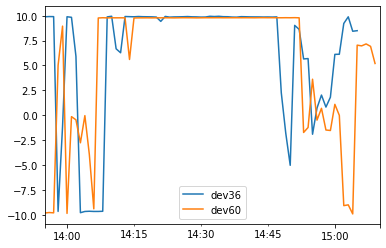

time: 4.35 s


In [139]:
df_2.plot()
print(cosine_dist(df_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_2))
print("-----------------------------------------------")
print(fast_dtw(df_2))
print("-----------------------------------------------")
df_2.corr()

             comb    cosine
0  (dev36, dev60)  0.870004
-----------------------------------------------
             comb  cosine
0  (dev36, dev60)   0.173
-----------------------------------------------
             comb    distance
0  (dev36, dev60)  119.486405
-----------------------------------------------


dev36    dev60
dev36  1.00000  0.27745
dev60  0.27745  1.00000

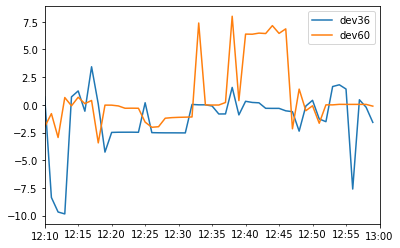

time: 602 ms


In [140]:
df_np_0.plot()
print(cosine_dist(df_np_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_0))
print("-----------------------------------------------")
print(fast_dtw(df_np_0))
print("-----------------------------------------------")
df_np_0.corr()

             comb    cosine
0  (dev36, dev60)  1.197813
-----------------------------------------------
             comb    cosine
0  (dev36, dev60)  0.289914
-----------------------------------------------
             comb    distance
0  (dev36, dev60)  235.077981
-----------------------------------------------


dev36    dev60
dev36  1.00000 -0.24109
dev60 -0.24109  1.00000

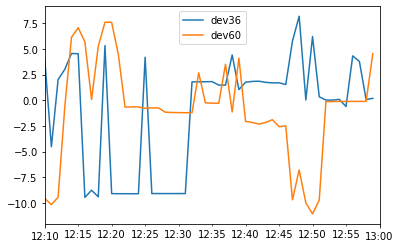

time: 452 ms


In [141]:
df_np_1.plot()
print(cosine_dist(df_np_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_1))
print("-----------------------------------------------")
print(fast_dtw(df_np_1))
print("-----------------------------------------------")
df_np_1.corr()

             comb    cosine
0  (dev36, dev60)  0.885879
-----------------------------------------------
             comb    cosine
0  (dev36, dev60)  0.258726
-----------------------------------------------
             comb    distance
0  (dev36, dev60)  146.437905
-----------------------------------------------


dev36     dev60
dev36  1.000000 -0.432441
dev60 -0.432441  1.000000

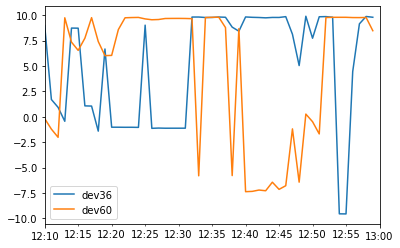

time: 465 ms


In [142]:
df_np_2.plot()
print(cosine_dist(df_np_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_2))
print("-----------------------------------------------")
print(fast_dtw(df_np_2))
print("-----------------------------------------------")
df_np_2.corr()

(array([1., 0., 0., 0., 0., 0., 1., 0., 0., 1.]),
 array([ 61.64002162,  72.17843009,  82.71683857,  93.25524704,
        103.79365551, 114.33206399, 124.87047246, 135.40888093,
        145.94728941, 156.48569788, 167.02410635]),
 <a list of 10 Patch objects>)

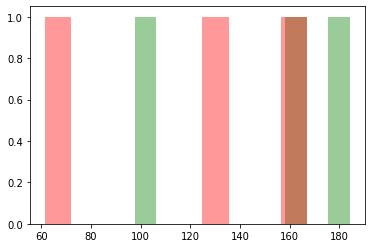

time: 512 ms


In [35]:
all_in_proximity = list(fast_dtw(df_0)['distance']) + list(fast_dtw(df_1)['distance']) + list(fast_dtw(df_2)['distance'])
all_not_in_proximity = list(fast_dtw(df_np_0)['distance']) + list(fast_dtw(df_np_1)['distance']) + list(fast_dtw(df_np_2)['distance'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)

(array([2., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.21795878, 0.22783684, 0.23771491, 0.24759297, 0.25747103,
        0.26734909, 0.27722715, 0.28710522, 0.29698328, 0.30686134,
        0.3167394 ]),
 <a list of 10 Patch objects>)

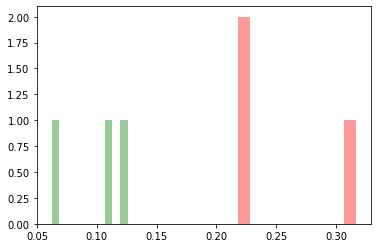

time: 630 ms


In [36]:
all_in_proximity = list(cosine_dist_normalized(df_0)['cosine']) + list(cosine_dist_normalized(df_1)['cosine']) + list(cosine_dist_normalized(df_2)['cosine'])
all_not_in_proximity = list(cosine_dist_normalized(df_np_0)['cosine']) + list(cosine_dist_normalized(df_np_1)['cosine']) + list(cosine_dist_normalized(df_np_2)['cosine'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)


#### Group 2 ####

In [44]:
start = "2018-05-16 11:20:00"
end = "2018-05-16 11:55:00"


start_np = "2018-05-16 09:15:00"
end_np = "2018-05-16 09:45:00"

focus_on = [34, 99, 98, 115, 94]


data_acc_filtered = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
data_acc_filtered_np = data_acc[(data_acc['timestamp'] >= start_np) & (data_acc['timestamp'] <= end_np)]
df_0 = aggregate_signals(data_acc_filtered, ["double_values_0"], "1min", [start, end], list(focus_on))
df_np_0 = aggregate_signals(data_acc_filtered_np, ["double_values_0"], "1min", [start_np, end_np], list(focus_on))
df_1 = aggregate_signals(data_acc_filtered, ["double_values_1"], "1min", [start, end], list(focus_on))
df_np_1 = aggregate_signals(data_acc_filtered_np, ["double_values_1"], "1min", [start_np, end_np], list(focus_on))
df_2 = aggregate_signals(data_acc_filtered, ["double_values_2"], "1min", [start, end], list(focus_on))
df_np_2 = aggregate_signals(data_acc_filtered_np, ["double_values_2"], "1min", [start_np, end_np], list(focus_on))

time: 25.8 s


             comb    cosine
0  (dev34, dev99)  0.817683
1  (dev34, dev98)  2.000000
2  (dev34, dev94)  0.986600
3  (dev99, dev98)  2.000000
4  (dev99, dev94)  1.046709
5  (dev98, dev94)  2.000000
-----------------------------------------------
             comb    cosine
0  (dev34, dev99)  0.147349
1  (dev34, dev98)       NaN
2  (dev34, dev94)  0.261621
3  (dev99, dev98)       NaN
4  (dev99, dev94)  0.170673
5  (dev98, dev94)       NaN
-----------------------------------------------
             comb    distance
0  (dev34, dev99)   82.370981
1  (dev34, dev98)  109.364292
2  (dev34, dev94)   92.190924
3  (dev99, dev98)   91.999370
4  (dev99, dev94)   85.343421
5  (dev98, dev94)   21.324812
-----------------------------------------------


/u/home/oturkar/venv/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/u/home/oturkar/venv/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/u/home/oturkar/venv/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


dev34     dev99  dev98     dev94
dev34  1.000000  0.388526    NaN  0.019583
dev99  0.388526  1.000000    NaN  0.095520
dev98       NaN       NaN    NaN       NaN
dev94  0.019583  0.095520    NaN  1.000000

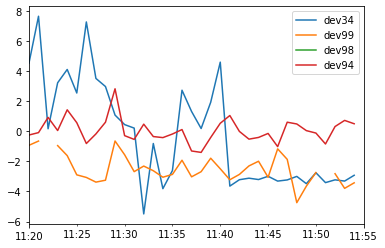

time: 511 ms


In [45]:
df_0.plot()
print(cosine_dist(df_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_0))
print("-----------------------------------------------")
print(fast_dtw(df_0))
print("-----------------------------------------------")
df_0.corr()

             comb    cosine
0  (dev34, dev99)  1.395578
1  (dev34, dev98)  0.000000
2  (dev34, dev94)  0.583936
3  (dev99, dev98)  2.000000
4  (dev99, dev94)  1.997230
5  (dev98, dev94)  0.000000
-----------------------------------------------
             comb    cosine
0  (dev34, dev99)  0.259354
1  (dev34, dev98)       NaN
2  (dev34, dev94)  0.532816
3  (dev99, dev98)       NaN
4  (dev99, dev94)  0.401805
5  (dev98, dev94)       NaN
-----------------------------------------------
             comb    distance
0  (dev34, dev99)  415.858256
1  (dev34, dev98)  278.525714
2  (dev34, dev94)  251.466587
3  (dev99, dev98)  694.383970
4  (dev99, dev94)  665.467492
5  (dev98, dev94)   28.916478
-----------------------------------------------


/u/home/oturkar/venv/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/u/home/oturkar/venv/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/u/home/oturkar/venv/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


dev34     dev99  dev98     dev94
dev34  1.000000 -0.050378    NaN -0.123999
dev99 -0.050378  1.000000    NaN  0.036266
dev98       NaN       NaN    NaN       NaN
dev94 -0.123999  0.036266    NaN  1.000000

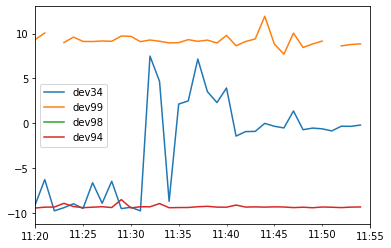

time: 459 ms


In [46]:
df_1.plot()
print(cosine_dist(df_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_1))
print("-----------------------------------------------")
print(fast_dtw(df_1))
print("-----------------------------------------------")
df_1.corr()

             comb        cosine
0  (dev34, dev99)  1.648395e+00
1  (dev34, dev98)  2.000000e+00
2  (dev34, dev94)  9.579478e-01
3  (dev99, dev98) -2.220446e-16
4  (dev99, dev94)  9.727897e-01
5  (dev98, dev94)  2.000000e+00
-----------------------------------------------
             comb    cosine
0  (dev34, dev99)  0.280192
1  (dev34, dev98)       NaN
2  (dev34, dev94)  0.134578
3  (dev99, dev98)       NaN
4  (dev99, dev94)  0.202255
5  (dev98, dev94)       NaN
-----------------------------------------------
             comb    distance
0  (dev34, dev99)  262.126361
1  (dev34, dev98)  248.223575
2  (dev34, dev94)  205.970521
3  (dev99, dev98)   31.990245
4  (dev99, dev94)   66.538737
5  (dev98, dev94)   55.970808
-----------------------------------------------


/u/home/oturkar/venv/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/u/home/oturkar/venv/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/u/home/oturkar/venv/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


dev34     dev99  dev98     dev94
dev34  1.000000 -0.388777    NaN  0.105301
dev99 -0.388777  1.000000    NaN -0.037608
dev98       NaN       NaN    NaN       NaN
dev94  0.105301 -0.037608    NaN  1.000000

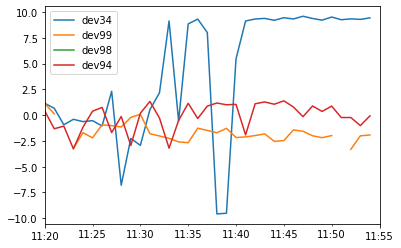

time: 521 ms


In [47]:
df_2.plot()
print(cosine_dist(df_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_2))
print("-----------------------------------------------")
print(fast_dtw(df_2))
print("-----------------------------------------------")
df_2.corr()

             comb    cosine
0  (dev34, dev99)  0.811377
1  (dev34, dev98)  0.023798
2  (dev34, dev94)  0.590050
3  (dev99, dev98)  0.358075
4  (dev99, dev94)  0.438179
5  (dev98, dev94)  0.008042
-----------------------------------------------
             comb    cosine
0  (dev34, dev99)  0.409093
1  (dev34, dev98)  1.000000
2  (dev34, dev94)  0.288629
3  (dev99, dev98)  1.000000
4  (dev99, dev94)  0.482192
5  (dev98, dev94)  0.000000
-----------------------------------------------
             comb    distance
0  (dev34, dev99)   71.254739
1  (dev34, dev98)   75.735079
2  (dev34, dev94)  158.881933
3  (dev99, dev98)   48.473869
4  (dev99, dev94)  157.823848
5  (dev98, dev94)  134.738868
-----------------------------------------------


dev34     dev99  dev98     dev94
dev34  1.000000 -0.052000   -1.0  0.294653
dev99 -0.052000  1.000000   -1.0 -0.282534
dev98 -1.000000 -1.000000    1.0  1.000000
dev94  0.294653 -0.282534    1.0  1.000000

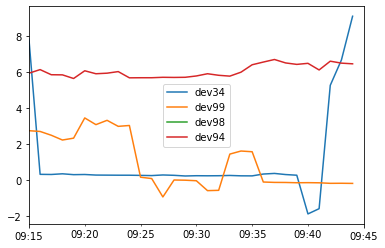

time: 434 ms


In [48]:
df_np_0.plot()
print(cosine_dist(df_np_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_0))
print("-----------------------------------------------")
print(fast_dtw(df_np_0))
print("-----------------------------------------------")
df_np_0.corr()

             comb    cosine
0  (dev34, dev99)  0.940058
1  (dev34, dev98)  1.993792
2  (dev34, dev94)  0.972860
3  (dev99, dev98)  1.751458
4  (dev99, dev94)  1.586846
5  (dev98, dev94)  0.001556
-----------------------------------------------
             comb    cosine
0  (dev34, dev99)  0.314570
1  (dev34, dev98)  0.000000
2  (dev34, dev94)  0.261621
3  (dev99, dev98)  1.000000
4  (dev99, dev94)  0.602437
5  (dev98, dev94)  0.000000
-----------------------------------------------
             comb    distance
0  (dev34, dev99)   48.971517
1  (dev34, dev98)  296.843525
2  (dev34, dev94)   43.721714
3  (dev99, dev98)  327.042528
4  (dev99, dev94)   69.988438
5  (dev98, dev94)  269.365985
-----------------------------------------------


dev34     dev99  dev98     dev94
dev34  1.000000 -0.098336    1.0  0.168823
dev99 -0.098336  1.000000   -1.0 -0.384222
dev98  1.000000 -1.000000    1.0  1.000000
dev94  0.168823 -0.384222    1.0  1.000000

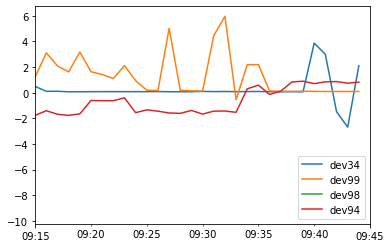

time: 533 ms


In [49]:
df_np_1.plot()
print(cosine_dist(df_np_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_1))
print("-----------------------------------------------")
print(fast_dtw(df_np_1))
print("-----------------------------------------------")
df_np_1.corr()

             comb    cosine
0  (dev34, dev99)  0.012920
1  (dev34, dev98)  0.124494
2  (dev34, dev94)  1.990701
3  (dev99, dev98)  0.105263
4  (dev99, dev94)  1.997701
5  (dev98, dev94)  1.876692
-----------------------------------------------
             comb    cosine
0  (dev34, dev99)  0.077024
1  (dev34, dev98)  1.000000
2  (dev34, dev94)  0.238008
3  (dev99, dev98)  0.000000
4  (dev99, dev94)  0.126722
5  (dev98, dev94)  1.000000
-----------------------------------------------
             comb    distance
0  (dev34, dev99)   34.978901
1  (dev34, dev98)  214.669282
2  (dev34, dev94)  527.784806
3  (dev99, dev98)  221.895753
4  (dev99, dev94)  535.011277
5  (dev98, dev94)  313.115524
-----------------------------------------------


dev34     dev99  dev98     dev94
dev34  1.000000 -0.227406   -1.0 -0.331667
dev99 -0.227406  1.000000    1.0  0.500182
dev98 -1.000000  1.000000    1.0 -1.000000
dev94 -0.331667  0.500182   -1.0  1.000000

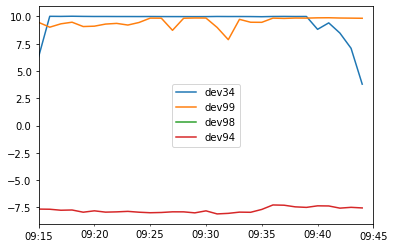

time: 675 ms


In [50]:
df_np_2.plot()
print(cosine_dist(df_np_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_2))
print("-----------------------------------------------")
print(fast_dtw(df_np_2))
print("-----------------------------------------------")
df_np_2.corr()

(array([7., 1., 2., 2., 1., 3., 0., 0., 0., 2.]),
 array([ 34.97890119,  84.98213874, 134.98537629, 184.98861384,
        234.9918514 , 284.99508895, 334.9983265 , 385.00156405,
        435.0048016 , 485.00803915, 535.0112767 ]),
 <a list of 10 Patch objects>)

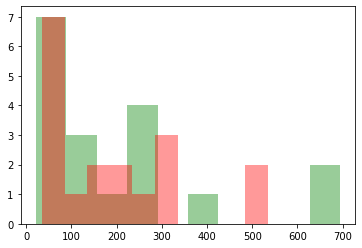

time: 701 ms


In [51]:
all_in_proximity = list(fast_dtw(df_0)['distance']) + list(fast_dtw(df_1)['distance']) + list(fast_dtw(df_2)['distance'])
all_not_in_proximity = list(fast_dtw(df_np_0)['distance']) + list(fast_dtw(df_np_1)['distance']) + list(fast_dtw(df_np_2)['distance'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)

/u/home/oturkar/venv/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/u/home/oturkar/venv/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/u/home/oturkar/venv/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/u/home/oturkar/venv/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/u/home/oturkar/venv/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/u/home/oturkar/venv/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encou

(array([5., 1., 3., 1., 2., 0., 1., 0., 0., 5.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

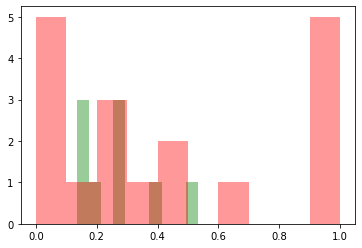

time: 491 ms


In [52]:
all_in_proximity = list(cosine_dist_normalized(df_0)['cosine']) + list(cosine_dist_normalized(df_1)['cosine']) + list(cosine_dist_normalized(df_2)['cosine'])
all_not_in_proximity = list(cosine_dist_normalized(df_np_0)['cosine']) + list(cosine_dist_normalized(df_np_1)['cosine']) + list(cosine_dist_normalized(df_np_2)['cosine'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)


#### Group 3 ####

In [60]:
start = "2018-05-16 11:55:00"
end = "2018-05-16 12:20:00"


start_np = "2018-05-16 10:20:00"
end_np = "2018-05-16 10:50:00"

focus_on = [8, 121, 84]

data_acc_filtered = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
data_acc_filtered_np = data_acc[(data_acc['timestamp'] >= start_np) & (data_acc['timestamp'] <= end_np)]
df_0 = aggregate_signals(data_acc_filtered, ["double_values_0"], "1min", [start, end], list(focus_on))
df_np_0 = aggregate_signals(data_acc_filtered_np, ["double_values_0"], "1min", [start_np, end_np], list(focus_on))
df_1 = aggregate_signals(data_acc_filtered, ["double_values_1"], "1min", [start, end], list(focus_on))
df_np_1 = aggregate_signals(data_acc_filtered_np, ["double_values_1"], "1min", [start_np, end_np], list(focus_on))
df_2 = aggregate_signals(data_acc_filtered, ["double_values_2"], "1min", [start, end], list(focus_on))
df_np_2 = aggregate_signals(data_acc_filtered_np, ["double_values_2"], "1min", [start_np, end_np], list(focus_on))

time: 18.4 s


              comb    cosine
0   (dev8, dev121)  1.333812
1    (dev8, dev84)  1.190065
2  (dev121, dev84)  0.534078
-----------------------------------------------
              comb    cosine
0   (dev8, dev121)  0.372628
1    (dev8, dev84)  0.112364
2  (dev121, dev84)  0.337032
-----------------------------------------------
              comb   distance
0   (dev8, dev121)  54.792096
1    (dev8, dev84)  62.399101
2  (dev121, dev84)  75.188299
-----------------------------------------------


dev8    dev121     dev84
dev8    1.000000 -0.217758  0.603845
dev121 -0.217758  1.000000 -0.145040
dev84   0.603845 -0.145040  1.000000

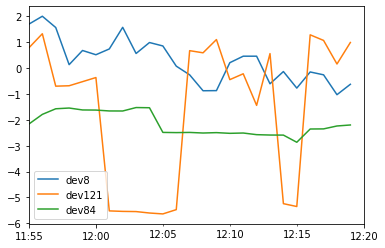

time: 412 ms


In [61]:
df_0.plot()
print(cosine_dist(df_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_0))
print("-----------------------------------------------")
print(fast_dtw(df_0))
print("-----------------------------------------------")
df_0.corr()

              comb    cosine
0   (dev8, dev121)  0.788512
1    (dev8, dev84)  0.506193
2  (dev121, dev84)  0.403186
-----------------------------------------------
              comb    cosine
0   (dev8, dev121)  0.379677
1    (dev8, dev84)  0.204394
2  (dev121, dev84)  0.461594
-----------------------------------------------
              comb    distance
0   (dev8, dev121)  127.905238
1    (dev8, dev84)  105.721314
2  (dev121, dev84)   93.524553
-----------------------------------------------


dev8    dev121     dev84
dev8    1.000000 -0.255729  0.224619
dev121 -0.255729  1.000000 -0.119560
dev84   0.224619 -0.119560  1.000000

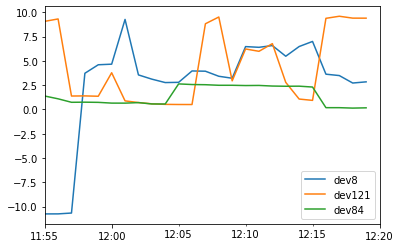

time: 364 ms


In [62]:
df_1.plot()
print(cosine_dist(df_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_1))
print("-----------------------------------------------")
print(fast_dtw(df_1))
print("-----------------------------------------------")
df_1.corr()

              comb    cosine
0   (dev8, dev121)  1.217114
1    (dev8, dev84)  1.902201
2  (dev121, dev84)  0.701956
-----------------------------------------------
              comb    cosine
0   (dev8, dev121)  0.272012
1    (dev8, dev84)  0.225085
2  (dev121, dev84)  0.252396
-----------------------------------------------
              comb    distance
0   (dev8, dev121)  174.706445
1    (dev8, dev84)  448.448955
2  (dev121, dev84)  207.145019
-----------------------------------------------


dev8    dev121     dev84
dev8    1.000000  0.110414  0.216928
dev121  0.110414  1.000000  0.380667
dev84   0.216928  0.380667  1.000000

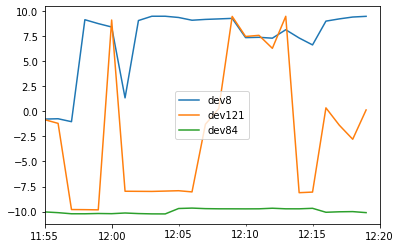

time: 464 ms


In [63]:
df_2.plot()
print(cosine_dist(df_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_2))
print("-----------------------------------------------")
print(fast_dtw(df_2))
print("-----------------------------------------------")
df_2.corr()

              comb    cosine
0   (dev8, dev121)  0.797461
1    (dev8, dev84)  1.531598
2  (dev121, dev84)  1.342165
-----------------------------------------------
              comb    cosine
0   (dev8, dev121)  0.856953
1    (dev8, dev84)  0.756903
2  (dev121, dev84)  0.559694
-----------------------------------------------
              comb   distance
0   (dev8, dev121)  39.611321
1    (dev8, dev84)  87.592981
2  (dev121, dev84)  68.627380
-----------------------------------------------


dev8    dev121     dev84
dev8    1.000000 -0.223041 -0.387024
dev121 -0.223041  1.000000  0.120116
dev84  -0.387024  0.120116  1.000000

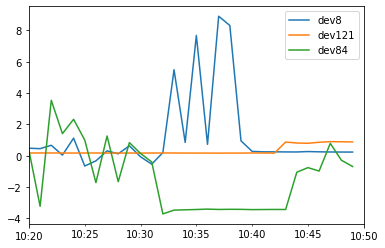

time: 579 ms


In [64]:
df_np_0.plot()
print(cosine_dist(df_np_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_0))
print("-----------------------------------------------")
print(fast_dtw(df_np_0))
print("-----------------------------------------------")
df_np_0.corr()

              comb    cosine
0   (dev8, dev121)  1.575205
1    (dev8, dev84)  1.596605
2  (dev121, dev84)  0.450863
-----------------------------------------------
              comb    cosine
0   (dev8, dev121)  0.647409
1    (dev8, dev84)  0.370032
2  (dev121, dev84)  0.656762
-----------------------------------------------
              comb    distance
0   (dev8, dev121)  113.288212
1    (dev8, dev84)  109.041060
2  (dev121, dev84)  144.983954
-----------------------------------------------


dev8    dev121     dev84
dev8    1.000000 -0.365083 -0.424725
dev121 -0.365083  1.000000 -0.112749
dev84  -0.424725 -0.112749  1.000000

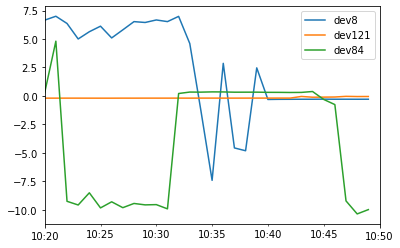

time: 367 ms


In [65]:
df_np_1.plot()
print(cosine_dist(df_np_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_1))
print("-----------------------------------------------")
print(fast_dtw(df_np_1))
print("-----------------------------------------------")
df_np_1.corr()

              comb    cosine
0   (dev8, dev121)  0.042847
1    (dev8, dev84)  1.668677
2  (dev121, dev84)  1.694850
-----------------------------------------------
              comb    cosine
0   (dev8, dev121)  0.338002
1    (dev8, dev84)  0.345446
2  (dev121, dev84)  0.689312
-----------------------------------------------
              comb    distance
0   (dev8, dev121)   61.070737
1    (dev8, dev84)  341.961137
2  (dev121, dev84)  464.261168
-----------------------------------------------


dev8    dev121     dev84
dev8    1.000000  0.396107 -0.018686
dev121  0.396107  1.000000 -0.175718
dev84  -0.018686 -0.175718  1.000000

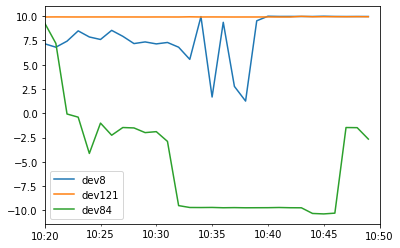

time: 441 ms


In [66]:
df_np_2.plot()
print(cosine_dist(df_np_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_2))
print("-----------------------------------------------")
print(fast_dtw(df_np_2))
print("-----------------------------------------------")
df_np_2.corr()

(array([3., 3., 1., 0., 0., 0., 0., 1., 0., 1.]),
 array([ 39.61132081,  82.07630554, 124.54129028, 167.00627502,
        209.47125976, 251.93624449, 294.40122923, 336.86621397,
        379.33119871, 421.79618344, 464.26116818]),
 <a list of 10 Patch objects>)

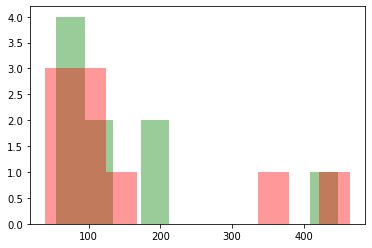

time: 461 ms


In [67]:
all_in_proximity = list(fast_dtw(df_0)['distance']) + list(fast_dtw(df_1)['distance']) + list(fast_dtw(df_2)['distance'])
all_not_in_proximity = list(fast_dtw(df_np_0)['distance']) + list(fast_dtw(df_np_1)['distance']) + list(fast_dtw(df_np_2)['distance'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)

(array([3., 0., 0., 0., 1., 1., 2., 0., 1., 1.]),
 array([0.33800214, 0.38989725, 0.44179237, 0.49368748, 0.5455826 ,
        0.59747771, 0.64937283, 0.70126794, 0.75316305, 0.80505817,
        0.85695328]),
 <a list of 10 Patch objects>)

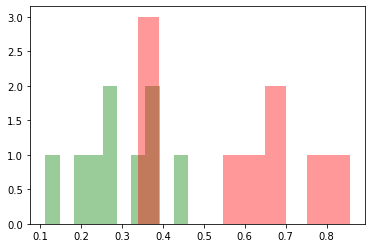

time: 407 ms


In [68]:
all_in_proximity = list(cosine_dist_normalized(df_0)['cosine']) + list(cosine_dist_normalized(df_1)['cosine']) + list(cosine_dist_normalized(df_2)['cosine'])
all_not_in_proximity = list(cosine_dist_normalized(df_np_0)['cosine']) + list(cosine_dist_normalized(df_np_1)['cosine']) + list(cosine_dist_normalized(df_np_2)['cosine'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)


### Accelerometer Same Sensor ###

#### Group 1 ####

In [110]:
start = "2018-06-18 06:35:00"
end = "2018-06-18 07:00:00"


start_np = "2018-04-27 15:30:00"
end_np = "2018-04-27 16:00:00"

focus_on = [24, 98]

data_acc_filtered = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
data_acc_filtered_np = data_acc[(data_acc['timestamp'] >= start_np) & (data_acc['timestamp'] <= end_np)]
df_0 = aggregate_signals(data_acc_filtered, ["double_values_0"], "1min", [start, end], list(focus_on))
df_np_0 = aggregate_signals(data_acc_filtered_np, ["double_values_0"], "1min", [start_np, end_np], list(focus_on))
df_1 = aggregate_signals(data_acc_filtered, ["double_values_1"], "1min", [start, end], list(focus_on))
df_np_1 = aggregate_signals(data_acc_filtered_np, ["double_values_1"], "1min", [start_np, end_np], list(focus_on))
df_2 = aggregate_signals(data_acc_filtered, ["double_values_2"], "1min", [start, end], list(focus_on))
df_np_2 = aggregate_signals(data_acc_filtered_np, ["double_values_2"], "1min", [start_np, end_np], list(focus_on))

time: 15.1 s


Empty DataFrame
Columns: [comb, cosine]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, cosine]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, distance]
Index: []
-----------------------------------------------


dev24
dev24    1.0

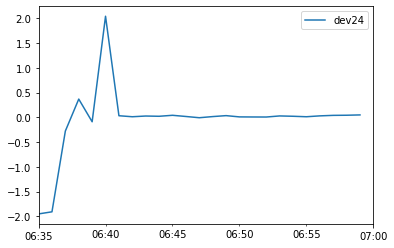

time: 302 ms


In [111]:
df_0.plot()
print(cosine_dist(df_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_0))
print("-----------------------------------------------")
print(fast_dtw(df_0))
print("-----------------------------------------------")
df_0.corr()

             comb    cosine
0  (dev98, dev37)  1.755615
1  (dev98, dev23)  1.360113
2  (dev37, dev23)  1.273258
-----------------------------------------------
             comb    cosine
0  (dev98, dev37)  1.000000
1  (dev98, dev23)  0.837491
2  (dev37, dev23)  0.729378
-----------------------------------------------
             comb    distance
0  (dev98, dev37)  660.068004
1  (dev98, dev23)  741.990942
2  (dev37, dev23)  257.922757
-----------------------------------------------


dev98     dev37     dev23
dev98  1.000000 -1.000000 -0.560978
dev37 -1.000000  1.000000 -0.089482
dev23 -0.560978 -0.089482  1.000000

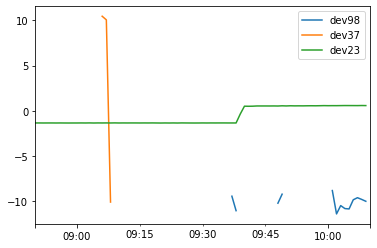

time: 458 ms


In [93]:
df_1.plot()
print(cosine_dist(df_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_1))
print("-----------------------------------------------")
print(fast_dtw(df_1))
print("-----------------------------------------------")
df_1.corr()

             comb    cosine
0  (dev98, dev37)  0.244940
1  (dev98, dev23)  0.680582
2  (dev37, dev23)  0.525510
-----------------------------------------------
             comb    cosine
0  (dev98, dev37)  0.000000
1  (dev98, dev23)  0.362953
2  (dev37, dev23)  0.532785
-----------------------------------------------
             comb    distance
0  (dev98, dev37)  714.670848
1  (dev98, dev23)  459.158477
2  (dev37, dev23)  428.509659
-----------------------------------------------


dev98     dev37     dev23
dev98  1.000000  1.000000  0.395544
dev37  1.000000  1.000000 -0.744866
dev23  0.395544 -0.744866  1.000000

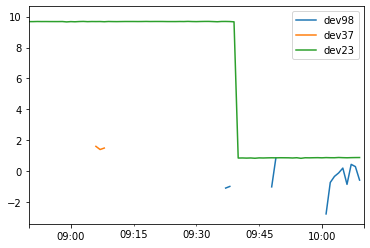

time: 441 ms


In [94]:
df_2.plot()
print(cosine_dist(df_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_2))
print("-----------------------------------------------")
print(fast_dtw(df_2))
print("-----------------------------------------------")
df_2.corr()

In [ ]:
df_np_0.plot()
print(cosine_dist(df_np_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_0))
print("-----------------------------------------------")
print(fast_dtw(df_np_0))
print("-----------------------------------------------")
df_np_0.corr()

In [ ]:
df_np_1.plot()
print(cosine_dist(df_np_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_1))
print("-----------------------------------------------")
print(fast_dtw(df_np_1))
print("-----------------------------------------------")
df_np_1.corr()

In [ ]:
df_np_2.plot()
print(cosine_dist(df_np_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_2))
print("-----------------------------------------------")
print(fast_dtw(df_np_2))
print("-----------------------------------------------")
df_np_2.corr()

In [ ]:
all_in_proximity = list(fast_dtw(df_0)['distance']) + list(fast_dtw(df_1)['distance']) + list(fast_dtw(df_2)['distance'])
all_not_in_proximity = list(fast_dtw(df_np_0)['distance']) + list(fast_dtw(df_np_1)['distance']) + list(fast_dtw(df_np_2)['distance'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)

In [ ]:
all_in_proximity = list(cosine_dist_normalized(df_0)['cosine']) + list(cosine_dist_normalized(df_1)['cosine']) + list(cosine_dist_normalized(df_2)['cosine'])
all_not_in_proximity = list(cosine_dist_normalized(df_np_0)['cosine']) + list(cosine_dist_normalized(df_np_1)['cosine']) + list(cosine_dist_normalized(df_np_2)['cosine'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)


#### Group 2 ####

In [ ]:
start = "2018-06-18 14:00:00"
end = "2018-06-18 14:35:00"


start_np = "2018-06-18 12:15:00"
end_np = "2018-06-18 13:00:00"

data_mag_filtered = data_mag[(data_mag['timestamp'] >= start) & (data_mag['timestamp'] <= end)]
data_mag_filtered_np = data_mag[(data_mag['timestamp'] >= start_np) & (data_mag['timestamp'] <= end_np)]
df_0 = aggregate_signals(data_mag_filtered, ["double_values_0"], "1min", [start, end], list(acc_meta_filtered_name_1))
df_np_0 = aggregate_signals(data_mag_filtered_np, ["double_values_0"], "1min", [start_np, end_np], list(acc_meta_filtered_name_1))
df_1 = aggregate_signals(data_mag_filtered, ["double_values_1"], "1min", [start, end], list(acc_meta_filtered_name_1))
df_np_1 = aggregate_signals(data_mag_filtered_np, ["double_values_1"], "1min", [start_np, end_np], list(acc_meta_filtered_name_1))
df_2 = aggregate_signals(data_mag_filtered, ["double_values_2"], "1min", [start, end], list(acc_meta_filtered_name_1))
df_np_2 = aggregate_signals(data_mag_filtered_np, ["double_values_2"], "1min", [start_np, end_np], list(acc_meta_filtered_name_1))

In [ ]:
df_0.plot()
print(cosine_dist(df_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_0))
print("-----------------------------------------------")
print(fast_dtw(df_0))
print("-----------------------------------------------")
df_0.corr()

In [ ]:
df_1.plot()
print(cosine_dist(df_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_1))
print("-----------------------------------------------")
print(fast_dtw(df_1))
print("-----------------------------------------------")
df_1.corr()

In [ ]:
df_2.plot()
print(cosine_dist(df_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_2))
print("-----------------------------------------------")
print(fast_dtw(df_2))
print("-----------------------------------------------")
df_2.corr()

In [ ]:
df_np_0.plot()
print(cosine_dist(df_np_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_0))
print("-----------------------------------------------")
print(fast_dtw(df_np_0))
print("-----------------------------------------------")
df_np_0.corr()

In [ ]:
df_np_1.plot()
print(cosine_dist(df_np_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_1))
print("-----------------------------------------------")
print(fast_dtw(df_np_1))
print("-----------------------------------------------")
df_np_1.corr()

In [ ]:
df_np_2.plot()
print(cosine_dist(df_np_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_2))
print("-----------------------------------------------")
print(fast_dtw(df_np_2))
print("-----------------------------------------------")
df_np_2.corr()

In [ ]:
all_in_proximity = list(fast_dtw(df_0)['distance']) + list(fast_dtw(df_1)['distance']) + list(fast_dtw(df_2)['distance'])
all_not_in_proximity = list(fast_dtw(df_np_0)['distance']) + list(fast_dtw(df_np_1)['distance']) + list(fast_dtw(df_np_2)['distance'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)

In [ ]:
all_in_proximity = list(cosine_dist_normalized(df_0)['cosine']) + list(cosine_dist_normalized(df_1)['cosine']) + list(cosine_dist_normalized(df_2)['cosine'])
all_not_in_proximity = list(cosine_dist_normalized(df_np_0)['cosine']) + list(cosine_dist_normalized(df_np_1)['cosine']) + list(cosine_dist_normalized(df_np_2)['cosine'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)


#### Group 3 ####

In [126]:
start = "2018-05-23 13:45:00"
end = "2018-05-23 14:00:00"


start_np = "2018-05-23 13:00:00"
end_np = "2018-05-23 13:20:00"

focus_on = [90, 39]

data_mag_filtered = data_mag[(data_mag['timestamp'] >= start) & (data_mag['timestamp'] <= end)]
data_mag_filtered_np = data_mag[(data_mag['timestamp'] >= start_np) & (data_mag['timestamp'] <= end_np)]
df_0 = aggregate_signals(data_mag_filtered, ["double_values_0"], "1min", [start, end], list(acc_meta_filtered_name_2))
df_np_0 = aggregate_signals(data_mag_filtered_np, ["double_values_0"], "1min", [start_np, end_np], list(acc_meta_filtered_name_2))
df_1 = aggregate_signals(data_mag_filtered, ["double_values_1"], "1min", [start, end], list(acc_meta_filtered_name_2))
df_np_1 = aggregate_signals(data_mag_filtered_np, ["double_values_1"], "1min", [start_np, end_np], list(acc_meta_filtered_name_2))
df_2 = aggregate_signals(data_mag_filtered, ["double_values_2"], "1min", [start, end], list(acc_meta_filtered_name_2))
df_np_2 = aggregate_signals(data_mag_filtered_np, ["double_values_2"], "1min", [start_np, end_np], list(acc_meta_filtered_name_2))

time: 18.9 s


In [127]:
df_0.plot()
print(cosine_dist(df_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_0))
print("-----------------------------------------------")
print(fast_dtw(df_0))
print("-----------------------------------------------")
df_0.corr()

TypeError: no numeric data to plot

time: 932 ms


In [ ]:
df_1.plot()
print(cosine_dist(df_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_1))
print("-----------------------------------------------")
print(fast_dtw(df_1))
print("-----------------------------------------------")
df_1.corr()

In [ ]:
df_2.plot()
print(cosine_dist(df_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_2))
print("-----------------------------------------------")
print(fast_dtw(df_2))
print("-----------------------------------------------")
df_2.corr()

In [ ]:
df_np_0.plot()
print(cosine_dist(df_np_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_0))
print("-----------------------------------------------")
print(fast_dtw(df_np_0))
print("-----------------------------------------------")
df_np_0.corr()

In [ ]:
df_np_1.plot()
print(cosine_dist(df_np_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_1))
print("-----------------------------------------------")
print(fast_dtw(df_np_1))
print("-----------------------------------------------")
df_np_1.corr()

In [ ]:
df_np_2.plot()
print(cosine_dist(df_np_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_2))
print("-----------------------------------------------")
print(fast_dtw(df_np_2))
print("-----------------------------------------------")
df_np_2.corr()

In [ ]:
all_in_proximity = list(fast_dtw(df_0)['distance']) + list(fast_dtw(df_1)['distance']) + list(fast_dtw(df_2)['distance'])
all_not_in_proximity = list(fast_dtw(df_np_0)['distance']) + list(fast_dtw(df_np_1)['distance']) + list(fast_dtw(df_np_2)['distance'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)

In [ ]:
all_in_proximity = list(cosine_dist_normalized(df_0)['cosine']) + list(cosine_dist_normalized(df_1)['cosine']) + list(cosine_dist_normalized(df_2)['cosine'])
all_not_in_proximity = list(cosine_dist_normalized(df_np_0)['cosine']) + list(cosine_dist_normalized(df_np_1)['cosine']) + list(cosine_dist_normalized(df_np_2)['cosine'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)


### Bosch Analysis ###

In [26]:
top_sensor_vender_acc

array(['STMicroelectronics', 'Bosch', 'BOSCH', 'STM', 'Invensense',
       'Invensense Inc.', 'Bosch Sensortec GmbH', 'Bosch Sensortec',
       'MTK', 'Kionix', 'hTC Corp.', 'KIONIX', 'Intel Inc.'], dtype=object)

time: 7.57 ms


In [97]:
p_list = []
same_group_list = []
for groups in list(wifi_proximity["groups"]):
    point = 0
    group_vendor = []
    for group in groups:
        x = set(bosch).intersection(group)
        if len(x) > 1:
            point = point + len(x)
            group_vendor = group_vendor + list(x)
    p_list.append(point)
    same_group_list.append(group_vendor)

time: 61.4 ms


In [56]:
bosch = list(acc_meta[acc_meta['sensor_vendor'] == top_sensor_vender_acc[1]]["device_id"]) + list(acc_meta[acc_meta['sensor_vendor'] == top_sensor_vender_acc[2]]["device_id"]) + list(acc_meta[acc_meta['sensor_vendor'] == top_sensor_vender_acc[6]]["device_id"]) + list(acc_meta[acc_meta['sensor_vendor'] == top_sensor_vender_acc[7]]["device_id"])

time: 53.8 ms


In [57]:
bosch_df = pd.concat([acc_meta[acc_meta['sensor_vendor'] == top_sensor_vender_acc[1]], acc_meta[acc_meta['sensor_vendor'] == top_sensor_vender_acc[2]], acc_meta[acc_meta['sensor_vendor'] == top_sensor_vender_acc[6]], acc_meta[acc_meta['sensor_vendor'] == top_sensor_vender_acc[7]]])

time: 71.4 ms


In [517]:
wifi_proximity["p_list"] = p_list
wifi_proximity["p_group"] = same_group_list
wifi_proximity["p_list"].max(), wifi_proximity[11000:13000]["p_list"].argmax()

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


(8, 11454)

time: 44.8 ms


In [522]:
wifi_proximity[11445:11475]

timestamp                                            devices  \
11445 2018-06-04 09:45:00  [[24, 48], [24, 50, 97], [24, 97], [48, 92], [...   
11446 2018-06-04 09:50:00  [[24, 48], [24, 50, 97], [24, 97], [48, 92], [...   
11447 2018-06-04 09:55:00  [[24, 48], [24, 50, 97], [24, 97], [92, 125], ...   
11448 2018-06-04 10:00:00  [[14, 94], [24, 48], [24, 50, 97], [24, 97], [...   
11449 2018-06-04 10:05:00  [[14, 94], [24, 48], [24, 50, 97], [24, 97], [...   
11450 2018-06-04 10:10:00  [[14, 94], [24, 48], [24, 50, 97], [24, 97], [...   
11451 2018-06-04 10:15:00  [[24, 125], [24, 48, 85], [24, 85], [14, 94], ...   
11452 2018-06-04 10:20:00  [[24, 125], [24, 94, 97], [48, 94], [24, 48, 9...   
11453 2018-06-04 10:25:00  [[24, 125], [24, 94, 97], [48, 94], [48, 59], ...   
11454 2018-06-04 10:30:00  [[24, 125], [24, 94, 97], [48, 98], [48, 94, 9...   
11455 2018-06-04 10:35:00  [[24, 125], [48, 98], [48, 94, 98], [24, 94, 9...   
11456 2018-06-04 10:40:00  [[24, 125], [48, 98], [48, 94, 98], [24, 94, 9...   
11457 2018-06-04 10:45:00  [[24, 125], [24, 94, 97], [48, 98], [24, 94, 9...   
11458 2018-06-04 10:50:00  [[24, 125], [24, 94, 97], [50, 97], [94, 97], ...   
11459 2018-06-04 10:55:00  [[24, 125], [24, 94, 97], [50, 97], [94, 97], ...   
11460 2018-06-04 11:00:00  [[24, 125], [50, 97], [94, 97], [48, 94, 97], ...   
11461 2018-06-04 11:05:00  [[24, 125], [48, 98], [36, 48, 94, 97], [94, 9...   
11462 2018-06-04 11:10:00  [[24, 125], [36, 48, 94, 97], [94, 97], [48, 9...   
11463 2018-06-04 11:15:00  [[24, 125], [48, 98], [36, 48, 94, 97], [94, 9...   
11464 2018-06-04 11:20:00  [[24, 125], [48, 98], [94, 97], [48, 94], [48,...   
11465 2018-06-04 11:25:00  [[24, 125], [48, 98], [94, 97], [48, 94], [48,...   
11466 2018-06-04 11:30:00  [[24, 125], [94, 97], [59, 94, 97], [94, 97, 9...   
11467 2018-06-04 11:35:00  [[24, 125], [24, 94, 97], [94, 97], [59, 94, 9...   
11468 2018-06-04 11:40:00  [[24, 125], [24, 94, 97], [29, 94, 97], [94, 9...   
11469 2018-06-04 11:45:00  [[24, 125], [29, 94], [24, 94], [14, 94], [14,...   
11470 2018-06-04 11:50:00  [[24, 125], [29, 94], [24, 94], [14, 94], [27,...   
11471 2018-06-04 11:55:00  [[24, 125], [29, 94], [24, 94], [14, 94], [27,...   
11472 2018-06-04 12:00:00  [[24, 125], [14, 94], [27, 85], [24, 29], [84,...   
11473 2018-06-04 12:05:00  [[24, 125], [14, 94], [27, 85], [24, 29], [84,...   
11474 2018-06-04 12:10:00  [[24, 125], [24, 29, 36], [36, 98], [24, 36], ...   

                                                  groups  p_list  \
11445                  [{48, 97, 50, 24, 92}, {84, 101}]       2   
11446                  [{48, 97, 50, 24, 92}, {84, 101}]       2   
11447       [{48, 97, 50, 24, 59}, {92, 125}, {84, 101}]       2   
11448    [{94, 14}, {48, 97, 50, 85, 24, 59}, {84, 101}]       2   
11449    [{94, 14}, {48, 97, 50, 85, 24, 59}, {84, 101}]       2   
11450    [{94, 14}, {48, 97, 50, 85, 24, 59}, {84, 101}]       2   
11451   [{48, 97, 50, 85, 24, 125}, {94, 14}, {84, 101}]       2   
11452     [{97, 14, 48, 50, 85, 24, 125, 94}, {84, 101}]       3   
11453  [{97, 14, 48, 50, 85, 24, 59, 125, 94}, {84, 1...       3   
11454  [{97, 98, 14, 48, 50, 85, 24, 59, 125, 94}, {8...       4   
11455     [{97, 98, 36, 48, 50, 24, 125, 94}, {84, 101}]       4   
11456         [{97, 98, 36, 48, 24, 125, 94}, {84, 101}]       4   
11457  [{97, 98, 36, 14, 48, 50, 24, 125, 94}, {84, 1...       4   
11458  [{48, 97, 50, 14, 24, 125, 94}, {98, 36}, {84,...       3   
11459     [{97, 14, 48, 50, 24, 59, 125, 94}, {84, 101}]       3   
11460  [{97, 36, 14, 48, 50, 24, 59, 125, 94}, {84, 1...       3   
11461  [{97, 98, 36, 59, 14, 48, 24, 27, 125, 94}, {8...       4   
11462  [{97, 36, 59, 14, 48, 24, 27, 125, 94}, {84, 1...       3   
11463  [{97, 98, 36, 14, 48, 24, 27, 125, 94}, {84, 1...       4   
11464  [{97, 98, 36, 14, 48, 24, 27, 125, 94}, {84, 1...       4   
11465  [{97, 98, 59, 14, 48, 24, 27, 125, 94}, {84, 1...       4   
11466   [{24, 125}, {48, 97, 98, 14, 59

time: 149 ms


In [508]:
x = data_acc['timestamp'].dt.round("1min")

time: 2min 3s


In [509]:
v,c = np.unique(x, return_counts = True)

time: 21.2 s


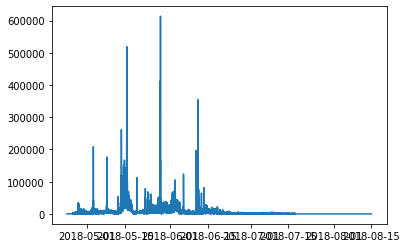

time: 353 ms


In [511]:
plt.plot(v,c)

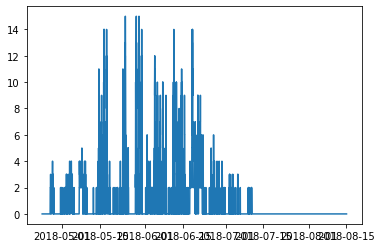

time: 286 ms


In [512]:
plt.plot(wifi_proximity["timestamp"],wifi_proximity["count_devices"])

#### Event 1 ####

In [348]:
start = "2018-05-16 11:25:00"
end = "2018-05-16 12:45:00"


start_np = "2018-05-16 09:00:00"
end_np = "2018-05-16 09:30:00"

focus_on = [96, 98, 99, 34, 115, 84, 94]

data_acc_filtered = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
data_acc_filtered_np = data_acc[(data_acc['timestamp'] >= start_np) & (data_acc['timestamp'] <= end_np)]
df_0 = aggregate_signals(data_acc_filtered, ["double_values_0"], "1min", [start, end], list(focus_on))
df_np_0 = aggregate_signals(data_acc_filtered_np, ["double_values_0"], "1min", [start_np, end_np], list(focus_on))
df_1 = aggregate_signals(data_acc_filtered, ["double_values_1"], "1min", [start, end], list(focus_on))
df_np_1 = aggregate_signals(data_acc_filtered_np, ["double_values_1"], "1min", [start_np, end_np], list(focus_on))
df_2 = aggregate_signals(data_acc_filtered, ["double_values_2"], "1min", [start, end], list(focus_on))
df_np_2 = aggregate_signals(data_acc_filtered_np, ["double_values_2"], "1min", [start_np, end_np], list(focus_on))

time: 41.9 s


             comb    cosine
0  (dev96, dev34)  1.347123
1  (dev96, dev94)  0.226309
2  (dev34, dev94)  1.216603
-----------------------------------------------
             comb    cosine
0  (dev96, dev34)  0.396965
1  (dev96, dev94)  0.145778
2  (dev34, dev94)  0.440916
-----------------------------------------------
             comb    distance
0  (dev96, dev34)  280.738674
1  (dev96, dev94)  191.554690
2  (dev34, dev94)  193.999237
-----------------------------------------------


dev96     dev34     dev94
dev96  1.000000 -0.236948  0.695525
dev34 -0.236948  1.000000 -0.000769
dev94  0.695525 -0.000769  1.000000

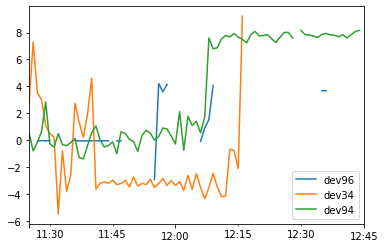

time: 516 ms


In [349]:
df_0.plot()
print(cosine_dist(df_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_0))
print("-----------------------------------------------")
print(fast_dtw(df_0))
print("-----------------------------------------------")
df_0.corr()

              comb    cosine
0   (dev96, dev98)  2.000000
1   (dev96, dev99)  1.495239
2   (dev96, dev34)  0.890697
3   (dev96, dev84)  1.531842
4   (dev96, dev94)  0.660263
5   (dev98, dev99)  1.887769
6   (dev98, dev34)  0.027464
7   (dev98, dev84)  1.918280
8   (dev98, dev94)  0.015086
9   (dev99, dev34)  1.284870
10  (dev99, dev84)  0.447990
11  (dev99, dev94)  1.791366
12  (dev34, dev84)  1.263583
13  (dev34, dev94)  0.747612
14  (dev84, dev94)  1.374953
-----------------------------------------------
              comb    cosine
0   (dev96, dev98)       NaN
1   (dev96, dev99)  0.150100
2   (dev96, dev34)  0.191480
3   (dev96, dev84)  0.254749
4   (dev96, dev94)  0.915050
5   (dev98, dev99)  0.215027
6   (dev98, dev34)  0.582781
7   (dev98, dev84)  0.978007
8   (dev98, dev94)  0.001598
9   (dev99, dev34)  0.121592
10  (dev99, dev84)  0.098141
11  (dev99, dev94)  0.426106
12  (dev34, dev84)  0.144376
13  (dev34, dev94)  0.498209
14  (dev84, dev94)  0.372642
------------------------

/u/home/oturkar/venv/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


              comb    distance
0   (dev96, dev98)  461.528967
1   (dev96, dev99)  729.345446
2   (dev96, dev34)  188.977119
3   (dev96, dev84)  237.145951
4   (dev96, dev94)  469.188168
5   (dev98, dev99)  966.024891
6   (dev98, dev34)  182.841535
7   (dev98, dev84)  427.047440
8   (dev98, dev94)   87.715222
9   (dev99, dev34)  692.625460
10  (dev99, dev84)  494.027730
11  (dev99, dev94)  909.423504
12  (dev34, dev84)  290.820233
13  (dev34, dev94)  199.164556
14  (dev84, dev94)  355.985596
-----------------------------------------------


dev96     dev98     dev99     dev34     dev84     dev94
dev96  1.000000       NaN  0.009782 -0.013071 -0.421161 -0.506061
dev98       NaN  1.000000  0.732964 -0.479053 -0.603448  0.998336
dev99  0.009782  0.732964  1.000000 -0.057281 -0.263473 -0.145130
dev34 -0.013071 -0.479053 -0.057281  1.000000 -0.121612  0.011362
dev84 -0.421161 -0.603448 -0.263473 -0.121612  1.000000  0.166470
dev94 -0.506061  0.998336 -0.145130  0.011362  0.166470  1.000000

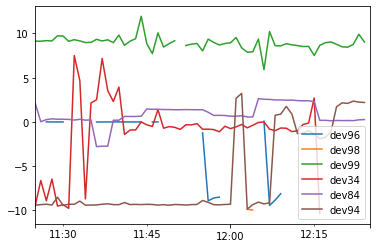

time: 1.21 s


In [45]:
df_1.plot()
print(cosine_dist(df_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_1))
print("-----------------------------------------------")
print(fast_dtw(df_1))
print("-----------------------------------------------")
df_1.corr()

              comb    cosine
0   (dev96, dev98)  2.000000
1   (dev96, dev99)  1.799152
2   (dev96, dev34)  0.480773
3   (dev96, dev84)  1.917618
4   (dev96, dev94)  1.121101
5   (dev98, dev99)  0.974024
6   (dev98, dev34)  1.322904
7   (dev98, dev84)  0.516989
8   (dev98, dev94)  0.065930
9   (dev99, dev34)  1.818505
10  (dev99, dev84)  0.068574
11  (dev99, dev94)  0.647440
12  (dev34, dev84)  1.782396
13  (dev34, dev94)  1.247251
14  (dev84, dev94)  0.615794
-----------------------------------------------
              comb    cosine
0   (dev96, dev98)       NaN
1   (dev96, dev99)  0.134783
2   (dev96, dev34)  0.215957
3   (dev96, dev84)  0.299403
4   (dev96, dev94)  0.084554
5   (dev98, dev99)  0.451143
6   (dev98, dev34)  0.322064
7   (dev98, dev84)  0.584455
8   (dev98, dev94)  0.014339
9   (dev99, dev34)  0.188852
10  (dev99, dev84)  0.266840
11  (dev99, dev94)  0.244330
12  (dev34, dev84)  0.293919
13  (dev34, dev94)  0.169027
14  (dev84, dev94)  0.431973
------------------------

/u/home/oturkar/venv/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


              comb     distance
0   (dev96, dev98)   658.178026
1   (dev96, dev99)   547.889756
2   (dev96, dev34)   212.844920
3   (dev96, dev84)  1031.000301
4   (dev96, dev94)   467.476239
5   (dev98, dev99)   208.729731
6   (dev98, dev34)   613.156701
7   (dev98, dev84)   361.358167
8   (dev98, dev94)   138.094717
9   (dev99, dev34)   572.038760
10  (dev99, dev84)   483.110545
11  (dev99, dev94)   159.267254
12  (dev34, dev84)   958.529956
13  (dev34, dev94)   238.888162
14  (dev84, dev94)   511.815236
-----------------------------------------------


dev96     dev98     dev99     dev34     dev84     dev94
dev96  1.000000       NaN  0.285770 -0.334835  0.098116  0.422481
dev98       NaN  1.000000 -0.691792  0.068957 -0.500047  0.932143
dev99  0.285770 -0.691792  1.000000 -0.413474  0.172096 -0.034082
dev34 -0.334835  0.068957 -0.413474  1.000000 -0.092781 -0.101290
dev84  0.098116 -0.500047  0.172096 -0.092781  1.000000 -0.232023
dev94  0.422481  0.932143 -0.034082 -0.101290 -0.232023  1.000000

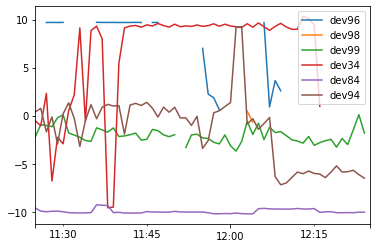

time: 917 ms


In [46]:
df_2.plot()
print(cosine_dist(df_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_2))
print("-----------------------------------------------")
print(fast_dtw(df_2))
print("-----------------------------------------------")
df_2.corr()

              comb    cosine
0   (dev96, dev98)  1.059274
1   (dev96, dev99)  1.091902
2   (dev96, dev34)  1.386184
3   (dev96, dev84)  0.280905
4   (dev96, dev94)  0.141249
5   (dev98, dev99)  0.827547
6   (dev98, dev34)  0.590313
7   (dev98, dev84)  0.946062
8   (dev98, dev94)  0.700635
9   (dev99, dev34)  0.573137
10  (dev99, dev84)  0.974641
11  (dev99, dev94)  0.683994
12  (dev34, dev84)  1.005203
13  (dev34, dev94)  0.759751
14  (dev84, dev94)  0.373499
-----------------------------------------------
              comb    cosine
0   (dev96, dev98)  0.140334
1   (dev96, dev99)  0.145147
2   (dev96, dev34)  0.289979
3   (dev96, dev84)  0.399745
4   (dev96, dev94)  0.125921
5   (dev98, dev99)  0.151811
6   (dev98, dev34)  0.185942
7   (dev98, dev84)  0.419475
8   (dev98, dev94)  0.186555
9   (dev99, dev34)  0.132786
10  (dev99, dev84)  0.383825
11  (dev99, dev94)  0.100248
12  (dev34, dev84)  0.448905
13  (dev34, dev94)  0.158135
14  (dev84, dev94)  0.384975
------------------------

dev96     dev98     dev99     dev34     dev84     dev94
dev96  1.000000  0.625791  0.493734  0.110682  0.434957  0.701071
dev98  0.625791  1.000000  0.133240  0.371707  0.213796  0.540237
dev99  0.493734  0.133240  1.000000  0.425454  0.083131  0.587571
dev34  0.110682  0.371707  0.425454  1.000000  0.037446  0.457529
dev84  0.434957  0.213796  0.083131  0.037446  1.000000  0.189759
dev94  0.701071  0.540237  0.587571  0.457529  0.189759  1.000000

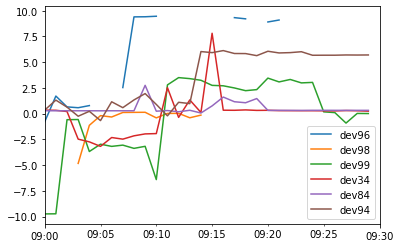

time: 759 ms


In [48]:
df_np_0.plot()
print(cosine_dist(df_np_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_0))
print("-----------------------------------------------")
print(fast_dtw(df_np_0))
print("-----------------------------------------------")
df_np_0.corr()

              comb    cosine
0   (dev96, dev98)  1.538085
1   (dev96, dev99)  0.549493
2   (dev96, dev34)  1.322259
3   (dev96, dev84)  0.753287
4   (dev96, dev94)  1.704233
5   (dev98, dev99)  1.685347
6   (dev98, dev34)  0.072457
7   (dev98, dev84)  1.763775
8   (dev98, dev94)  0.185861
9   (dev99, dev34)  1.631684
10  (dev99, dev84)  0.638162
11  (dev99, dev94)  1.506857
12  (dev34, dev84)  1.467498
13  (dev34, dev94)  0.283841
14  (dev84, dev94)  1.479903
-----------------------------------------------
              comb    cosine
0   (dev96, dev98)  0.154446
1   (dev96, dev99)  0.218984
2   (dev96, dev34)  0.235668
3   (dev96, dev84)  0.697553
4   (dev96, dev94)  0.457782
5   (dev98, dev99)  0.205756
6   (dev98, dev34)  0.474883
7   (dev98, dev84)  0.608599
8   (dev98, dev94)  0.456650
9   (dev99, dev34)  0.345346
10  (dev99, dev84)  0.464809
11  (dev99, dev94)  0.302143
12  (dev34, dev84)  0.577902
13  (dev34, dev94)  0.185169
14  (dev84, dev94)  0.547951
------------------------

dev96     dev98     dev99     dev34     dev84     dev94
dev96  1.000000  0.686365 -0.059458  0.341541 -0.462346 -0.064904
dev98  0.686365  1.000000  0.046140  0.211662 -0.586838  0.134602
dev99 -0.059458  0.046140  1.000000 -0.402796 -0.090089 -0.088601
dev34  0.341541  0.211662 -0.402796  1.000000 -0.131578  0.513870
dev84 -0.462346 -0.586838 -0.090089 -0.131578  1.000000 -0.032089
dev94 -0.064904  0.134602 -0.088601  0.513870 -0.032089  1.000000

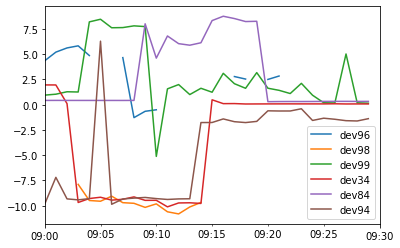

time: 650 ms


In [49]:
df_np_1.plot()
print(cosine_dist(df_np_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_1))
print("-----------------------------------------------")
print(fast_dtw(df_np_1))
print("-----------------------------------------------")
df_np_1.corr()

              comb    cosine
0   (dev96, dev98)  0.059112
1   (dev96, dev99)  0.737385
2   (dev96, dev34)  0.454720
3   (dev96, dev84)  0.145948
4   (dev96, dev94)  1.212960
5   (dev98, dev99)  0.709824
6   (dev98, dev34)  0.631894
7   (dev98, dev84)  0.188319
8   (dev98, dev94)  1.140584
9   (dev99, dev34)  0.208659
10  (dev99, dev84)  0.329530
11  (dev99, dev94)  1.809915
12  (dev34, dev84)  0.251680
13  (dev34, dev94)  1.864082
14  (dev84, dev94)  1.625736
-----------------------------------------------
              comb    cosine
0   (dev96, dev98)  0.069519
1   (dev96, dev99)  0.437298
2   (dev96, dev34)  0.400577
3   (dev96, dev84)  0.128745
4   (dev96, dev94)  0.217805
5   (dev98, dev99)  0.417595
6   (dev98, dev34)  0.463437
7   (dev98, dev84)  0.135324
8   (dev98, dev94)  0.316882
9   (dev99, dev34)  0.127326
10  (dev99, dev84)  0.223239
11  (dev99, dev94)  0.624760
12  (dev34, dev84)  0.247761
13  (dev34, dev94)  0.765006
14  (dev84, dev94)  0.343227
------------------------

dev96     dev98     dev99     dev34     dev84     dev94
dev96  1.000000  0.845624 -0.217012 -0.067603  0.608689  0.396884
dev98  0.845624  1.000000 -0.025356  0.175905  0.633290  0.078723
dev99 -0.217012 -0.025356  1.000000  0.544152 -0.169752 -0.638622
dev34 -0.067603  0.175905  0.544152  1.000000  0.020181 -0.736197
dev84  0.608689  0.633290 -0.169752  0.020181  1.000000  0.163365
dev94  0.396884  0.078723 -0.638622 -0.736197  0.163365  1.000000

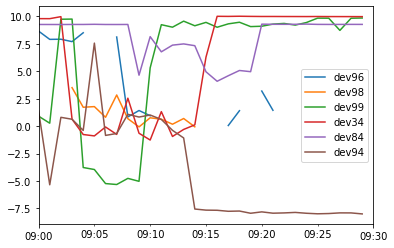

time: 812 ms


In [50]:
df_np_2.plot()
print(cosine_dist(df_np_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_2))
print("-----------------------------------------------")
print(fast_dtw(df_np_2))
print("-----------------------------------------------")
df_np_2.corr()

(array([ 6., 10.,  4.,  6., 10.,  3.,  0.,  0.,  1.,  5.]),
 array([ 33.63386672,  68.47971569, 103.32556467, 138.17141365,
        173.01726262, 207.8631116 , 242.70896058, 277.55480956,
        312.40065853, 347.24650751, 382.09235649]),
 <a list of 10 Patch objects>)

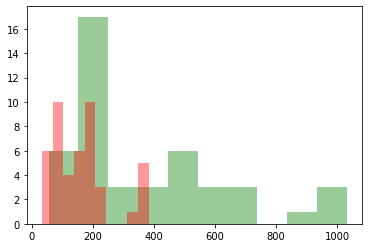

time: 2.67 s


In [52]:
all_in_proximity = list(fast_dtw(df_0)['distance']) + list(fast_dtw(df_1)['distance']) + list(fast_dtw(df_2)['distance'])
all_not_in_proximity = list(fast_dtw(df_np_0)['distance']) + list(fast_dtw(df_np_1)['distance']) + list(fast_dtw(df_np_2)['distance'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)

/u/home/oturkar/venv/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/u/home/oturkar/venv/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/u/home/oturkar/venv/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/u/home/oturkar/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/u/home/oturkar/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([7., 9., 5., 5., 4., 9., 1., 3., 0., 2.]),
 array([0.06951905, 0.13906779, 0.20861654, 0.27816528, 0.34771402,
        0.41726277, 0.48681151, 0.55636026, 0.625909  , 0.69545775,
        0.76500649]),
 <a list of 10 Patch objects>)

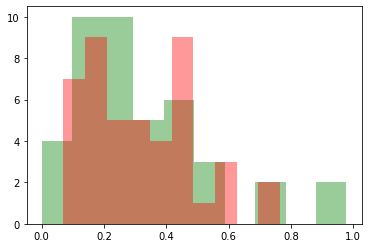

time: 710 ms


In [53]:
all_in_proximity = list(cosine_dist_normalized(df_0)['cosine']) + list(cosine_dist_normalized(df_1)['cosine']) + list(cosine_dist_normalized(df_2)['cosine'])
all_not_in_proximity = list(cosine_dist_normalized(df_np_0)['cosine']) + list(cosine_dist_normalized(df_np_1)['cosine']) + list(cosine_dist_normalized(df_np_2)['cosine'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)

In [58]:
bosch_df

_id               timestamp  device_id  double_sensor_maximum_range  \
0     1 2018-03-16 14:56:19.418         23                   156.906403   
1     2 2018-04-25 15:15:52.895         37                   156.906403   
2     3 2018-04-26 13:20:21.243         98                   156.906403   
4     5 2018-04-26 22:57:15.802         38                   156.906403   
8    10 2018-05-08 09:45:48.885         40                    78.453201   
9    13 2018-05-12 15:29:25.374        116                   156.906403   
15   19 2018-05-13 20:17:47.279         34                   156.906403   
17   21 2018-05-13 17:40:22.251        115                   156.906403   
23   28 2018-05-14 12:46:56.250        103                   156.906403   
26   31 2018-05-14 14:34:33.936         99                   156.906403   
29   34 2018-05-14 14:16:57.606         79                   156.906403   
40   48 2018-05-15 06:20:53.268         94                   156.906403   
48   63 2018-05-16 19:41:24.087        124                   156.906403   
61   80 2018-05-23 13:57:57.704         45                   156.906403   
62   81 2018-05-25 04:57:28.804         24                   156.906403   
65   84 2018-05-31 18:54:58.101         46                    78.453201   
5     6 2018-04-30 08:54:51.093         69                    39.226608   
12   16 2018-05-13 16:22:50.068         96                    39.226593   
13   17 2018-05-10 20:42:42.156        100                    78.453201   
16   20 2018-05-13 18:32:28.902         87                    39.226593   
24   29 2018-05-14 13:02:08.031         84                   156.906403   
32   37 2018-05-14 21:11:48.358        107                    39.226608   
34   39 2018-05-14 14:22:37.507        121                   156.906403   
39   46 2018-05-15 13:37:58.981          8                   156.906403   
56   75 2018-05-20 22:04:11.633         43                    39.226593   
58   77 2018-05-21 21:04:55.050         31                    39.220001   
64   83 2018-05-26 11:20:55.969         97                   156.906403   
31   36 2018-05-14 09:23:27.037        113                    39.226601   
42   51 2018-05-15 23:56:16.295         17                    39.226601   
68   87 2018-06-05 10:29:21.817        114                    39.226601   
3     4 2018-04-26 20:10:56.176        111                    39.226601   
22   26 2018-05-14 08:03:55.265         22                    19.613300   
36   42 2018-05-14 19:47:54.618         53                    19.613300   

    double_sensor_minimum_delay                                  sensor_name  \
0                          2500                         BMI160 accelerometer   
1                          2500                         BMI160 accelerometer   
2                          2500                         BMI160 accelerometer   
4                          2500                         BMI160 accelerometer   
8                          2500                         BMI160 accelerometer   
9                          5000                  BMI160 3-axis Accelerometer   
15                         2500                         BMI160 accelerometer   
17                         2500                         BMI160 accelerometer   
23                        10000                         3-axis Accelerometer   
26                        10000                         3-axis Accelerometer   
29                        10000                         3-axis Accelerometer   
40                         2500                         BMI160 accelerometer   
48                        10000                         3-axis Accelerometer   
61                        10000                         3-axis Accelerometer   
62                         2500                         BMI160 accelerometer   
65                         2500                         BMI160 Accelerometer   
5                          2500                         BMI160 Accelerometer   
12           

time: 285 ms


In [151]:
df_1.columns

Index(['dev24'], dtype='object')

time: 676 ms


#### Event 2 ####

In [101]:
start = "2018-05-29 12:55:00"
end = "2018-05-29 13:15:00"


start_np = "2018-05-29 09:00:00"
end_np = "2018-05-29 09:30:00"

focus_on = [96, 97, 98, 84, 24, 94]

data_acc_filtered = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
data_acc_filtered_np = data_acc[(data_acc['timestamp'] >= start_np) & (data_acc['timestamp'] <= end_np)]
df_0 = aggregate_signals(data_acc_filtered, ["double_values_0"], "1min", [start, end], list(focus_on))
df_np_0 = aggregate_signals(data_acc_filtered_np, ["double_values_0"], "1min", [start_np, end_np], list(focus_on))
df_1 = aggregate_signals(data_acc_filtered, ["double_values_1"], "1min", [start, end], list(focus_on))
df_np_1 = aggregate_signals(data_acc_filtered_np, ["double_values_1"], "1min", [start_np, end_np], list(focus_on))
df_2 = aggregate_signals(data_acc_filtered, ["double_values_2"], "1min", [start, end], list(focus_on))
df_np_2 = aggregate_signals(data_acc_filtered_np, ["double_values_2"], "1min", [start_np, end_np], list(focus_on))

time: 33.5 s


             comb    cosine
0  (dev97, dev98)  0.965108
1  (dev97, dev24)  1.303950
2  (dev98, dev24)  1.176427
-----------------------------------------------
             comb    cosine
0  (dev97, dev98)  0.189519
1  (dev97, dev24)  0.265601
2  (dev98, dev24)  0.265367
-----------------------------------------------
             comb   distance
0  (dev97, dev98)  80.742668
1  (dev97, dev24)  62.037638
2  (dev98, dev24)  26.693985
-----------------------------------------------


dev97     dev98     dev24
dev97  1.000000 -0.006631 -0.268372
dev98 -0.006631  1.000000 -0.095055
dev24 -0.268372 -0.095055  1.000000

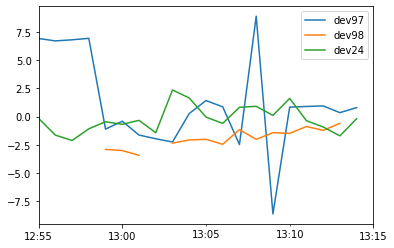

time: 442 ms


In [102]:
df_0.plot()
print(cosine_dist(df_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_0))
print("-----------------------------------------------")
print(fast_dtw(df_0))
print("-----------------------------------------------")
df_0.corr()

             comb    cosine
0  (dev97, dev98)  0.085160
1  (dev97, dev24)  1.442106
2  (dev98, dev24)  1.500774
-----------------------------------------------
             comb    cosine
0  (dev97, dev98)  0.375773
1  (dev97, dev24)  0.450826
2  (dev98, dev24)  0.119694
-----------------------------------------------
             comb    distance
0  (dev97, dev98)   76.669502
1  (dev97, dev24)  226.566810
2  (dev98, dev24)  244.369266
-----------------------------------------------


dev97     dev98     dev24
dev97  1.000000 -0.278822 -0.484292
dev98 -0.278822  1.000000  0.247558
dev24 -0.484292  0.247558  1.000000

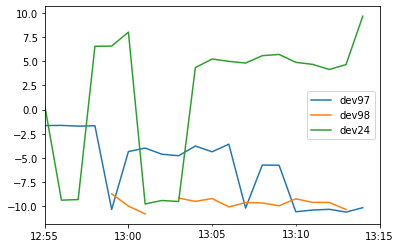

time: 344 ms


In [103]:
df_1.plot()
print(cosine_dist(df_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_1))
print("-----------------------------------------------")
print(fast_dtw(df_1))
print("-----------------------------------------------")
df_1.corr()

             comb    cosine
0  (dev97, dev98)  1.543592
1  (dev97, dev24)  0.531166
2  (dev98, dev24)  1.657942
-----------------------------------------------
             comb    cosine
0  (dev97, dev98)  0.319564
1  (dev97, dev24)  0.288566
2  (dev98, dev24)  0.096705
-----------------------------------------------
             comb    distance
0  (dev97, dev98)  125.173868
1  (dev97, dev24)   61.779184
2  (dev98, dev24)  146.273758
-----------------------------------------------


dev97     dev98     dev24
dev97  1.000000 -0.032484 -0.374892
dev98 -0.032484  1.000000  0.252891
dev24 -0.374892  0.252891  1.000000

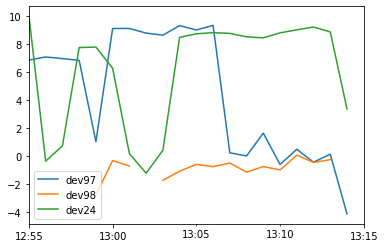

time: 365 ms


In [104]:
df_2.plot()
print(cosine_dist(df_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_2))
print("-----------------------------------------------")
print(fast_dtw(df_2))
print("-----------------------------------------------")
df_2.corr()

             comb    cosine
0  (dev97, dev24)  1.456554
-----------------------------------------------
             comb    cosine
0  (dev97, dev24)  0.424119
-----------------------------------------------
             comb   distance
0  (dev97, dev24)  60.901718
-----------------------------------------------


dev97     dev24
dev97  1.000000 -0.156005
dev24 -0.156005  1.000000

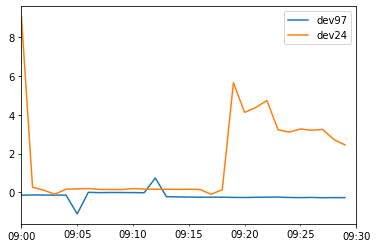

time: 294 ms


In [105]:
df_np_0.plot()
print(cosine_dist(df_np_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_0))
print("-----------------------------------------------")
print(fast_dtw(df_np_0))
print("-----------------------------------------------")
df_np_0.corr()

             comb    cosine
0  (dev97, dev24)  0.567723
-----------------------------------------------
             comb    cosine
0  (dev97, dev24)  0.448271
-----------------------------------------------
             comb    distance
0  (dev97, dev24)  128.113309
-----------------------------------------------


dev97     dev24
dev97  1.000000  0.329949
dev24  0.329949  1.000000

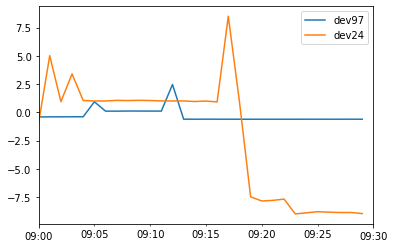

time: 301 ms


In [106]:
df_np_1.plot()
print(cosine_dist(df_np_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_1))
print("-----------------------------------------------")
print(fast_dtw(df_np_1))
print("-----------------------------------------------")
df_np_1.corr()

             comb    cosine
0  (dev97, dev24)  0.117009
-----------------------------------------------
             comb    cosine
0  (dev97, dev24)  0.193023
-----------------------------------------------
             comb    distance
0  (dev97, dev24)  103.685645
-----------------------------------------------


dev97     dev24
dev97  1.000000 -0.212594
dev24 -0.212594  1.000000

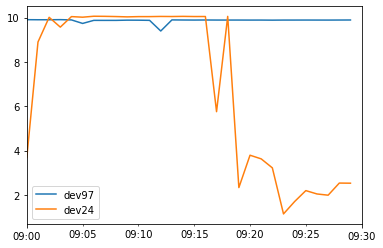

time: 326 ms


In [107]:
df_np_2.plot()
print(cosine_dist(df_np_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_2))
print("-----------------------------------------------")
print(fast_dtw(df_np_2))
print("-----------------------------------------------")
df_np_2.corr()

In [ ]:
all_in_proximity = list(fast_dtw(df_0)['distance']) + list(fast_dtw(df_1)['distance']) + list(fast_dtw(df_2)['distance'])
all_not_in_proximity = list(fast_dtw(df_np_0)['distance']) + list(fast_dtw(df_np_1)['distance']) + list(fast_dtw(df_np_2)['distance'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)

In [ ]:
all_in_proximity = list(cosine_dist_normalized(df_0)['cosine']) + list(cosine_dist_normalized(df_1)['cosine']) + list(cosine_dist_normalized(df_2)['cosine'])
all_not_in_proximity = list(cosine_dist_normalized(df_np_0)['cosine']) + list(cosine_dist_normalized(df_np_1)['cosine']) + list(cosine_dist_normalized(df_np_2)['cosine'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)

#### Event 3####

Empty DataFrame
Columns: [comb, cosine]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, cosine]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, distance]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, cosine]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, cosine]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, distance]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, cosine]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, cosine]
Index: []
-----------------------------------------------
Empty DataFrame
Columns: [comb, distance]
Index: []
-----------------------------------------------
             comb    cosine
0  (dev97, dev24)  1.456554
-----------------------------------------------
        

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([0.19302274, 0.21854754, 0.24407233, 0.26959712, 0.29512191,
        0.3206467 , 0.34617149, 0.37169628, 0.39722107, 0.42274586,
        0.44827065]),
 <a list of 10 Patch objects>)

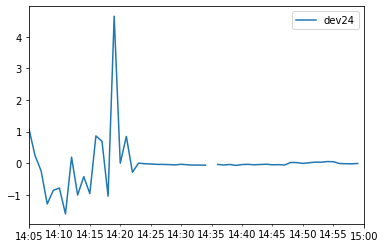

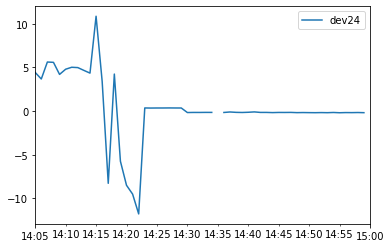

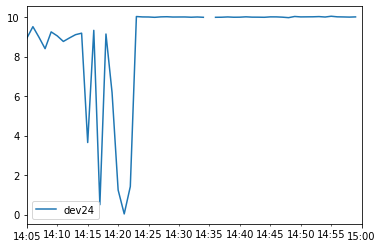

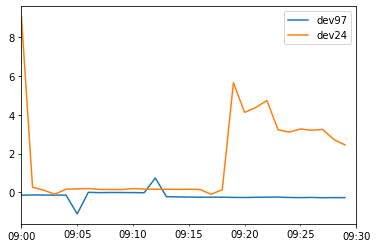

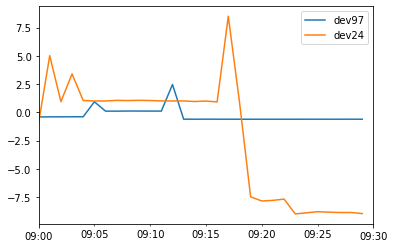

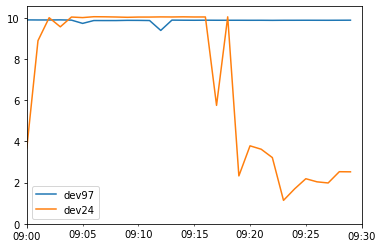

time: 17.3 s


In [115]:
start = "2018-06-18 14:05:00"
end = "2018-06-18 15:00:00"


start_np = "2018-06-18 09:00:00"
end_np = "2018-06-18 09:30:00"

focus_on = [96, 97, 98, 84, 24]

data_acc_filtered = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
data_acc_filtered_np = data_acc[(data_acc['timestamp'] >= start_np) & (data_acc['timestamp'] <= end_np)]
df_0 = aggregate_signals(data_acc_filtered, ["double_values_0"], "1min", [start, end], list(focus_on))
df_np_0 = aggregate_signals(data_acc_filtered_np, ["double_values_0"], "1min", [start_np, end_np], list(focus_on))
df_1 = aggregate_signals(data_acc_filtered, ["double_values_1"], "1min", [start, end], list(focus_on))
df_np_1 = aggregate_signals(data_acc_filtered_np, ["double_values_1"], "1min", [start_np, end_np], list(focus_on))
df_2 = aggregate_signals(data_acc_filtered, ["double_values_2"], "1min", [start, end], list(focus_on))
df_np_2 = aggregate_signals(data_acc_filtered_np, ["double_values_2"], "1min", [start_np, end_np], list(focus_on))

df_0.plot()
print(cosine_dist(df_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_0))
print("-----------------------------------------------")
print(fast_dtw(df_0))
print("-----------------------------------------------")
df_0.corr()

df_1.plot()
print(cosine_dist(df_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_1))
print("-----------------------------------------------")
print(fast_dtw(df_1))
print("-----------------------------------------------")
df_1.corr()

df_2.plot()
print(cosine_dist(df_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_2))
print("-----------------------------------------------")
print(fast_dtw(df_2))
print("-----------------------------------------------")
df_2.corr()

df_np_0.plot()
print(cosine_dist(df_np_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_0))
print("-----------------------------------------------")
print(fast_dtw(df_np_0))
print("-----------------------------------------------")
df_np_0.corr()

df_np_1.plot()
print(cosine_dist(df_np_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_1))
print("-----------------------------------------------")
print(fast_dtw(df_np_1))
print("-----------------------------------------------")
df_np_1.corr()

df_np_2.plot()
print(cosine_dist(df_np_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_2))
print("-----------------------------------------------")
print(fast_dtw(df_np_2))
print("-----------------------------------------------")
df_np_2.corr()

all_in_proximity = list(fast_dtw(df_0)['distance']) + list(fast_dtw(df_1)['distance']) + list(fast_dtw(df_2)['distance'])
all_not_in_proximity = list(fast_dtw(df_np_0)['distance']) + list(fast_dtw(df_np_1)['distance']) + list(fast_dtw(df_np_2)['distance'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)

all_in_proximity = list(cosine_dist_normalized(df_0)['cosine']) + list(cosine_dist_normalized(df_1)['cosine']) + list(cosine_dist_normalized(df_2)['cosine'])
all_not_in_proximity = list(cosine_dist_normalized(df_np_0)['cosine']) + list(cosine_dist_normalized(df_np_1)['cosine']) + list(cosine_dist_normalized(df_np_2)['cosine'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)        

### STMi Analysis ###

In [74]:
top_sensor_vender_acc

array(['STMicroelectronics', 'Bosch', 'BOSCH', 'STM', 'Invensense',
       'Invensense Inc.', 'Bosch Sensortec GmbH', 'Bosch Sensortec',
       'MTK', 'Kionix', 'hTC Corp.', 'KIONIX', 'Intel Inc.'], dtype=object)

time: 4.75 ms


In [77]:
stm = list(acc_meta[acc_meta['sensor_vendor'] == top_sensor_vender_acc[0]]["device_id"]) + list(acc_meta[acc_meta['sensor_vendor'] == top_sensor_vender_acc[3]]["device_id"])
stm_df = pd.concat([acc_meta[acc_meta['sensor_vendor'] == top_sensor_vender_acc[0]], acc_meta[acc_meta['sensor_vendor'] == top_sensor_vender_acc[3]]])

time: 80.7 ms


In [78]:
p_list = []
same_group_list = []
for groups in list(wifi_proximity["groups"]):
    point = 0
    group_vendor = []
    for group in groups:
        x = set(stm).intersection(group)
        if len(x) > 1:
            point = point + len(x)
            group_vendor = group_vendor + list(x)
    p_list.append(point)
    same_group_list.append(group_vendor)

time: 550 ms


4 5458


/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


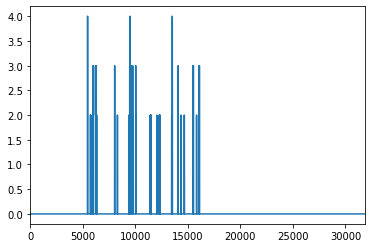

time: 307 ms


In [86]:
wifi_proximity["p_list"] = p_list
wifi_proximity["p_group"] = same_group_list
print(wifi_proximity["p_list"].max(), wifi_proximity["p_list"].argmax())
wifi_proximity["p_list"].plot()

In [88]:
wifi_proximity[5450:5500]

timestamp                                            devices  \
5450 2018-05-14 14:10:00  [[48, 57, 96, 115], [57, 84, 115], [57, 84, 96...   
5451 2018-05-14 14:15:00  [[48, 57, 96, 115], [57, 84, 115], [57, 84, 96...   
5452 2018-05-14 14:20:00  [[48, 82, 84, 85, 93, 96, 115], [48, 57, 84], ...   
5453 2018-05-14 14:25:00  [[48, 82, 84, 85, 93, 96, 115], [48, 57, 82, 8...   
5454 2018-05-14 14:30:00  [[48, 82, 84, 85, 93, 96, 115], [48, 57, 82, 8...   
5455 2018-05-14 14:35:00  [[48, 82, 84, 85, 99, 104, 115], [48, 57, 82, ...   
5456 2018-05-14 14:40:00  [[48, 57, 82], [48, 104, 115], [48, 82, 84, 85...   
5457 2018-05-14 14:45:00  [[48, 82, 84, 85, 99, 104, 115], [48, 104, 115...   
5458 2018-05-14 14:50:00  [[48, 104, 115], [28, 48, 82, 84, 85, 99, 104,...   
5459 2018-05-14 14:55:00  [[48, 104, 115], [48, 82, 84, 104, 115], [28, ...   
5460 2018-05-14 15:00:00  [[48, 104, 115], [82, 84, 104, 115], [82, 104,...   
5461 2018-05-14 15:05:00  [[84, 99, 104], [48, 104, 115], [48, 99, 104, ...   
5462 2018-05-14 15:10:00  [[28, 48, 57, 82, 99, 104, 115], [48, 99, 104,...   
5463 2018-05-14 15:15:00  [[28, 48, 57, 82, 84, 99, 115], [28, 48, 57, 8...   
5464 2018-05-14 15:20:00  [[28, 48, 57, 82, 84, 99, 115], [28, 48, 57, 8...   
5465 2018-05-14 15:25:00  [[28, 48, 57, 82, 84, 99, 115], [28, 48, 57, 8...   
5466 2018-05-14 15:30:00  [[28, 48, 57, 82, 84, 99, 115], [28, 48, 99, 1...   
5467 2018-05-14 15:35:00  [[28, 48, 57, 82, 84, 99, 115], [28, 48, 99, 1...   
5468 2018-05-14 15:40:00  [[28, 48, 57, 82, 84, 99, 115], [28, 48, 57, 8...   
5469 2018-05-14 15:45:00  [[28, 48, 57, 82, 84, 99, 115], [28, 48, 57, 8...   
5470 2018-05-14 15:50:00  [[28, 48, 57, 82, 84, 99, 115], [28, 48, 57, 8...   
5471 2018-05-14 15:55:00  [[28, 48, 57, 82, 84, 99, 115], [34, 48], [28,...   
5472 2018-05-14 16:00:00  [[34, 48], [28, 48, 57, 84, 99, 115], [28, 57,...   
5473 2018-05-14 16:05:00  [[34, 48], [28, 57, 82, 84], [96, 99, 115], [2...   
5474 2018-05-14 16:10:00  [[28, 82, 96], [28, 84], [98, 99], [28, 48, 82...   
5475 2018-05-14 16:15:00                                         [[82, 84]]   
5476 2018-05-14 16:20:00                                                 []   
5477 2018-05-14 16:25:00                                                 []   
5478 2018-05-14 16:30:00                                                 []   
5479 2018-05-14 16:35:00                                                 []   
5480 2018-05-14 16:40:00                                                 []   
5481 2018-05-14 16:45:00                                                 []   
5482 2018-05-14 16:50:00                                                 []   
5483 2018-05-14 16:55:00                                                 []   
5484 2018-05-14 17:00:00                                                 []   
5485 2018-05-14 17:05:00                                                 []   
5486 2018-05-14 17:10:00                                                 []   
5487 2018-05-14 17:15:00                                                 []   
5488 2018-05-14 17:20:00                                                 []   
5489 2018-05-14 17:25:00                                                 []   
5490 2018-05-14 17:30:00                                                 []   
5491 2018-05-14 17:35:00                                                 []   
5492 2018-05-14 17:40:00                                                 []   
5493 2018-05-14 17:45:00                                                 []   
5494 2018-05-14 17:50:00                                                 []   
5495 2018-05-14 17:55:00                                                 []   
5496 2018-05-14 18:00:00                                                 []   
5497 2018-05-14 18:05:00                                                 []   
5498 2018-05-14 18:10:00                                                 []   
5499 2018-05-14 18:15:00                                         

time: 245 ms


In [89]:
start = "2018-05-14 14:50:00"
end = "2018-05-14 15:20:00"


start_np = "2018-05-14 16:20:00"
end_np = "2018-05-14 16:50:00"

focus_on = [104, 57, 48, 28]

data_acc_filtered = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
data_acc_filtered_np = data_acc[(data_acc['timestamp'] >= start_np) & (data_acc['timestamp'] <= end_np)]
df_0 = aggregate_signals(data_acc_filtered, ["double_values_0"], "1min", [start, end], list(focus_on))
df_np_0 = aggregate_signals(data_acc_filtered_np, ["double_values_0"], "1min", [start_np, end_np], list(focus_on))
df_1 = aggregate_signals(data_acc_filtered, ["double_values_1"], "1min", [start, end], list(focus_on))
df_np_1 = aggregate_signals(data_acc_filtered_np, ["double_values_1"], "1min", [start_np, end_np], list(focus_on))
df_2 = aggregate_signals(data_acc_filtered, ["double_values_2"], "1min", [start, end], list(focus_on))
df_np_2 = aggregate_signals(data_acc_filtered_np, ["double_values_2"], "1min", [start_np, end_np], list(focus_on))

time: 23.6 s


              comb    cosine
0  (dev104, dev57)  0.592117
1  (dev104, dev48)  1.088078
2  (dev104, dev28)  0.901630
3   (dev57, dev48)  0.738624
4   (dev57, dev28)  0.542039
5   (dev48, dev28)  0.188577
-----------------------------------------------
              comb    cosine
0  (dev104, dev57)  0.524194
1  (dev104, dev48)  0.210460
2  (dev104, dev28)  0.110364
3   (dev57, dev48)  0.217815
4   (dev57, dev28)  0.196273
5   (dev48, dev28)  0.073779
-----------------------------------------------
              comb    distance
0  (dev104, dev57)  246.268809
1  (dev104, dev48)   26.695122
2  (dev104, dev28)   18.297064
3   (dev57, dev48)  264.740781
4   (dev57, dev28)  246.741485
5   (dev48, dev28)   20.359441
-----------------------------------------------


dev104     dev57     dev48     dev28
dev104  1.000000 -0.400146 -0.183827  0.091762
dev57  -0.400146  1.000000  0.438457  0.077812
dev48  -0.183827  0.438457  1.000000  0.798029
dev28   0.091762  0.077812  0.798029  1.000000

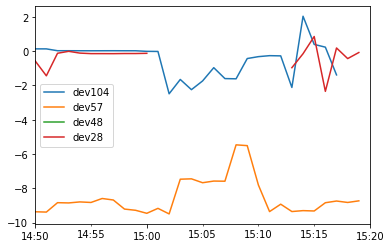

time: 492 ms


In [90]:
df_0.plot()
print(cosine_dist(df_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_0))
print("-----------------------------------------------")
print(fast_dtw(df_0))
print("-----------------------------------------------")
df_0.corr()

              comb    cosine
0  (dev104, dev57)  1.352936
1  (dev104, dev48)  1.018035
2  (dev104, dev28)  0.887729
3   (dev57, dev48)  0.554710
4   (dev57, dev28)  1.237097
5   (dev48, dev28)  1.005253
-----------------------------------------------
              comb    cosine
0  (dev104, dev57)  0.442159
1  (dev104, dev48)  0.489434
2  (dev104, dev28)  0.529140
3   (dev57, dev48)  0.410614
4   (dev57, dev28)  0.865098
5   (dev48, dev28)  0.977098
-----------------------------------------------
              comb    distance
0  (dev104, dev57)  163.612591
1  (dev104, dev48)  210.647768
2  (dev104, dev28)  191.963733
3   (dev57, dev48)   68.007175
4   (dev57, dev28)   51.346281
5   (dev48, dev28)   56.364213
-----------------------------------------------


dev104     dev57     dev48     dev28
dev104  1.000000 -0.193432  0.170629 -0.046900
dev57  -0.193432  1.000000  0.346759 -0.578130
dev48   0.170629  0.346759  1.000000 -0.782419
dev28  -0.046900 -0.578130 -0.782419  1.000000

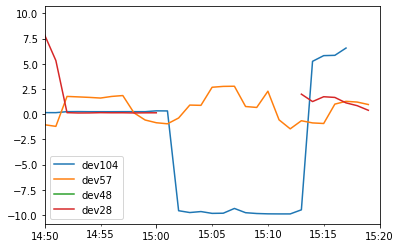

time: 461 ms


In [91]:
df_1.plot()
print(cosine_dist(df_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_1))
print("-----------------------------------------------")
print(fast_dtw(df_1))
print("-----------------------------------------------")
df_1.corr()

              comb    cosine
0  (dev104, dev57)  0.737142
1  (dev104, dev48)  0.330672
2  (dev104, dev28)  0.056909
3   (dev57, dev48)  0.479356
4   (dev57, dev28)  0.394581
5   (dev48, dev28)  0.149524
-----------------------------------------------
              comb    cosine
0  (dev104, dev57)  0.384182
1  (dev104, dev48)  0.328308
2  (dev104, dev28)  0.078924
3   (dev57, dev48)  0.281040
4   (dev57, dev28)  0.136912
5   (dev48, dev28)  0.610751
-----------------------------------------------
              comb    distance
0  (dev104, dev57)  150.066093
1  (dev104, dev48)   75.494866
2  (dev104, dev28)  169.903410
3   (dev57, dev48)  162.573860
4   (dev57, dev28)  193.517801
5   (dev48, dev28)   78.106391
-----------------------------------------------


dev104     dev57     dev48     dev28
dev104  1.000000 -0.466234 -0.362128 -0.069033
dev57  -0.466234  1.000000 -0.262316 -0.131404
dev48  -0.362128 -0.262316  1.000000 -0.758157
dev28  -0.069033 -0.131404 -0.758157  1.000000

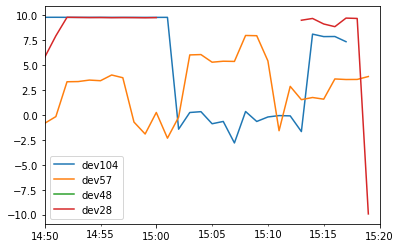

time: 454 ms


In [92]:
df_2.plot()
print(cosine_dist(df_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_2))
print("-----------------------------------------------")
print(fast_dtw(df_2))
print("-----------------------------------------------")
df_2.corr()

             comb    cosine
0  (dev57, dev48)  0.205531
1  (dev57, dev28)  0.640717
2  (dev48, dev28)  0.424661
-----------------------------------------------
             comb    cosine
0  (dev57, dev48)  0.401634
1  (dev57, dev28)  0.211563
2  (dev48, dev28)  0.296887
-----------------------------------------------
             comb    distance
0  (dev57, dev48)  122.063841
1  (dev57, dev28)  144.852721
2  (dev48, dev28)  271.336930
-----------------------------------------------


dev57     dev48     dev28
dev57  1.000000 -0.297938  0.102698
dev48 -0.297938  1.000000  0.214022
dev28  0.102698  0.214022  1.000000

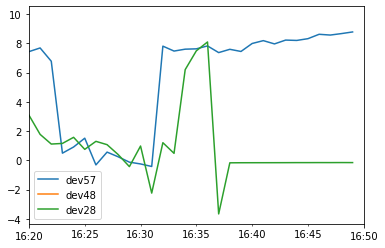

time: 385 ms


In [93]:
df_np_0.plot()
print(cosine_dist(df_np_0))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_0))
print("-----------------------------------------------")
print(fast_dtw(df_np_0))
print("-----------------------------------------------")
df_np_0.corr()

             comb    cosine
0  (dev57, dev48)  0.598193
1  (dev57, dev28)  0.595228
2  (dev48, dev28)  0.830759
-----------------------------------------------
             comb    cosine
0  (dev57, dev48)  0.671099
1  (dev57, dev28)  0.130251
2  (dev48, dev28)  0.737239
-----------------------------------------------
             comb   distance
0  (dev57, dev48)  98.508933
1  (dev57, dev28)  90.509495
2  (dev48, dev28)  80.772409
-----------------------------------------------


dev57     dev48     dev28
dev57  1.000000 -0.404610  0.342883
dev48 -0.404610  1.000000 -0.604606
dev28  0.342883 -0.604606  1.000000

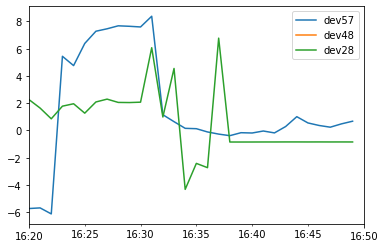

time: 384 ms


In [94]:
df_np_1.plot()
print(cosine_dist(df_np_1))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_1))
print("-----------------------------------------------")
print(fast_dtw(df_np_1))
print("-----------------------------------------------")
df_np_1.corr()

             comb    cosine
0  (dev57, dev48)  0.262792
1  (dev57, dev28)  0.893419
2  (dev48, dev28)  1.002360
-----------------------------------------------
             comb    cosine
0  (dev57, dev48)  0.346401
1  (dev57, dev28)  0.263074
2  (dev48, dev28)  0.546390
-----------------------------------------------
             comb    distance
0  (dev57, dev48)  163.977525
1  (dev57, dev28)  181.376126
2  (dev48, dev28)  269.453815
-----------------------------------------------


dev57     dev48     dev28
dev57  1.000000  0.261902  0.075132
dev48  0.261902  1.000000 -0.187672
dev28  0.075132 -0.187672  1.000000

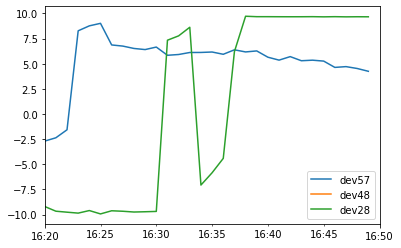

time: 413 ms


In [95]:
df_np_2.plot()
print(cosine_dist(df_np_2))
print("-----------------------------------------------")
print(cosine_dist_normalized(df_np_2))
print("-----------------------------------------------")
print(fast_dtw(df_np_2))
print("-----------------------------------------------")
df_np_2.corr()

In [ ]:
all_in_proximity = list(fast_dtw(df_0)['distance']) + list(fast_dtw(df_1)['distance']) + list(fast_dtw(df_2)['distance'])
all_not_in_proximity = list(fast_dtw(df_np_0)['distance']) + list(fast_dtw(df_np_1)['distance']) + list(fast_dtw(df_np_2)['distance'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)

In [ ]:
all_in_proximity = list(cosine_dist_normalized(df_0)['cosine']) + list(cosine_dist_normalized(df_1)['cosine']) + list(cosine_dist_normalized(df_2)['cosine'])
all_not_in_proximity = list(cosine_dist_normalized(df_np_0)['cosine']) + list(cosine_dist_normalized(df_np_1)['cosine']) + list(cosine_dist_normalized(df_np_2)['cosine'])
plt.hist(all_in_proximity,bins=10,color = 'green',alpha = 0.4)
plt.hist(all_not_in_proximity,bins=10,color = 'red',alpha = 0.4)

In [ ]:
stm_df

c = ["#c0ffb3","#52de97","#3c9d9b","#394a6d","#fbe555","#fb9224","#f45905","#2a1a5e","#db75c5"]
c_i = 0
t = [x.lower() for x in bosch_df['sensor_name']]
bosch_df['sensor_name'] = t
bosch_sensors = np.unique(bosch_df['sensor_name'])

### Variance Window Calculation###

#### Bosch Event 1 ####

In [403]:
start = "2018-05-16 11:25:00"
end = "2018-05-16 14:30:00"


start_np = "2018-05-16 15:00:00"
end_np = "2018-05-16 16:00:00"

focus_on = [96, 98, 99, 115, 84, 94]

data_acc_filtered = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
data_acc_filtered_np = data_acc[(data_acc['timestamp'] >= start_np) & (data_acc['timestamp'] <= end_np)]
df_0 = aggregate_signals(data_acc_filtered, ["double_values_0"], "30s", [start, end], list(focus_on))
df_np_0 = aggregate_signals(data_acc_filtered_np, ["double_values_0"], "30s", [start_np, end_np], list(focus_on))
df_1 = aggregate_signals(data_acc_filtered, ["double_values_1"], "30s", [start, end], list(focus_on))
df_np_1 = aggregate_signals(data_acc_filtered_np, ["double_values_1"], "30s", [start_np, end_np], list(focus_on))
df_2 = aggregate_signals(data_acc_filtered, ["double_values_2"], "30s", [start, end], list(focus_on))
df_np_2 = aggregate_signals(data_acc_filtered_np, ["double_values_2"], "30s", [start_np, end_np], list(focus_on))

time: 22.5 s


       dev96  dev98     dev99     dev84     dev94
dev96    NaN    NaN       NaN       NaN       NaN
dev98    NaN    NaN       NaN       NaN       NaN
dev99    NaN    NaN  1.000000  0.525226  0.587785
dev84    NaN    NaN  0.525226  1.000000  0.727944
dev94    NaN    NaN  0.587785  0.727944  1.000000


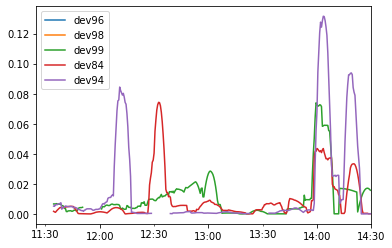

time: 805 ms


In [420]:
df_0_normalized_var = normalize_variance_algo(df_0)
print(df_0_normalized_var.corr())
df_0_normalized_var.plot()

       dev96  dev98     dev99     dev84     dev94
dev96    NaN    NaN       NaN       NaN       NaN
dev98    NaN    NaN       NaN       NaN       NaN
dev99    NaN    NaN  1.000000 -0.202786 -0.338901
dev84    NaN    NaN -0.202786  1.000000  0.403551
dev94    NaN    NaN -0.338901  0.403551  1.000000


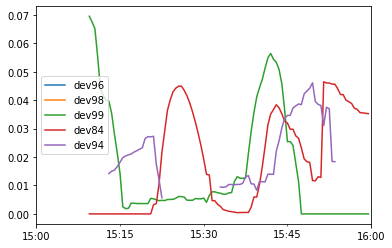

time: 732 ms


In [421]:
df_np_var_0 = normalize_variance_algo(df_np_0)
print(df_np_var_0.corr())
df_np_var_0.plot()

       dev96  dev98     dev99     dev84     dev94
dev96    NaN    NaN       NaN       NaN       NaN
dev98    NaN    NaN       NaN       NaN       NaN
dev99    NaN    NaN  1.000000  0.632140  0.216779
dev84    NaN    NaN  0.632140  1.000000  0.549553
dev94    NaN    NaN  0.216779  0.549553  1.000000


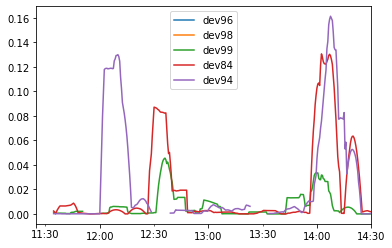

time: 1.34 s


In [422]:
df_1_normalized_var = normalize_variance_algo(df_1)
print(df_1_normalized_var.corr())
df_1_normalized_var.plot()

       dev96  dev98     dev99     dev84     dev94
dev96    NaN    NaN       NaN       NaN       NaN
dev98    NaN    NaN       NaN       NaN       NaN
dev99    NaN    NaN  1.000000  0.364540 -0.508855
dev84    NaN    NaN  0.364540  1.000000 -0.121385
dev94    NaN    NaN -0.508855 -0.121385  1.000000


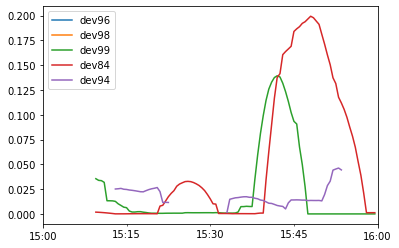

time: 631 ms


In [423]:
df_np_var_1 = normalize_variance_algo(df_np_1)
print(df_np_var_1.corr())
df_np_var_1.plot()

       dev96  dev98     dev99     dev84     dev94
dev96    NaN    NaN       NaN       NaN       NaN
dev98    NaN    NaN       NaN       NaN       NaN
dev99    NaN    NaN  1.000000  0.111128 -0.055455
dev84    NaN    NaN  0.111128  1.000000  0.449148
dev94    NaN    NaN -0.055455  0.449148  1.000000


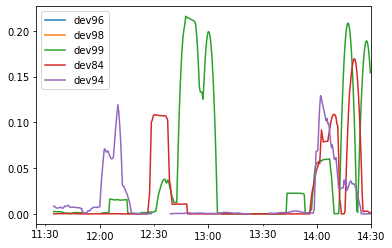

time: 802 ms


In [424]:
df_2_normalized_var = normalize_variance_algo(df_2)
print(df_2_normalized_var.corr())
df_2_normalized_var.plot()

       dev96  dev98     dev99     dev84     dev94
dev96    NaN    NaN       NaN       NaN       NaN
dev98    NaN    NaN       NaN       NaN       NaN
dev99    NaN    NaN  1.000000 -0.178541 -0.014220
dev84    NaN    NaN -0.178541  1.000000  0.748935
dev94    NaN    NaN -0.014220  0.748935  1.000000


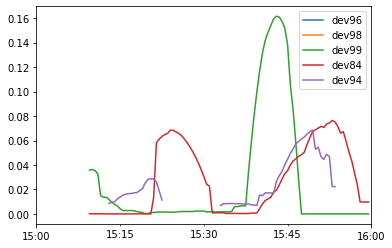

time: 1.04 s


In [425]:
df_np_var_2 = normalize_variance_algo(df_np_2)
print(df_np_var_2.corr())
df_np_var_2.plot()

In [ ]:
df_0_normalized.rolling(window=20).var().corr()

#### STMi Event ####

In [482]:
start = "2018-05-14 14:50:00"
end = "2018-05-14 15:20:00"


start_np = "2018-05-14 16:20:00"
end_np = "2018-05-14 16:50:00"

focus_on = [104, 57, 48, 28]

data_acc_filtered = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
data_acc_filtered_np = data_acc[(data_acc['timestamp'] >= start_np) & (data_acc['timestamp'] <= end_np)]
df_0 = aggregate_signals(data_acc_filtered, ["double_values_0"], "30s", [start, end], list(focus_on))
df_np_0 = aggregate_signals(data_acc_filtered_np, ["double_values_0"], "30s", [start_np, end_np], list(focus_on))
df_1 = aggregate_signals(data_acc_filtered, ["double_values_1"], "30s", [start, end], list(focus_on))
df_np_1 = aggregate_signals(data_acc_filtered_np, ["double_values_1"], "30s", [start_np, end_np], list(focus_on))
df_2 = aggregate_signals(data_acc_filtered, ["double_values_2"], "30s", [start, end], list(focus_on))
df_np_2 = aggregate_signals(data_acc_filtered_np, ["double_values_2"], "30s", [start_np, end_np], list(focus_on))

time: 16.1 s


          dev104     dev57  dev48  dev28
dev104  1.000000  0.375125    NaN    NaN
dev57   0.375125  1.000000    NaN   -1.0
dev48        NaN       NaN    NaN    NaN
dev28        NaN -1.000000    NaN    1.0


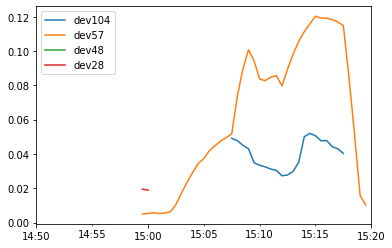

time: 303 ms


In [483]:
df_0_normalized_var = normalize_variance_algo(df_0)
print(df_0_normalized_var.corr())
df_0_normalized_var.plot()

          dev57  dev48     dev28
dev57  1.000000    NaN  0.518929
dev48       NaN    NaN       NaN
dev28  0.518929    NaN  1.000000


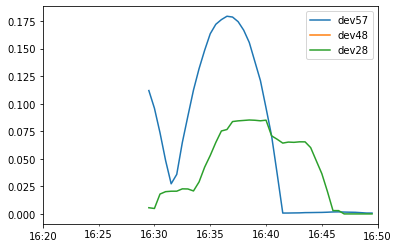

time: 297 ms


In [484]:
df_np_var_0 = normalize_variance_algo(df_np_0)
print(df_np_var_0.corr())
df_np_var_0.plot()

          dev104     dev57  dev48  dev28
dev104  1.000000 -0.067583    NaN    NaN
dev57  -0.067583  1.000000    NaN    1.0
dev48        NaN       NaN    NaN    NaN
dev28        NaN  1.000000    NaN    1.0


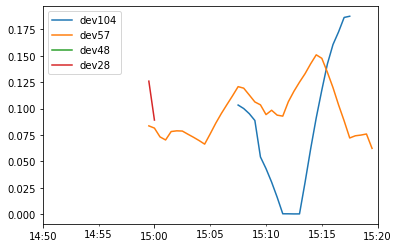

time: 304 ms


In [485]:
df_1_normalized_var = normalize_variance_algo(df_1)
print(df_1_normalized_var.corr())
df_1_normalized_var.plot()

          dev57  dev48     dev28
dev57  1.000000    NaN  0.138267
dev48       NaN    NaN       NaN
dev28  0.138267    NaN  1.000000


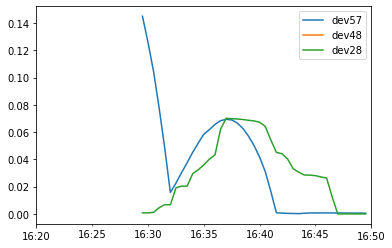

time: 290 ms


In [486]:
df_np_var_1 = normalize_variance_algo(df_np_1)
print(df_np_var_1.corr())
df_np_var_1.plot()

          dev104     dev57  dev48  dev28
dev104  1.000000  0.653865    NaN    NaN
dev57   0.653865  1.000000    NaN    1.0
dev48        NaN       NaN    NaN    NaN
dev28        NaN  1.000000    NaN    1.0


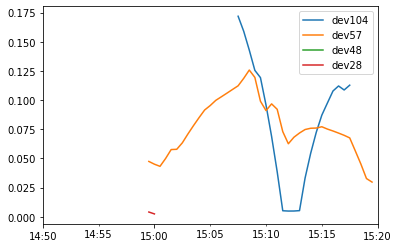

time: 310 ms


In [487]:
df_2_normalized_var = normalize_variance_algo(df_2)
print(df_2_normalized_var.corr())
df_2_normalized_var.plot()

          dev57  dev48     dev28
dev57  1.000000    NaN -0.352707
dev48       NaN    NaN       NaN
dev28 -0.352707    NaN  1.000000


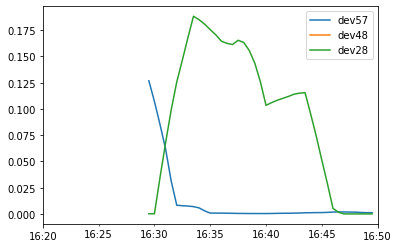

time: 297 ms


In [488]:
df_np_var_2 = normalize_variance_algo(df_np_2)
print(df_np_var_2.corr())
df_np_var_2.plot()

In [500]:
data_acc.device_id()

_id               timestamp  device_id  double_values_0  \
0  92018860 2018-05-14 19:48:42.920       99.0         0.047884   
1  92018861 2018-05-14 19:48:43.121       99.0         0.004788   
2  92018862 2018-05-14 19:48:43.321       99.0         0.000000   
3  92018863 2018-05-14 19:48:43.522       99.0         0.009577   
4  92018864 2018-05-14 19:48:43.722       99.0        -0.038307   

   double_values_1  double_values_2  accuracy  label  
0         0.225055         9.840169         3    NaN  
1         0.201113         9.825804         3    NaN  
2         0.201113         9.830592         3    NaN  
3         0.167594         9.844957         3    NaN  
4         0.186748         9.859323         3    NaN

time: 23.5 ms


#### All devices ####

In [523]:
start = "2018-06-04 10:00:00"
end = "2018-06-04 12:00:00"


start_np = "2018-06-04 13:00:00"
end_np = "2018-06-04 14:00:00"

focus_on = [97, 98, 14, 48, 50, 85, 24, 59, 125, 94]

data_acc_filtered = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
data_acc_filtered_np = data_acc[(data_acc['timestamp'] >= start_np) & (data_acc['timestamp'] <= end_np)]
df_0 = aggregate_signals(data_acc_filtered, ["double_values_0"], "30s", [start, end], list(focus_on))
df_np_0 = aggregate_signals(data_acc_filtered_np, ["double_values_0"], "30s", [start_np, end_np], list(focus_on))
df_1 = aggregate_signals(data_acc_filtered, ["double_values_1"], "30s", [start, end], list(focus_on))
df_np_1 = aggregate_signals(data_acc_filtered_np, ["double_values_1"], "30s", [start_np, end_np], list(focus_on))
df_2 = aggregate_signals(data_acc_filtered, ["double_values_2"], "30s", [start, end], list(focus_on))
df_np_2 = aggregate_signals(data_acc_filtered_np, ["double_values_2"], "30s", [start_np, end_np], list(focus_on))

time: 1min 56s


           dev97     dev98     dev50  dev85     dev24     dev59    dev125
dev97   1.000000 -0.965446  0.660611    NaN -0.128922  0.721964  0.346266
dev98  -0.965446  1.000000       NaN    NaN       NaN       NaN       NaN
dev50   0.660611       NaN  1.000000    NaN  0.190150       NaN       NaN
dev85        NaN       NaN       NaN    NaN       NaN       NaN       NaN
dev24  -0.128922       NaN  0.190150    NaN  1.000000 -0.560010 -0.441685
dev59   0.721964       NaN       NaN    NaN -0.560010  1.000000       NaN
dev125  0.346266       NaN       NaN    NaN -0.441685       NaN  1.000000


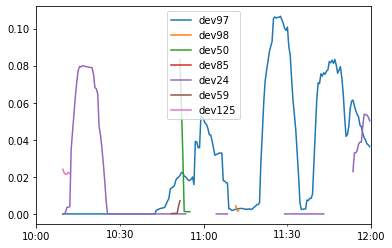

time: 539 ms


In [524]:
df_0_normalized_var = normalize_variance_algo(df_0)
print(df_0_normalized_var.corr())
df_0_normalized_var.plot()

           dev97  dev98  dev50  dev85     dev24  dev59  dev125
dev97   1.000000    NaN    NaN    NaN  0.558186    NaN     NaN
dev98        NaN    NaN    NaN    NaN       NaN    NaN     NaN
dev50        NaN    NaN    NaN    NaN       NaN    NaN     NaN
dev85        NaN    NaN    NaN    NaN       NaN    NaN     NaN
dev24   0.558186    NaN    NaN    NaN  1.000000    NaN     NaN
dev59        NaN    NaN    NaN    NaN       NaN    NaN     NaN
dev125       NaN    NaN    NaN    NaN       NaN    NaN     NaN


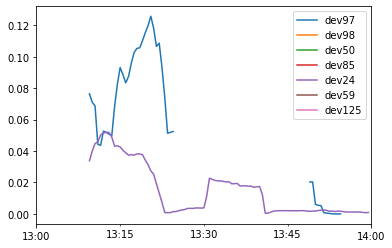

time: 291 ms


In [525]:
df_np_var_0 = normalize_variance_algo(df_np_0)
print(df_np_var_0.corr())
df_np_var_0.plot()

           dev97     dev98     dev50  dev85     dev24     dev59    dev125
dev97   1.000000 -0.709731  0.909288    NaN -0.346495  0.855183  0.922543
dev98  -0.709731  1.000000       NaN    NaN       NaN       NaN       NaN
dev50   0.909288       NaN  1.000000    NaN  0.355968       NaN       NaN
dev85        NaN       NaN       NaN    NaN       NaN       NaN       NaN
dev24  -0.346495       NaN  0.355968    NaN  1.000000 -0.352909 -0.818575
dev59   0.855183       NaN       NaN    NaN -0.352909  1.000000       NaN
dev125  0.922543       NaN       NaN    NaN -0.818575       NaN  1.000000


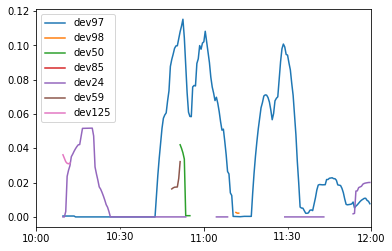

time: 311 ms


In [526]:
df_1_normalized_var = normalize_variance_algo(df_1)
print(df_1_normalized_var.corr())
df_1_normalized_var.plot()

           dev97  dev98  dev50  dev85     dev24  dev59  dev125
dev97   1.000000    NaN    NaN    NaN  0.606607    NaN     NaN
dev98        NaN    NaN    NaN    NaN       NaN    NaN     NaN
dev50        NaN    NaN    NaN    NaN       NaN    NaN     NaN
dev85        NaN    NaN    NaN    NaN       NaN    NaN     NaN
dev24   0.606607    NaN    NaN    NaN  1.000000    NaN     NaN
dev59        NaN    NaN    NaN    NaN       NaN    NaN     NaN
dev125       NaN    NaN    NaN    NaN       NaN    NaN     NaN


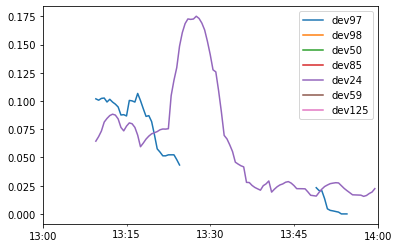

time: 302 ms


In [527]:
df_np_var_1 = normalize_variance_algo(df_np_1)
print(df_np_var_1.corr())
df_np_var_1.plot()

           dev97     dev98     dev50  dev85     dev24     dev59    dev125
dev97   1.000000 -0.996409  0.816082    NaN  0.335500 -0.855142 -0.957630
dev98  -0.996409  1.000000       NaN    NaN       NaN       NaN       NaN
dev50   0.816082       NaN  1.000000    NaN -0.880217       NaN       NaN
dev85        NaN       NaN       NaN    NaN       NaN       NaN       NaN
dev24   0.335500       NaN -0.880217    NaN  1.000000 -0.852063  0.804181
dev59  -0.855142       NaN       NaN    NaN -0.852063  1.000000       NaN
dev125 -0.957630       NaN       NaN    NaN  0.804181       NaN  1.000000


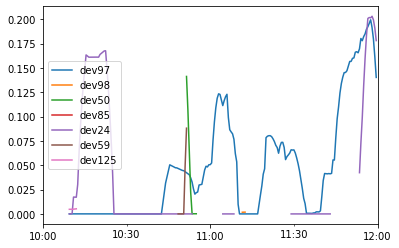

time: 328 ms


In [528]:
df_2_normalized_var = normalize_variance_algo(df_2)
print(df_2_normalized_var.corr())
df_2_normalized_var.plot()

          dev97  dev98  dev50  dev85    dev24  dev59  dev125
dev97   1.00000    NaN    NaN    NaN -0.39153    NaN     NaN
dev98       NaN    NaN    NaN    NaN      NaN    NaN     NaN
dev50       NaN    NaN    NaN    NaN      NaN    NaN     NaN
dev85       NaN    NaN    NaN    NaN      NaN    NaN     NaN
dev24  -0.39153    NaN    NaN    NaN  1.00000    NaN     NaN
dev59       NaN    NaN    NaN    NaN      NaN    NaN     NaN
dev125      NaN    NaN    NaN    NaN      NaN    NaN     NaN


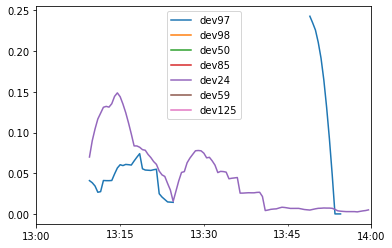

time: 352 ms


In [529]:
df_np_var_2 = normalize_variance_algo(df_np_2)
print(df_np_var_2.corr())
df_np_var_2.plot()

In [534]:
t = data_acc[:100]

time: 18 ms


In [535]:
for x in t['device_id']:
    print(x.index)

AttributeError: 'int' object has no attribute 'index'

time: 818 ms


### Distance calculation ALL ###

#### Event Exploration #### 

In [45]:
counts = []
for x in wifi_proximity["groups"]:
    sum_e = []
    for y in x:
        sum_e = sum_e + list(y)
    counts.append(len(np.unique(sum_e)))  

wifi_proximity["count_devices"] = counts

time: 365 ms


<IPython.core.display.Javascript object>


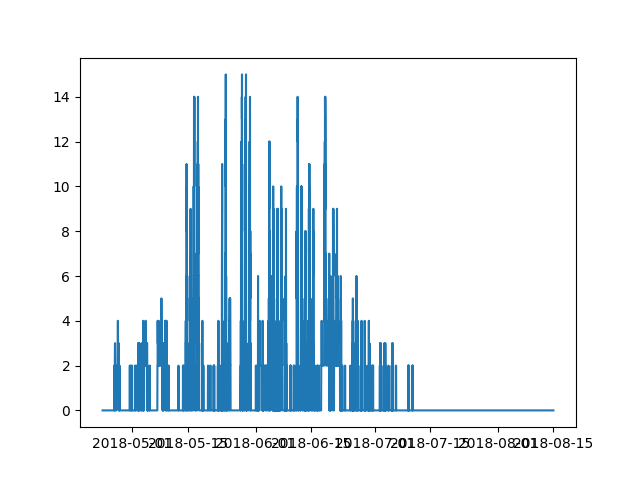

time: 64.6 ms


In [59]:
%matplotlib notebook
plt.plot(wifi_proximity["timestamp"],wifi_proximity["count_devices"])

                timestamp      devices       groups  count_devices
15360 2018-06-18 00:00:00  [[84, 101]]  [{84, 101}]              2
15361 2018-06-18 00:05:00  [[84, 101]]  [{84, 101}]              2
15362 2018-06-18 00:10:00  [[84, 101]]  [{84, 101}]              2
15363 2018-06-18 00:15:00  [[84, 101]]  [{84, 101}]              2
15364 2018-06-18 00:20:00  [[84, 101]]  [{84, 101}]              2
...                   ...          ...          ...            ...
15643 2018-06-18 23:35:00  [[84, 101]]  [{84, 101}]              2
15644 2018-06-18 23:40:00  [[84, 101]]  [{84, 101}]              2
15645 2018-06-18 23:45:00  [[84, 101]]  [{84, 101}]              2
15646 2018-06-18 23:50:00  [[84, 101]]  [{84, 101}]              2
15647 2018-06-18 23:55:00  [[84, 101]]  [{84, 101}]              2

[288 rows x 4 columns]


<IPython.core.display.Javascript object>


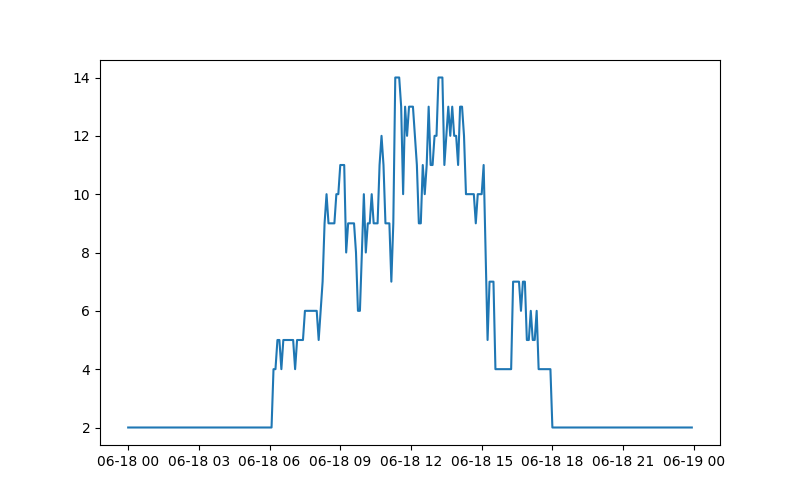

time: 67 ms


In [61]:
start = "2018-06-18 00:00:00"
end = "2018-06-19 00:00:00"
%matplotlib notebook
x = wifi_proximity[(wifi_proximity["timestamp"]>=start) & (wifi_proximity["timestamp"]<end)]
print(x)
plt.figure(figsize=(8,5))
plt.plot(x["timestamp"], x["count_devices"])

#### Event 1 ####

In [115]:
start = "2018-06-04 08:00:00"
end = "2018-06-04 15:00:00"


inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s")

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data sufficient for devices :{9.0, 19.0, 24.0, 27.0, 29.0, 31.0, 38.0, 50.0, 51.0, 56.0, 59.0, 62.0, 63.0, 65.0, 71.0, 83.0, 85.0, 92.0, 95.0, 97.0, 101.0, 102.0, 117.0, 119.0, 125.0}
1/85
2/85
3/85
4/85
5/85
6/85
7/85
8/85
9/85
10/85
11/85
12/85
13/85
14/85
15/85
16/85
17/85
18/85
19/85
20/85
21/85
22/85
23/85
24/85
25/85
26/85
27/85
28/85
29/85
30/85
31/85
32/85
33/85
34/85
35/85
36/85
37/85
38/85
39/85
40/85
41/85
42/85
43/85
44/85
45/85
46/85
47/85
48/85
49/85
50/85
51/85
52/85
53/85
54/85
55/85
56/85
57/85
58/85
59/85
60/85
61/85
62/85
63/85
64/85
65/85
66/85
67/85
68/85
69/85
70/85
71/85
72/85
73/85
74/85
75/85
76/85
77/85
78/85
79/85
80/85
81/85
82/85
83/85
84/85
85/85
time: 16min 54s


In [116]:
dist_df = pd.DataFrame()
dist_df['inprox'] = inprox
dist_df['not_inprox'] = not_in_prox
dist_df['ratio'] = dist_df['inprox'].apply(np.nanmean) / dist_df['not_inprox'].apply(np.nanmedian)

time: 68.6 ms


/u/home/oturkar/venv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


(array([ 5.,  7., 13.,  5.,  4.,  2.,  5.,  4.,  0.,  1.,  1.,  0.,  0.,
         0.,  2.]),
 array([0.39434875, 0.6990878 , 1.00382685, 1.3085659 , 1.61330495,
        1.918044  , 2.22278305, 2.5275221 , 2.83226115, 3.1370002 ,
        3.44173925, 3.7464783 , 4.05121735, 4.3559564 , 4.66069545,
        4.9654345 ]),
 <a list of 15 Patch objects>)

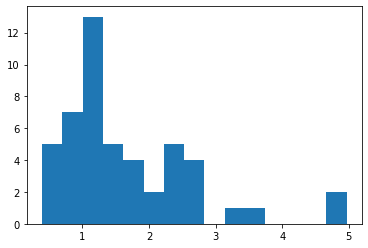

time: 736 ms


In [117]:
plt.hist(dist_df['ratio'], bins=15)

In [ ]:
start = "2018-06-04 08:00:00"
end = "2018-06-04 15:00:00"

inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s")
dist_df1 = pd.DataFrame()
dist_df1['inprox'] = inprox
dist_df1['not_inprox'] = not_in_prox
dist_df1['ratio'] = dist_df1['inprox'].apply(np.nanmean) / dist_df1['not_inprox'].apply(np.nanmedian)
%matplotlib inline
plt.hist(dist_df1['ratio'], bins=15)

In [118]:
start = "2018-06-04 08:00:00"
end = "2018-06-04 15:00:00"

inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s")
dist_df2 = pd.DataFrame()
dist_df2['inprox'] = inprox
dist_df2['not_inprox'] = not_in_prox
dist_df2['ratio'] = dist_df2['inprox'].apply(np.nanmean) / dist_df2['not_inprox'].apply(np.nanmedian)
%matplotlib inline
plt.hist(dist_df2['ratio'], bins=15)

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data sufficient for devices :{9.0, 19.0, 24.0, 27.0, 29.0, 31.0, 38.0, 50.0, 51.0, 56.0, 59.0, 62.0, 63.0, 65.0, 71.0, 83.0, 85.0, 92.0, 95.0, 97.0, 101.0, 102.0, 117.0, 119.0, 125.0}
1/85
2/85
3/85
4/85
5/85
6/85
7/85
8/85
9/85
10/85
11/85
12/85
13/85
14/85
15/85
16/85
17/85
18/85
19/85
20/85
21/85
22/85
23/85


KeyboardInterrupt: 

time: 3min 43s


#### Event 2 ####

In [51]:
start = "2018-05-16 09:00:00"
end = "2018-05-16 15:00:00"


inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.9, "double_values_0", 20, "30s")

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data sufficient for devices :{8.0, 9.0, 11.0, 12.0, 22.0, 32.0, 41.0, 48.0, 51.0, 57.0, 59.0, 63.0, 65.0, 68.0, 83.0, 84.0, 85.0, 92.0, 94.0, 95.0, 99.0, 100.0, 108.0, 117.0, 121.0}
1/73
2/73
3/73
4/73
5/73
6/73
7/73
8/73
9/73
10/73
11/73
12/73
13/73
14/73
15/73
16/73
17/73
18/73
19/73
20/73
21/73
22/73
23/73
24/73
25/73
26/73
27/73
28/73
29/73
30/73
31/73
32/73
33/73
34/73
35/73
36/73
37/73
38/73
39/73
40/73
41/73
42/73
43/73
44/73
45/73
46/73
47/73
48/73
49/73
50/73
51/73
52/73
53/73
54/73
55/73
56/73
57/73
58/73
59/73
60/73
61/73
62/73
63/73
64/73
65/73
66/73
67/73
68/73
69/73
70/73
71/73
72/73
73/73
time: 41min 41s


In [ ]:
dist_df = pd.DataFrame()
dist_df['inprox'] = inprox
dist_df['not_inprox'] = not_in_prox
dist_df['ratio'] = dist_df['inprox'].apply(np.nanmean) / dist_df['not_inprox'].apply(np.nanmedian)

In [ ]:
%matplotlib inline
plt.hist(dist_df['ratio'], bins=15)

In [ ]:
start = "2018-05-16 09:00:00"
end = "2018-05-16 15:00:00"

inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s")
dist_df1 = pd.DataFrame()
dist_df1['inprox'] = inprox
dist_df1['not_inprox'] = not_in_prox
dist_df1['ratio'] = dist_df1['inprox'].apply(np.nanmean) / dist_df1['not_inprox'].apply(np.nanmedian)
%matplotlib inline
plt.hist(dist_df1['ratio'], bins=15)

In [ ]:
start = "2018-05-16 09:00:00"
end = "2018-05-16 15:00:00"

inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s")
dist_df2 = pd.DataFrame()
dist_df2['inprox'] = inprox
dist_df2['not_inprox'] = not_in_prox
dist_df2['ratio'] = dist_df2['inprox'].apply(np.nanmean) / dist_df2['not_inprox'].apply(np.nanmedian)
%matplotlib inline
plt.hist(dist_df2['ratio'], bins=15)

#### Event 3 ####

In [ ]:
start = "2018-05-30 09:00:00"
end = "2018-05-30 16:00:00"


inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.9, "double_values_0", 20, "30s")

In [ ]:
dist_df = pd.DataFrame()
dist_df['inprox'] = inprox
dist_df['not_inprox'] = not_in_prox
dist_df['ratio'] = dist_df['inprox'].apply(np.nanmean) / dist_df['not_inprox'].apply(np.nanmedian)

In [ ]:
%matplotlib inline
plt.hist(dist_df['ratio'], bins=15)

In [ ]:
start = "2018-05-30 09:00:00"
end = "2018-05-30 16:00:00"

inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s")
dist_df1 = pd.DataFrame()
dist_df1['inprox'] = inprox
dist_df1['not_inprox'] = not_in_prox
dist_df1['ratio'] = dist_df1['inprox'].apply(np.nanmean) / dist_df1['not_inprox'].apply(np.nanmedian)
%matplotlib inline
plt.hist(dist_df1['ratio'], bins=15)

In [ ]:
start = "2018-05-30 09:00:00"
end = "2018-05-30 16:00:00"

inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s")
dist_df2 = pd.DataFrame()
dist_df2['inprox'] = inprox
dist_df2['not_inprox'] = not_in_prox
dist_df2['ratio'] = dist_df2['inprox'].apply(np.nanmean) / dist_df2['not_inprox'].apply(np.nanmedian)
%matplotlib inline
plt.hist(dist_df2['ratio'], bins=15)

### Model wise - Event 1 ###

In [136]:
df = b2s(pd.read_parquet(os.path.join(path_data_collection, "aware_device.parquet.snappy")))
df['device_id'].replace(device_id_mappings, inplace = True)

time: 64.6 ms


In [17]:
df_acc = b2s(pd.read_parquet(os.path.join(path_data_collection, "sensor_accelerometer.parquet.snappy")))
df_acc['device_id'].replace(device_id_mappings, inplace = True)

time: 53 ms


In [18]:
df_acc

_id               timestamp  device_id  double_sensor_maximum_range  \
0     1 2018-03-16 14:56:19.418         23                   156.906403   
1     2 2018-04-25 15:15:52.895         37                   156.906403   
2     3 2018-04-26 13:20:21.243         98                   156.906403   
3     4 2018-04-26 20:10:56.176        111                    39.226601   
4     5 2018-04-26 22:57:15.802         38                   156.906403   
..  ...                     ...        ...                          ...   
69   89 2018-06-10 16:23:54.747         60                    78.453201   
70   90 2018-06-10 14:33:23.150         77                    78.453201   
71   91 2018-06-11 09:48:59.060        105                    39.226601   
72   94 2018-06-02 21:11:43.818        101                    32.000000   
73   96 2018-05-14 14:33:15.847        104                    78.453201   

    double_sensor_minimum_delay                 sensor_name  \
0                          2500        BMI160 accelerometer   
1                          2500        BMI160 accelerometer   
2                          2500        BMI160 accelerometer   
3                         10000  BMA254 Acceleration Sensor   
4                          2500        BMI160 accelerometer   
..                          ...                         ...   
69                         2500       LSM6DSM Accelerometer   
70                         5000       LSM6DS3 Accelerometer   
71                        10000           PSH Accelerometer   
72                        10000               ACCELEROMETER   
73                         2500       LSM6DSL Accelerometer   

    double_sensor_power_ma  double_sensor_resolution  sensor_type  \
0                    0.001                  0.004788            1   
1                    0.001                  0.004788            1   
2                    0.001                  0.004788            1   
3                    0.130                  0.019154            1   
4                    0.001                  0.004788            1   
..                     ...                       ...          ...   
69                   0.150                  0.002396            1   
70                   0.900                  0.002396            1   
71                   0.006                  0.009577            1   
72                   0.130                  0.003906            1   
73                   0.150                  0.002396            1   

         sensor_vendor  sensor_version  
0                Bosch               1  
1                Bosch               1  
2                Bosch               1  
3      Bosch Sensortec               1  
4                Bosch               1  
..                 ...             ...  
69  STMicroelectronics               1  
70  STMicroelectronics               1  
71          Intel Inc.               1  
72                 MTK               3  
73  STMicroelectronics               1  

[74 rows x 11 columns]

time: 45.6 ms


In [139]:
x,y = np.unique(df['product'], return_counts = True)

time: 2.5 ms


In [141]:
x

array(['iPhone', 'iPhone 6', 'iPhone 6s', 'OnePlus3', 'iPhone 7',
       'bullhead', 'athene', 'sailfish', 'iPhone 5s', 'iPhone SE',
       'iPhone 7 Plus', 'tissot', 'D6603', 'marlin', 'a3xeltexx',
       'WAS-LX1A', 'iPhone 6s Plus', 'OnePlus5', 'GRA-L09', 'heroltexx',
       'iPhone 6 Plus', 'E6653', 'iPhone 5', 'hero2ltexx', 'kltexx',
       'j5xnltexx', 'j7elteub', 'ALE-L21', 'kminiltexx', 'lineage_klte',
       'ocla1_sprout_00401', 'osprey_retbr_ds', 'osprey_retus',
       'p1_global_com', 'panell_23_dl', 'pmeuhl_00401', 'potter_n',
       'potter_nt', 'taimen', 'treltexx', 'jfveltexx', 'mido',
       'hammerhead', 'walleye', 'Apple', 'CUBOT_NOTE_S', 'D6683', 'E5823',
       'FP2', 'G8141', 'Onyx_00WW', 'P653A10_EU', 'RNE-L21',
       'TA-1012_00WW', 'WW_Z00A', 'iPhone 5c', 'a3ultexx', 'a5ultexx',
       'a5xeltexx', 'bacon', 'capricorn', 'cedric', 'dream2qlteue',
       'dreamltexx', 'grandppltedtvvj', 'greatltexx', 'griffin',
       'gtanotexlwifikx', 'a3y17ltexc', 'whyred'], 

time: 7.63 ms


<BarContainer object of 70 artists>

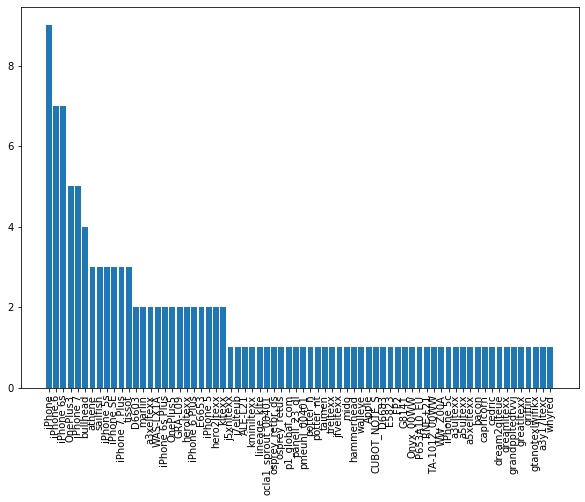

time: 1.33 s


In [140]:
x = x[np.argsort(-y)]
y = y[np.argsort(-y)]
plt.figure(figsize=(10,7))
plt.xticks(rotation=90)
plt.bar(x,y)

In [144]:
all_iphone6 = [phone for phone in x if "iPhone 6" in phone]
all_iphone6 = df[df['product'].isin(all_iphone6)]['device_id']
all_iphone6 = list(all_iphone6)

time: 6.87 ms


In [145]:
all_iphone6

[83, 7, 51, 117, 80, 85, 71, 25, 9, 47, 119, 15, 29, 88, 91, 33, 118, 70]

time: 6.13 ms


In [87]:
df_acc['sensor_name'] = df_acc['sensor_name'].str.lower()

time: 4.73 ms


In [88]:
all_android = df_acc[['device_id', 'sensor_name']].groupby('sensor_name')['device_id'].apply(set)

time: 10.5 ms


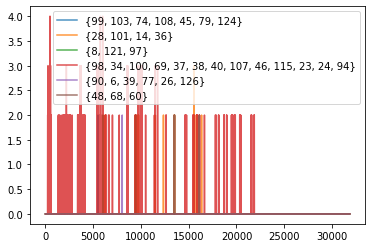

time: 3.23 s


In [96]:
temp = []
for android in all_android:
    p_list = []
    same_group_list = []
    for groups in list(wifi_proximity["groups"]):
        point = 0
        group_vendor = []
        for group in groups:
            x = set(android).intersection(group)
            if len(x) > 1:
                point = point + len(x)
                group_vendor = group_vendor + list(x)
        p_list.append(point)
        same_group_list.append(group_vendor)
    wifi_proximity["p_list"] = p_list
    wifi_proximity["p_group"] = same_group_list
    temp.append(np.nanmean(wifi_proximity["p_list"]))
    if (np.nanmean(wifi_proximity["p_list"]) > 0) :
        plt.plot(wifi_proximity["p_list"], alpha = 0.8, label = str(android))
plt.legend()

In [97]:
for x in zip(temp, all_android):
    print(x)

(6.277463904582549e-05, {99, 103, 74, 108, 45, 79, 124})
(0.006842435655994978, {28, 101, 14, 36})
(0.0, {86})
(0.0, {109})
(0.0, {111})
(0.0, {96, 43, 87})
(0.0, {53, 22})
(0.0005021971123666039, {8, 121, 97})
(0.0, {116})
(0.1630571249215317, {98, 34, 100, 69, 37, 38, 40, 107, 46, 115, 23, 24, 94})
(0.0, {113, 114, 17, 31})
(0.0, {64})
(0.0, {11, 52, 55})
(0.0, {16, 57})
(0.0, {35})
(0.0, {4})
(0.0, {89, 58, 123})
(0.0, {54})
(0.0, {84})
(0.0, {41})
(0.0, {18, 21})
(0.0, {2})
(0.00025109855618330194, {90, 6, 39, 77, 26, 126})
(0.0, {44, 78})
(0.0, {104})
(0.0026365348399246705, {48, 68, 60})
(0.0, {106})
(0.0, {66, 20, 13})
(0.0, {105})
time: 69.3 ms


In [99]:
all_android

{23, 24, 34, 37, 38, 40, 46, 69, 94, 98, 100, 107, 115}

time: 37.9 ms


In [100]:

p_list = []
same_group_list = []
for groups in list(wifi_proximity["groups"]):
    point = 0
    group_vendor = []
    for group in groups:
        x = set(all_android).intersection(group)
        if len(x) > 1:
            point = point + len(x)
            group_vendor = group_vendor + list(x)
    p_list.append(point)
    same_group_list.append(group_vendor)

time: 50.7 ms


In [101]:
wifi_proximity["p_list"] = p_list
wifi_proximity["p_group"] = same_group_list

time: 22.1 ms


(array([736815., 736829., 736846., 736860., 736876., 736890., 736907.,
        736921.]), <a list of 8 Text xticklabel objects>)

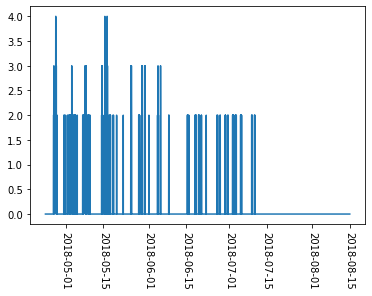

time: 305 ms


In [102]:
%matplotlib inline
plt.plot(wifi_proximity["timestamp"],wifi_proximity["p_list"])
plt.xticks(rotation=-90)

In [ ]:
start = "2018-04-27 06:00:00"
end = "2018-04-27 18:00:00"

start = "2018-05-16 07:00:00"
end = "2018-05-16 15:00:00"



(array([736829.375     , 736829.41666667, 736829.45833333, 736829.5       ,
        736829.54166667, 736829.58333333, 736829.625     , 736829.66666667]),
 <a list of 8 Text xticklabel objects>)

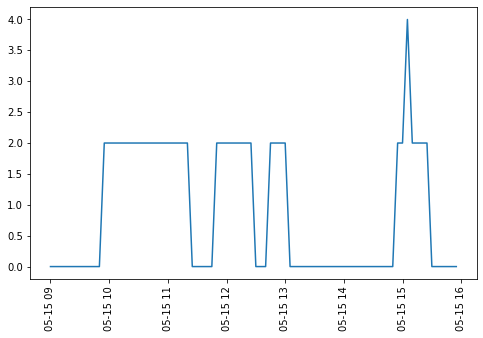

time: 269 ms


In [103]:
start = "2018-05-15 09:00:00"
end = "2018-05-15 16:00:00"
%matplotlib inline
x = wifi_proximity[(wifi_proximity["timestamp"]>=start) & (wifi_proximity["timestamp"]<end)]
plt.figure(figsize=(8,5))
plt.plot(x["timestamp"], x["p_list"])
plt.xticks(rotation=90)

#### iphone 6 Event 1 #### 

In [75]:
start = "2018-05-23 11:30:00"
end = "2018-05-23 15:00:00"
data_acc_e1 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = distance_calc(data_acc_e1, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s", all_iphone6)
inprox_1, not_in_prox_1 = distance_calc(data_acc_e1, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s", all_iphone6)
inprox_2, not_in_prox_2 = distance_calc(data_acc_e1, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s", all_iphone6)

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event1_dtw_iphone6.parquet.snappy")

KeyboardInterrupt: 

time: 36.3 s


In [146]:
start = "2018-05-23 11:30:00"
end = "2018-05-23 15:00:00"
data_acc_e1 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = cosine_distance_calc(data_acc_e1, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s", all_iphone6)
inprox_1, not_in_prox_1 = cosine_distance_calc(data_acc_e1, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s", all_iphone6)
inprox_2, not_in_prox_2 = cosine_distance_calc(data_acc_e1, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s", all_iphone6)

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event1_cosine_iphone6.parquet.snappy")

Data sufficient for devices :{71, 9, 15, 51, 83, 85, 117, 119}
1/43
2/43
3/43
4/43
5/43
6/43
7/43
8/43
9/43
10/43
11/43
12/43
13/43
14/43
15/43
16/43
17/43
18/43
19/43
20/43
21/43
22/43
23/43
24/43
25/43
26/43
27/43
28/43
29/43
30/43
31/43
32/43
33/43
34/43
35/43
36/43
37/43
38/43
39/43
40/43
41/43
42/43
43/43
Data sufficient for devices :{71, 9, 15, 51, 83, 85, 117, 119}
1/43
2/43
3/43
4/43
5/43
6/43
7/43
8/43
9/43
10/43
11/43
12/43
13/43
14/43
15/43
16/43
17/43
18/43
19/43
20/43
21/43
22/43
23/43
24/43
25/43
26/43
27/43
28/43
29/43
30/43
31/43
32/43
33/43
34/43
35/43
36/43
37/43
38/43
39/43
40/43
41/43
42/43
43/43
Data sufficient for devices :{71, 9, 15, 51, 83, 85, 117, 119}
1/43
2/43
3/43
4/43
5/43
6/43
7/43
8/43
9/43
10/43
11/43
12/43
13/43
14/43
15/43
16/43
17/43
18/43
19/43
20/43
21/43
22/43
23/43
24/43
25/43
26/43
27/43
28/43
29/43
30/43
31/43
32/43
33/43
34/43
35/43
36/43
37/43
38/43
39/43
40/43
41/43
42/43
43/43
time: 53.3 s


#### Event 2 ####

In [ ]:
start = "2018-05-28 07:00:00"
end = "2018-05-28 15:00:00"
data_acc_e2 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = distance_calc(data_acc_e2, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s", all_iphone6)
inprox_1, not_in_prox_1 = distance_calc(data_acc_e2, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s", all_iphone6)
inprox_2, not_in_prox_2 = distance_calc(data_acc_e2, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s", all_iphone6)

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event2_dtw_iphone6.parquet.snappy")

In [147]:
start = "2018-05-28 07:00:00"
end = "2018-05-28 15:00:00"
data_acc_e2 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = cosine_distance_calc(data_acc_e2, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s", all_iphone6)
inprox_1, not_in_prox_1 = cosine_distance_calc(data_acc_e2, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s", all_iphone6)
inprox_2, not_in_prox_2 = cosine_distance_calc(data_acc_e2, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s", all_iphone6)

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event2_cosine_iphone6.parquet.snappy")

Data sufficient for devices :{71, 9, 15, 51, 83, 85, 117, 119, 29}
1/97
2/97
3/97
4/97
5/97
6/97
7/97
8/97
9/97
10/97
11/97
12/97
13/97
14/97
15/97
16/97
17/97
18/97
19/97
20/97
21/97
22/97
23/97
24/97
25/97
26/97
27/97
28/97
29/97
30/97
31/97
32/97
33/97
34/97
35/97
36/97
37/97
38/97
39/97
40/97
41/97
42/97
43/97
44/97
45/97
46/97
47/97
48/97
49/97
50/97
51/97
52/97
53/97
54/97
55/97
56/97
57/97
58/97
59/97
60/97
61/97
62/97
63/97
64/97
65/97
66/97
67/97
68/97
69/97
70/97
71/97
72/97
73/97
74/97
75/97
76/97
77/97
78/97
79/97
80/97
81/97
82/97
83/97
84/97
85/97
86/97
87/97
88/97
89/97
90/97
91/97
92/97
93/97
94/97
95/97
96/97
97/97
Data sufficient for devices :{71, 9, 15, 51, 83, 85, 117, 119, 29}
1/97
2/97
3/97
4/97
5/97
6/97
7/97
8/97
9/97
10/97
11/97
12/97
13/97
14/97
15/97
16/97
17/97
18/97
19/97
20/97
21/97
22/97
23/97
24/97
25/97
26/97
27/97
28/97
29/97
30/97
31/97
32/97
33/97
34/97
35/97
36/97
37/97
38/97
39/97
40/97
41/97
42/97
43/97
44/97
45/97
46/97
47/97
48/97
49/97
50/97
51

#### Event 3 ####

In [ ]:
start = "2018-06-11 13:00:00"
end = "2018-06-11 17:00:00"
data_acc_e3 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = distance_calc(data_acc_e3, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s", all_iphone6)
inprox_1, not_in_prox_1 = distance_calc(data_acc_e3, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s", all_iphone6)
inprox_2, not_in_prox_2 = distance_calc(data_acc_e3, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s", all_iphone6)

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event3_dtw_iphone6.parquet.snappy")

In [148]:
start = "2018-06-11 13:00:00"
end = "2018-06-11 17:00:00"
data_acc_e3 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = cosine_distance_calc(data_acc_e3, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s", all_iphone6)
inprox_1, not_in_prox_1 = cosine_distance_calc(data_acc_e3, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s", all_iphone6)
inprox_2, not_in_prox_2 = cosine_distance_calc(data_acc_e3, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s", all_iphone6)

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event3_cosine_iphone6.parquet.snappy")

Data sufficient for devices :{71, 9, 83, 117, 118, 119, 29}
1/49
2/49
3/49
4/49
5/49
6/49
7/49
8/49
9/49
10/49
11/49
12/49
13/49
14/49
15/49
16/49
17/49
18/49
19/49
20/49
21/49
22/49
23/49
24/49
25/49
26/49
27/49
28/49
29/49
30/49
31/49
32/49
33/49
34/49
35/49
36/49
37/49
38/49
39/49
40/49
41/49
42/49
43/49
44/49
45/49
46/49
47/49
48/49
49/49
Data sufficient for devices :{71, 9, 83, 117, 118, 119, 29}
1/49
2/49
3/49
4/49
5/49
6/49
7/49
8/49
9/49
10/49
11/49
12/49
13/49
14/49
15/49
16/49
17/49
18/49
19/49
20/49
21/49
22/49
23/49
24/49
25/49
26/49
27/49
28/49
29/49
30/49
31/49
32/49
33/49
34/49
35/49
36/49
37/49
38/49
39/49
40/49
41/49
42/49
43/49
44/49
45/49
46/49
47/49
48/49
49/49
Data sufficient for devices :{71, 9, 83, 117, 118, 119, 29}
1/49
2/49
3/49
4/49
5/49
6/49
7/49
8/49
9/49
10/49
11/49
12/49
13/49
14/49
15/49
16/49
17/49
18/49
19/49
20/49
21/49
22/49
23/49
24/49
25/49
26/49
27/49
28/49
29/49
30/49
31/49
32/49
33/49
34/49
35/49
36/49
37/49
38/49
39/49
40/49
41/49
42/49
43/49
4

#### Android event 1####

In [104]:
start = "2018-04-27 06:00:00"
end = "2018-04-27 18:00:00"
data_acc_e1 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = distance_calc(data_acc_e1, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s", all_android)
inprox_1, not_in_prox_1 = distance_calc(data_acc_e1, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s", all_android)
inprox_2, not_in_prox_2 = distance_calc(data_acc_e1, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s", all_android)

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event1_dtw_android.parquet.snappy")

start = "2018-04-27 06:00:00"
end = "2018-04-27 18:00:00"
inprox_0, not_in_prox_0 = cosine_distance_calc(data_acc_e1, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s", all_android)
inprox_1, not_in_prox_1 = cosine_distance_calc(data_acc_e1, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s", all_android)
inprox_2, not_in_prox_2 = cosine_distance_calc(data_acc_e1, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s", all_android)

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event1_cosine_android.parquet.snappy")




Data sufficient for devices :{38}
1/145
2/145
3/145
4/145
5/145
6/145
7/145
8/145
9/145
10/145
11/145
12/145
13/145
14/145
15/145
16/145
17/145
18/145
19/145
20/145
21/145
22/145
23/145
24/145
25/145
26/145
27/145
28/145
29/145
30/145
31/145
32/145
33/145
34/145
35/145
36/145
37/145
38/145
39/145
40/145
41/145
42/145
43/145
44/145
45/145
46/145
47/145
48/145
49/145
50/145
51/145
52/145
53/145
54/145
55/145
56/145
57/145
58/145
59/145
60/145
61/145
62/145
63/145
64/145
65/145
66/145
67/145
68/145
69/145
70/145
71/145
72/145
73/145
74/145
75/145
76/145
77/145
78/145
79/145
80/145
81/145
82/145
83/145
84/145
85/145
86/145
87/145
88/145
89/145
90/145
91/145
92/145
93/145
94/145
95/145
96/145
97/145
98/145
99/145
100/145
101/145
102/145
103/145
104/145
105/145
106/145
107/145
108/145
109/145
110/145
111/145
112/145
113/145
114/145
115/145
116/145
117/145
118/145
119/145
120/145
121/145
122/145
123/145
124/145
125/145
126/145
127/145
128/145
129/145
130/145
131/145
132/145
133/145
134/145
13

#### Android event 2 ####

In [ ]:
start = "2018-05-16 07:00:00"
end = "2018-05-16 15:00:00"
data_acc_e2 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = distance_calc(data_acc_e2, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s", all_android)
inprox_1, not_in_prox_1 = distance_calc(data_acc_e2, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s", all_android)
inprox_2, not_in_prox_2 = distance_calc(data_acc_e2, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s", all_android)

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event2_dtw_android.parquet.snappy")

start = "2018-05-16 07:00:00"
end = "2018-05-16 15:00:00"
inprox_0, not_in_prox_0 = cosine_distance_calc(data_acc_e2, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s", all_android)
inprox_1, not_in_prox_1 = cosine_distance_calc(data_acc_e2, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s", all_android)
inprox_2, not_in_prox_2 = cosine_distance_calc(data_acc_e2, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s", all_android)

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event2_cosine_android.parquet.snappy")



Data sufficient for devices :{34, 100, 94}
1/97
2/97
3/97
4/97
5/97
6/97
7/97
8/97
9/97
10/97
11/97
12/97
13/97
14/97
15/97
16/97
17/97
18/97
19/97
20/97
21/97
22/97
23/97
24/97
25/97
26/97
27/97
28/97
29/97
30/97
31/97
32/97
33/97
34/97
35/97
36/97
37/97
38/97
39/97
40/97
41/97
42/97
43/97
44/97
45/97
46/97
47/97
48/97
49/97
50/97
51/97
52/97
53/97
54/97
55/97
56/97
57/97
58/97
59/97
60/97
61/97
62/97
63/97
64/97
65/97
66/97
67/97
68/97
69/97
70/97
71/97
72/97
73/97
74/97
75/97
76/97
77/97
78/97
79/97
80/97
81/97
82/97
83/97
84/97
85/97
86/97
87/97
88/97
89/97
90/97
91/97
92/97
93/97
94/97
95/97
96/97
97/97
Data sufficient for devices :{34, 100, 94}
1/97
2/97
3/97
4/97
5/97
6/97
7/97
8/97
9/97
10/97
11/97
12/97
13/97
14/97
15/97
16/97
17/97
18/97
19/97
20/97
21/97
22/97
23/97
24/97
25/97
26/97
27/97
28/97
29/97
30/97
31/97
32/97
33/97
34/97
35/97
36/97
37/97
38/97
39/97
40/97
41/97
42/97
43/97
44/97
45/97
46/97
47/97
48/97
49/97
50/97
51/97
52/97
53/97
54/97
55/97
56/97
57/97
58/97
59

### Variance instead of mean and median ###

#### iphone 6 Event 1 #### 

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data sufficient for devices :{71, 9, 15, 51, 83, 85, 117, 119}
1/43
2/43
3/43
4/43
5/43
6/43
7/43
8/43
9/43
10/43
11/43
12/43
13/43
14/43
15/43
16/43
17/43
18/43
19/43
20/43
21/43
22/43
23/43
24/43
25/43
26/43
27/43
28/43
29/43
30/43
31/43
32/43
33/43
34/43
35/43
36/43
37/43
38/43
39/43
40/43
41/43
42/43
43/43


(array([10.,  1.,  3.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  2.,  4.,  1.,
         1.,  3.]),
 array([0.        , 0.11680924, 0.23361848, 0.35042772, 0.46723695,
        0.58404619, 0.70085543, 0.81766467, 0.93447391, 1.05128315,
        1.16809239, 1.28490163, 1.40171086, 1.5185201 , 1.63532934,
        1.75213858]),
 <a list of 15 Patch objects>)

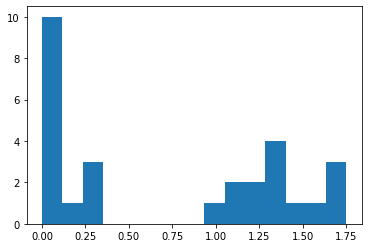

time: 1min 40s


In [138]:
start = "2018-05-23 11:30:00"
end = "2018-05-23 15:00:00"
inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s", all_iphone6)
dist_df0 = pd.DataFrame()
dist_df0['inprox'] = inprox
dist_df0['not_inprox'] = not_in_prox
dist_df0['ratio'] = dist_df0['inprox'].apply(np.var) / dist_df0['not_inprox'].apply(np.var)
%matplotlib inline
plt.hist(dist_df0['ratio'], bins=15)

In [ ]:
start = "2018-05-23 11:30:00"
end = "2018-05-23 15:00:00"
inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s", all_iphone6)
dist_df1 = pd.DataFrame()
dist_df1['inprox'] = inprox
dist_df1['not_inprox'] = not_in_prox
dist_df1['ratio'] = dist_df1['inprox'].apply(np.var) / dist_df1['not_inprox'].apply(np.var)
%matplotlib inline
plt.hist(dist_df1['ratio'], bins=15)

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data sufficient for devices :{71, 9, 15, 51, 83, 85, 117, 119}
1/43
2/43
3/43
4/43
5/43
6/43
7/43
8/43
9/43
10/43
11/43
12/43
13/43
14/43
15/43
16/43
17/43
18/43
19/43
20/43
21/43
22/43
23/43
24/43
25/43
26/43
27/43
28/43
29/43
30/43
31/43
32/43
33/43
34/43
35/43
36/43
37/43
38/43
39/43
40/43
41/43
42/43
43/43


(array([8., 4., 1., 0., 0., 1., 0., 2., 1., 2., 1., 3., 0., 3., 2.]),
 array([0.        , 0.06039332, 0.12078665, 0.18117997, 0.2415733 ,
        0.30196662, 0.36235995, 0.42275327, 0.4831466 , 0.54353992,
        0.60393325, 0.66432657, 0.7247199 , 0.78511322, 0.84550655,
        0.90589987]),
 <a list of 15 Patch objects>)

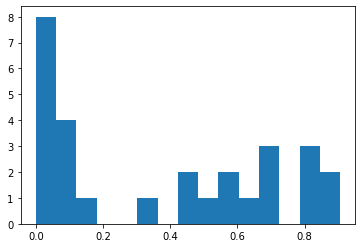

time: 1min 37s


In [140]:
start = "2018-05-23 11:30:00"
end = "2018-05-23 15:00:00"
inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s", all_iphone6)
dist_df2 = pd.DataFrame()
dist_df2['inprox'] = inprox
dist_df2['not_inprox'] = not_in_prox
dist_df2['ratio'] = dist_df2['inprox'].apply(np.var) / dist_df2['not_inprox'].apply(np.var)
%matplotlib inline
plt.hist(dist_df2['ratio'], bins=15)

#### iphone6 event 2 ####

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data sufficient for devices :{71, 9, 15, 51, 83, 85, 117, 119, 29}
1/97
2/97
3/97
4/97
5/97
6/97
7/97
8/97
9/97
10/97
11/97
12/97
13/97
14/97
15/97
16/97
17/97
18/97
19/97
20/97
21/97
22/97
23/97
24/97
25/97
26/97
27/97
28/97
29/97
30/97
31/97
32/97
33/97
34/97
35/97
36/97
37/97
38/97
39/97
40/97
41/97
42/97
43/97
44/97
45/97
46/97
47/97
48/97
49/97
50/97
51/97
52/97
53/97
54/97
55/97
56/97
57/97
58/97
59/97
60/97
61/97
62/97
63/97
64/97
65/97
66/97
67/97
68/97
69/97
70/97
71/97
72/97
73/97
74/97
75/97
76/97
77/97
78/97
79/97
80/97
81/97
82/97
83/97
84/97
85/97
86/97
87/97
88/97
89/97
90/97
91/97
92/97
93/97
94/97
95/97
96/97
97/97


(array([53.,  6.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.]),
 array([ 0.        ,  0.68658783,  1.37317565,  2.05976348,  2.74635131,
         3.43293913,  4.11952696,  4.80611479,  5.49270261,  6.17929044,
         6.86587826,  7.55246609,  8.23905392,  8.92564174,  9.61222957,
        10.2988174 ]),
 <a list of 15 Patch objects>)

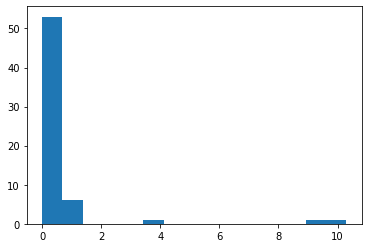

time: 6min 50s


In [141]:

start = "2018-05-28 07:00:00"
end = "2018-05-28 15:00:00"
inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s", all_iphone6)
dist_df0 = pd.DataFrame()
dist_df0['inprox'] = inprox
dist_df0['not_inprox'] = not_in_prox
dist_df0['ratio'] = dist_df0['inprox'].apply(np.var) / dist_df0['not_inprox'].apply(np.var)
%matplotlib inline
plt.hist(dist_df0['ratio'], bins=15)

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data sufficient for devices :{71, 9, 15, 51, 83, 85, 117, 119, 29}
1/97
2/97
3/97
4/97
5/97
6/97
7/97
8/97
9/97
10/97
11/97
12/97
13/97
14/97
15/97
16/97
17/97
18/97
19/97
20/97
21/97
22/97
23/97
24/97
25/97
26/97
27/97
28/97
29/97
30/97
31/97
32/97
33/97
34/97
35/97
36/97
37/97
38/97
39/97
40/97
41/97
42/97
43/97
44/97
45/97
46/97
47/97
48/97
49/97
50/97
51/97
52/97
53/97
54/97
55/97
56/97
57/97
58/97
59/97
60/97
61/97
62/97
63/97
64/97
65/97
66/97
67/97
68/97
69/97
70/97
71/97
72/97
73/97
74/97
75/97
76/97
77/97
78/97
79/97
80/97
81/97
82/97
83/97
84/97
85/97
86/97
87/97
88/97
89/97
90/97
91/97
92/97
93/97
94/97
95/97
96/97
97/97


(array([52.,  2.,  4.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.]),
 array([0.        , 0.17046335, 0.34092671, 0.51139006, 0.68185341,
        0.85231677, 1.02278012, 1.19324347, 1.36370682, 1.53417018,
        1.70463353, 1.87509688, 2.04556024, 2.21602359, 2.38648694,
        2.5569503 ]),
 <a list of 15 Patch objects>)

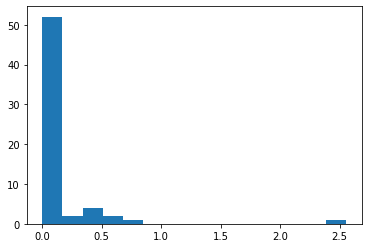

time: 6min 44s


In [142]:
start = "2018-05-28 07:00:00"
end = "2018-05-28 15:00:00"
inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s", all_iphone6)
dist_df1 = pd.DataFrame()
dist_df1['inprox'] = inprox
dist_df1['not_inprox'] = not_in_prox
dist_df1['ratio'] = dist_df1['inprox'].apply(np.var) / dist_df1['not_inprox'].apply(np.var)
%matplotlib inline
plt.hist(dist_df1['ratio'], bins=15)

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data sufficient for devices :{71, 9, 15, 51, 83, 85, 117, 119, 29}
1/97
2/97
3/97
4/97
5/97
6/97
7/97
8/97
9/97
10/97
11/97
12/97
13/97
14/97
15/97
16/97
17/97
18/97
19/97
20/97
21/97
22/97
23/97
24/97
25/97
26/97
27/97
28/97
29/97
30/97
31/97
32/97
33/97
34/97
35/97
36/97
37/97
38/97
39/97
40/97
41/97
42/97
43/97
44/97
45/97
46/97
47/97
48/97
49/97
50/97
51/97
52/97
53/97
54/97
55/97
56/97
57/97
58/97
59/97
60/97
61/97
62/97
63/97
64/97
65/97
66/97
67/97
68/97
69/97
70/97
71/97
72/97
73/97
74/97
75/97
76/97
77/97
78/97
79/97
80/97
81/97
82/97
83/97
84/97
85/97
86/97
87/97
88/97
89/97
90/97
91/97
92/97
93/97
94/97
95/97
96/97
97/97


(array([50.,  0.,  1.,  1.,  2.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,
         0.,  3.]),
 array([0.        , 0.06850174, 0.13700348, 0.20550521, 0.27400695,
        0.34250869, 0.41101043, 0.47951217, 0.5480139 , 0.61651564,
        0.68501738, 0.75351912, 0.82202086, 0.89052259, 0.95902433,
        1.02752607]),
 <a list of 15 Patch objects>)

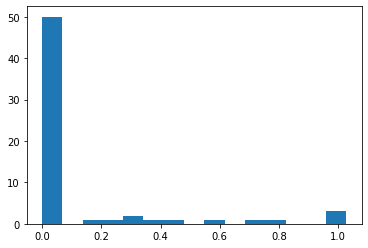

time: 6min 54s


In [143]:
start = "2018-05-28 07:00:00"
end = "2018-05-28 15:00:00"
inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s", all_iphone6)
dist_df2 = pd.DataFrame()
dist_df2['inprox'] = inprox
dist_df2['not_inprox'] = not_in_prox
dist_df2['ratio'] = dist_df2['inprox'].apply(np.var) / dist_df2['not_inprox'].apply(np.var)
%matplotlib inline
plt.hist(dist_df2['ratio'], bins=15)

#### Iphone event 3 ####

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data sufficient for devices :{71, 9, 83, 117, 118, 119, 29}
1/49
2/49
3/49
4/49
5/49
6/49
7/49
8/49
9/49
10/49
11/49
12/49
13/49
14/49
15/49
16/49
17/49
18/49
19/49
20/49
21/49
22/49
23/49
24/49
25/49
26/49
27/49
28/49
29/49
30/49
31/49
32/49
33/49
34/49
35/49
36/49
37/49
38/49
39/49
40/49
41/49
42/49
43/49
44/49
45/49
46/49
47/49
48/49
49/49


(array([19.,  0.,  3.,  2.,  2.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         1.,  1.]),
 array([0.        , 0.3078695 , 0.615739  , 0.9236085 , 1.231478  ,
        1.5393475 , 1.847217  , 2.1550865 , 2.462956  , 2.7708255 ,
        3.078695  , 3.3865645 , 3.69443399, 4.00230349, 4.31017299,
        4.61804249]),
 <a list of 15 Patch objects>)

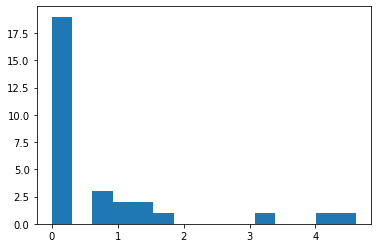

time: 1min 53s


In [144]:
start = "2018-06-11 13:00:00"
end = "2018-06-11 17:00:00"
inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s", all_iphone6)
dist_df0 = pd.DataFrame()
dist_df0['inprox'] = inprox
dist_df0['not_inprox'] = not_in_prox
dist_df0['ratio'] = dist_df0['inprox'].apply(np.var) / dist_df0['not_inprox'].apply(np.var)
%matplotlib inline
plt.hist(dist_df0['ratio'], bins=15)

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data sufficient for devices :{71, 9, 83, 117, 118, 119, 29}
1/49
2/49
3/49
4/49
5/49
6/49
7/49
8/49
9/49
10/49
11/49
12/49
13/49
14/49
15/49
16/49
17/49
18/49
19/49
20/49
21/49
22/49
23/49
24/49
25/49
26/49
27/49
28/49
29/49
30/49
31/49
32/49
33/49
34/49
35/49
36/49
37/49
38/49
39/49
40/49
41/49
42/49
43/49
44/49
45/49
46/49
47/49
48/49
49/49


(array([21.,  1.,  2.,  0.,  0.,  0.,  1.,  1.,  2.,  1.,  0.,  0.,  0.,
         0.,  1.]),
 array([0.        , 0.12542572, 0.25085143, 0.37627715, 0.50170287,
        0.62712858, 0.7525543 , 0.87798002, 1.00340573, 1.12883145,
        1.25425717, 1.37968288, 1.5051086 , 1.63053432, 1.75596003,
        1.88138575]),
 <a list of 15 Patch objects>)

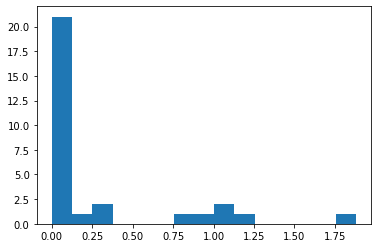

time: 1min 47s


In [145]:
start = "2018-06-11 13:00:00"
end = "2018-06-11 17:00:00"
inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s", all_iphone6)
dist_df1 = pd.DataFrame()
dist_df1['inprox'] = inprox
dist_df1['not_inprox'] = not_in_prox
dist_df1['ratio'] = dist_df1['inprox'].apply(np.var) / dist_df1['not_inprox'].apply(np.var)
%matplotlib inline
plt.hist(dist_df1['ratio'], bins=15)

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data sufficient for devices :{71, 9, 83, 117, 118, 119, 29}
1/49
2/49
3/49
4/49
5/49
6/49
7/49
8/49
9/49
10/49
11/49
12/49
13/49
14/49
15/49
16/49
17/49
18/49
19/49
20/49
21/49
22/49
23/49
24/49
25/49
26/49
27/49
28/49
29/49
30/49
31/49
32/49
33/49
34/49
35/49
36/49
37/49
38/49
39/49
40/49
41/49
42/49
43/49
44/49
45/49
46/49
47/49
48/49
49/49


(array([21.,  2.,  1.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  1.]),
 array([0.        , 0.05272345, 0.10544689, 0.15817034, 0.21089379,
        0.26361723, 0.31634068, 0.36906412, 0.42178757, 0.47451102,
        0.52723446, 0.57995791, 0.63268136, 0.6854048 , 0.73812825,
        0.79085169]),
 <a list of 15 Patch objects>)

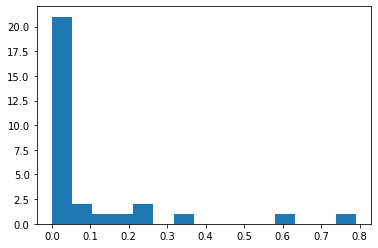

time: 1min 47s


In [146]:
start = "2018-06-11 13:00:00"
end = "2018-06-11 17:00:00"
inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s", all_iphone6)
dist_df2 = pd.DataFrame()
dist_df2['inprox'] = inprox
dist_df2['not_inprox'] = not_in_prox
dist_df2['ratio'] = dist_df2['inprox'].apply(np.var) / dist_df2['not_inprox'].apply(np.var)
%matplotlib inline
plt.hist(dist_df2['ratio'], bins=15)

### All devices Variance###

#### Event 1 ####

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data sufficient for devices :{9.0, 19.0, 24.0, 27.0, 29.0, 31.0, 38.0, 50.0, 51.0, 56.0, 59.0, 62.0, 63.0, 65.0, 71.0, 83.0, 85.0, 92.0, 95.0, 97.0, 101.0, 102.0, 117.0, 119.0, 125.0}
1/85
2/85
3/85
4/85
5/85
6/85
7/85
8/85
9/85
10/85
11/85
12/85
13/85
14/85
15/85
16/85
17/85
18/85
19/85
20/85
21/85
22/85
23/85
24/85
25/85
26/85
27/85
28/85
29/85
30/85
31/85
32/85
33/85
34/85
35/85
36/85
37/85
38/85
39/85
40/85
41/85
42/85
43/85
44/85
45/85
46/85
47/85
48/85
49/85
50/85
51/85
52/85
53/85
54/85
55/85
56/85
57/85
58/85
59/85
60/85
61/85
62/85
63/85
64/85
65/85
66/85
67/85
68/85
69/85
70/85
71/85
72/85
73/85
74/85
75/85
76/85
77/85
78/85
79/85
80/85
81/85
82/85
83/85
84/85
85/85


(array([23.,  3.,  2.,  4.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.]),
 array([0.        , 0.05765582, 0.11531163, 0.17296745, 0.23062327,
        0.28827908, 0.3459349 , 0.40359072, 0.46124653, 0.51890235,
        0.57655817, 0.63421398, 0.6918698 , 0.74952562, 0.80718143,
        0.86483725]),
 <a list of 15 Patch objects>)

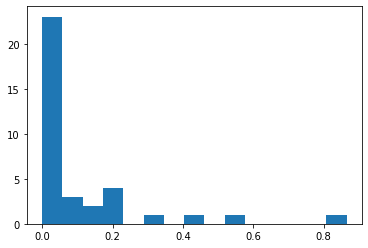

time: 16min 29s


In [147]:
start = "2018-06-04 08:00:00"
end = "2018-06-04 15:00:00"


inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s")

dist_df0 = pd.DataFrame()
dist_df0['inprox'] = inprox
dist_df0['not_inprox'] = not_in_prox
dist_df0['ratio'] = dist_df0['inprox'].apply(np.var) / dist_df0['not_inprox'].apply(np.var)

plt.hist(dist_df0['ratio'], bins=15)

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data sufficient for devices :{9.0, 19.0, 24.0, 27.0, 29.0, 31.0, 38.0, 50.0, 51.0, 56.0, 59.0, 62.0, 63.0, 65.0, 71.0, 83.0, 85.0, 92.0, 95.0, 97.0, 101.0, 102.0, 117.0, 119.0, 125.0}
1/85
2/85
3/85
4/85
5/85
6/85
7/85
8/85
9/85
10/85
11/85
12/85
13/85
14/85
15/85
16/85
17/85
18/85
19/85
20/85
21/85
22/85
23/85
24/85
25/85
26/85
27/85
28/85
29/85
30/85
31/85
32/85
33/85
34/85
35/85
36/85
37/85
38/85
39/85
40/85
41/85
42/85
43/85
44/85
45/85
46/85
47/85
48/85
49/85
50/85
51/85
52/85
53/85
54/85
55/85
56/85
57/85
58/85
59/85
60/85
61/85
62/85
63/85
64/85
65/85
66/85
67/85
68/85
69/85
70/85
71/85
72/85
73/85
74/85
75/85
76/85
77/85
78/85
79/85
80/85
81/85
82/85
83/85
84/85
85/85


(array([13.,  0.,  2.,  3.,  1.,  0.,  1.,  1.,  2.,  1.,  1.,  1.,  4.,
         2.,  4.]),
 array([0.        , 0.12453815, 0.24907631, 0.37361446, 0.49815262,
        0.62269077, 0.74722893, 0.87176708, 0.99630524, 1.12084339,
        1.24538155, 1.3699197 , 1.49445786, 1.61899601, 1.74353417,
        1.86807232]),
 <a list of 15 Patch objects>)

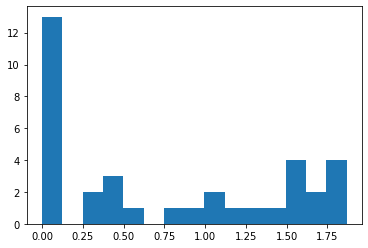

time: 16min 23s


In [158]:
start = "2018-06-04 08:00:00"
end = "2018-06-04 15:00:00"

inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s")
dist_df1 = pd.DataFrame()
dist_df1['inprox'] = inprox
dist_df1['not_inprox'] = not_in_prox
dist_df1['ratio'] = dist_df1['inprox'].apply(np.var) / dist_df1['not_inprox'].apply(np.var)
%matplotlib inline
plt.hist(dist_df1['ratio'], bins=15)

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data sufficient for devices :{9.0, 19.0, 24.0, 27.0, 29.0, 31.0, 38.0, 50.0, 51.0, 56.0, 59.0, 62.0, 63.0, 65.0, 71.0, 83.0, 85.0, 92.0, 95.0, 97.0, 101.0, 102.0, 117.0, 119.0, 125.0}
1/85
2/85
3/85
4/85
5/85
6/85
7/85
8/85
9/85
10/85
11/85
12/85
13/85
14/85
15/85
16/85
17/85
18/85
19/85
20/85
21/85
22/85
23/85
24/85
25/85
26/85
27/85
28/85
29/85
30/85
31/85
32/85
33/85
34/85
35/85
36/85
37/85
38/85
39/85
40/85
41/85
42/85
43/85
44/85
45/85
46/85
47/85
48/85
49/85
50/85
51/85
52/85
53/85
54/85
55/85
56/85
57/85
58/85
59/85
60/85
61/85
62/85
63/85
64/85
65/85
66/85
67/85
68/85
69/85
70/85
71/85
72/85
73/85
74/85
75/85
76/85
77/85
78/85
79/85
80/85
81/85
82/85
83/85
84/85
85/85


/u/home/oturkar/venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3506: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/u/home/oturkar/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/u/home/oturkar/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([8., 0., 1., 1., 0., 0., 2., 5., 5., 4., 2., 1., 2., 3., 2.]),
 array([0.        , 0.11348689, 0.22697378, 0.34046067, 0.45394756,
        0.56743445, 0.68092134, 0.79440823, 0.90789512, 1.02138201,
        1.1348689 , 1.24835579, 1.36184268, 1.47532957, 1.58881646,
        1.70230335]),
 <a list of 15 Patch objects>)

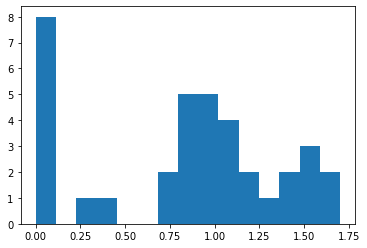

time: 17min 52s


In [157]:
start = "2018-06-04 08:00:00"
end = "2018-06-04 15:00:00"

inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s")
dist_df2 = pd.DataFrame()
dist_df2['inprox'] = inprox
dist_df2['not_inprox'] = not_in_prox
dist_df2['ratio'] = dist_df2['inprox'].apply(np.var) / dist_df2['not_inprox'].apply(np.var)
%matplotlib inline
plt.hist(dist_df2['ratio'], bins=15)

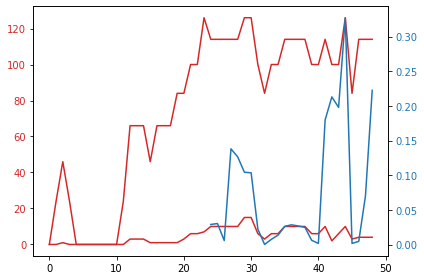

time: 473 ms


In [171]:
dist_df0['inprox_length'] = dist_df['inprox'].apply(len)
dist_df0['not_inprox_length'] = dist_df['not_inprox'].apply(len)
dist_df0['ratio'] = dist_df['ratio']
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(dist_df0['inprox_length'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1.plot(dist_df0['not_inprox_length'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(dist_df0['ratio'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

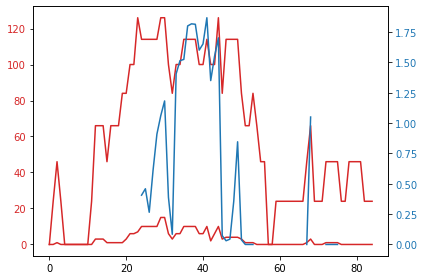

time: 388 ms


In [167]:
dist_df1['inprox_length'] = dist_df1['inprox'].apply(len)
dist_df1['not_inprox_length'] = dist_df1['not_inprox'].apply(len)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(dist_df1['inprox_length'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1.plot(dist_df1['not_inprox_length'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(dist_df1['ratio'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

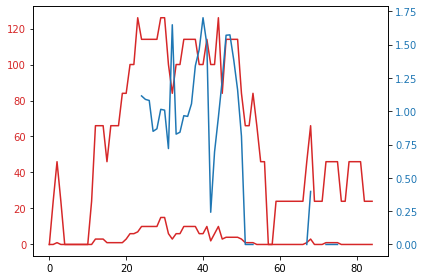

time: 334 ms


In [170]:
dist_df2['inprox_length'] = dist_df2['inprox'].apply(len)
dist_df2['not_inprox_length'] = dist_df2['not_inprox'].apply(len)
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(dist_df2['inprox_length'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1.plot(dist_df2['not_inprox_length'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(dist_df2['ratio'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### Event 1###

In [6]:
event1 = pd.read_parquet("/data/event1.parquet.snappy")


time: 10.1 ms


In [27]:
start = "2018-06-04 08:00:00"
end = "2018-06-04 15:00:00"


data_acc_e1 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = distance_calc(data_acc_e1, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s")
inprox_1, not_in_prox_1 = distance_calc(data_acc_e1, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s")
inprox_2, not_in_prox_2 = distance_calc(data_acc_e1, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s")

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event1.parquet.snappy")


Data sufficient for devices :{9, 19, 24, 27, 29, 31, 38, 50, 51, 56, 59, 62, 63, 65, 71, 83, 85, 92, 95, 97, 101, 102, 117, 119, 125}
1/85
2/85
3/85
4/85
5/85
6/85
7/85
8/85
9/85
10/85
11/85
12/85
13/85
14/85
15/85
16/85
17/85
18/85
19/85
20/85
21/85
22/85
23/85
24/85
25/85
26/85
27/85
28/85
29/85
30/85
31/85
32/85
33/85
34/85
35/85
36/85
37/85
38/85
39/85
40/85
41/85
42/85
43/85
44/85
45/85
46/85
47/85
48/85
49/85
50/85
51/85
52/85
53/85
54/85
55/85
56/85
57/85
58/85
59/85
60/85
61/85
62/85
63/85
64/85
65/85
66/85
67/85
68/85
69/85
70/85
71/85
72/85
73/85
74/85
75/85
76/85
77/85
78/85
79/85
80/85
81/85
82/85
83/85
84/85
85/85
Data sufficient for devices :{9, 19, 24, 27, 29, 31, 38, 50, 51, 56, 59, 62, 63, 65, 71, 83, 85, 92, 95, 97, 101, 102, 117, 119, 125}
1/85
2/85
3/85
4/85
5/85
6/85
7/85
8/85
9/85
10/85
11/85
12/85
13/85
14/85
15/85
16/85
17/85
18/85
19/85
20/85
21/85
22/85
23/85
24/85
25/85
26/85
27/85
28/85
29/85
30/85
31/85
32/85
33/85
34/85
35/85
36/85
37/85
38/85
39/85
40/85


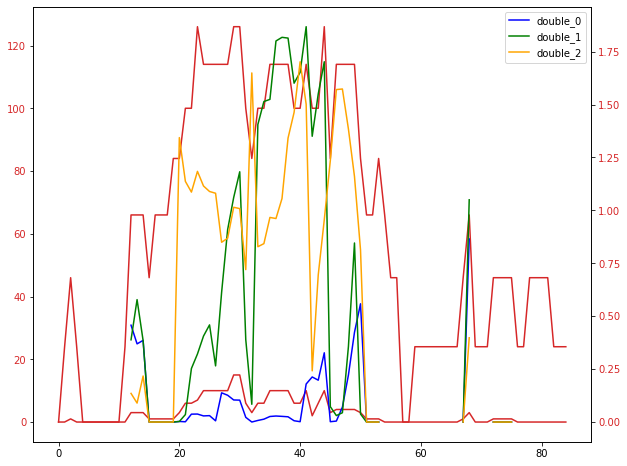

time: 406 ms


In [83]:
val0 = event1['inprox_0'].apply(np.nanvar) / event1['not_inprox_0'].apply(np.nanvar)
val1 = event1['inprox_1'].apply(np.nanvar) / event1['not_inprox_1'].apply(np.nanvar)
val2 = event1['inprox_2'].apply(np.nanvar) / event1['not_inprox_2'].apply(np.nanvar)

%matplotlib inline  

f, ax1 = plt.subplots(figsize=(10,8))

color = 'tab:red'
ax1.plot(event1['inprox_0'].apply(len), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1.plot(event1['not_inprox_0'].apply(len), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(val0, color="blue", label = "double_0")
ax2.plot(val1, color="green", label = "double_1")
ax2.plot(val2, color="orange", label = "double_2")

ax2.tick_params(axis='y', labelcolor=color)
ax2.legend()
fig.tight_layout() 
plt.show()

(array([34.,  4.,  4.,  1.,  3.,  1.,  1.,  0.,  0.,  1.]),
 array([0.        , 0.08648372, 0.17296745, 0.25945117, 0.3459349 ,
        0.43241862, 0.51890235, 0.60538607, 0.6918698 , 0.77835352,
        0.86483725]),
 <a list of 10 Patch objects>)

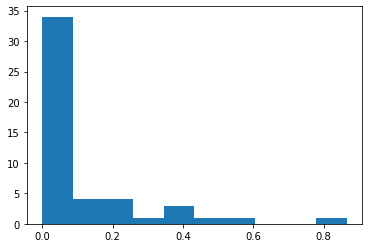

time: 242 ms


In [84]:
plt.hist(val0)

(array([21.,  4.,  5.,  2.,  2.,  2.,  1.,  2.,  5.,  5.]),
 array([0.        , 0.18680723, 0.37361446, 0.5604217 , 0.74722893,
        0.93403616, 1.12084339, 1.30765063, 1.49445786, 1.68126509,
        1.86807232]),
 <a list of 10 Patch objects>)

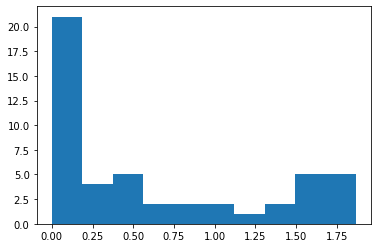

time: 368 ms


In [85]:
plt.hist(val1)

(array([16.,  2.,  1.,  0.,  6.,  6.,  8.,  3.,  3.,  4.]),
 array([0.        , 0.17023033, 0.34046067, 0.510691  , 0.68092134,
        0.85115167, 1.02138201, 1.19161234, 1.36184268, 1.53207301,
        1.70230335]),
 <a list of 10 Patch objects>)

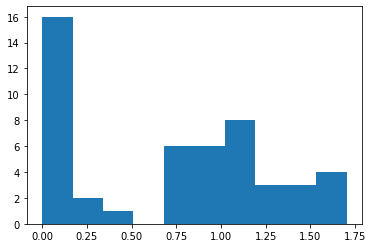

time: 244 ms


In [86]:
plt.hist(val2)

#### Event 2 ####

In [7]:
event2 = pd.read_parquet("/data/event2.parquet.snappy")


time: 13.5 ms


In [28]:
start = "2018-05-16 09:00:00"
end = "2018-05-16 15:00:00"

data_acc_e2 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = distance_calc(data_acc_e2, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s")
inprox_1, not_in_prox_1 = distance_calc(data_acc_e2, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s")
inprox_2, not_in_prox_2 = distance_calc(data_acc_e2, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s")

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event2.parquet.snappy")

Data sufficient for devices :{8, 9, 11, 12, 22, 32, 34, 41, 48, 50, 51, 57, 59, 63, 65, 68, 83, 84, 85, 92, 93, 94, 95, 99, 100, 108, 117, 121}
1/73
2/73
3/73
4/73
5/73
6/73
7/73
8/73
9/73
10/73
11/73
12/73
13/73
14/73
15/73
16/73
17/73
18/73
19/73
20/73
21/73
22/73
23/73
24/73
25/73
26/73
27/73
28/73
29/73
30/73
31/73
32/73
33/73
34/73
35/73
36/73
37/73
38/73
39/73
40/73
41/73
42/73
43/73
44/73
45/73
46/73
47/73
48/73
49/73
50/73
51/73
52/73
53/73
54/73
55/73
56/73
57/73
58/73
59/73
60/73
61/73
62/73
63/73
64/73
65/73
66/73
67/73
68/73
69/73
70/73
71/73
72/73
73/73
Data sufficient for devices :{8, 9, 11, 12, 22, 32, 34, 41, 48, 50, 51, 57, 59, 63, 65, 68, 83, 84, 85, 92, 93, 94, 95, 99, 100, 108, 117, 121}
1/73
2/73
3/73
4/73
5/73
6/73
7/73
8/73
9/73
10/73
11/73
12/73
13/73
14/73
15/73
16/73
17/73
18/73
19/73
20/73
21/73
22/73
23/73
24/73
25/73
26/73
27/73
28/73
29/73
30/73
31/73
32/73
33/73
34/73
35/73
36/73
37/73
38/73
39/73
40/73
41/73
42/73
43/73
44/73
45/73
46/73
47/73
48/73
49/7

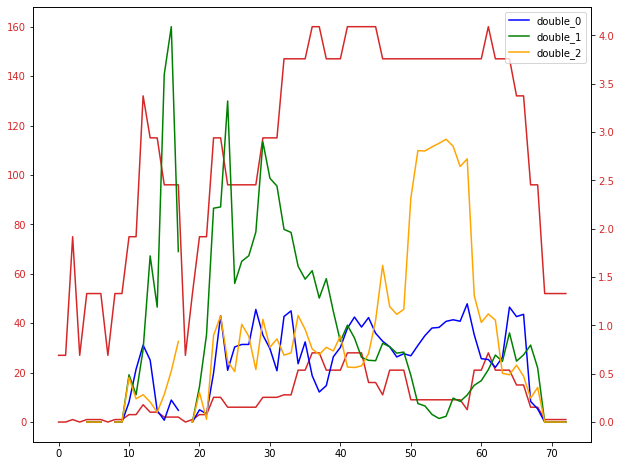

time: 478 ms


In [87]:
val0 = event2['inprox_0'].apply(np.nanvar) / event2['not_inprox_0'].apply(np.nanvar)
val1 = event2['inprox_1'].apply(np.nanvar) / event2['not_inprox_1'].apply(np.nanvar)
val2 = event2['inprox_2'].apply(np.nanvar) / event2['not_inprox_2'].apply(np.nanvar)

%matplotlib inline  

f, ax1 = plt.subplots(figsize=(10,8))

color = 'tab:red'
ax1.plot(event2['inprox_0'].apply(len), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1.plot(event2['not_inprox_0'].apply(len), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(val0, color="blue", label = "double_0")
ax2.plot(val1, color="green", label = "double_1")
ax2.plot(val2, color="orange", label = "double_2")

ax2.tick_params(axis='y', labelcolor=color)
ax2.legend()
fig.tight_layout() 
plt.show()

(array([15.,  5.,  1.,  2.,  6.,  8., 10.,  6., 10.,  5.]),
 array([0.        , 0.12227529, 0.24455057, 0.36682586, 0.48910115,
        0.61137643, 0.73365172, 0.85592701, 0.97820229, 1.10047758,
        1.22275287]),
 <a list of 10 Patch objects>)

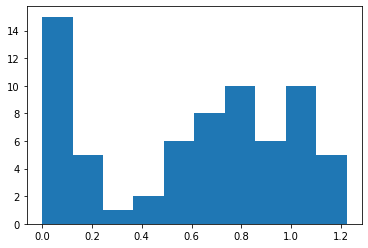

time: 215 ms


In [88]:
plt.hist(val0)

(array([22., 18.,  7.,  6.,  7.,  3.,  1.,  1.,  2.,  1.]),
 array([0.       , 0.4089213, 0.8178426, 1.2267639, 1.6356852, 2.0446065,
        2.4535278, 2.8624491, 3.2713704, 3.6802917, 4.089213 ]),
 <a list of 10 Patch objects>)

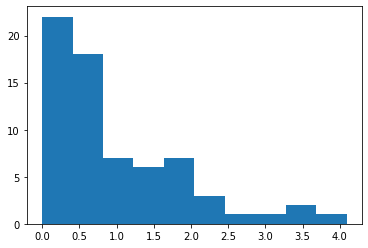

time: 204 ms


In [89]:
plt.hist(val1)

(array([18., 12., 12., 14.,  2.,  1.,  0.,  1.,  0.,  8.]),
 array([0.        , 0.29251903, 0.58503806, 0.8775571 , 1.17007613,
        1.46259516, 1.75511419, 2.04763322, 2.34015225, 2.63267129,
        2.92519032]),
 <a list of 10 Patch objects>)

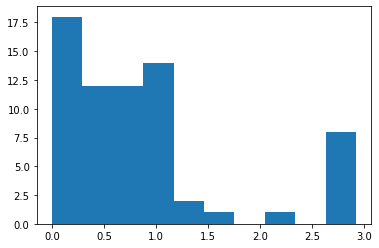

time: 210 ms


In [90]:
plt.hist(val2)

#### Event 3 ####

In [8]:
event3 = pd.read_parquet("/data/event3.parquet.snappy")


time: 10.8 ms


In [29]:
start = "2018-05-30 09:00:00"
end = "2018-05-30 16:00:00"

data_acc_e3 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = distance_calc(data_acc_e3, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s")
inprox_1, not_in_prox_1 = distance_calc(data_acc_e3, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s")
inprox_2, not_in_prox_2 = distance_calc(data_acc_e3, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s")

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event3.parquet.snappy")

Data sufficient for devices :{3, 9, 10, 12, 15, 19, 24, 32, 38, 43, 50, 51, 59, 62, 63, 65, 71, 75, 83, 85, 92, 95, 97, 102, 117, 119, 125}
1/85
2/85
3/85
4/85
5/85
6/85
7/85
8/85
9/85
10/85
11/85
12/85
13/85
14/85
15/85
16/85
17/85
18/85
19/85
20/85
21/85
22/85
23/85
24/85
25/85
26/85
27/85
28/85
29/85
30/85
31/85
32/85
33/85
34/85
35/85
36/85
37/85
38/85
39/85
40/85
41/85
42/85
43/85
44/85
45/85
46/85
47/85
48/85
49/85
50/85
51/85
52/85
53/85
54/85
55/85
56/85
57/85
58/85
59/85
60/85
61/85
62/85
63/85
64/85
65/85
66/85
67/85
68/85
69/85
70/85
71/85
72/85
73/85
74/85
75/85
76/85
77/85
78/85
79/85
80/85
81/85
82/85
83/85
84/85
85/85
Data sufficient for devices :{3, 9, 10, 12, 15, 19, 24, 32, 38, 43, 50, 51, 59, 62, 63, 65, 71, 75, 83, 85, 92, 95, 97, 102, 117, 119, 125}
1/85
2/85
3/85
4/85
5/85
6/85
7/85
8/85
9/85
10/85
11/85
12/85
13/85
14/85
15/85
16/85
17/85
18/85
19/85
20/85
21/85
22/85
23/85
24/85
25/85
26/85
27/85
28/85
29/85
30/85
31/85
32/85
33/85
34/85
35/85
36/85
37/85
38/85


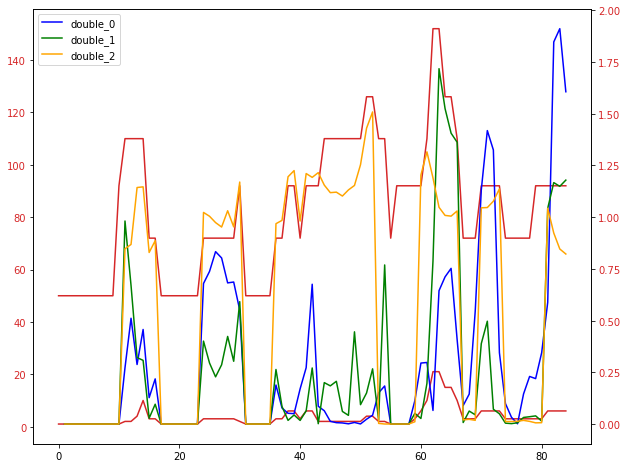

time: 470 ms


In [91]:
val0 = event3['inprox_0'].apply(np.nanvar) / event3['not_inprox_0'].apply(np.nanvar)
val1 = event3['inprox_1'].apply(np.nanvar) / event3['not_inprox_1'].apply(np.nanvar)
val2 = event3['inprox_2'].apply(np.nanvar) / event3['not_inprox_2'].apply(np.nanvar)

%matplotlib inline  

f, ax1 = plt.subplots(figsize=(10,8))

color = 'tab:red'
ax1.plot(event3['inprox_0'].apply(len), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1.plot(event3['not_inprox_0'].apply(len), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(val0, color="blue", label = "double_0")
ax2.plot(val1, color="green", label = "double_1")
ax2.plot(val2, color="orange", label = "double_2")

ax2.tick_params(axis='y', labelcolor=color)
ax2.legend()
fig.tight_layout() 
plt.show()

(array([52., 10.,  5.,  9.,  2.,  1.,  1.,  1.,  1.,  2.]),
 array([0.        , 0.19109331, 0.38218662, 0.57327993, 0.76437324,
        0.95546655, 1.14655985, 1.33765316, 1.52874647, 1.71983978,
        1.91093309]),
 <a list of 10 Patch objects>)

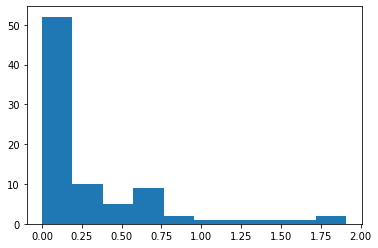

time: 260 ms


In [92]:
plt.hist(val0)

(array([53., 13.,  5.,  2.,  2.,  1.,  4.,  1.,  2.,  1.]),
 array([0.        , 0.17176304, 0.34352608, 0.51528912, 0.68705216,
        0.8588152 , 1.03057824, 1.20234128, 1.37410432, 1.54586736,
        1.7176304 ]),
 <a list of 10 Patch objects>)

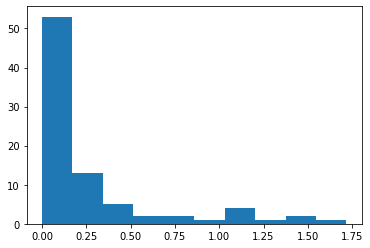

time: 224 ms


In [93]:
plt.hist(val1)

(array([39.,  0.,  0.,  0.,  0.,  6., 17., 15.,  5.,  2.]),
 array([0.        , 0.1508536 , 0.3017072 , 0.45256079, 0.60341439,
        0.75426799, 0.90512159, 1.05597518, 1.20682878, 1.35768238,
        1.50853598]),
 <a list of 10 Patch objects>)

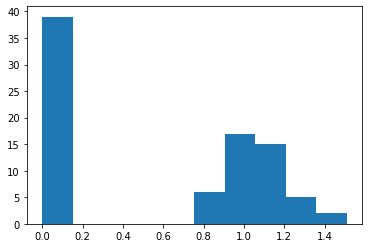

time: 219 ms


In [94]:
plt.hist(val2)

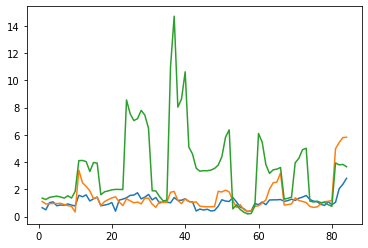

time: 326 ms


In [76]:
plt.plot(event3['inprox_0'].apply(np.nanmean) / event3['not_inprox_0'].apply(np.nanmedian))
plt.plot(event3['inprox_1'].apply(np.nanmean) / event3['not_inprox_1'].apply(np.nanmedian))
plt.plot(event3['inprox_2'].apply(np.nanmean) / event3['not_inprox_2'].apply(np.nanmedian))


#### Event 4 ####

In [62]:
start = "2018-06-04 08:00:00"
end = "2018-06-04 15:00:00"
data_acc_e4 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = distance_calc(data_acc_e4, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s")
inprox_1, not_in_prox_1 = distance_calc(data_acc_e4, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s")
inprox_2, not_in_prox_2 = distance_calc(data_acc_e4, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s")

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event4.parquet.snappy")

Data sufficient for devices :{9, 19, 24, 27, 29, 31, 38, 50, 51, 56, 59, 62, 63, 65, 71, 83, 85, 92, 95, 97, 101, 102, 117, 119, 125}
1/85
2/85
3/85
4/85
5/85
6/85
7/85
8/85
9/85
10/85
11/85
12/85
13/85
14/85
15/85
16/85
17/85
18/85
19/85
20/85
21/85
22/85
23/85
24/85
25/85
26/85
27/85
28/85
29/85
30/85
31/85
32/85
33/85
34/85
35/85
36/85
37/85
38/85
39/85
40/85
41/85
42/85
43/85
44/85
45/85
46/85
47/85
48/85
49/85
50/85
51/85
52/85
53/85
54/85
55/85
56/85
57/85
58/85
59/85
60/85
61/85
62/85
63/85
64/85
65/85
66/85
67/85
68/85
69/85
70/85
71/85
72/85
73/85
74/85
75/85
76/85
77/85
78/85
79/85
80/85
81/85
82/85
83/85
84/85
85/85
Data sufficient for devices :{9, 19, 24, 27, 29, 31, 38, 50, 51, 56, 59, 62, 63, 65, 71, 83, 85, 92, 95, 97, 101, 102, 117, 119, 125}
1/85
2/85
3/85
4/85
5/85
6/85
7/85
8/85
9/85
10/85
11/85
12/85
13/85
14/85
15/85
16/85
17/85
18/85
19/85
20/85
21/85
22/85
23/85
24/85
25/85
26/85
27/85
28/85
29/85
30/85
31/85
32/85
33/85
34/85
35/85
36/85
37/85
38/85
39/85
40/85


In [90]:
start = "2018-06-04 08:00:00"
end = "2018-06-04 15:00:00"
data_acc_e4 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = cosine_distance_calc(data_acc_e4, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s")
inprox_1, not_in_prox_1 = cosine_distance_calc(data_acc_e4, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s")
inprox_2, not_in_prox_2 = cosine_distance_calc(data_acc_e4, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s")

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event4_cosine.parquet.snappy")

Data sufficient for devices :{9, 19, 24, 27, 29, 31, 38, 50, 51, 56, 59, 62, 63, 65, 71, 83, 85, 92, 95, 97, 101, 102, 117, 119, 125}
1/85
2/85
3/85
4/85
5/85
6/85
7/85
8/85
9/85
10/85
11/85
12/85
13/85
14/85
15/85
16/85
17/85
18/85
19/85
20/85
21/85
22/85
23/85
24/85
25/85
26/85
27/85
28/85
29/85
30/85
31/85
32/85
33/85
34/85
35/85
36/85
37/85
38/85
39/85
40/85
41/85
42/85
43/85
44/85
45/85
46/85
47/85
48/85
49/85
50/85
51/85
52/85
53/85
54/85
55/85
56/85
57/85
58/85
59/85
60/85
61/85
62/85
63/85
64/85
65/85
66/85
67/85
68/85
69/85
70/85
71/85
72/85
73/85
74/85
75/85
76/85
77/85
78/85
79/85
80/85
81/85
82/85
83/85
84/85
85/85
Data sufficient for devices :{9, 19, 24, 27, 29, 31, 38, 50, 51, 56, 59, 62, 63, 65, 71, 83, 85, 92, 95, 97, 101, 102, 117, 119, 125}
1/85
2/85
3/85
4/85
5/85
6/85
7/85
8/85
9/85
10/85
11/85
12/85
13/85
14/85
15/85
16/85
17/85
18/85
19/85
20/85
21/85
22/85
23/85
24/85
25/85
26/85
27/85
28/85
29/85
30/85
31/85
32/85
33/85
34/85
35/85
36/85
37/85
38/85
39/85
40/85


#### Event 5 ####

In [63]:
start = "2018-06-11 07:30:00"
end = "2018-06-11 16:00:00"
data_acc_e5 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = distance_calc(data_acc_e5, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s")
inprox_1, not_in_prox_1 = distance_calc(data_acc_e5, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s")
inprox_2, not_in_prox_2 = distance_calc(data_acc_e5, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s")

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event5.parquet.snappy")

Data sufficient for devices :{102, 71, 9, 10, 59, 92, 29, 83, 50, 117, 118, 19, 120, 119, 24, 27, 60, 125, 62, 31}
1/103
2/103
3/103
4/103
5/103
6/103
7/103
8/103
9/103
10/103
11/103
12/103
13/103
14/103
15/103
16/103
17/103
18/103
19/103
20/103
21/103
22/103
23/103
24/103
25/103
26/103
27/103
28/103
29/103
30/103
31/103
32/103
33/103
34/103
35/103
36/103
37/103
38/103
39/103
40/103
41/103
42/103
43/103
44/103
45/103
46/103
47/103
48/103
49/103
50/103
51/103
52/103
53/103
54/103
55/103
56/103
57/103
58/103
59/103
60/103
61/103
62/103
63/103
64/103
65/103
66/103
67/103
68/103
69/103
70/103
71/103
72/103
73/103
74/103
75/103
76/103
77/103
78/103
79/103
80/103
81/103
82/103
83/103
84/103
85/103
86/103
87/103
88/103
89/103
90/103
91/103
92/103
93/103
94/103
95/103
96/103
97/103
98/103
99/103
100/103
101/103
102/103
103/103
Data sufficient for devices :{102, 71, 9, 10, 59, 92, 29, 83, 50, 117, 118, 19, 120, 119, 24, 27, 60, 125, 62, 31}
1/103
2/103
3/103
4/103
5/103
6/103
7/103
8/103
9/103


In [ ]:
start = "2018-06-11 07:30:00"
end = "2018-06-11 16:00:00"
data_acc_e5 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = cosine_distance_calc(data_acc_e5, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s")
inprox_1, not_in_prox_1 = cosine_distance_calc(data_acc_e5, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s")
inprox_2, not_in_prox_2 = cosine_distance_calc(data_acc_e5, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s")

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event5_cosine.parquet.snappy")

Data sufficient for devices :{102, 71, 9, 10, 59, 92, 29, 83, 50, 117, 118, 19, 120, 119, 24, 27, 60, 125, 62, 31}
1/103
2/103


#### Event  6####

In [3]:
start = "2018-06-18 07:00:00"
end = "2018-06-18 17:00:00"

data_acc_e6 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = distance_calc(data_acc_e6, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s")
inprox_1, not_in_prox_1 = distance_calc(data_acc_e6, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s")
inprox_2, not_in_prox_2 = distance_calc(data_acc_e6, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s")

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event6.parquet.snappy")

Data sufficient for devices :{3, 101, 102, 71, 5, 9, 38, 50, 19, 83, 51, 117, 119, 24, 27, 92, 125, 62, 95}
1/121
2/121
3/121
4/121
5/121
6/121
7/121
8/121
9/121
10/121
11/121
12/121
13/121
14/121
15/121
16/121
17/121
18/121
19/121
20/121
21/121
22/121
23/121
24/121
25/121
26/121
27/121
28/121
29/121
30/121
31/121
32/121
33/121
34/121
35/121
36/121
37/121
38/121
39/121
40/121
41/121
42/121
43/121
44/121
45/121
46/121
47/121
48/121
49/121
50/121
51/121
52/121
53/121
54/121
55/121
56/121
57/121
58/121
59/121
60/121
61/121
62/121
63/121
64/121
65/121
66/121
67/121
68/121
69/121
70/121
71/121
72/121
73/121
74/121
75/121
76/121
77/121
78/121
79/121
80/121
81/121
82/121
83/121
84/121
85/121
86/121
87/121
88/121
89/121
90/121
91/121
92/121
93/121
94/121
95/121
96/121
97/121
98/121
99/121
100/121
101/121
102/121
103/121
104/121
105/121
106/121
107/121
108/121
109/121
110/121
111/121
112/121
113/121
114/121
115/121
116/121
117/121
118/121
119/121
120/121
121/121
Data sufficient for devices :{3,

In [ ]:
start = "2018-06-18 07:00:00"
end = "2018-06-18 17:00:00"

data_acc_e6 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = cosine_distance_calc(data_acc_e6, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s")
inprox_1, not_in_prox_1 = cosine_distance_calc(data_acc_e6, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s")
inprox_2, not_in_prox_2 = cosine_distance_calc(data_acc_e6, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s")

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event6_cosine.parquet.snappy")

#### Scatter Plots Mean DTW Distance vs Variance DTW Distance ####

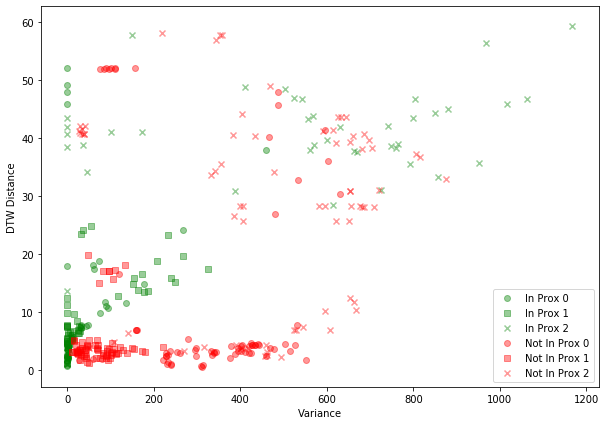

time: 609 ms


In [59]:
start = "2018-06-04 08:00:00"
end = "2018-06-04 15:00:00"

scatter_df_prox = pd.DataFrame()
scatter_df_prox['var_0'] = event1['inprox_0'].apply(np.nanvar)
scatter_df_prox['distance_0'] = event1['inprox_0'].apply(np.nanmean)
scatter_df_prox['var_1'] = event1['inprox_1'].apply(np.nanvar)
scatter_df_prox['distance_1'] = event1['inprox_1'].apply(np.nanmean)
scatter_df_prox['var_2'] = event1['inprox_2'].apply(np.nanvar)
scatter_df_prox['distance_2'] = event1['inprox_2'].apply(np.nanmean)

scatter_df_np = pd.DataFrame()
scatter_df_np['var_0'] = event1['not_inprox_0'].apply(np.nanvar)
scatter_df_np['distance_0'] = event1['not_inprox_0'].apply(np.nanmedian)
scatter_df_np['var_1'] = event1['not_inprox_1'].apply(np.nanvar)
scatter_df_np['distance_1'] = event1['not_inprox_1'].apply(np.nanmedian)
scatter_df_np['var_2'] = event1['not_inprox_2'].apply(np.nanvar)
scatter_df_np['distance_2'] = event1['not_inprox_2'].apply(np.nanmedian)

plt.figure(figsize=(10,7))
plt.xlabel("Variance")
plt.ylabel("DTW Distance")
plt.scatter(scatter_df_prox['var_0'],scatter_df_prox['distance_0'],color="green", alpha = 0.4, label="In Prox 0")
plt.scatter(scatter_df_prox['var_1'],scatter_df_prox['distance_1'],color="green", alpha = 0.4, label="In Prox 1", marker="s")
plt.scatter(scatter_df_prox['var_2'],scatter_df_prox['distance_2'],color="green", alpha = 0.4, label="In Prox 2",marker="x")



plt.scatter(scatter_df_np['var_0'],scatter_df_np['distance_0'], color="red", alpha = 0.4,label="Not In Prox 0")
plt.scatter(scatter_df_np['var_1'],scatter_df_np['distance_1'], color="red", alpha = 0.4,label="Not In Prox 1", marker="s")
plt.scatter(scatter_df_np['var_2'],scatter_df_np['distance_2'], color="red", alpha = 0.4,label="Not In Prox 2", marker="x")
plt.legend()

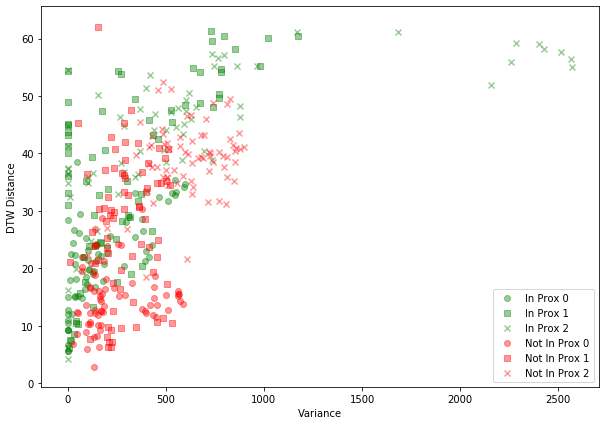

time: 594 ms


In [61]:
start = "2018-05-16 09:00:00"
end = "2018-05-16 15:00:00"

scatter_df_prox = pd.DataFrame()
scatter_df_prox['var_0'] = event2['inprox_0'].apply(np.nanvar)
scatter_df_prox['distance_0'] = event2['inprox_0'].apply(np.nanmean)
scatter_df_prox['var_1'] = event2['inprox_1'].apply(np.nanvar)
scatter_df_prox['distance_1'] = event2['inprox_1'].apply(np.nanmean)
scatter_df_prox['var_2'] = event2['inprox_2'].apply(np.nanvar)
scatter_df_prox['distance_2'] = event2['inprox_2'].apply(np.nanmean)

scatter_df_np = pd.DataFrame()
scatter_df_np['var_0'] = event2['not_inprox_0'].apply(np.nanvar)
scatter_df_np['distance_0'] = event2['not_inprox_0'].apply(np.nanmedian)
scatter_df_np['var_1'] = event2['not_inprox_1'].apply(np.nanvar)
scatter_df_np['distance_1'] = event2['not_inprox_1'].apply(np.nanmedian)
scatter_df_np['var_2'] = event2['not_inprox_2'].apply(np.nanvar)
scatter_df_np['distance_2'] = event2['not_inprox_2'].apply(np.nanmedian)

plt.figure(figsize=(10,7))
plt.xlabel("Variance")
plt.ylabel("DTW Distance")
plt.scatter(scatter_df_prox['var_0'],scatter_df_prox['distance_0'],color="green", alpha = 0.4, label="In Prox 0")
plt.scatter(scatter_df_prox['var_1'],scatter_df_prox['distance_1'],color="green", alpha = 0.4, label="In Prox 1", marker="s")
plt.scatter(scatter_df_prox['var_2'],scatter_df_prox['distance_2'],color="green", alpha = 0.4, label="In Prox 2",marker="x")



plt.scatter(scatter_df_np['var_0'],scatter_df_np['distance_0'], color="red", alpha = 0.4,label="Not In Prox 0")
plt.scatter(scatter_df_np['var_1'],scatter_df_np['distance_1'], color="red", alpha = 0.4,label="Not In Prox 1", marker="s")
plt.scatter(scatter_df_np['var_2'],scatter_df_np['distance_2'], color="red", alpha = 0.4,label="Not In Prox 2", marker="x")
plt.legend()

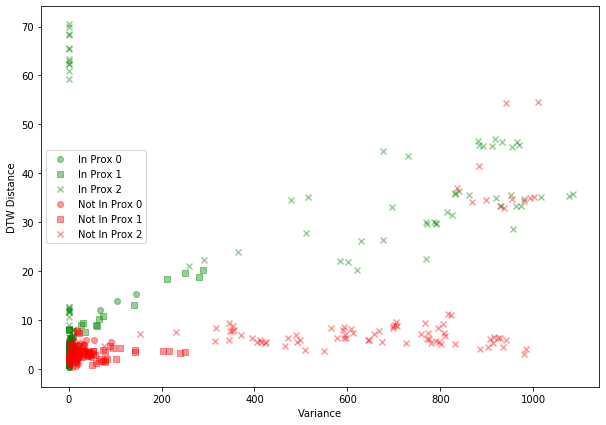

time: 533 ms


In [60]:
start = "2018-05-30 09:00:00"
end = "2018-05-30 16:00:00"

scatter_df_prox = pd.DataFrame()
scatter_df_prox['var_0'] = event3['inprox_0'].apply(np.nanvar)
scatter_df_prox['distance_0'] = event3['inprox_0'].apply(np.nanmean)
scatter_df_prox['var_1'] = event3['inprox_1'].apply(np.nanvar)
scatter_df_prox['distance_1'] = event3['inprox_1'].apply(np.nanmean)
scatter_df_prox['var_2'] = event3['inprox_2'].apply(np.nanvar)
scatter_df_prox['distance_2'] = event3['inprox_2'].apply(np.nanmean)

scatter_df_np = pd.DataFrame()
scatter_df_np['var_0'] = event3['not_inprox_0'].apply(np.nanvar)
scatter_df_np['distance_0'] = event3['not_inprox_0'].apply(np.nanmedian)
scatter_df_np['var_1'] = event3['not_inprox_1'].apply(np.nanvar)
scatter_df_np['distance_1'] = event3['not_inprox_1'].apply(np.nanmedian)
scatter_df_np['var_2'] = event3['not_inprox_2'].apply(np.nanvar)
scatter_df_np['distance_2'] = event3['not_inprox_2'].apply(np.nanmedian)

plt.figure(figsize=(10,7))
plt.xlabel("Variance")
plt.ylabel("DTW Distance")
plt.scatter(scatter_df_prox['var_0'],scatter_df_prox['distance_0'],color="green", alpha = 0.4, label="In Prox 0")
plt.scatter(scatter_df_prox['var_1'],scatter_df_prox['distance_1'],color="green", alpha = 0.4, label="In Prox 1", marker="s")
plt.scatter(scatter_df_prox['var_2'],scatter_df_prox['distance_2'],color="green", alpha = 0.4, label="In Prox 2",marker="x")



plt.scatter(scatter_df_np['var_0'],scatter_df_np['distance_0'], color="red", alpha = 0.4,label="Not In Prox 0")
plt.scatter(scatter_df_np['var_1'],scatter_df_np['distance_1'], color="red", alpha = 0.4,label="Not In Prox 1", marker="s")
plt.scatter(scatter_df_np['var_2'],scatter_df_np['distance_2'], color="red", alpha = 0.4,label="Not In Prox 2", marker="x")
plt.legend()

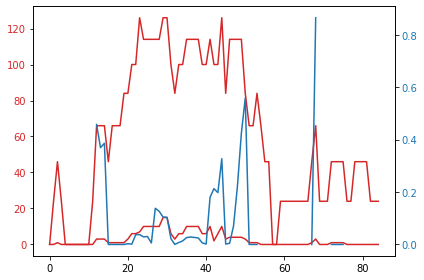

time: 377 ms


In [33]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(event1['inprox_0'].apply(len), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1.plot(event1['not_inprox_0'].apply(len), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(x, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Variance based Distance ###

#### iphone 6 Event 1 #### 

In [ ]:
start = "2018-05-30 09:00:00"
end = "2018-05-30 16:00:00"

inprox, not_in_prox = distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s")
dist_df2 = pd.DataFrame()
dist_df2['inprox'] = inprox
dist_df2['not_inprox'] = not_in_prox


In [29]:
start = "2018-05-23 11:30:00"
end = "2018-05-23 15:00:00"
inprox, not_in_prox = variance_distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s", all_iphone6)

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data sufficient for devices :{71, 9, 15, 51, 83, 85, 117, 119}
1/43
2/43
3/43
4/43
5/43
6/43
7/43
8/43
9/43
10/43
11/43
12/43
13/43
14/43
15/43
16/43
17/43
18/43
19/43
20/43
21/43
22/43
23/43
24/43
25/43
26/43
27/43
28/43
29/43
30/43
31/43
32/43
33/43
34/43
35/43
36/43
37/43
38/43
39/43
40/43
41/43
42/43
43/43
time: 1min 10s


(array([ 0.,  0.,  0.,  1.,  6., 10.,  9.,  0.]),
 array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 <a list of 8 Patch objects>)

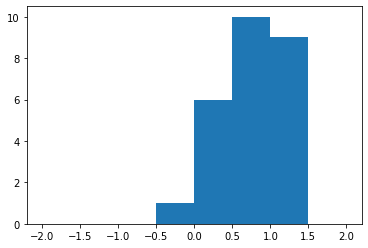

time: 289 ms


In [30]:
dist_df0 = pd.DataFrame()
dist_df0['inprox'] = inprox
dist_df0['not_inprox'] = not_in_prox
dist_df0['ratio'] = dist_df0['inprox'].apply(np.nanmean) / dist_df0['inprox'].apply(np.nanmedian)
%matplotlib inline
plt.hist(dist_df0['ratio'], bins=[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])

In [31]:
start = "2018-05-23 11:30:00"
end = "2018-05-23 15:00:00"
inprox, not_in_prox = variance_distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s", all_iphone6)

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data sufficient for devices :{71, 9, 15, 51, 83, 85, 117, 119}
1/43
2/43
3/43
4/43
5/43
6/43
7/43
8/43
9/43
10/43
11/43
12/43
13/43
14/43
15/43
16/43
17/43
18/43
19/43
20/43
21/43
22/43
23/43
24/43
25/43
26/43
27/43
28/43
29/43
30/43
31/43
32/43
33/43
34/43
35/43
36/43
37/43
38/43
39/43
40/43
41/43
42/43
43/43
time: 1min 2s


(array([ 0.,  0.,  0.,  3.,  3.,  6., 12.,  1.]),
 array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 <a list of 8 Patch objects>)

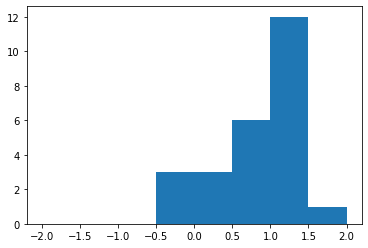

time: 291 ms


In [33]:
dist_df1 = pd.DataFrame()
dist_df1['inprox'] = inprox
dist_df1['not_inprox'] = not_in_prox
dist_df1['ratio'] = dist_df1['inprox'].apply(np.nanmean) / dist_df1['inprox'].apply(np.nanmedian)
%matplotlib inline
plt.hist(dist_df1['ratio'], bins=[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])

In [34]:
start = "2018-05-23 11:30:00"
end = "2018-05-23 15:00:00"
inprox, not_in_prox = variance_distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s", all_iphone6)

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data sufficient for devices :{71, 9, 15, 51, 83, 85, 117, 119}
1/43
2/43
3/43
4/43
5/43
6/43
7/43
8/43
9/43
10/43
11/43
12/43
13/43
14/43
15/43
16/43
17/43
18/43
19/43
20/43
21/43
22/43
23/43
24/43
25/43
26/43
27/43
28/43
29/43
30/43
31/43
32/43
33/43
34/43
35/43
36/43
37/43
38/43
39/43
40/43
41/43
42/43
43/43
time: 1min 5s


(array([ 0.,  0.,  0.,  3.,  3.,  6., 12.,  1.]),
 array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 <a list of 8 Patch objects>)

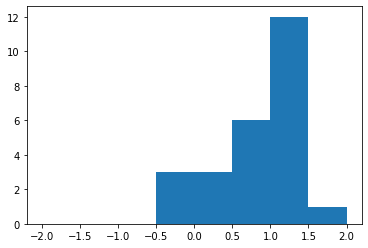

time: 267 ms


In [35]:
dist_df2 = pd.DataFrame()
dist_df2['inprox'] = inprox
dist_df2['not_inprox'] = not_in_prox
dist_df2['ratio'] = dist_df2['inprox'].apply(np.nanmean) / dist_df2['inprox'].apply(np.nanmedian)
%matplotlib inline
plt.hist(dist_df1['ratio'], bins=[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])

#### iphone6 event 2 ####

In [28]:
start = "2018-05-28 07:00:00"
end = "2018-05-28 15:00:00"
inprox, not_in_prox = variance_distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s", all_iphone6)

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data sufficient for devices :{71, 9, 15, 51, 83, 85, 117, 119, 29}
1/97
2/97
3/97
4/97
5/97
6/97
7/97
8/97
9/97
10/97
11/97
12/97
13/97
14/97
15/97
16/97
17/97
18/97
19/97
20/97
21/97
22/97
23/97
24/97
25/97
26/97
27/97
28/97
29/97
30/97
31/97
32/97
33/97
34/97
35/97
36/97
37/97
38/97
39/97
40/97
41/97
42/97
43/97
44/97
45/97
46/97
47/97
48/97
49/97
50/97
51/97
52/97
53/97
54/97
55/97
56/97
57/97
58/97
59/97
60/97
61/97
62/97
63/97
64/97
65/97
66/97
67/97
68/97
69/97
70/97
71/97
72/97
73/97
74/97
75/97
76/97
77/97
78/97
79/97
80/97
81/97
82/97
83/97
84/97
85/97
86/97
87/97
88/97
89/97
90/97
91/97
92/97
93/97
94/97
95/97
96/97
97/97
time: 6min 36s


(array([ 0.,  0.,  0.,  4.,  8.,  3., 13.,  0.]),
 array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 <a list of 8 Patch objects>)

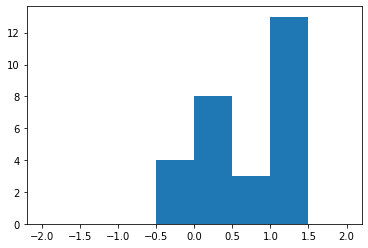

time: 302 ms


In [36]:
dist_df0 = pd.DataFrame()
dist_df0['inprox'] = inprox
dist_df0['not_inprox'] = not_in_prox
dist_df0['ratio'] = dist_df0['inprox'].apply(np.nanmean) / dist_df0['inprox'].apply(np.nanmedian)
%matplotlib inline
plt.hist(dist_df0['ratio'], bins=[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])

In [37]:
start = "2018-05-28 07:00:00"
end = "2018-05-28 15:00:00"

time: 1.2 ms


/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data sufficient for devices :{71, 9, 15, 51, 83, 85, 117, 119, 29}
1/97
2/97
3/97
4/97
5/97
6/97
7/97
8/97
9/97
10/97
11/97
12/97
13/97
14/97
15/97
16/97
17/97
18/97
19/97
20/97
21/97
22/97
23/97
24/97
25/97
26/97
27/97
28/97
29/97
30/97
31/97
32/97
33/97
34/97
35/97
36/97
37/97
38/97
39/97
40/97
41/97
42/97
43/97
44/97
45/97
46/97
47/97
48/97
49/97
50/97
51/97
52/97
53/97
54/97
55/97
56/97
57/97
58/97
59/97
60/97
61/97
62/97
63/97
64/97
65/97
66/97
67/97
68/97
69/97
70/97
71/97
72/97
73/97
74/97
75/97
76/97
77/97
78/97
79/97
80/97
81/97
82/97
83/97
84/97
85/97
86/97
87/97
88/97
89/97
90/97
91/97
92/97
93/97
94/97
95/97
96/97
97/97


(array([ 0.,  0.,  1.,  1.,  3.,  3., 52.,  0.]),
 array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 <a list of 8 Patch objects>)

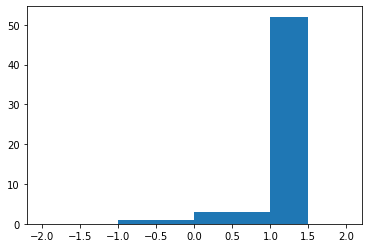

time: 5min 21s


In [38]:
inprox, not_in_prox = variance_distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s", all_iphone6)
dist_df1 = pd.DataFrame()
dist_df1['inprox'] = inprox
dist_df1['not_inprox'] = not_in_prox
dist_df1['ratio'] = dist_df1['inprox'].apply(np.nanmean) / dist_df1['inprox'].apply(np.nanmedian)
%matplotlib inline
plt.hist(dist_df1['ratio'], bins=[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])

In [39]:
start = "2018-05-28 07:00:00"
end = "2018-05-28 15:00:00"
inprox, not_in_prox = variance_distance_calc(data_acc, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s", all_iphone6)

/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data sufficient for devices :{71, 9, 15, 51, 83, 85, 117, 119, 29}
1/97
2/97
3/97
4/97
5/97
6/97
7/97
8/97
9/97
10/97
11/97
12/97
13/97
14/97
15/97
16/97
17/97
18/97
19/97
20/97
21/97
22/97
23/97
24/97
25/97
26/97
27/97
28/97
29/97
30/97
31/97
32/97
33/97
34/97
35/97
36/97
37/97
38/97
39/97
40/97
41/97
42/97
43/97
44/97
45/97
46/97
47/97
48/97
49/97
50/97
51/97
52/97
53/97
54/97
55/97
56/97
57/97
58/97
59/97
60/97
61/97
62/97
63/97
64/97
65/97
66/97
67/97
68/97
69/97
70/97
71/97
72/97
73/97
74/97
75/97
76/97
77/97
78/97
79/97
80/97
81/97
82/97
83/97
84/97
85/97
86/97
87/97
88/97
89/97
90/97
91/97
92/97
93/97
94/97
95/97
96/97
97/97
time: 5min 18s


(array([ 0.,  0.,  0.,  0.,  1.,  6., 52.,  2.]),
 array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 <a list of 8 Patch objects>)

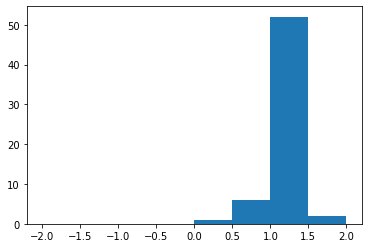

time: 262 ms


In [40]:
dist_df2 = pd.DataFrame()
dist_df2['inprox'] = inprox

dist_df2['not_inprox'] = not_in_prox
dist_df2['ratio'] = dist_df2['inprox'].apply(np.nanmean) / dist_df2['inprox'].apply(np.nanmedian)
%matplotlib inline
plt.hist(dist_df2['ratio'], bins=[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])

#### Cosine Distance ####

In [4]:
#### Event 1 ####

time: 74.4 ms


In [3]:
dist_df= pd.read_parquet("/data/event1_cosine.parquet.snappy")

time: 111 ms


In [19]:
start = "2018-06-04 08:00:00"
end = "2018-06-04 15:00:00"


data_acc_e1 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = cosine_distance_calc(data_acc_e1, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s")
inprox_1, not_in_prox_1 = cosine_distance_calc(data_acc_e1, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s")
inprox_2, not_in_prox_2 = cosine_distance_calc(data_acc_e1, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s")

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event1_cosine.parquet.snappy")

Data sufficient for devices :{9, 19, 24, 27, 29, 31, 38, 50, 51, 56, 59, 62, 63, 65, 71, 83, 85, 92, 95, 97, 101, 102, 117, 119, 125}
1/85
2/85
3/85
4/85
5/85
6/85
7/85
8/85
9/85
10/85
11/85
12/85
13/85
14/85
15/85
16/85
17/85
18/85
19/85
20/85
21/85
22/85
23/85
24/85
25/85
26/85
27/85
28/85
29/85
30/85
31/85
32/85
33/85
34/85
35/85
36/85
37/85
38/85
39/85
40/85
41/85
42/85
43/85
44/85
45/85
46/85
47/85
48/85
49/85
50/85
51/85
52/85
53/85
54/85
55/85
56/85
57/85
58/85
59/85
60/85
61/85
62/85
63/85
64/85
65/85
66/85
67/85
68/85
69/85
70/85
71/85
72/85
73/85
74/85
75/85
76/85
77/85
78/85
79/85
80/85
81/85
82/85
83/85
84/85
85/85
Data sufficient for devices :{9, 19, 24, 27, 29, 31, 38, 50, 51, 56, 59, 62, 63, 65, 71, 83, 85, 92, 95, 97, 101, 102, 117, 119, 125}
1/85
2/85
3/85
4/85
5/85
6/85
7/85
8/85
9/85
10/85
11/85
12/85
13/85
14/85
15/85
16/85
17/85
18/85
19/85
20/85
21/85
22/85
23/85
24/85
25/85
26/85
27/85
28/85
29/85
30/85
31/85
32/85
33/85
34/85
35/85
36/85
37/85
38/85
39/85
40/85


In [20]:
#### Event 2 ####

time: 307 µs


In [4]:
dist_df2= pd.read_parquet("/data/event2_cosine.parquet.snappy")

time: 7.54 ms


In [21]:
start = "2018-05-16 09:00:00"
end = "2018-05-16 15:00:00"

data_acc_e2 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = cosine_distance_calc(data_acc_e2, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s")
inprox_1, not_in_prox_1 = cosine_distance_calc(data_acc_e2, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s")
inprox_2, not_in_prox_2 = cosine_distance_calc(data_acc_e2, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s")

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event2_cosine.parquet.snappy")

Data sufficient for devices :{8, 9, 11, 12, 22, 32, 34, 41, 48, 50, 51, 57, 59, 63, 65, 68, 83, 84, 85, 92, 93, 94, 95, 99, 100, 108, 117, 121}
1/73
2/73
3/73
4/73
5/73
6/73
7/73
8/73
9/73
10/73
11/73
12/73
13/73
14/73
15/73
16/73
17/73
18/73
19/73
20/73
21/73
22/73
23/73
24/73
25/73
26/73
27/73
28/73
29/73
30/73
31/73
32/73
33/73
34/73
35/73
36/73
37/73
38/73
39/73
40/73
41/73
42/73
43/73
44/73
45/73
46/73
47/73
48/73
49/73
50/73
51/73
52/73
53/73
54/73
55/73
56/73
57/73
58/73
59/73
60/73
61/73
62/73
63/73
64/73
65/73
66/73
67/73
68/73
69/73
70/73
71/73
72/73
73/73
Data sufficient for devices :{8, 9, 11, 12, 22, 32, 34, 41, 48, 50, 51, 57, 59, 63, 65, 68, 83, 84, 85, 92, 93, 94, 95, 99, 100, 108, 117, 121}
1/73
2/73
3/73
4/73
5/73
6/73
7/73
8/73
9/73
10/73
11/73
12/73
13/73
14/73
15/73
16/73
17/73
18/73
19/73
20/73
21/73
22/73
23/73
24/73
25/73
26/73
27/73
28/73
29/73
30/73
31/73
32/73
33/73
34/73
35/73
36/73
37/73
38/73
39/73
40/73
41/73
42/73
43/73
44/73
45/73
46/73
47/73
48/73
49/7

In [22]:
#### Event 3 ####

time: 484 µs


In [5]:
dist_df3= pd.read_parquet("/data/event3_cosine.parquet.snappy")

time: 11.2 ms


In [23]:
start = "2018-05-30 09:00:00"
end = "2018-05-30 16:00:00"

data_acc_e3 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = cosine_distance_calc(data_acc_e3, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s")
inprox_1, not_in_prox_1 = cosine_distance_calc(data_acc_e3, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s")
inprox_2, not_in_prox_2 = cosine_distance_calc(data_acc_e3, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s")

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event3_cosine.parquet.snappy")

Data sufficient for devices :{3, 9, 10, 12, 15, 19, 24, 32, 38, 43, 50, 51, 59, 62, 63, 65, 71, 75, 83, 85, 92, 95, 97, 102, 117, 119, 125}
1/85
2/85
3/85
4/85
5/85
6/85
7/85
8/85
9/85
10/85
11/85
12/85
13/85
14/85
15/85
16/85
17/85
18/85
19/85
20/85
21/85
22/85
23/85
24/85
25/85
26/85
27/85
28/85
29/85
30/85
31/85
32/85
33/85
34/85
35/85
36/85
37/85
38/85
39/85
40/85
41/85
42/85
43/85
44/85
45/85
46/85
47/85
48/85
49/85
50/85
51/85
52/85
53/85
54/85
55/85
56/85
57/85
58/85
59/85
60/85
61/85
62/85
63/85
64/85
65/85
66/85
67/85
68/85
69/85
70/85
71/85
72/85
73/85
74/85
75/85
76/85
77/85
78/85
79/85
80/85
81/85
82/85
83/85
84/85
85/85
Data sufficient for devices :{3, 9, 10, 12, 15, 19, 24, 32, 38, 43, 50, 51, 59, 62, 63, 65, 71, 75, 83, 85, 92, 95, 97, 102, 117, 119, 125}
1/85
2/85
3/85
4/85
5/85
6/85
7/85
8/85
9/85
10/85
11/85
12/85
13/85
14/85
15/85
16/85
17/85
18/85
19/85
20/85
21/85
22/85
23/85
24/85
25/85
26/85
27/85
28/85
29/85
30/85
31/85
32/85
33/85
34/85
35/85
36/85
37/85
38/85


In [11]:
x = dist_df['inprox_0'].apply(np.nanmean)/dist_df['not_inprox_0'].apply(np.nanmean)

time: 33.4 ms


/u/home/oturkar/venv/lib/python3.6/site-packages/pandas/core/series.py:4042: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(values, f, convert=convert_dtype)


/u/home/oturkar/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/u/home/oturkar/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 3.,  0.,  4.,  7., 10.,  5.,  4.,  8.,  4.,  4.]),
 array([0.38940686, 0.50837995, 0.62735303, 0.74632612, 0.86529921,
        0.9842723 , 1.10324538, 1.22221847, 1.34119156, 1.46016465,
        1.57913774]),
 <a list of 10 Patch objects>)

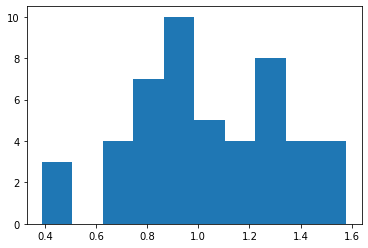

time: 257 ms


In [13]:
plt.hist(x)

In [14]:
dist_df

inprox_0                                       not_inprox_0  \
0                    []                                                 []   
1                    []  [0.27009435174170193, 0.38564964771282606, 0.3...   
2   [0.093680594604441]  [0.15277356534524977, 0.31744549620661866, 0.2...   
3                    []  [0.1254030607426777, 0.266950970274729, 0.1781...   
4                    []                                                 []   
..                  ...                                                ...   
80                   []  [0.13238923575328032, 0.3421364912014092, 0.09...   
81                   []  [0.1832091934792731, 0.34945245250810997, 0.04...   
82                   []  [0.6235253337241703, 0.7426417536576634, 0.427...   
83                   []  [0.6024043983123739, 0.7022059377219849, 0.433...   
84                   []  [0.27069216582515665, 0.1850503175926167, 0.12...   

                inprox_1                                       not_inprox_1  \
0                     []                                                 []   
1                     []  [0.3957395843944762, 0.46563383461379027, 0.24...   
2   [0.1854943011582202]  [0.1860744188519089, 0.35289612983555785, 0.12...   
3                     []  [0.17132150856737105, 0.2887520124182593, 0.11...   
4                     []                                                 []   
..                   ...                                                ...   
80                    []  [0.31627421946533896, 0.25403234808980524, 0.3...   
81                    []  [0.25338015579891593, 0.19925852082547502, 0.1...   
82                    []  [0.11793810175578068, 0.05495015201572184, 0.2...   
83                    []  [0.17061096766060713, 0.05554083619222072, 0.2...   
84                    []  [0.21963289706504108, 0.16350022890342708, 0.5...   

                inprox_2                                       not_inprox_2  
0                     []                                                 []  
1                     []  [0.2591683280886441, 0.19214585340688217, 0.43...  
2   [0.2696615458486884]  [0.2811909025394189, 0.2328071396339998, 0.362...  
3                     []  [0.26557088432582565, 0.1980872358626392, 0.23...  
4                     []                                                 []  
..                   ...                                                ...  
80                    []  [0.1447720622797003, 0.6700549608328263, 0.125...  
81                    []  [0.11765382467443619, 0.6706520445076436, 0.08...  
82                    []  [0.6248477432623134, 0.8919266679453456, 0.286...  
83                    []  [0.661233662198611, 0.891938227342919, 0.39218...  
84                    []  [0.5843746908305458, 0.565679984285882, 0.4812...  

[85 rows x 6 columns]

time: 59.4 ms


In [16]:
wifi_filtered 

NameError: name 'wifi_filtered' is not defined

time: 184 ms


In [50]:
start = "2018-06-04 08:00:00"
end = "2018-06-04 15:00:00"

scatter_df_prox = pd.DataFrame()
scatter_df_prox['var_0'] = dist_df['inprox_0'].apply(np.nanvar)
scatter_df_prox['cosine_0'] = dist_df['inprox_0'].apply(np.nanmean)
scatter_df_prox['var_1'] = dist_df['inprox_1'].apply(np.nanvar)
scatter_df_prox['cosine_1'] = dist_df['inprox_1'].apply(np.nanmean)
scatter_df_prox['var_2'] = dist_df['inprox_2'].apply(np.nanvar)
scatter_df_prox['cosine_2'] = dist_df['inprox_2'].apply(np.nanmean)

scatter_df_np = pd.DataFrame()
scatter_df_np['var_0'] = dist_df['not_inprox_0'].apply(np.nanvar)
scatter_df_np['cosine_0'] = dist_df['not_inprox_0'].apply(np.nanmedian)
scatter_df_np['var_1'] = dist_df['not_inprox_1'].apply(np.nanvar)
scatter_df_np['cosine_1'] = dist_df['not_inprox_1'].apply(np.nanmedian)
scatter_df_np['var_2'] = dist_df['not_inprox_2'].apply(np.nanvar)
scatter_df_np['cosine_2'] = dist_df['not_inprox_2'].apply(np.nanmedian)

time: 161 ms


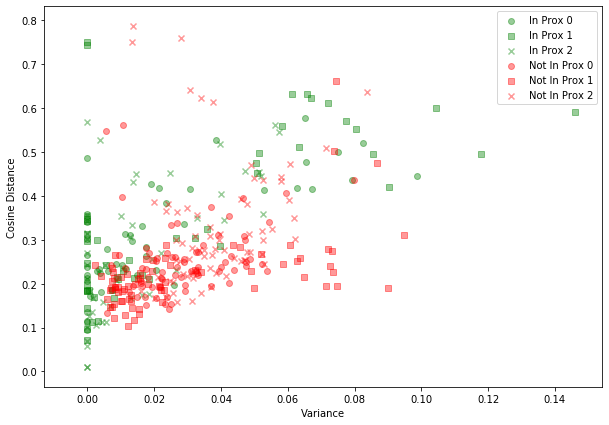

time: 425 ms


In [51]:
plt.figure(figsize=(10,7))
plt.xlabel("Variance")
plt.ylabel("Cosine Distance")
plt.scatter(scatter_df_prox['var_0'],scatter_df_prox['cosine_0'],color="green", alpha = 0.4, label="In Prox 0")
plt.scatter(scatter_df_prox['var_1'],scatter_df_prox['cosine_1'],color="green", alpha = 0.4, label="In Prox 1", marker="s")
plt.scatter(scatter_df_prox['var_2'],scatter_df_prox['cosine_2'],color="green", alpha = 0.4, label="In Prox 2",marker="x")



plt.scatter(scatter_df_np['var_0'],scatter_df_np['cosine_0'], color="red", alpha = 0.4,label="Not In Prox 0")
plt.scatter(scatter_df_np['var_1'],scatter_df_np['cosine_1'], color="red", alpha = 0.4,label="Not In Prox 1", marker="s")
plt.scatter(scatter_df_np['var_2'],scatter_df_np['cosine_2'], color="red", alpha = 0.4,label="Not In Prox 2", marker="x")
plt.legend()

In [52]:
start = "2018-05-16 09:00:00"
end = "2018-05-16 15:00:00"

scatter_df_prox = pd.DataFrame()
scatter_df_prox['var_0'] = dist_df2['inprox_0'].apply(np.nanvar)
scatter_df_prox['cosine_0'] = dist_df2['inprox_0'].apply(np.nanmean)
scatter_df_prox['var_1'] = dist_df2['inprox_1'].apply(np.nanvar)
scatter_df_prox['cosine_1'] = dist_df2['inprox_1'].apply(np.nanmean)
scatter_df_prox['var_2'] = dist_df2['inprox_2'].apply(np.nanvar)
scatter_df_prox['cosine_2'] = dist_df2['inprox_2'].apply(np.nanmean)

scatter_df_np = pd.DataFrame()
scatter_df_np['var_0'] = dist_df2['not_inprox_0'].apply(np.nanvar)
scatter_df_np['cosine_0'] = dist_df2['not_inprox_0'].apply(np.nanmedian)
scatter_df_np['var_1'] = dist_df2['not_inprox_1'].apply(np.nanvar)
scatter_df_np['cosine_1'] = dist_df2['not_inprox_1'].apply(np.nanmedian)
scatter_df_np['var_2'] = dist_df2['not_inprox_2'].apply(np.nanvar)
scatter_df_np['cosine_2'] = dist_df2['not_inprox_2'].apply(np.nanmedian)

time: 146 ms


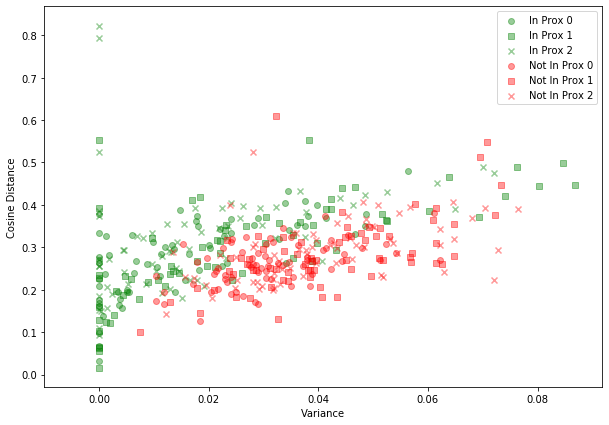

time: 414 ms


In [53]:
plt.figure(figsize=(10,7))
plt.xlabel("Variance")
plt.ylabel("Cosine Distance")
plt.scatter(scatter_df_prox['var_0'],scatter_df_prox['cosine_0'],color="green", alpha = 0.4, label="In Prox 0")
plt.scatter(scatter_df_prox['var_1'],scatter_df_prox['cosine_1'],color="green", alpha = 0.4, label="In Prox 1", marker="s")
plt.scatter(scatter_df_prox['var_2'],scatter_df_prox['cosine_2'],color="green", alpha = 0.4, label="In Prox 2",marker="x")



plt.scatter(scatter_df_np['var_0'],scatter_df_np['cosine_0'], color="red", alpha = 0.4,label="Not In Prox 0")
plt.scatter(scatter_df_np['var_1'],scatter_df_np['cosine_1'], color="red", alpha = 0.4,label="Not In Prox 1", marker="s")
plt.scatter(scatter_df_np['var_2'],scatter_df_np['cosine_2'], color="red", alpha = 0.4,label="Not In Prox 2", marker="x")
plt.legend()

In [54]:
start = "2018-05-30 09:00:00"
end = "2018-05-30 16:00:00"

scatter_df_prox = pd.DataFrame()
scatter_df_prox['var_0'] = dist_df3['inprox_0'].apply(np.nanvar)
scatter_df_prox['cosine_0'] = dist_df3['inprox_0'].apply(np.nanmean)
scatter_df_prox['var_1'] = dist_df3['inprox_1'].apply(np.nanvar)
scatter_df_prox['cosine_1'] = dist_df3['inprox_1'].apply(np.nanmean)
scatter_df_prox['var_2'] = dist_df3['inprox_2'].apply(np.nanvar)
scatter_df_prox['cosine_2'] = dist_df3['inprox_2'].apply(np.nanmean)

scatter_df_np = pd.DataFrame()
scatter_df_np['var_0'] = dist_df3['not_inprox_0'].apply(np.nanvar)
scatter_df_np['cosine_0'] = dist_df3['not_inprox_0'].apply(np.nanmedian)
scatter_df_np['var_1'] = dist_df3['not_inprox_1'].apply(np.nanvar)
scatter_df_np['cosine_1'] = dist_df3['not_inprox_1'].apply(np.nanmedian)
scatter_df_np['var_2'] = dist_df3['not_inprox_2'].apply(np.nanvar)
scatter_df_np['cosine_2'] = dist_df3['not_inprox_2'].apply(np.nanmedian)

time: 156 ms


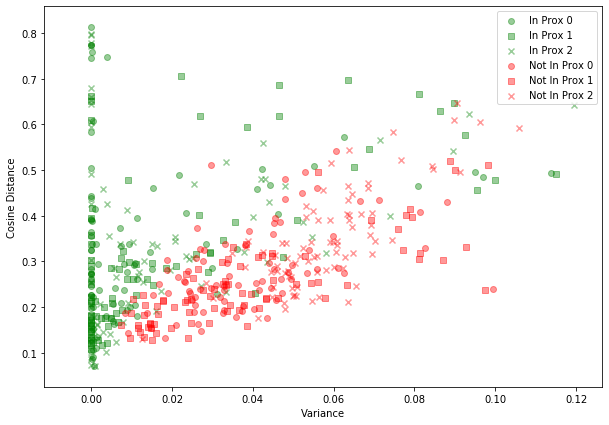

time: 437 ms


In [55]:
plt.figure(figsize=(10,7))
plt.xlabel("Variance")
plt.ylabel("Cosine Distance")
plt.scatter(scatter_df_prox['var_0'],scatter_df_prox['cosine_0'],color="green", alpha = 0.4, label="In Prox 0")
plt.scatter(scatter_df_prox['var_1'],scatter_df_prox['cosine_1'],color="green", alpha = 0.4, label="In Prox 1", marker="s")
plt.scatter(scatter_df_prox['var_2'],scatter_df_prox['cosine_2'],color="green", alpha = 0.4, label="In Prox 2",marker="x")



plt.scatter(scatter_df_np['var_0'],scatter_df_np['cosine_0'], color="red", alpha = 0.4,label="Not In Prox 0")
plt.scatter(scatter_df_np['var_1'],scatter_df_np['cosine_1'], color="red", alpha = 0.4,label="Not In Prox 1", marker="s")
plt.scatter(scatter_df_np['var_2'],scatter_df_np['cosine_2'], color="red", alpha = 0.4,label="Not In Prox 2", marker="x")
plt.legend()

#### Cosine + DTW mean values####

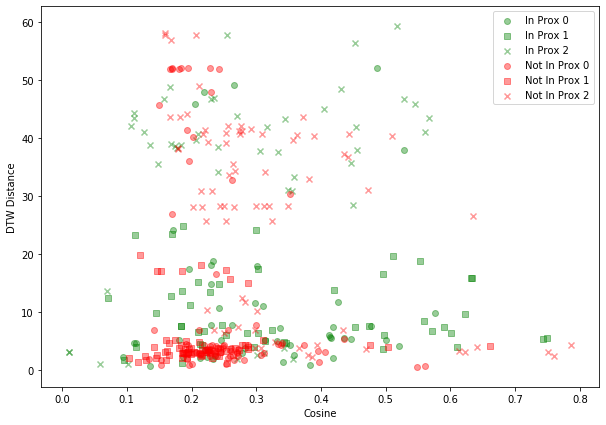

time: 501 ms


In [65]:
start = "2018-06-04 08:00:00"
end = "2018-06-04 15:00:00"

scatter_df_prox = pd.DataFrame()
scatter_df_prox['cosine_0'] = dist_df['inprox_0'].apply(np.nanmean)
scatter_df_prox['distance_0'] = event1['inprox_0'].apply(np.nanmean)
scatter_df_prox['cosine_1'] = dist_df['inprox_1'].apply(np.nanmean)
scatter_df_prox['distance_1'] = event1['inprox_1'].apply(np.nanmean)
scatter_df_prox['cosine_2'] = dist_df['inprox_2'].apply(np.nanmean)
scatter_df_prox['distance_2'] = event1['inprox_2'].apply(np.nanmean)

scatter_df_np = pd.DataFrame()
scatter_df_np['cosine_0'] = dist_df['not_inprox_0'].apply(np.nanmedian)
scatter_df_np['distance_0'] = event1['not_inprox_0'].apply(np.nanmedian)
scatter_df_np['cosine_1'] = dist_df['not_inprox_1'].apply(np.nanmedian)
scatter_df_np['distance_1'] = event1['not_inprox_1'].apply(np.nanmedian)
scatter_df_np['cosine_2'] = dist_df['not_inprox_2'].apply(np.nanmedian)
scatter_df_np['distance_2'] = event1['not_inprox_2'].apply(np.nanmedian)

plt.figure(figsize=(10,7))
plt.xlabel("Cosine")
plt.ylabel("DTW Distance")
plt.scatter(scatter_df_prox['cosine_0'],scatter_df_prox['distance_0'],color="green", alpha = 0.4, label="In Prox 0")
plt.scatter(scatter_df_prox['cosine_1'],scatter_df_prox['distance_1'],color="green", alpha = 0.4, label="In Prox 1", marker="s")
plt.scatter(scatter_df_prox['cosine_2'],scatter_df_prox['distance_2'],color="green", alpha = 0.4, label="In Prox 2",marker="x")



plt.scatter(scatter_df_np['cosine_0'],scatter_df_np['distance_0'], color="red", alpha = 0.4,label="Not In Prox 0")
plt.scatter(scatter_df_np['cosine_1'],scatter_df_np['distance_1'], color="red", alpha = 0.4,label="Not In Prox 1", marker="s")
plt.scatter(scatter_df_np['cosine_2'],scatter_df_np['distance_2'], color="red", alpha = 0.4,label="Not In Prox 2", marker="x")
plt.legend()

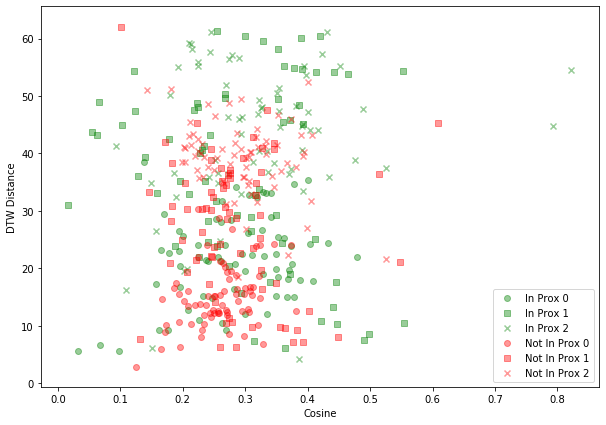

time: 509 ms


In [66]:
start = "2018-05-16 09:00:00"
end = "2018-05-16 15:00:00"

scatter_df_prox = pd.DataFrame()
scatter_df_prox['cosine_0'] = dist_df2['inprox_0'].apply(np.nanmean)
scatter_df_prox['distance_0'] = event2['inprox_0'].apply(np.nanmean)
scatter_df_prox['cosine_1'] = dist_df2['inprox_1'].apply(np.nanmean)
scatter_df_prox['distance_1'] = event2['inprox_1'].apply(np.nanmean)
scatter_df_prox['cosine_2'] = dist_df2['inprox_2'].apply(np.nanmean)
scatter_df_prox['distance_2'] = event2['inprox_2'].apply(np.nanmean)

scatter_df_np = pd.DataFrame()
scatter_df_np['cosine_0'] = dist_df2['not_inprox_0'].apply(np.nanmedian)
scatter_df_np['distance_0'] = event2['not_inprox_0'].apply(np.nanmedian)
scatter_df_np['cosine_1'] = dist_df2['not_inprox_1'].apply(np.nanmedian)
scatter_df_np['distance_1'] = event2['not_inprox_1'].apply(np.nanmedian)
scatter_df_np['cosine_2'] = dist_df2['not_inprox_2'].apply(np.nanmedian)
scatter_df_np['distance_2'] = event2['not_inprox_2'].apply(np.nanmedian)

plt.figure(figsize=(10,7))
plt.xlabel("Cosine")
plt.ylabel("DTW Distance")
plt.scatter(scatter_df_prox['cosine_0'],scatter_df_prox['distance_0'],color="green", alpha = 0.4, label="In Prox 0")
plt.scatter(scatter_df_prox['cosine_1'],scatter_df_prox['distance_1'],color="green", alpha = 0.4, label="In Prox 1", marker="s")
plt.scatter(scatter_df_prox['cosine_2'],scatter_df_prox['distance_2'],color="green", alpha = 0.4, label="In Prox 2",marker="x")



plt.scatter(scatter_df_np['cosine_0'],scatter_df_np['distance_0'], color="red", alpha = 0.4,label="Not In Prox 0")
plt.scatter(scatter_df_np['cosine_1'],scatter_df_np['distance_1'], color="red", alpha = 0.4,label="Not In Prox 1", marker="s")
plt.scatter(scatter_df_np['cosine_2'],scatter_df_np['distance_2'], color="red", alpha = 0.4,label="Not In Prox 2", marker="x")
plt.legend()

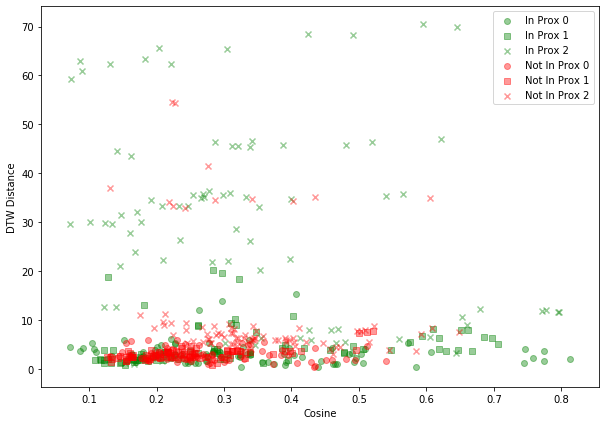

time: 496 ms


In [67]:
start = "2018-05-30 09:00:00"
end = "2018-05-30 16:00:00"

scatter_df_prox = pd.DataFrame()
scatter_df_prox['cosine_0'] = dist_df3['inprox_0'].apply(np.nanmean)
scatter_df_prox['distance_0'] = event3['inprox_0'].apply(np.nanmean)
scatter_df_prox['cosine_1'] = dist_df3['inprox_1'].apply(np.nanmean)
scatter_df_prox['distance_1'] = event3['inprox_1'].apply(np.nanmean)
scatter_df_prox['cosine_2'] = dist_df3['inprox_2'].apply(np.nanmean)
scatter_df_prox['distance_2'] = event3['inprox_2'].apply(np.nanmean)

scatter_df_np = pd.DataFrame()
scatter_df_np['cosine_0'] = dist_df3['not_inprox_0'].apply(np.nanmedian)
scatter_df_np['distance_0'] = event3['not_inprox_0'].apply(np.nanmedian)
scatter_df_np['cosine_1'] = dist_df3['not_inprox_1'].apply(np.nanmedian)
scatter_df_np['distance_1'] = event3['not_inprox_1'].apply(np.nanmedian)
scatter_df_np['cosine_2'] = dist_df3['not_inprox_2'].apply(np.nanmedian)
scatter_df_np['distance_2'] = event3['not_inprox_2'].apply(np.nanmedian)

plt.figure(figsize=(10,7))
plt.xlabel("Cosine")
plt.ylabel("DTW Distance")
plt.scatter(scatter_df_prox['cosine_0'],scatter_df_prox['distance_0'],color="green", alpha = 0.4, label="In Prox 0")
plt.scatter(scatter_df_prox['cosine_1'],scatter_df_prox['distance_1'],color="green", alpha = 0.4, label="In Prox 1", marker="s")
plt.scatter(scatter_df_prox['cosine_2'],scatter_df_prox['distance_2'],color="green", alpha = 0.4, label="In Prox 2",marker="x")



plt.scatter(scatter_df_np['cosine_0'],scatter_df_np['distance_0'], color="red", alpha = 0.4,label="Not In Prox 0")
plt.scatter(scatter_df_np['cosine_1'],scatter_df_np['distance_1'], color="red", alpha = 0.4,label="Not In Prox 1", marker="s")
plt.scatter(scatter_df_np['cosine_2'],scatter_df_np['distance_2'], color="red", alpha = 0.4,label="Not In Prox 2", marker="x")
plt.legend()

#### Cosine + DTW variance ####

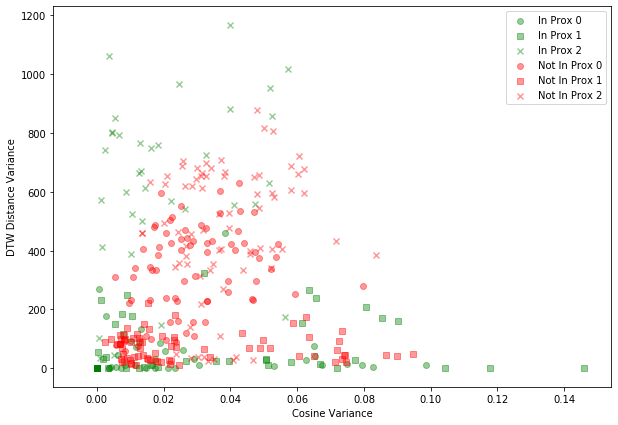

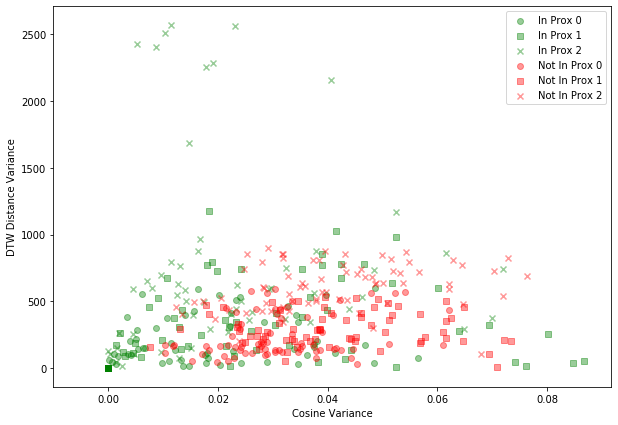

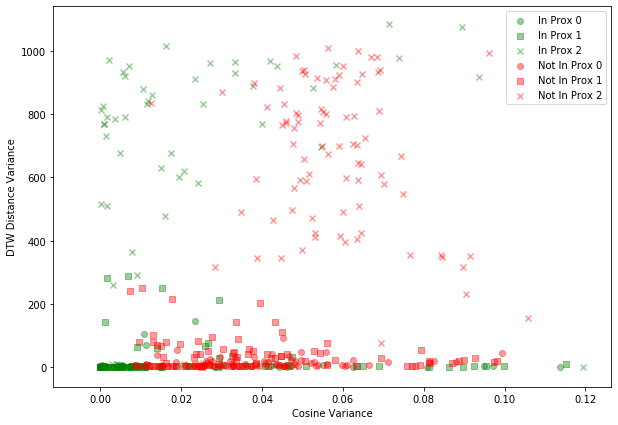

time: 1.47 s


In [69]:
start = "2018-06-04 08:00:00"
end = "2018-06-04 15:00:00"

scatter_df_prox = pd.DataFrame()
scatter_df_prox['cosine_var_0'] = dist_df['inprox_0'].apply(np.nanvar)
scatter_df_prox['distance_var_0'] = event1['inprox_0'].apply(np.nanvar)
scatter_df_prox['cosine_var_1'] = dist_df['inprox_1'].apply(np.nanvar)
scatter_df_prox['distance_var_1'] = event1['inprox_1'].apply(np.nanvar)
scatter_df_prox['cosine_var_2'] = dist_df['inprox_2'].apply(np.nanvar)
scatter_df_prox['distance_var_2'] = event1['inprox_2'].apply(np.nanvar)

scatter_df_np = pd.DataFrame()
scatter_df_np['cosine_var_0'] = dist_df['not_inprox_0'].apply(np.nanvar)
scatter_df_np['distance_var_0'] = event1['not_inprox_0'].apply(np.nanvar)
scatter_df_np['cosine_var_1'] = dist_df['not_inprox_1'].apply(np.nanvar)
scatter_df_np['distance_var_1'] = event1['not_inprox_1'].apply(np.nanvar)
scatter_df_np['cosine_var_2'] = dist_df['not_inprox_2'].apply(np.nanvar)
scatter_df_np['distance_var_2'] = event1['not_inprox_2'].apply(np.nanvar)

plt.figure(figsize=(10,7))
plt.xlabel("Cosine Variance")
plt.ylabel("DTW Distance Variance")
plt.scatter(scatter_df_prox['cosine_var_0'],scatter_df_prox['distance_var_0'],color="green", alpha = 0.4, label="In Prox 0")
plt.scatter(scatter_df_prox['cosine_var_1'],scatter_df_prox['distance_var_1'],color="green", alpha = 0.4, label="In Prox 1", marker="s")
plt.scatter(scatter_df_prox['cosine_var_2'],scatter_df_prox['distance_var_2'],color="green", alpha = 0.4, label="In Prox 2",marker="x")



plt.scatter(scatter_df_np['cosine_var_0'],scatter_df_np['distance_var_0'], color="red", alpha = 0.4,label="Not In Prox 0")
plt.scatter(scatter_df_np['cosine_var_1'],scatter_df_np['distance_var_1'], color="red", alpha = 0.4,label="Not In Prox 1", marker="s")
plt.scatter(scatter_df_np['cosine_var_2'],scatter_df_np['distance_var_2'], color="red", alpha = 0.4,label="Not In Prox 2", marker="x")
plt.legend()

start = "2018-05-16 09:00:00"
end = "2018-05-16 15:00:00"

scatter_df_prox = pd.DataFrame()
scatter_df_prox['cosine_var_0'] = dist_df2['inprox_0'].apply(np.nanvar)
scatter_df_prox['distance_var_0'] = event2['inprox_0'].apply(np.nanvar)
scatter_df_prox['cosine_var_1'] = dist_df2['inprox_1'].apply(np.nanvar)
scatter_df_prox['distance_var_1'] = event2['inprox_1'].apply(np.nanvar)
scatter_df_prox['cosine_var_2'] = dist_df2['inprox_2'].apply(np.nanvar)
scatter_df_prox['distance_var_2'] = event2['inprox_2'].apply(np.nanvar)

scatter_df_np = pd.DataFrame()
scatter_df_np['cosine_var_0'] = dist_df2['not_inprox_0'].apply(np.nanvar)
scatter_df_np['distance_var_0'] = event2['not_inprox_0'].apply(np.nanvar)
scatter_df_np['cosine_var_1'] = dist_df2['not_inprox_1'].apply(np.nanvar)
scatter_df_np['distance_var_1'] = event2['not_inprox_1'].apply(np.nanvar)
scatter_df_np['cosine_var_2'] = dist_df2['not_inprox_2'].apply(np.nanvar)
scatter_df_np['distance_var_2'] = event2['not_inprox_2'].apply(np.nanvar)

plt.figure(figsize=(10,7))
plt.xlabel("Cosine Variance")
plt.ylabel("DTW Distance Variance")
plt.scatter(scatter_df_prox['cosine_var_0'],scatter_df_prox['distance_var_0'],color="green", alpha = 0.4, label="In Prox 0")
plt.scatter(scatter_df_prox['cosine_var_1'],scatter_df_prox['distance_var_1'],color="green", alpha = 0.4, label="In Prox 1", marker="s")
plt.scatter(scatter_df_prox['cosine_var_2'],scatter_df_prox['distance_var_2'],color="green", alpha = 0.4, label="In Prox 2",marker="x")



plt.scatter(scatter_df_np['cosine_var_0'],scatter_df_np['distance_var_0'], color="red", alpha = 0.4,label="Not In Prox 0")
plt.scatter(scatter_df_np['cosine_var_1'],scatter_df_np['distance_var_1'], color="red", alpha = 0.4,label="Not In Prox 1", marker="s")
plt.scatter(scatter_df_np['cosine_var_2'],scatter_df_np['distance_var_2'], color="red", alpha = 0.4,label="Not In Prox 2", marker="x")
plt.legend()

start = "2018-05-30 09:00:00"
end = "2018-05-30 16:00:00"

scatter_df_prox = pd.DataFrame()
scatter_df_prox['cosine_var_0'] = dist_df3['inprox_0'].apply(np.nanvar)
scatter_df_prox['distance_var_0'] = event3['inprox_0'].apply(np.nanvar)
scatter_df_prox['cosine_var_1'] = dist_df3['inprox_1'].apply(np.nanvar)
scatter_df_prox['distance_var_1'] = event3['inprox_1'].apply(np.nanvar)
scatter_df_prox['cosine_var_2'] = dist_df3['inprox_2'].apply(np.nanvar)
scatter_df_prox['distance_var_2'] = event3['inprox_2'].apply(np.nanvar)

scatter_df_np = pd.DataFrame()
scatter_df_np['cosine_var_0'] = dist_df3['not_inprox_0'].apply(np.nanvar)
scatter_df_np['distance_var_0'] = event3['not_inprox_0'].apply(np.nanvar)
scatter_df_np['cosine_var_1'] = dist_df3['not_inprox_1'].apply(np.nanvar)
scatter_df_np['distance_var_1'] = event3['not_inprox_1'].apply(np.nanvar)
scatter_df_np['cosine_var_2'] = dist_df3['not_inprox_2'].apply(np.nanvar)
scatter_df_np['distance_var_2'] = event3['not_inprox_2'].apply(np.nanvar)

plt.figure(figsize=(10,7))
plt.xlabel("Cosine Variance")
plt.ylabel("DTW Distance Variance")
plt.scatter(scatter_df_prox['cosine_var_0'],scatter_df_prox['distance_var_0'],color="green", alpha = 0.4, label="In Prox 0")
plt.scatter(scatter_df_prox['cosine_var_1'],scatter_df_prox['distance_var_1'],color="green", alpha = 0.4, label="In Prox 1", marker="s")
plt.scatter(scatter_df_prox['cosine_var_2'],scatter_df_prox['distance_var_2'],color="green", alpha = 0.4, label="In Prox 2",marker="x")



plt.scatter(scatter_df_np['cosine_var_0'],scatter_df_np['distance_var_0'], color="red", alpha = 0.4,label="Not In Prox 0")
plt.scatter(scatter_df_np['cosine_var_1'],scatter_df_np['distance_var_1'], color="red", alpha = 0.4,label="Not In Prox 1", marker="s")
plt.scatter(scatter_df_np['cosine_var_2'],scatter_df_np['distance_var_2'], color="red", alpha = 0.4,label="Not In Prox 2", marker="x")
plt.legend()

#### Cosine Variance plus mean distance####

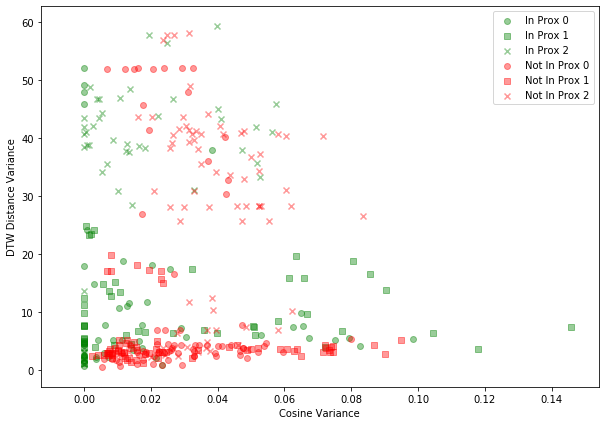

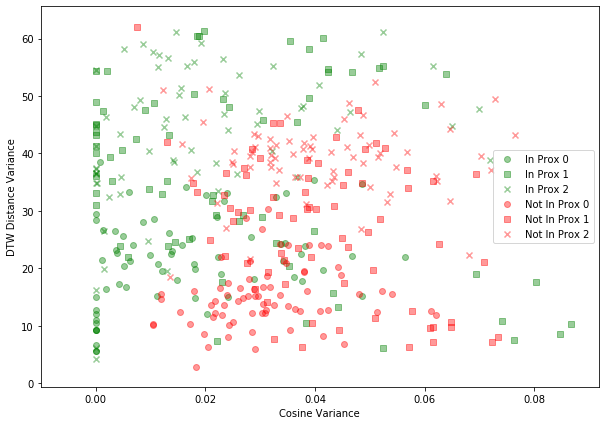

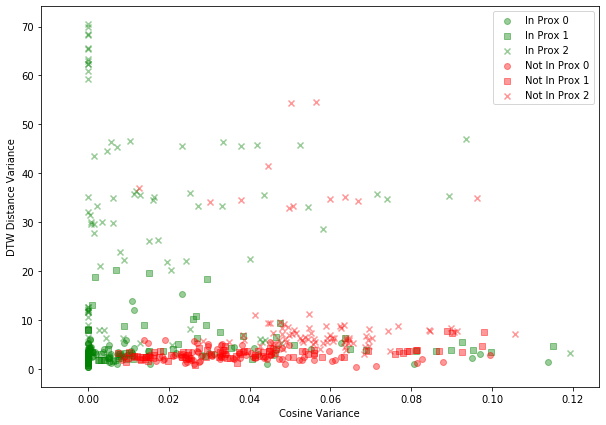

time: 1.58 s


In [70]:
start = "2018-06-04 08:00:00"
end = "2018-06-04 15:00:00"

scatter_df_prox = pd.DataFrame()
scatter_df_prox['cosine_var_0'] = dist_df['inprox_0'].apply(np.nanvar)
scatter_df_prox['distance_0'] = event1['inprox_0'].apply(np.nanmean)
scatter_df_prox['cosine_var_1'] = dist_df['inprox_1'].apply(np.nanvar)
scatter_df_prox['distance_1'] = event1['inprox_1'].apply(np.nanmean)
scatter_df_prox['cosine_var_2'] = dist_df['inprox_2'].apply(np.nanvar)
scatter_df_prox['distance_2'] = event1['inprox_2'].apply(np.nanmean)

scatter_df_np = pd.DataFrame()
scatter_df_np['cosine_var_0'] = dist_df['not_inprox_0'].apply(np.nanvar)
scatter_df_np['distance_0'] = event1['not_inprox_0'].apply(np.nanmedian)
scatter_df_np['cosine_var_1'] = dist_df['not_inprox_1'].apply(np.nanvar)
scatter_df_np['distance_1'] = event1['not_inprox_1'].apply(np.nanmedian)
scatter_df_np['cosine_var_2'] = dist_df['not_inprox_2'].apply(np.nanvar)
scatter_df_np['distance_2'] = event1['not_inprox_2'].apply(np.nanmedian)

plt.figure(figsize=(10,7))
plt.xlabel("Cosine Variance")
plt.ylabel("DTW Distance Variance")
plt.scatter(scatter_df_prox['cosine_var_0'],scatter_df_prox['distance_0'],color="green", alpha = 0.4, label="In Prox 0")
plt.scatter(scatter_df_prox['cosine_var_1'],scatter_df_prox['distance_1'],color="green", alpha = 0.4, label="In Prox 1", marker="s")
plt.scatter(scatter_df_prox['cosine_var_2'],scatter_df_prox['distance_2'],color="green", alpha = 0.4, label="In Prox 2",marker="x")



plt.scatter(scatter_df_np['cosine_var_0'],scatter_df_np['distance_0'], color="red", alpha = 0.4,label="Not In Prox 0")
plt.scatter(scatter_df_np['cosine_var_1'],scatter_df_np['distance_1'], color="red", alpha = 0.4,label="Not In Prox 1", marker="s")
plt.scatter(scatter_df_np['cosine_var_2'],scatter_df_np['distance_2'], color="red", alpha = 0.4,label="Not In Prox 2", marker="x")
plt.legend()

start = "2018-05-16 09:00:00"
end = "2018-05-16 15:00:00"

scatter_df_prox = pd.DataFrame()
scatter_df_prox['cosine_var_0'] = dist_df2['inprox_0'].apply(np.nanvar)
scatter_df_prox['distance_0'] = event2['inprox_0'].apply(np.nanmean)
scatter_df_prox['cosine_var_1'] = dist_df2['inprox_1'].apply(np.nanvar)
scatter_df_prox['distance_1'] = event2['inprox_1'].apply(np.nanmean)
scatter_df_prox['cosine_var_2'] = dist_df2['inprox_2'].apply(np.nanvar)
scatter_df_prox['distance_2'] = event2['inprox_2'].apply(np.nanmean)

scatter_df_np = pd.DataFrame()
scatter_df_np['cosine_var_0'] = dist_df2['not_inprox_0'].apply(np.nanvar)
scatter_df_np['distance_0'] = event2['not_inprox_0'].apply(np.nanmedian)
scatter_df_np['cosine_var_1'] = dist_df2['not_inprox_1'].apply(np.nanvar)
scatter_df_np['distance_1'] = event2['not_inprox_1'].apply(np.nanmedian)
scatter_df_np['cosine_var_2'] = dist_df2['not_inprox_2'].apply(np.nanvar)
scatter_df_np['distance_2'] = event2['not_inprox_2'].apply(np.nanmedian)

plt.figure(figsize=(10,7))
plt.xlabel("Cosine Variance")
plt.ylabel("DTW Distance Variance")
plt.scatter(scatter_df_prox['cosine_var_0'],scatter_df_prox['distance_0'],color="green", alpha = 0.4, label="In Prox 0")
plt.scatter(scatter_df_prox['cosine_var_1'],scatter_df_prox['distance_1'],color="green", alpha = 0.4, label="In Prox 1", marker="s")
plt.scatter(scatter_df_prox['cosine_var_2'],scatter_df_prox['distance_2'],color="green", alpha = 0.4, label="In Prox 2",marker="x")



plt.scatter(scatter_df_np['cosine_var_0'],scatter_df_np['distance_0'], color="red", alpha = 0.4,label="Not In Prox 0")
plt.scatter(scatter_df_np['cosine_var_1'],scatter_df_np['distance_1'], color="red", alpha = 0.4,label="Not In Prox 1", marker="s")
plt.scatter(scatter_df_np['cosine_var_2'],scatter_df_np['distance_2'], color="red", alpha = 0.4,label="Not In Prox 2", marker="x")
plt.legend()

start = "2018-05-30 09:00:00"
end = "2018-05-30 16:00:00"

scatter_df_prox = pd.DataFrame()
scatter_df_prox['cosine_var_0'] = dist_df3['inprox_0'].apply(np.nanvar)
scatter_df_prox['distance_0'] = event3['inprox_0'].apply(np.nanmean)
scatter_df_prox['cosine_var_1'] = dist_df3['inprox_1'].apply(np.nanvar)
scatter_df_prox['distance_1'] = event3['inprox_1'].apply(np.nanmean)
scatter_df_prox['cosine_var_2'] = dist_df3['inprox_2'].apply(np.nanvar)
scatter_df_prox['distance_2'] = event3['inprox_2'].apply(np.nanmean)

scatter_df_np = pd.DataFrame()
scatter_df_np['cosine_var_0'] = dist_df3['not_inprox_0'].apply(np.nanvar)
scatter_df_np['distance_0'] = event3['not_inprox_0'].apply(np.nanmedian)
scatter_df_np['cosine_var_1'] = dist_df3['not_inprox_1'].apply(np.nanvar)
scatter_df_np['distance_1'] = event3['not_inprox_1'].apply(np.nanmedian)
scatter_df_np['cosine_var_2'] = dist_df3['not_inprox_2'].apply(np.nanvar)
scatter_df_np['distance_2'] = event3['not_inprox_2'].apply(np.nanmedian)

plt.figure(figsize=(10,7))
plt.xlabel("Cosine Variance")
plt.ylabel("DTW Distance Variance")
plt.scatter(scatter_df_prox['cosine_var_0'],scatter_df_prox['distance_0'],color="green", alpha = 0.4, label="In Prox 0")
plt.scatter(scatter_df_prox['cosine_var_1'],scatter_df_prox['distance_1'],color="green", alpha = 0.4, label="In Prox 1", marker="s")
plt.scatter(scatter_df_prox['cosine_var_2'],scatter_df_prox['distance_2'],color="green", alpha = 0.4, label="In Prox 2",marker="x")



plt.scatter(scatter_df_np['cosine_var_0'],scatter_df_np['distance_0'], color="red", alpha = 0.4,label="Not In Prox 0")
plt.scatter(scatter_df_np['cosine_var_1'],scatter_df_np['distance_1'], color="red", alpha = 0.4,label="Not In Prox 1", marker="s")
plt.scatter(scatter_df_np['cosine_var_2'],scatter_df_np['distance_2'], color="red", alpha = 0.4,label="Not In Prox 2", marker="x")
plt.legend()

#### Iphone6 wise Cosine ####

In [ ]:
iphone6_e1 = pd.read_parquet("/data/event1_cosine_iphone6.parquet.snappy")
iphone6_e2 = pd.read_parquet("/data/event2_cosine_iphone6.parquet.snappy")
iphone6_e3 = pd.read_parquet("/data/event3_cosine_iphone6.parquet.snappy")

In [ ]:
#### Event 1 ####

In [81]:
start = "2018-05-23 11:30:00"
end = "2018-05-23 15:00:00"


data_acc_e1 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end) & (data_acc['device_id'].isin(all_iphone6))]
inprox_0, not_in_prox_0 = cosine_distance_calc(data_acc_e1, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s", all_iphone6)
inprox_1, not_in_prox_1 = cosine_distance_calc(data_acc_e1, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s", all_iphone6)
inprox_2, not_in_prox_2 = cosine_distance_calc(data_acc_e1, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s", all_iphone6)

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event1_cosine_iphone6.parquet.snappy")

Data sufficient for devices :{71, 9, 15, 51, 83, 85, 117, 119}
1/43
2/43
3/43
4/43
5/43
6/43
7/43
8/43
9/43
10/43
11/43
12/43
13/43
14/43
15/43
16/43
17/43
18/43
19/43
20/43
21/43
22/43
23/43
24/43
25/43
26/43
27/43
28/43
29/43
30/43
31/43
32/43
33/43
34/43
35/43
36/43
37/43
38/43
39/43
40/43
41/43
42/43
43/43
Data sufficient for devices :{71, 9, 15, 51, 83, 85, 117, 119}
1/43
2/43
3/43
4/43
5/43
6/43
7/43
8/43
9/43
10/43
11/43
12/43
13/43
14/43
15/43
16/43
17/43
18/43
19/43
20/43
21/43
22/43
23/43
24/43
25/43
26/43
27/43
28/43
29/43
30/43
31/43
32/43
33/43
34/43
35/43
36/43
37/43
38/43
39/43
40/43
41/43
42/43
43/43
Data sufficient for devices :{71, 9, 15, 51, 83, 85, 117, 119}
1/43
2/43
3/43
4/43
5/43
6/43
7/43
8/43
9/43
10/43
11/43
12/43
13/43
14/43
15/43
16/43
17/43
18/43
19/43
20/43
21/43
22/43
23/43
24/43
25/43
26/43
27/43
28/43
29/43
30/43
31/43
32/43
33/43
34/43
35/43
36/43
37/43
38/43
39/43
40/43
41/43
42/43
43/43
time: 1min 13s


(array([5., 4., 5., 5., 4., 0., 3., 0., 0., 2.]),
 array([0.27176622, 0.52208846, 0.77241071, 1.02273295, 1.2730552 ,
        1.52337744, 1.77369969, 2.02402193, 2.27434418, 2.52466642,
        2.77498867]),
 <a list of 10 Patch objects>)

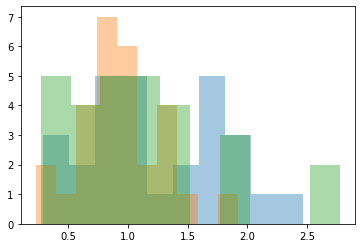

time: 316 ms


In [90]:
x = iphone6_e1['inprox_0'].apply(np.nanmean) / iphone6_e1['not_inprox_0'].apply(np.nanmedian)
plt.hist(x, alpha = 0.4)
x = iphone6_e1['inprox_1'].apply(np.nanmean) / iphone6_e1['not_inprox_1'].apply(np.nanmedian)
plt.hist(x, alpha = 0.4)
x = iphone6_e1['inprox_2'].apply(np.nanmean) / iphone6_e1['not_inprox_2'].apply(np.nanmedian)
plt.hist(x, alpha = 0.4)

In [ ]:
#### Event 2 ####

In [82]:
start = "2018-05-16 09:00:00"
end = "2018-05-16 15:00:00"

data_acc_e2 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = cosine_distance_calc(data_acc_e2, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s", all_iphone6)
inprox_1, not_in_prox_1 = cosine_distance_calc(data_acc_e2, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s", all_iphone6)
inprox_2, not_in_prox_2 = cosine_distance_calc(data_acc_e2, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s", all_iphone6)

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event2_cosine_iphone6.parquet.snappy")

Data sufficient for devices :{9, 51, 83, 85, 117}
1/73
2/73
3/73
4/73
5/73
6/73
7/73
8/73
9/73
10/73
11/73
12/73
13/73
14/73
15/73
16/73
17/73
18/73
19/73
20/73
21/73
22/73
23/73
24/73
25/73
26/73
27/73
28/73
29/73
30/73
31/73
32/73
33/73
34/73
35/73
36/73
37/73
38/73
39/73
40/73
41/73
42/73
43/73
44/73
45/73
46/73
47/73
48/73
49/73
50/73
51/73
52/73
53/73
54/73
55/73
56/73
57/73
58/73
59/73
60/73
61/73
62/73
63/73
64/73
65/73
66/73
67/73
68/73
69/73
70/73
71/73
72/73
73/73
Data sufficient for devices :{9, 51, 83, 85, 117}
1/73
2/73
3/73
4/73
5/73
6/73
7/73
8/73
9/73
10/73
11/73
12/73
13/73
14/73
15/73
16/73
17/73
18/73
19/73
20/73
21/73
22/73
23/73
24/73
25/73
26/73
27/73
28/73
29/73
30/73
31/73
32/73
33/73
34/73
35/73
36/73
37/73
38/73
39/73
40/73
41/73
42/73
43/73
44/73
45/73
46/73
47/73
48/73
49/73
50/73
51/73
52/73
53/73
54/73
55/73
56/73
57/73
58/73
59/73
60/73
61/73
62/73
63/73
64/73
65/73
66/73
67/73
68/73
69/73
70/73
71/73
72/73
73/73
Data sufficient for devices :{9, 51, 83, 8

(array([3., 1., 2., 1., 2., 3., 0., 0., 0., 1.]),
 array([0.31782056, 0.45287995, 0.58793935, 0.72299874, 0.85805813,
        0.99311752, 1.12817692, 1.26323631, 1.3982957 , 1.53335509,
        1.66841449]),
 <a list of 10 Patch objects>)

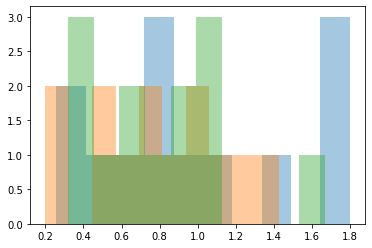

time: 320 ms


In [91]:
x = iphone6_e2['inprox_0'].apply(np.nanmean) / iphone6_e2['not_inprox_0'].apply(np.nanmedian)
plt.hist(x, alpha = 0.4)
x = iphone6_e2['inprox_1'].apply(np.nanmean) / iphone6_e2['not_inprox_1'].apply(np.nanmedian)
plt.hist(x, alpha = 0.4)
x = iphone6_e2['inprox_2'].apply(np.nanmean) / iphone6_e2['not_inprox_2'].apply(np.nanmedian)
plt.hist(x, alpha = 0.4)

In [83]:
#### Event 3 ####

time: 370 µs


In [84]:
start = "2018-05-30 09:00:00"
end = "2018-05-30 16:00:00"

data_acc_e3 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = cosine_distance_calc(data_acc_e3, start, end, wifi_proximity, 0.7, "double_values_0", 20, "30s", all_iphone6)
inprox_1, not_in_prox_1 = cosine_distance_calc(data_acc_e3, start, end, wifi_proximity, 0.7, "double_values_1", 20, "30s", all_iphone6)
inprox_2, not_in_prox_2 = cosine_distance_calc(data_acc_e3, start, end, wifi_proximity, 0.7, "double_values_2", 20, "30s", all_iphone6)

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event3_cosine_iphone6.parquet.snappy")

Data sufficient for devices :{71, 9, 15, 51, 83, 85, 117, 119}
1/85
2/85
3/85
4/85
5/85
6/85
7/85
8/85
9/85
10/85
11/85
12/85
13/85
14/85
15/85
16/85
17/85
18/85
19/85
20/85
21/85
22/85
23/85
24/85
25/85
26/85
27/85
28/85
29/85
30/85
31/85
32/85
33/85
34/85
35/85
36/85
37/85
38/85
39/85
40/85
41/85
42/85
43/85
44/85
45/85
46/85
47/85
48/85
49/85
50/85
51/85
52/85
53/85
54/85
55/85
56/85
57/85
58/85
59/85
60/85
61/85
62/85
63/85
64/85
65/85
66/85
67/85
68/85
69/85
70/85
71/85
72/85
73/85
74/85
75/85
76/85
77/85
78/85
79/85
80/85
81/85
82/85
83/85
84/85
85/85
Data sufficient for devices :{71, 9, 15, 51, 83, 85, 117, 119}
1/85
2/85
3/85
4/85
5/85
6/85
7/85
8/85
9/85
10/85
11/85
12/85
13/85
14/85
15/85
16/85
17/85
18/85
19/85
20/85
21/85
22/85
23/85
24/85
25/85
26/85
27/85
28/85
29/85
30/85
31/85
32/85
33/85
34/85
35/85
36/85
37/85
38/85
39/85
40/85
41/85
42/85
43/85
44/85
45/85
46/85
47/85
48/85
49/85
50/85
51/85
52/85
53/85
54/85
55/85
56/85
57/85
58/85
59/85
60/85
61/85
62/85
63/85
64/8

/u/home/oturkar/venv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


(array([4., 5., 6., 2., 1., 4., 0., 1., 2., 3.]),
 array([0.24290886, 0.32819081, 0.41347277, 0.49875473, 0.58403669,
        0.66931864, 0.7546006 , 0.83988256, 0.92516452, 1.01044647,
        1.09572843]),
 <a list of 10 Patch objects>)

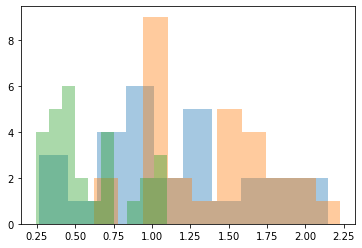

time: 335 ms


In [92]:
x = iphone6_e3['inprox_0'].apply(np.nanmean) / iphone6_e3['not_inprox_0'].apply(np.nanmedian)
plt.hist(x, alpha = 0.4)
x = iphone6_e3['inprox_1'].apply(np.nanmean) / iphone6_e3['not_inprox_1'].apply(np.nanmedian)
plt.hist(x, alpha = 0.4)
x = iphone6_e3['inprox_2'].apply(np.nanmean) / iphone6_e3['not_inprox_2'].apply(np.nanmedian)
plt.hist(x, alpha = 0.4)

In [96]:
dist_df1 = pd.read_parquet("/data/event1_dtw_iphone6.parquet.snappy")
dist_df2 = pd.read_parquet("/data/event2_dtw_iphone6.parquet.snappy")
dist_df3 = pd.read_parquet("/data/event3_dtw_iphone6.parquet.snappy")

time: 29.4 ms


(array([2., 1., 4., 7., 6., 2., 4., 1., 0., 1.]),
 array([0.23206472, 0.40116934, 0.57027395, 0.73937857, 0.90848319,
        1.0775878 , 1.24669242, 1.41579703, 1.58490165, 1.75400626,
        1.92311088]),
 <a list of 10 Patch objects>)

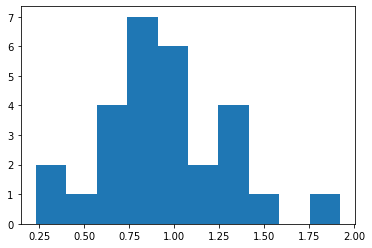

time: 256 ms


In [88]:
x = iphone6_e1['inprox_1'].apply(np.nanmean) / iphone6_e1['not_inprox_1'].apply(np.nanmedian)
plt.hist(x)

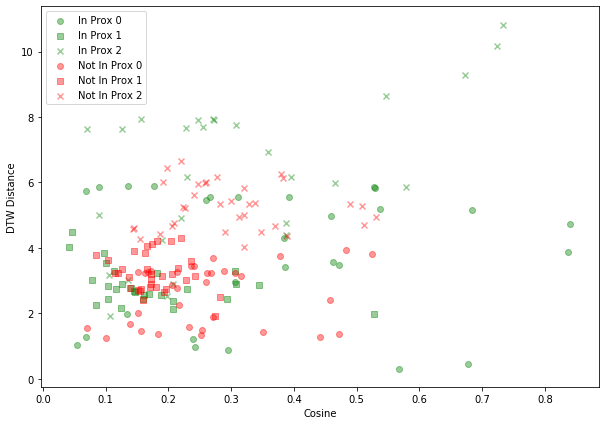

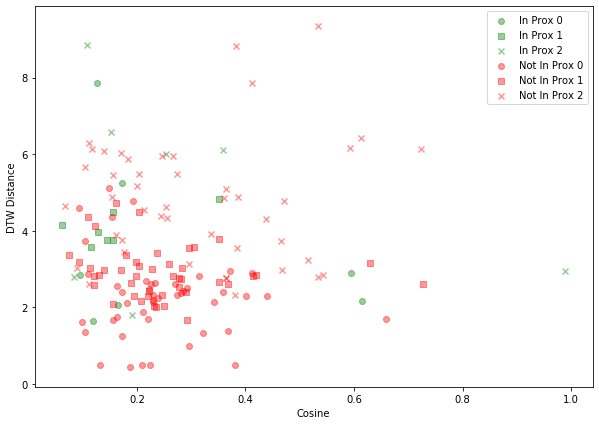

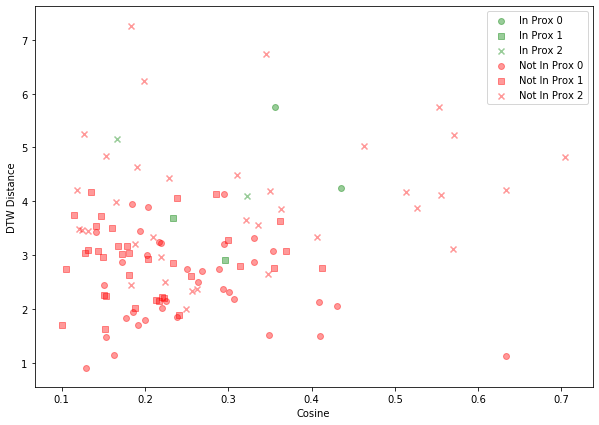

time: 1.57 s


In [97]:
start = "2018-05-23 11:30:00"
end = "2018-05-23 15:00:00"

scatter_df_prox = pd.DataFrame()
scatter_df_prox['cosine_0'] = iphone6_e1['inprox_0'].apply(np.nanmean)
scatter_df_prox['distance_0'] = dist_df1['inprox_0'].apply(np.nanmean)
scatter_df_prox['cosine_1'] = iphone6_e1['inprox_1'].apply(np.nanmean)
scatter_df_prox['distance_1'] = dist_df1['inprox_1'].apply(np.nanmean)
scatter_df_prox['cosine_2'] = iphone6_e1['inprox_2'].apply(np.nanmean)
scatter_df_prox['distance_2'] = dist_df1['inprox_2'].apply(np.nanmean)

scatter_df_np = pd.DataFrame()
scatter_df_np['cosine_0'] = iphone6_e1['not_inprox_0'].apply(np.nanmedian)
scatter_df_np['distance_0'] = dist_df1['not_inprox_0'].apply(np.nanmedian)
scatter_df_np['cosine_1'] = iphone6_e1['not_inprox_1'].apply(np.nanmedian)
scatter_df_np['distance_1'] = dist_df1['not_inprox_1'].apply(np.nanmedian)
scatter_df_np['cosine_2'] = iphone6_e1['not_inprox_2'].apply(np.nanmedian)
scatter_df_np['distance_2'] = dist_df1['not_inprox_2'].apply(np.nanmedian)

plt.figure(figsize=(10,7))
plt.xlabel("Cosine")
plt.ylabel("DTW Distance")
plt.scatter(scatter_df_prox['cosine_0'],scatter_df_prox['distance_0'],color="green", alpha = 0.4, label="In Prox 0")
plt.scatter(scatter_df_prox['cosine_1'],scatter_df_prox['distance_1'],color="green", alpha = 0.4, label="In Prox 1", marker="s")
plt.scatter(scatter_df_prox['cosine_2'],scatter_df_prox['distance_2'],color="green", alpha = 0.4, label="In Prox 2",marker="x")



plt.scatter(scatter_df_np['cosine_0'],scatter_df_np['distance_0'], color="red", alpha = 0.4,label="Not In Prox 0")
plt.scatter(scatter_df_np['cosine_1'],scatter_df_np['distance_1'], color="red", alpha = 0.4,label="Not In Prox 1", marker="s")
plt.scatter(scatter_df_np['cosine_2'],scatter_df_np['distance_2'], color="red", alpha = 0.4,label="Not In Prox 2", marker="x")
plt.legend()

start = "2018-05-16 09:00:00"
end = "2018-05-16 15:00:00"

scatter_df_prox = pd.DataFrame()
scatter_df_prox['cosine_0'] = iphone6_e2['inprox_0'].apply(np.nanmean)
scatter_df_prox['distance_0'] = dist_df2['inprox_0'].apply(np.nanmean)
scatter_df_prox['cosine_1'] = iphone6_e2['inprox_1'].apply(np.nanmean)
scatter_df_prox['distance_1'] = dist_df2['inprox_1'].apply(np.nanmean)
scatter_df_prox['cosine_2'] = iphone6_e2['inprox_2'].apply(np.nanmean)
scatter_df_prox['distance_2'] = dist_df2['inprox_2'].apply(np.nanmean)

scatter_df_np = pd.DataFrame()
scatter_df_np['cosine_0'] = iphone6_e2['not_inprox_0'].apply(np.nanmedian)
scatter_df_np['distance_0'] = dist_df2['not_inprox_0'].apply(np.nanmedian)
scatter_df_np['cosine_1'] = iphone6_e2['not_inprox_1'].apply(np.nanmedian)
scatter_df_np['distance_1'] = dist_df2['not_inprox_1'].apply(np.nanmedian)
scatter_df_np['cosine_2'] = iphone6_e2['not_inprox_2'].apply(np.nanmedian)
scatter_df_np['distance_2'] = dist_df2['not_inprox_2'].apply(np.nanmedian)

plt.figure(figsize=(10,7))
plt.xlabel("Cosine")
plt.ylabel("DTW Distance")
plt.scatter(scatter_df_prox['cosine_0'],scatter_df_prox['distance_0'],color="green", alpha = 0.4, label="In Prox 0")
plt.scatter(scatter_df_prox['cosine_1'],scatter_df_prox['distance_1'],color="green", alpha = 0.4, label="In Prox 1", marker="s")
plt.scatter(scatter_df_prox['cosine_2'],scatter_df_prox['distance_2'],color="green", alpha = 0.4, label="In Prox 2",marker="x")



plt.scatter(scatter_df_np['cosine_0'],scatter_df_np['distance_0'], color="red", alpha = 0.4,label="Not In Prox 0")
plt.scatter(scatter_df_np['cosine_1'],scatter_df_np['distance_1'], color="red", alpha = 0.4,label="Not In Prox 1", marker="s")
plt.scatter(scatter_df_np['cosine_2'],scatter_df_np['distance_2'], color="red", alpha = 0.4,label="Not In Prox 2", marker="x")
plt.legend()

start = "2018-05-30 09:00:00"
end = "2018-05-30 16:00:00"

scatter_df_prox = pd.DataFrame()
scatter_df_prox['cosine_0'] = iphone6_e3['inprox_0'].apply(np.nanmean)
scatter_df_prox['distance_0'] = dist_df3['inprox_0'].apply(np.nanmean)
scatter_df_prox['cosine_1'] = iphone6_e3['inprox_1'].apply(np.nanmean)
scatter_df_prox['distance_1'] = dist_df3['inprox_1'].apply(np.nanmean)
scatter_df_prox['cosine_2'] = iphone6_e3['inprox_2'].apply(np.nanmean)
scatter_df_prox['distance_2'] = dist_df3['inprox_2'].apply(np.nanmean)

scatter_df_np = pd.DataFrame()
scatter_df_np['cosine_0'] = iphone6_e3['not_inprox_0'].apply(np.nanmedian)
scatter_df_np['distance_0'] = dist_df3['not_inprox_0'].apply(np.nanmedian)
scatter_df_np['cosine_1'] = iphone6_e3['not_inprox_1'].apply(np.nanmedian)
scatter_df_np['distance_1'] = dist_df3['not_inprox_1'].apply(np.nanmedian)
scatter_df_np['cosine_2'] = iphone6_e3['not_inprox_2'].apply(np.nanmedian)
scatter_df_np['distance_2'] = dist_df3['not_inprox_2'].apply(np.nanmedian)

plt.figure(figsize=(10,7))
plt.xlabel("Cosine")
plt.ylabel("DTW Distance")
plt.scatter(scatter_df_prox['cosine_0'],scatter_df_prox['distance_0'],color="green", alpha = 0.4, label="In Prox 0")
plt.scatter(scatter_df_prox['cosine_1'],scatter_df_prox['distance_1'],color="green", alpha = 0.4, label="In Prox 1", marker="s")
plt.scatter(scatter_df_prox['cosine_2'],scatter_df_prox['distance_2'],color="green", alpha = 0.4, label="In Prox 2",marker="x")



plt.scatter(scatter_df_np['cosine_0'],scatter_df_np['distance_0'], color="red", alpha = 0.4,label="Not In Prox 0")
plt.scatter(scatter_df_np['cosine_1'],scatter_df_np['distance_1'], color="red", alpha = 0.4,label="Not In Prox 1", marker="s")
plt.scatter(scatter_df_np['cosine_2'],scatter_df_np['distance_2'], color="red", alpha = 0.4,label="Not In Prox 2", marker="x")
event3 = pd.read_parquet("/data/event3.parquet.snappy")
plt.legend()

In [ ]:
event1 = pd.read_parquet("/data/event1.parquet.snappy")
event2 = pd.read_parquet("/data/event2.parquet.snappy")
event3 = pd.read_parquet("/data/event3.parquet.snappy")


### Data Statistics ###

In [3]:
wifi_20m = pd.read_csv("/data/wifi_proximity_20-20m_captured.csv")


time: 16 ms


In [9]:
wifi_20m = pd.DataFrame(index = pd.date_range("2018-04-23 11:05:00","2018-08-15 00:20:00", freq="20min"))
wifi_20m['groups'] = wifi_proximity.set_index("timestamp")['groups']
wifi_20m.reset_index(inplace=True)
wifi_20m.rename(columns={"index": "timestamp"}, inplace = True)
wifi_20m.to_csv("/data/wifi_proximity_20-20m_captured.csv")


time: 75.7 ms


In [120]:
def valid_groups(event, ratio):
    #dist = list(event[col])
    groups = list(event['groups'])
    valid_grps = []
    #valid_dist = []
    
    for group_i in range(event['groups'].shape[0]):
        

        for group in groups[group_i]:
            valid = True
            for v_grp in valid_grps:
                
                c_ratio = len(group.intersection(v_grp)) / len(group)
                if c_ratio >= ratio:
                    valid = False
                    
            if valid:
                valid_grps.append(group)
     #           valid_dist.append(dist[group_i])
             
    return valid_grps

def valid_groups_dist(event, col, ratio, focus_on = None):
    return_dict = {}
    dist = list(event[col])
    groups = list(event['groups'])
    valid_grps = []
    valid_dist = []
    
    for group_i in range(event['groups'].shape[0]):
        
        
        for group in groups[group_i]:
            valid = True
            if focus_on is not None:
                group = group.intersection(set(focus_on))
            if len(group) > 0:
                for v_grp in valid_grps:

                    c_ratio = len(group.intersection(v_grp)) / len(group.union(v_grp))
                    if c_ratio >= ratio:
                        valid = False
                        save_to = v_grp
                if valid:
                    valid_grps.append(group)
                    return_dict[str(group)] = [list(dist[group_i])]
                if not valid:
                    return_dict[str(save_to)].append(list(dist[group_i]))
    df = pd.DataFrame()
    df['groups'] = return_dict.keys()
    df['dist'] = return_dict.values()
    return df

def fun_nanmean(num): 
    return_list = []
    for val in num:
        return_list.append(np.nanmean(val))
    return return_list

def fun_nanmedian(num): 
    return_list = []
    for val in num:
        return_list.append(np.nanmedian(val))
    return return_list

def fun_nanvar(num): 
    return_list = []
    for val in num:
        return_list.append(np.nanvar(val))
    return return_list

def flatten_list(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


time: 9.18 ms


In [75]:
all_grps = valid_groups(wifi_proximity, 0.8)

time: 471 ms


#### Average size of group ####

In [76]:
sum_devices = 0
for group in all_grps:
    sum_devices = sum_devices + len(group)
sum_devices/len(all_grps)

4.886567164179104

time: 5.26 ms


#### Deeper look #### 

In [79]:
size_dict = {}

time: 980 µs


In [82]:
for x in range(1,np.max([len(x) for x in all_grps]) + 1,1):
    size_dict[x] = 0

time: 10.6 ms


In [83]:
for x in all_grps:
    size_dict[len(x)] = size_dict[len(x)] + 1

time: 1.46 ms


<BarContainer object of 14 artists>

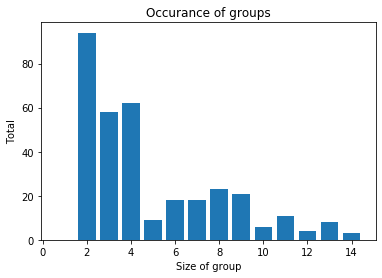

time: 344 ms


In [84]:
plt.xlabel("Size of group")
plt.ylabel("Total")
plt.title("Occurance of groups")
plt.bar(size_dict.keys(), size_dict.values())


#### Inproximity vs Not-in-inproximity ####

Three seperate timeslots were analyzed in the following statistics

DTW Distance

In [5]:
event1 = pd.read_parquet("/data/event1.parquet.snappy")
event2 = pd.read_parquet("/data/event2.parquet.snappy")
event3 = pd.read_parquet("/data/event3.parquet.snappy")


time: 29.4 ms


In [83]:
full_inprox_dist = list(event1["inprox_0"]) + list(event1["inprox_1"]) + list(event1["inprox_2"]) + list(event2["inprox_0"]) + list(event2["inprox_1"]) + list(event2["inprox_2"]) + list(event3["inprox_0"]) + list(event3["inprox_1"]) + list(event3["inprox_2"])
full_not_inprox_dist = list(event1["not_inprox_0"]) + list(event1["not_inprox_1"]) + list(event1["not_inprox_2"]) + list(event2["not_inprox_0"]) + list(event2["not_inprox_1"]) + list(event2["not_inprox_2"]) + list(event3["not_inprox_0"]) + list(event3["not_inprox_1"]) + list(event3["not_inprox_2"])

time: 4.67 ms


In [84]:
full_inprox_dist = np.concatenate(full_inprox_dist, axis = 0)
full_not_inprox_dist = np.concatenate(full_not_inprox_dist, axis = 0)


time: 4.12 ms


In [86]:
np.nanmean(full_inprox_dist), np.nanmedian(full_not_inprox_dist)

(26.042051200890846, 7.125300603525435)

time: 7.46 ms


/u/home/oturkar/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/u/home/oturkar/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([35783.,  5847.,  4998.,  4582.,  5630.,  2546.,   206.,   191.,
           82.,   117.]),
 array([3.90137033e-03, 1.27879272e+01, 2.55719531e+01, 3.83559789e+01,
        5.11400048e+01, 6.39240306e+01, 7.67080565e+01, 8.94920823e+01,
        1.02276108e+02, 1.15060134e+02, 1.27844160e+02]),
 <a list of 10 Patch objects>)

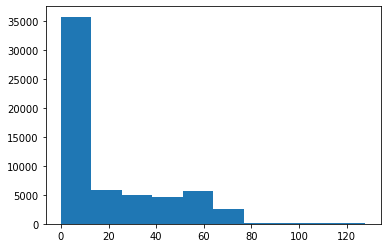

time: 312 ms


In [87]:
plt.hist(full_not_inprox_dist)

(array([1735.,  610.,  479.,  371.,  415.,  185.,   39.,   40.,   26.,
          30.]),
 array([9.75826574e-02, 1.29253618e+01, 2.57531409e+01, 3.85809201e+01,
        5.14086992e+01, 6.42364784e+01, 7.70642575e+01, 8.98920367e+01,
        1.02719816e+02, 1.15547595e+02, 1.28375374e+02]),
 <a list of 10 Patch objects>)

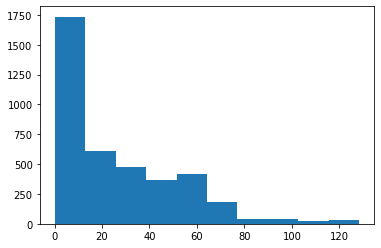

time: 248 ms


In [88]:
plt.hist(full_inprox_dist)

In [11]:
start = "2018-06-04 08:00:00"
end = "2018-06-04 15:00:00"


data_acc_e1 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = distance_calc(data_acc_e1, start, end, wifi_20m, 0.7, "double_values_0", 20, "30s")
inprox_1, not_in_prox_1 = distance_calc(data_acc_e1, start, end, wifi_20m, 0.7, "double_values_1", 20, "30s")
inprox_2, not_in_prox_2 = distance_calc(data_acc_e1, start, end, wifi_20m, 0.7, "double_values_2", 20, "30s")

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event1-20m20m.parquet.snappy")


Data sufficient for devices :{9, 19, 24, 27, 29, 31, 38, 50, 51, 56, 59, 62, 63, 65, 71, 83, 85, 92, 95, 97, 101, 102, 117, 119, 125}
1/21
2/21
3/21
4/21
5/21
6/21
7/21
8/21
9/21
10/21
11/21
12/21
13/21
14/21
15/21
16/21
17/21
18/21
19/21
20/21
21/21
Data sufficient for devices :{9, 19, 24, 27, 29, 31, 38, 50, 51, 56, 59, 62, 63, 65, 71, 83, 85, 92, 95, 97, 101, 102, 117, 119, 125}
1/21
2/21
3/21
4/21
5/21
6/21
7/21
8/21
9/21
10/21
11/21
12/21
13/21
14/21
15/21
16/21
17/21
18/21
19/21
20/21
21/21
Data sufficient for devices :{9, 19, 24, 27, 29, 31, 38, 50, 51, 56, 59, 62, 63, 65, 71, 83, 85, 92, 95, 97, 101, 102, 117, 119, 125}
1/21
2/21
3/21
4/21
5/21
6/21
7/21
8/21
9/21
10/21
11/21
12/21
13/21
14/21
15/21
16/21
17/21
18/21
19/21
20/21
21/21
time: 11min 58s


In [4]:
wifi_20m

Unnamed: 0 groups
0              0     []
1              1     []
2              2     []
3              3     []
4              4     []
...          ...    ...
7960        7960     []
7961        7961     []
7962        7962     []
7963        7963     []
7964        7964     []

[7965 rows x 2 columns]

time: 29.4 ms


In [12]:
start = "2018-05-16 09:00:00"
end = "2018-05-16 15:00:00"

data_acc_e2 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = distance_calc(data_acc_e2, start, end, wifi_20m, 0.7, "double_values_0", 20, "30s")
inprox_1, not_in_prox_1 = distance_calc(data_acc_e2, start, end, wifi_20m, 0.7, "double_values_1", 20, "30s")
inprox_2, not_in_prox_2 = distance_calc(data_acc_e2, start, end, wifi_20m, 0.7, "double_values_2", 20, "30s")

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event2-20m20m.parquet.snappy")

Data sufficient for devices :{8, 9, 11, 12, 22, 32, 34, 41, 48, 50, 51, 57, 59, 63, 65, 68, 83, 84, 85, 92, 93, 94, 95, 99, 100, 108, 117, 121}
1/18
2/18
3/18
4/18
5/18
6/18
7/18
8/18
9/18
10/18
11/18
12/18
13/18
14/18
15/18
16/18
17/18
18/18
Data sufficient for devices :{8, 9, 11, 12, 22, 32, 34, 41, 48, 50, 51, 57, 59, 63, 65, 68, 83, 84, 85, 92, 93, 94, 95, 99, 100, 108, 117, 121}
1/18
2/18
3/18
4/18
5/18
6/18
7/18
8/18
9/18
10/18
11/18
12/18
13/18
14/18
15/18
16/18
17/18
18/18
Data sufficient for devices :{8, 9, 11, 12, 22, 32, 34, 41, 48, 50, 51, 57, 59, 63, 65, 68, 83, 84, 85, 92, 93, 94, 95, 99, 100, 108, 117, 121}
1/18
2/18
3/18
4/18
5/18
6/18
7/18
8/18
9/18
10/18
11/18
12/18
13/18
14/18
15/18
16/18
17/18
18/18
time: 30min 24s


In [13]:
start = "2018-05-30 09:00:00"
end = "2018-05-30 16:00:00"

data_acc_e3 = data_acc[(data_acc['timestamp'] >= start) & (data_acc['timestamp'] <= end)]
inprox_0, not_in_prox_0 = distance_calc(data_acc_e3, start, end, wifi_20m, 0.7, "double_values_0", 20, "30s")
inprox_1, not_in_prox_1 = distance_calc(data_acc_e3, start, end, wifi_20m, 0.7, "double_values_1", 20, "30s")
inprox_2, not_in_prox_2 = distance_calc(data_acc_e3, start, end, wifi_20m, 0.7, "double_values_2", 20, "30s")

dist_df = pd.DataFrame()
dist_df['inprox_0'] = inprox_0
dist_df['not_inprox_0'] = not_in_prox_0
dist_df['inprox_1'] = inprox_1
dist_df['not_inprox_1'] = not_in_prox_1
dist_df['inprox_2'] = inprox_2
dist_df['not_inprox_2'] = not_in_prox_2
dist_df.to_parquet("/data/event3-20m20m.parquet.snappy")

Data sufficient for devices :{3, 9, 10, 12, 15, 19, 24, 32, 38, 43, 50, 51, 59, 62, 63, 65, 71, 75, 83, 85, 92, 95, 97, 102, 117, 119, 125}
1/21
2/21
3/21
4/21
5/21
6/21
7/21
8/21
9/21
10/21
11/21
12/21
13/21
14/21
15/21
16/21
17/21
18/21
19/21
20/21
21/21
Data sufficient for devices :{3, 9, 10, 12, 15, 19, 24, 32, 38, 43, 50, 51, 59, 62, 63, 65, 71, 75, 83, 85, 92, 95, 97, 102, 117, 119, 125}
1/21
2/21
3/21
4/21
5/21
6/21
7/21
8/21
9/21
10/21
11/21
12/21
13/21
14/21
15/21
16/21
17/21
18/21
19/21
20/21
21/21
Data sufficient for devices :{3, 9, 10, 12, 15, 19, 24, 32, 38, 43, 50, 51, 59, 62, 63, 65, 71, 75, 83, 85, 92, 95, 97, 102, 117, 119, 125}
1/21
2/21
3/21
4/21
5/21
6/21
7/21
8/21
9/21
10/21
11/21
12/21
13/21
14/21
15/21
16/21
17/21
18/21
19/21
20/21
21/21
time: 13min 38s


time: 34.5 ms


In [16]:
len(pd.date_range(start, end, freq="20min"))

22

time: 8.77 ms


In [23]:
start = "2018-06-04 08:00:00"
end = "2018-06-04 15:00:00"


event1_wifi = wifi_[(wifi_20m['timestamp'] >= start) & (wifi_20m['timestamp'] <= end)]

time: 7.29 ms


21

time: 5.2 ms


time: 32.1 ms


### DTW Distance Stats ###

#### Mixed Devices ####

In [4]:
event1 = pd.read_parquet("/data/event1.parquet.snappy")
event2 = pd.read_parquet("/data/event2.parquet.snappy")
event3 = pd.read_parquet("/data/event3.parquet.snappy")
event4 = pd.read_parquet("/data/event4.parquet.snappy")
event5 = pd.read_parquet("/data/event5.parquet.snappy")
event6 = pd.read_parquet("/data/event6.parquet.snappy")

start = "2018-06-04 08:00:00"
end = "2018-06-04 15:00:00"


event1_wifi = wifi_proximity[(wifi_proximity['timestamp'] >= start) & (wifi_proximity['timestamp'] <= end)]

event1['timestamp'] = list(event1_wifi['timestamp'])
event1['groups'] = list(event1_wifi['groups'])


start = "2018-05-16 09:00:00"
end = "2018-05-16 15:00:00"

event2_wifi = wifi_proximity[(wifi_proximity['timestamp'] >= start) & (wifi_proximity['timestamp'] <= end)]
event2['timestamp'] = list(event2_wifi['timestamp'])
event2['groups'] = list(event2_wifi['groups'])

start = "2018-05-30 09:00:00"
end = "2018-05-30 16:00:00"
event3_wifi = wifi_proximity[(wifi_proximity['timestamp'] >= start) & (wifi_proximity['timestamp'] <= end)]
event3['timestamp'] = list(event3_wifi['timestamp'])
event3['groups'] = list(event3_wifi['groups'])

start = "2018-06-04 08:00:00"
end = "2018-06-04 15:00:00"
event4_wifi = wifi_proximity[(wifi_proximity['timestamp'] >= start) & (wifi_proximity['timestamp'] <= end)]
event4['timestamp'] = list(event4_wifi['timestamp'])
event4['groups'] = list(event4_wifi['groups'])

start = "2018-06-11 07:30:00"
end = "2018-06-11 16:00:00"
event5_wifi = wifi_proximity[(wifi_proximity['timestamp'] >= start) & (wifi_proximity['timestamp'] <= end)]
event5['timestamp'] = list(event5_wifi['timestamp'])
event5['groups'] = list(event5_wifi['groups'])

start = "2018-06-18 07:00:00"
end = "2018-06-18 17:00:00"
event6_wifi = wifi_proximity[(wifi_proximity['timestamp'] >= start) & (wifi_proximity['timestamp'] <= end)]
event6['timestamp'] = list(event6_wifi['timestamp'])
event6['groups'] = list(event6_wifi['groups'])


time: 110 ms


In [7]:
event1_dist0 = valid_groups_dist(event1, 'inprox_0', 0.8)
event1_dist1 = valid_groups_dist(event1, 'inprox_1', 0.8)
event1_dist2 = valid_groups_dist(event1, 'inprox_2', 0.8)
event1_dist0np = valid_groups_dist(event1, 'not_inprox_0', 0.8)
event1_dist1np = valid_groups_dist(event1, 'not_inprox_1', 0.8)
event1_dist2np = valid_groups_dist(event1, 'not_inprox_2', 0.8)

event2_dist0 = valid_groups_dist(event2, 'inprox_0', 0.8)
event2_dist1 = valid_groups_dist(event2, 'inprox_1', 0.8)
event2_dist2 = valid_groups_dist(event2, 'inprox_2', 0.8)
event2_dist0np = valid_groups_dist(event2, 'not_inprox_0', 0.8)
event2_dist1np = valid_groups_dist(event2, 'not_inprox_1', 0.8)
event2_dist2np = valid_groups_dist(event2, 'not_inprox_2', 0.8)


event3_dist0 = valid_groups_dist(event3, 'inprox_0', 0.8)
event3_dist1 = valid_groups_dist(event3, 'inprox_1', 0.8)
event3_dist2 = valid_groups_dist(event3, 'inprox_2', 0.8)
event3_dist0np = valid_groups_dist(event3, 'not_inprox_0', 0.8)
event3_dist1np = valid_groups_dist(event3, 'not_inprox_1', 0.8)
event3_dist2np = valid_groups_dist(event3, 'not_inprox_2', 0.8)

event4_dist0 = valid_groups_dist(event4, 'inprox_0', 0.8)
event4_dist1 = valid_groups_dist(event4, 'inprox_1', 0.8)
event4_dist2 = valid_groups_dist(event4, 'inprox_2', 0.8)
event4_dist0np = valid_groups_dist(event4, 'not_inprox_0', 0.8)
event4_dist1np = valid_groups_dist(event4, 'not_inprox_1', 0.8)
event4_dist2np = valid_groups_dist(event4, 'not_inprox_2', 0.8)

event5_dist0 = valid_groups_dist(event5, 'inprox_0', 0.8)
event5_dist1 = valid_groups_dist(event5, 'inprox_1', 0.8)
event5_dist2 = valid_groups_dist(event5, 'inprox_2', 0.8)
event5_dist0np = valid_groups_dist(event5, 'not_inprox_0', 0.8)
event5_dist1np = valid_groups_dist(event5, 'not_inprox_1', 0.8)
event5_dist2np = valid_groups_dist(event5, 'not_inprox_2', 0.8)


event6_dist0 = valid_groups_dist(event6, 'inprox_0', 0.8)
event6_dist1 = valid_groups_dist(event6, 'inprox_1', 0.8)
event6_dist2 = valid_groups_dist(event6, 'inprox_2', 0.8)
event6_dist0np = valid_groups_dist(event6, 'not_inprox_0', 0.8)
event6_dist1np = valid_groups_dist(event6, 'not_inprox_1', 0.8)
event6_dist2np = valid_groups_dist(event6, 'not_inprox_2', 0.8)

time: 310 ms


In [8]:
combined_avg_inprox = np.nanmean(flatten_list(event1_dist0['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2['dist'].apply(fun_nanmean)) + flatten_list(event4_dist0['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2['dist'].apply(fun_nanmean)) + flatten_list(event5_dist0['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2['dist'].apply(fun_nanmean)) + flatten_list(event6_dist0['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2['dist'].apply(fun_nanmean)))
combined_avg_np = np.nanmean(flatten_list(event1_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2np['dist'].apply(fun_nanmean)))
combined_avg_var_p = np.nanmean(flatten_list(event1_dist0['dist'].apply(fun_nanvar)) + flatten_list(event1_dist1['dist'].apply(fun_nanvar)) + flatten_list(event1_dist2['dist'].apply(fun_nanvar)) + flatten_list(event2_dist0['dist'].apply(fun_nanvar)) + flatten_list(event2_dist1['dist'].apply(fun_nanvar)) + flatten_list(event2_dist2['dist'].apply(fun_nanvar)) + flatten_list(event3_dist0['dist'].apply(fun_nanvar)) + flatten_list(event3_dist1['dist'].apply(fun_nanvar)) + flatten_list(event3_dist2['dist'].apply(fun_nanvar)) + flatten_list(event4_dist0['dist'].apply(fun_nanvar)) + flatten_list(event4_dist1['dist'].apply(fun_nanvar)) + flatten_list(event4_dist2['dist'].apply(fun_nanvar)) + flatten_list(event5_dist0['dist'].apply(fun_nanvar)) + flatten_list(event5_dist1['dist'].apply(fun_nanvar)) + flatten_list(event5_dist2['dist'].apply(fun_nanvar)) + flatten_list(event6_dist0['dist'].apply(fun_nanvar)) + flatten_list(event6_dist1['dist'].apply(fun_nanvar)) + flatten_list(event6_dist2['dist'].apply(fun_nanvar)))
combined_avg_var_np = np.nanmean(flatten_list(event1_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event1_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event1_dist2np['dist'].apply(fun_nanvar)) + flatten_list(event2_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event2_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event2_dist2np['dist'].apply(fun_nanvar)) + flatten_list(event3_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event3_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event3_dist2np['dist'].apply(fun_nanvar)) + flatten_list(event4_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event4_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event4_dist2np['dist'].apply(fun_nanvar)) + flatten_list(event5_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event5_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event5_dist2np['dist'].apply(fun_nanvar)) + flatten_list(event6_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event6_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event6_dist2np['dist'].apply(fun_nanvar)))


/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: Degrees of freedom <= 0 for slice.


time: 926 ms


In [10]:
total_groups = event1_dist0['dist'].shape[0] + event2_dist0['dist'].shape[0] + event3_dist0['dist'].shape[0] + event4_dist0['dist'].shape[0] + event5_dist0['dist'].shape[0] + event6_dist0['dist'].shape[0]
print("------ All events combined ------")
print("Inprox vs out of prox mean:"+str((combined_avg_inprox, combined_avg_np)))
print("Inprox vs out of prox var:"+str((combined_avg_var_p, combined_avg_var_np)))
print(str(total_groups) + " groups analyzed")

print("\n------ Event Wise ------")
print("------ Event 1 ------")


inprox = np.nanmean(flatten_list(event1_dist0['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event1_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event1_dist0['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event1_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2np['dist'].apply(fun_nanmean)))
total_groups = event1_dist0.shape[0]
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")



print("\n------ Event 2 ------")

inprox = np.nanmean(flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)))
total_groups = event2_dist0.shape[0]
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")




print("\n------ Event 3 ------")

inprox = np.nanmean(flatten_list(event3_dist0['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event3_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event3_dist0['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event3_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2np['dist'].apply(fun_nanmean)))
total_groups = event3_dist0.shape[0]
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")


print("\n------ Event 4 ------")

inprox = np.nanmean(flatten_list(event4_dist0['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event4_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event4_dist0['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event4_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2np['dist'].apply(fun_nanmean)))
total_groups = event4_dist0.shape[0]
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")


print("\n------ Event 5 ------")

inprox = np.nanmean(flatten_list(event5_dist0['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event5_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event5_dist0['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event5_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2np['dist'].apply(fun_nanmean)))
total_groups = event5_dist0.shape[0]
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")



print("\n------ Event 6 ------")

inprox = np.nanmean(flatten_list(event6_dist0['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event6_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event6_dist0['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event6_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2np['dist'].apply(fun_nanmean)))
total_groups = event6_dist0.shape[0]
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")


------ All events combined ------
Inprox vs out of prox mean:(19.54331905878855, 16.229195915220394)
Inprox vs out of prox var:(236.15336082138725, 315.2111604877742)
247 groups analyzed

------ Event Wise ------
------ Event 1 ------
Inprox vs out of prox mean:(18.613924197664467, 18.13391142224905)
Inprox vs out of prox var:(281.4358979057996, 155.58103362892254)
34 groups analyzed

------ Event 2 ------
Inprox vs out of prox mean:(34.21063557303512, 28.62827566103116)
Inprox vs out of prox var:(244.74611923690028, 112.80990255849066)
33 groups analyzed

------ Event 3 ------


/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice


Inprox vs out of prox mean:(11.441399049947004, 10.190530623243228)
Inprox vs out of prox var:(240.17034765895178, 86.03175779729652)
36 groups analyzed

------ Event 4 ------
Inprox vs out of prox mean:(18.613924197664467, 18.13391142224905)
Inprox vs out of prox var:(281.4358979057996, 155.58103362892254)
34 groups analyzed

------ Event 5 ------
Inprox vs out of prox mean:(20.61053062590914, 16.032141099466934)
Inprox vs out of prox var:(300.3463117328672, 104.59165916244751)
47 groups analyzed

------ Event 6 ------
Inprox vs out of prox mean:(18.703780979666877, 13.258402233314161)
Inprox vs out of prox var:(447.4043191052425, 218.4691270445158)
63 groups analyzed
time: 630 ms


In [16]:
total_groups = event1_dist0['dist'].shape[0] + event2_dist0['dist'].shape[0] + event3_dist0['dist'].shape[0] + event4_dist0['dist'].shape[0] + event5_dist0['dist'].shape[0] + event6_dist0['dist'].shape[0]

print("\n------ Signal Wise ------")
print("------ Signal 0 ------")


inprox = np.nanmean(flatten_list(event1_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0['dist'].apply(fun_nanmean)) + flatten_list(event4_dist0['dist'].apply(fun_nanmean)) + flatten_list(event5_dist0['dist'].apply(fun_nanmean)) + flatten_list(event6_dist0['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event1_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist0np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event1_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0['dist'].apply(fun_nanmean)) + flatten_list(event4_dist0['dist'].apply(fun_nanmean)) + flatten_list(event5_dist0['dist'].apply(fun_nanmean)) + flatten_list(event6_dist0['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event1_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist0np['dist'].apply(fun_nanmean)))
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")



print("\n------ Signal 1 ------")

inprox = np.nanmean(flatten_list(event1_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event1_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event1_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event1_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1np['dist'].apply(fun_nanmean)))
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")




print("\n------ Signal 2 ------")

inprox = np.nanmean(flatten_list(event1_dist2['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event1_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event1_dist2['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event1_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2np['dist'].apply(fun_nanmean)))
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")





------ Signal Wise ------
------ Signal 0 ------
Inprox vs out of prox mean:(5.202431819071218, 5.950929097553276)
Inprox vs out of prox var:(50.20451146310822, 53.21226093142611)
223 groups analyzed

------ Signal 1 ------


/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice


Inprox vs out of prox mean:(8.721182602902756, 6.288443192847953)
Inprox vs out of prox var:(86.316507820903, 31.432826189127987)
223 groups analyzed

------ Signal 2 ------
Inprox vs out of prox mean:(32.143005211700896, 23.755353946329468)
Inprox vs out of prox var:(411.91525539971263, 173.53492291654513)
223 groups analyzed
time: 472 ms


#### Iphone 6 ####

In [15]:
event1 = pd.read_parquet("/data/event1_dtw_iphone6.parquet.snappy")
event2 = pd.read_parquet("/data/event2_dtw_iphone6.parquet.snappy")
event3 = pd.read_parquet("/data/event3_dtw_iphone6.parquet.snappy")

start = "2018-05-23 11:30:00"
end = "2018-05-23 15:00:00"


event1_wifi = wifi_proximity[(wifi_proximity['timestamp'] >= start) & (wifi_proximity['timestamp'] <= end)]

event1['timestamp'] = list(event1_wifi['timestamp'])
event1['groups'] = list(event1_wifi['groups'])


start = "2018-05-28 07:00:00"
end = "2018-05-28 15:00:00"

event2_wifi = wifi_proximity[(wifi_proximity['timestamp'] >= start) & (wifi_proximity['timestamp'] <= end)]
event2['timestamp'] = list(event2_wifi['timestamp'])
event2['groups'] = list(event2_wifi['groups'])

start = "2018-06-11 13:00:00"
end = "2018-06-11 17:00:00"
event3_wifi = wifi_proximity[(wifi_proximity['timestamp'] >= start) & (wifi_proximity['timestamp'] <= end)]
event3['timestamp'] = list(event3_wifi['timestamp'])
event3['groups'] = list(event3_wifi['groups'])



event1_dist0 = valid_groups_dist(event1, 'inprox_0', 0.8)
event1_dist1 = valid_groups_dist(event1, 'inprox_1', 0.8)
event1_dist2 = valid_groups_dist(event1, 'inprox_2', 0.8)
event1_dist0np = valid_groups_dist(event1, 'not_inprox_0', 0.8)
event1_dist1np = valid_groups_dist(event1, 'not_inprox_1', 0.8)
event1_dist2np = valid_groups_dist(event1, 'not_inprox_2', 0.8)

event2_dist0 = valid_groups_dist(event2, 'inprox_0', 0.8)
event2_dist1 = valid_groups_dist(event2, 'inprox_1', 0.8)
event2_dist2 = valid_groups_dist(event2, 'inprox_2', 0.8)
event2_dist0np = valid_groups_dist(event2, 'not_inprox_0', 0.8)
event2_dist1np = valid_groups_dist(event2, 'not_inprox_1', 0.8)
event2_dist2np = valid_groups_dist(event2, 'not_inprox_2', 0.8)


event3_dist0 = valid_groups_dist(event3, 'inprox_0', 0.8)
event3_dist1 = valid_groups_dist(event3, 'inprox_1', 0.8)
event3_dist2 = valid_groups_dist(event3, 'inprox_2', 0.8)
event3_dist0np = valid_groups_dist(event3, 'not_inprox_0', 0.8)
event3_dist1np = valid_groups_dist(event3, 'not_inprox_1', 0.8)
event3_dist2np = valid_groups_dist(event3, 'not_inprox_2', 0.8)


combined_avg_inprox = np.nanmean(flatten_list(event1_dist0['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2['dist'].apply(fun_nanmean)) + flatten_list(event4_dist0['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2['dist'].apply(fun_nanmean)) + flatten_list(event5_dist0['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2['dist'].apply(fun_nanmean)) + flatten_list(event6_dist0['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2['dist'].apply(fun_nanmean)))
combined_avg_np = np.nanmean(flatten_list(event1_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2np['dist'].apply(fun_nanmean)))
combined_avg_var_p = np.nanmean(flatten_list(event1_dist0['dist'].apply(fun_nanvar)) + flatten_list(event1_dist1['dist'].apply(fun_nanvar)) + flatten_list(event1_dist2['dist'].apply(fun_nanvar)) + flatten_list(event2_dist0['dist'].apply(fun_nanvar)) + flatten_list(event2_dist1['dist'].apply(fun_nanvar)) + flatten_list(event2_dist2['dist'].apply(fun_nanvar)) + flatten_list(event3_dist0['dist'].apply(fun_nanvar)) + flatten_list(event3_dist1['dist'].apply(fun_nanvar)) + flatten_list(event3_dist2['dist'].apply(fun_nanvar)) + flatten_list(event4_dist0['dist'].apply(fun_nanvar)) + flatten_list(event4_dist1['dist'].apply(fun_nanvar)) + flatten_list(event4_dist2['dist'].apply(fun_nanvar)) + flatten_list(event5_dist0['dist'].apply(fun_nanvar)) + flatten_list(event5_dist1['dist'].apply(fun_nanvar)) + flatten_list(event5_dist2['dist'].apply(fun_nanvar)) + flatten_list(event6_dist0['dist'].apply(fun_nanvar)) + flatten_list(event6_dist1['dist'].apply(fun_nanvar)) + flatten_list(event6_dist2['dist'].apply(fun_nanvar)))
combined_avg_var_np = np.nanmean(flatten_list(event1_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event1_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event1_dist2np['dist'].apply(fun_nanvar)) + flatten_list(event2_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event2_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event2_dist2np['dist'].apply(fun_nanvar)) + flatten_list(event3_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event3_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event3_dist2np['dist'].apply(fun_nanvar)) + flatten_list(event4_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event4_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event4_dist2np['dist'].apply(fun_nanvar)) + flatten_list(event5_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event5_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event5_dist2np['dist'].apply(fun_nanvar)) + flatten_list(event6_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event6_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event6_dist2np['dist'].apply(fun_nanvar)))


total_groups = event1_dist0['dist'].shape[0] + event2_dist0['dist'].shape[0] + event3_dist0['dist'].shape[0] + event4_dist0['dist'].shape[0] + event5_dist0['dist'].shape[0] + event6_dist0['dist'].shape[0]
print("------ All events combined ------")
print("Inprox vs out of prox mean:"+str((combined_avg_inprox, combined_avg_np)))
print("Inprox vs out of prox var:"+str((combined_avg_var_p, combined_avg_var_np)))
print(str(total_groups) + " groups analyzed")

print("\n------ Event Wise ------")
print("------ Event 1 ------")


inprox = np.nanmean(flatten_list(event1_dist0['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event1_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event1_dist0['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event1_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2np['dist'].apply(fun_nanmean)))
total_groups = event1_dist0.shape[0]
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")



print("\n------ Event 2 ------")

inprox = np.nanmean(flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)))
total_groups = event2_dist0.shape[0]
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")




print("\n------ Event 3 ------")

inprox = np.nanmean(flatten_list(event3_dist0['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event3_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event3_dist0['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event3_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2np['dist'].apply(fun_nanmean)))
total_groups = event3_dist0.shape[0]
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")




total_groups = event1_dist0['dist'].shape[0] + event2_dist0['dist'].shape[0] + event3_dist0['dist'].shape[0]

print("\n------ Signal Wise ------")
print("------ Signal 0 ------")


inprox = np.nanmean(flatten_list(event1_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event1_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event1_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event1_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0np['dist'].apply(fun_nanmean)))
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")



print("\n------ Signal 1 ------")

inprox = np.nanmean(flatten_list(event1_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event1_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event1_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event1_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1np['dist'].apply(fun_nanmean)))
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")




print("\n------ Signal 2 ------")

inprox = np.nanmean(flatten_list(event1_dist2['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event1_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event1_dist2['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event1_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2np['dist'].apply(fun_nanmean)))
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")




/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: Degrees of freedom <= 0 for slice.


------ All events combined ------
Inprox vs out of prox mean:(15.355539877891623, 11.998242078910232)
Inprox vs out of prox var:(169.5967995991255, 232.51093247967842)
223 groups analyzed

------ Event Wise ------
------ Event 1 ------
Inprox vs out of prox mean:(4.3563178176808774, 3.8771383230118923)
Inprox vs out of prox var:(5.699982935914733, 2.1828522099285075)
11 groups analyzed

------ Event 2 ------
Inprox vs out of prox mean:(4.0152294398709065, 3.527181760693436)
Inprox vs out of prox var:(6.221128235408132, 1.897874749582835)
45 groups analyzed

------ Event 3 ------
Inprox vs out of prox mean:(3.7275030033139593, 3.2267598232560655)
Inprox vs out of prox var:(1.6187629158779286, 0.8469902299280311)
23 groups analyzed

------ Signal Wise ------
------ Signal 0 ------
Inprox vs out of prox mean:(4.5089617749739705, 2.7233640828498547)
Inprox vs out of prox var:(7.607197366310966, 0.7178209906246641)
79 groups analyzed

------ Signal 1 ------
Inprox vs out of prox mean:(2.951

#### Android Phones with same sensor ####

In [121]:
event2 = pd.read_parquet("/data/event2_dtw_android.parquet.snappy")

start = "2018-05-16 07:00:00"
end = "2018-05-16 15:00:00"
event2_wifi = wifi_proximity[(wifi_proximity['timestamp'] >= start) & (wifi_proximity['timestamp'] <= end)]
event2['timestamp'] = list(event2_wifi['timestamp'])
event2['groups'] = list(event2_wifi['groups'])

event2_dist0 = valid_groups_dist(event2, 'inprox_0', 0.8, all_android)
event2_dist1 = valid_groups_dist(event2, 'inprox_1', 0.8, all_android)
event2_dist2 = valid_groups_dist(event2, 'inprox_2', 0.8, all_android)
event2_dist0np = valid_groups_dist(event2, 'not_inprox_0', 0.8, all_android)
event2_dist1np = valid_groups_dist(event2, 'not_inprox_1', 0.8, all_android)
event2_dist2np = valid_groups_dist(event2, 'not_inprox_2', 0.8, all_android)


time: 56.1 ms


In [125]:
total_groups = event2_dist0['dist'].shape[0]

print("------ Event Wise ------")

print("\n------ Event 2 ------")

inprox = np.nanmean(flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)))
total_groups = event2_dist0.shape[0]
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")





print("\n------ Signal Wise ------")
print("------ Signal 0 ------")


inprox = np.nanmean(flatten_list(event2_dist0['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event2_dist0np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event2_dist0['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event2_dist0np['dist'].apply(fun_nanmean)))
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")



print("\n------ Signal 1 ------")

inprox = np.nanmean(flatten_list(event2_dist1['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event2_dist1np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event2_dist1['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event2_dist1np['dist'].apply(fun_nanmean)))
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")




print("\n------ Signal 2 ------")

inprox = np.nanmean(flatten_list(event2_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event2_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event2_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event2_dist2np['dist'].apply(fun_nanmean)))
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")





------ Event Wise ------

------ Event 2 ------
Inprox vs out of prox mean:(35.559874538560074, 38.34233438186797)
Inprox vs out of prox var:(198.601845226296, 275.2485120862156)
10 groups analyzed

------ Signal Wise ------
------ Signal 0 ------
Inprox vs out of prox mean:(22.687401607010866, 31.644636837760654)
Inprox vs out of prox var:(32.943133530610865, 203.71899577770517)
10 groups analyzed

------ Signal 1 ------
Inprox vs out of prox mean:(39.12425555490672, 33.377394879285404)
Inprox vs out of prox var:(165.68584334855797, 172.58993316965194)
10 groups analyzed

------ Signal 2 ------
Inprox vs out of prox mean:(44.867966453762634, 50.00497142855786)
Inprox vs out of prox var:(132.1306122947005, 243.90972777182017)
10 groups analyzed
time: 149 ms


/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice


### Cosine Distance ###

#### Mixed ####

In [131]:
event1 = pd.read_parquet("/data/event1_cosine.parquet.snappy")
event2 = pd.read_parquet("/data/event2_cosine.parquet.snappy")
event3 = pd.read_parquet("/data/event3_cosine.parquet.snappy")
event4 = pd.read_parquet("/data/event4_cosine.parquet.snappy")
event5 = pd.read_parquet("/data/event5_cosine.parquet.snappy")
event6 = pd.read_parquet("/data/event6_cosine.parquet.snappy")

start = "2018-06-04 08:00:00"
end = "2018-06-04 15:00:00"


event1_wifi = wifi_proximity[(wifi_proximity['timestamp'] >= start) & (wifi_proximity['timestamp'] <= end)]

event1['timestamp'] = list(event1_wifi['timestamp'])
event1['groups'] = list(event1_wifi['groups'])


start = "2018-05-16 09:00:00"
end = "2018-05-16 15:00:00"

event2_wifi = wifi_proximity[(wifi_proximity['timestamp'] >= start) & (wifi_proximity['timestamp'] <= end)]
event2['timestamp'] = list(event2_wifi['timestamp'])
event2['groups'] = list(event2_wifi['groups'])

start = "2018-05-30 09:00:00"
end = "2018-05-30 16:00:00"
event3_wifi = wifi_proximity[(wifi_proximity['timestamp'] >= start) & (wifi_proximity['timestamp'] <= end)]
event3['timestamp'] = list(event3_wifi['timestamp'])
event3['groups'] = list(event3_wifi['groups'])

start = "2018-06-04 08:00:00"
end = "2018-06-04 15:00:00"
event4_wifi = wifi_proximity[(wifi_proximity['timestamp'] >= start) & (wifi_proximity['timestamp'] <= end)]
event4['timestamp'] = list(event4_wifi['timestamp'])
event4['groups'] = list(event4_wifi['groups'])

start = "2018-06-11 07:30:00"
end = "2018-06-11 16:00:00"
event5_wifi = wifi_proximity[(wifi_proximity['timestamp'] >= start) & (wifi_proximity['timestamp'] <= end)]
event5['timestamp'] = list(event5_wifi['timestamp'])
event5['groups'] = list(event5_wifi['groups'])

start = "2018-06-18 07:00:00"
end = "2018-06-18 17:00:00"
event6_wifi = wifi_proximity[(wifi_proximity['timestamp'] >= start) & (wifi_proximity['timestamp'] <= end)]
event6['timestamp'] = list(event6_wifi['timestamp'])
event6['groups'] = list(event6_wifi['groups'])


event1_dist0 = valid_groups_dist(event1, 'inprox_0', 0.8)
event1_dist1 = valid_groups_dist(event1, 'inprox_1', 0.8)
event1_dist2 = valid_groups_dist(event1, 'inprox_2', 0.8)
event1_dist0np = valid_groups_dist(event1, 'not_inprox_0', 0.8)
event1_dist1np = valid_groups_dist(event1, 'not_inprox_1', 0.8)
event1_dist2np = valid_groups_dist(event1, 'not_inprox_2', 0.8)

event2_dist0 = valid_groups_dist(event2, 'inprox_0', 0.8)
event2_dist1 = valid_groups_dist(event2, 'inprox_1', 0.8)
event2_dist2 = valid_groups_dist(event2, 'inprox_2', 0.8)
event2_dist0np = valid_groups_dist(event2, 'not_inprox_0', 0.8)
event2_dist1np = valid_groups_dist(event2, 'not_inprox_1', 0.8)
event2_dist2np = valid_groups_dist(event2, 'not_inprox_2', 0.8)


event3_dist0 = valid_groups_dist(event3, 'inprox_0', 0.8)
event3_dist1 = valid_groups_dist(event3, 'inprox_1', 0.8)
event3_dist2 = valid_groups_dist(event3, 'inprox_2', 0.8)
event3_dist0np = valid_groups_dist(event3, 'not_inprox_0', 0.8)
event3_dist1np = valid_groups_dist(event3, 'not_inprox_1', 0.8)
event3_dist2np = valid_groups_dist(event3, 'not_inprox_2', 0.8)

event4_dist0 = valid_groups_dist(event4, 'inprox_0', 0.8)
event4_dist1 = valid_groups_dist(event4, 'inprox_1', 0.8)
event4_dist2 = valid_groups_dist(event4, 'inprox_2', 0.8)
event4_dist0np = valid_groups_dist(event4, 'not_inprox_0', 0.8)
event4_dist1np = valid_groups_dist(event4, 'not_inprox_1', 0.8)
event4_dist2np = valid_groups_dist(event4, 'not_inprox_2', 0.8)

event5_dist0 = valid_groups_dist(event5, 'inprox_0', 0.8)
event5_dist1 = valid_groups_dist(event5, 'inprox_1', 0.8)
event5_dist2 = valid_groups_dist(event5, 'inprox_2', 0.8)
event5_dist0np = valid_groups_dist(event5, 'not_inprox_0', 0.8)
event5_dist1np = valid_groups_dist(event5, 'not_inprox_1', 0.8)
event5_dist2np = valid_groups_dist(event5, 'not_inprox_2', 0.8)


event6_dist0 = valid_groups_dist(event6, 'inprox_0', 0.8)
event6_dist1 = valid_groups_dist(event6, 'inprox_1', 0.8)
event6_dist2 = valid_groups_dist(event6, 'inprox_2', 0.8)
event6_dist0np = valid_groups_dist(event6, 'not_inprox_0', 0.8)
event6_dist1np = valid_groups_dist(event6, 'not_inprox_1', 0.8)
event6_dist2np = valid_groups_dist(event6, 'not_inprox_2', 0.8)

combined_avg_inprox = np.nanmean(flatten_list(event1_dist0['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2['dist'].apply(fun_nanmean)) + flatten_list(event4_dist0['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2['dist'].apply(fun_nanmean)) + flatten_list(event5_dist0['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2['dist'].apply(fun_nanmean)) + flatten_list(event6_dist0['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2['dist'].apply(fun_nanmean)))
combined_avg_np = np.nanmean(flatten_list(event1_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2np['dist'].apply(fun_nanmean)))
combined_avg_var_p = np.nanmean(flatten_list(event1_dist0['dist'].apply(fun_nanvar)) + flatten_list(event1_dist1['dist'].apply(fun_nanvar)) + flatten_list(event1_dist2['dist'].apply(fun_nanvar)) + flatten_list(event2_dist0['dist'].apply(fun_nanvar)) + flatten_list(event2_dist1['dist'].apply(fun_nanvar)) + flatten_list(event2_dist2['dist'].apply(fun_nanvar)) + flatten_list(event3_dist0['dist'].apply(fun_nanvar)) + flatten_list(event3_dist1['dist'].apply(fun_nanvar)) + flatten_list(event3_dist2['dist'].apply(fun_nanvar)) + flatten_list(event4_dist0['dist'].apply(fun_nanvar)) + flatten_list(event4_dist1['dist'].apply(fun_nanvar)) + flatten_list(event4_dist2['dist'].apply(fun_nanvar)) + flatten_list(event5_dist0['dist'].apply(fun_nanvar)) + flatten_list(event5_dist1['dist'].apply(fun_nanvar)) + flatten_list(event5_dist2['dist'].apply(fun_nanvar)) + flatten_list(event6_dist0['dist'].apply(fun_nanvar)) + flatten_list(event6_dist1['dist'].apply(fun_nanvar)) + flatten_list(event6_dist2['dist'].apply(fun_nanvar)))
combined_avg_var_np = np.nanmean(flatten_list(event1_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event1_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event1_dist2np['dist'].apply(fun_nanvar)) + flatten_list(event2_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event2_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event2_dist2np['dist'].apply(fun_nanvar)) + flatten_list(event3_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event3_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event3_dist2np['dist'].apply(fun_nanvar)) + flatten_list(event4_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event4_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event4_dist2np['dist'].apply(fun_nanvar)) + flatten_list(event5_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event5_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event5_dist2np['dist'].apply(fun_nanvar)) + flatten_list(event6_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event6_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event6_dist2np['dist'].apply(fun_nanvar)))


total_groups = event1_dist0['dist'].shape[0] + event2_dist0['dist'].shape[0] + event3_dist0['dist'].shape[0] + event4_dist0['dist'].shape[0] + event5_dist0['dist'].shape[0] + event6_dist0['dist'].shape[0]
print("------ All events combined ------")
print("Inprox vs out of prox mean:"+str((combined_avg_inprox, combined_avg_np)))
print("Inprox vs out of prox var:"+str((combined_avg_var_p, combined_avg_var_np)))
print(str(total_groups) + " groups analyzed")

print("\n------ Event Wise ------")
print("------ Event 1 ------")


inprox = np.nanmean(flatten_list(event1_dist0['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event1_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event1_dist0['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event1_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2np['dist'].apply(fun_nanmean)))
total_groups = event1_dist0.shape[0]
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")



print("\n------ Event 2 ------")

inprox = np.nanmean(flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)))
total_groups = event2_dist0.shape[0]
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")




print("\n------ Event 3 ------")

inprox = np.nanmean(flatten_list(event3_dist0['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event3_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event3_dist0['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event3_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2np['dist'].apply(fun_nanmean)))
total_groups = event3_dist0.shape[0]
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")


print("\n------ Event 4 ------")

inprox = np.nanmean(flatten_list(event4_dist0['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event4_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event4_dist0['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event4_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2np['dist'].apply(fun_nanmean)))
total_groups = event4_dist0.shape[0]
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")


print("\n------ Event 5 ------")

inprox = np.nanmean(flatten_list(event5_dist0['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event5_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event5_dist0['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event5_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2np['dist'].apply(fun_nanmean)))
total_groups = event5_dist0.shape[0]
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")



print("\n------ Event 6 ------")

inprox = np.nanmean(flatten_list(event6_dist0['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event6_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event6_dist0['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event6_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2np['dist'].apply(fun_nanmean)))
total_groups = event6_dist0.shape[0]
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")


total_groups = event1_dist0['dist'].shape[0] + event2_dist0['dist'].shape[0] + event3_dist0['dist'].shape[0] + event4_dist0['dist'].shape[0] + event5_dist0['dist'].shape[0] + event6_dist0['dist'].shape[0]

print("\n------ Signal Wise ------")
print("------ Signal 0 ------")


inprox = np.nanmean(flatten_list(event1_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0['dist'].apply(fun_nanmean)) + flatten_list(event4_dist0['dist'].apply(fun_nanmean)) + flatten_list(event5_dist0['dist'].apply(fun_nanmean)) + flatten_list(event6_dist0['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event1_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist0np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event1_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0['dist'].apply(fun_nanmean)) + flatten_list(event4_dist0['dist'].apply(fun_nanmean)) + flatten_list(event5_dist0['dist'].apply(fun_nanmean)) + flatten_list(event6_dist0['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event1_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist0np['dist'].apply(fun_nanmean)))
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")



print("\n------ Signal 1 ------")

inprox = np.nanmean(flatten_list(event1_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event1_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event1_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event1_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1np['dist'].apply(fun_nanmean)))
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")




print("\n------ Signal 2 ------")

inprox = np.nanmean(flatten_list(event1_dist2['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event1_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event1_dist2['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event1_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2np['dist'].apply(fun_nanmean)))
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")




/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: Degrees of freedom <= 0 for slice.


------ All events combined ------
Inprox vs out of prox mean:(0.3328507814726181, 0.31457519050477917)
Inprox vs out of prox var:(0.0214105592429095, 0.038152806818499634)
247 groups analyzed

------ Event Wise ------
------ Event 1 ------
Inprox vs out of prox mean:(0.31288739278288746, 0.3062003910049919)
Inprox vs out of prox var:(0.023475443511492118, 0.008393877588877077)
34 groups analyzed

------ Event 2 ------
Inprox vs out of prox mean:(0.3017209784119721, 0.3243568434121114)
Inprox vs out of prox var:(0.011798287656958378, 0.004467839018861865)
33 groups analyzed

------ Event 3 ------
Inprox vs out of prox mean:(0.32566605325511144, 0.33464507169488455)
Inprox vs out of prox var:(0.02963123696665744, 0.007527474858556437)
36 groups analyzed

------ Event 4 ------
Inprox vs out of prox mean:(0.31288739278288746, 0.3062003910049919)
Inprox vs out of prox var:(0.023475443511492118, 0.008393877588877077)
34 groups analyzed

------ Event 5 ------
Inprox vs out of prox mean:(0.351

#### Android Phones####

In [132]:
event2 = pd.read_parquet("/data/event2_cosine_android.parquet.snappy")

start = "2018-05-16 07:00:00"
end = "2018-05-16 15:00:00"
event2_wifi = wifi_proximity[(wifi_proximity['timestamp'] >= start) & (wifi_proximity['timestamp'] <= end)]
event2['timestamp'] = list(event2_wifi['timestamp'])
event2['groups'] = list(event2_wifi['groups'])

event2_dist0 = valid_groups_dist(event2, 'inprox_0', 0.8, all_android)
event2_dist1 = valid_groups_dist(event2, 'inprox_1', 0.8, all_android)
event2_dist2 = valid_groups_dist(event2, 'inprox_2', 0.8, all_android)
event2_dist0np = valid_groups_dist(event2, 'not_inprox_0', 0.8, all_android)
event2_dist1np = valid_groups_dist(event2, 'not_inprox_1', 0.8, all_android)
event2_dist2np = valid_groups_dist(event2, 'not_inprox_2', 0.8, all_android)




total_groups = event2_dist0['dist'].shape[0]

print("------ Event Wise ------")

print("\n------ Event 2 ------")

inprox = np.nanmean(flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)))
total_groups = event2_dist0.shape[0]
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")





print("\n------ Signal Wise ------")
print("------ Signal 0 ------")


inprox = np.nanmean(flatten_list(event2_dist0['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event2_dist0np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event2_dist0['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event2_dist0np['dist'].apply(fun_nanmean)))
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")



print("\n------ Signal 1 ------")

inprox = np.nanmean(flatten_list(event2_dist1['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event2_dist1np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event2_dist1['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event2_dist1np['dist'].apply(fun_nanmean)))
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")




print("\n------ Signal 2 ------")

inprox = np.nanmean(flatten_list(event2_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event2_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event2_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event2_dist2np['dist'].apply(fun_nanmean)))
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")





------ Event Wise ------

------ Event 2 ------
Inprox vs out of prox mean:(0.3093388774508946, 0.3145127858697334)
Inprox vs out of prox var:(0.03552368576528597, 0.02994604711250241)
10 groups analyzed

------ Signal Wise ------
------ Signal 0 ------
Inprox vs out of prox mean:(0.23149406001043252, 0.25184453902507414)
Inprox vs out of prox var:(0.0123214953353361, 0.018194428395169042)
10 groups analyzed

------ Signal 1 ------
Inprox vs out of prox mean:(0.4893412651671157, 0.4236758911438193)
Inprox vs out of prox var:(0.026166806440443096, 0.03404717867638068)
10 groups analyzed

------ Signal 2 ------
Inprox vs out of prox mean:(0.2071813071751357, 0.26801792744030667)
Inprox vs out of prox var:(0.019185911169552466, 0.019590869689920767)
10 groups analyzed
time: 273 ms


/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice


#### Iphone 6 ####

In [149]:
event1 = pd.read_parquet("/data/event1_cosine_iphone6.parquet.snappy")
event2 = pd.read_parquet("/data/event2_cosine_iphone6.parquet.snappy")
event3 = pd.read_parquet("/data/event3_cosine_iphone6.parquet.snappy")

start = "2018-05-23 11:30:00"
end = "2018-05-23 15:00:00"


event1_wifi = wifi_proximity[(wifi_proximity['timestamp'] >= start) & (wifi_proximity['timestamp'] <= end)]

event1['timestamp'] = list(event1_wifi['timestamp'])
event1['groups'] = list(event1_wifi['groups'])


start = "2018-05-28 07:00:00"
end = "2018-05-28 15:00:00"

event2_wifi = wifi_proximity[(wifi_proximity['timestamp'] >= start) & (wifi_proximity['timestamp'] <= end)]
event2['timestamp'] = list(event2_wifi['timestamp'])
event2['groups'] = list(event2_wifi['groups'])

start = "2018-06-11 13:00:00"
end = "2018-06-11 17:00:00"
event3_wifi = wifi_proximity[(wifi_proximity['timestamp'] >= start) & (wifi_proximity['timestamp'] <= end)]
event3['timestamp'] = list(event3_wifi['timestamp'])
event3['groups'] = list(event3_wifi['groups'])



event1_dist0 = valid_groups_dist(event1, 'inprox_0', 0.8)
event1_dist1 = valid_groups_dist(event1, 'inprox_1', 0.8)
event1_dist2 = valid_groups_dist(event1, 'inprox_2', 0.8)
event1_dist0np = valid_groups_dist(event1, 'not_inprox_0', 0.8)
event1_dist1np = valid_groups_dist(event1, 'not_inprox_1', 0.8)
event1_dist2np = valid_groups_dist(event1, 'not_inprox_2', 0.8)

event2_dist0 = valid_groups_dist(event2, 'inprox_0', 0.8)
event2_dist1 = valid_groups_dist(event2, 'inprox_1', 0.8)
event2_dist2 = valid_groups_dist(event2, 'inprox_2', 0.8)
event2_dist0np = valid_groups_dist(event2, 'not_inprox_0', 0.8)
event2_dist1np = valid_groups_dist(event2, 'not_inprox_1', 0.8)
event2_dist2np = valid_groups_dist(event2, 'not_inprox_2', 0.8)


event3_dist0 = valid_groups_dist(event3, 'inprox_0', 0.8)
event3_dist1 = valid_groups_dist(event3, 'inprox_1', 0.8)
event3_dist2 = valid_groups_dist(event3, 'inprox_2', 0.8)
event3_dist0np = valid_groups_dist(event3, 'not_inprox_0', 0.8)
event3_dist1np = valid_groups_dist(event3, 'not_inprox_1', 0.8)
event3_dist2np = valid_groups_dist(event3, 'not_inprox_2', 0.8)


combined_avg_inprox = np.nanmean(flatten_list(event1_dist0['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2['dist'].apply(fun_nanmean)) + flatten_list(event4_dist0['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2['dist'].apply(fun_nanmean)) + flatten_list(event5_dist0['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2['dist'].apply(fun_nanmean)) + flatten_list(event6_dist0['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2['dist'].apply(fun_nanmean)))
combined_avg_np = np.nanmean(flatten_list(event1_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event4_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event5_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event6_dist2np['dist'].apply(fun_nanmean)))
combined_avg_var_p = np.nanmean(flatten_list(event1_dist0['dist'].apply(fun_nanvar)) + flatten_list(event1_dist1['dist'].apply(fun_nanvar)) + flatten_list(event1_dist2['dist'].apply(fun_nanvar)) + flatten_list(event2_dist0['dist'].apply(fun_nanvar)) + flatten_list(event2_dist1['dist'].apply(fun_nanvar)) + flatten_list(event2_dist2['dist'].apply(fun_nanvar)) + flatten_list(event3_dist0['dist'].apply(fun_nanvar)) + flatten_list(event3_dist1['dist'].apply(fun_nanvar)) + flatten_list(event3_dist2['dist'].apply(fun_nanvar)) + flatten_list(event4_dist0['dist'].apply(fun_nanvar)) + flatten_list(event4_dist1['dist'].apply(fun_nanvar)) + flatten_list(event4_dist2['dist'].apply(fun_nanvar)) + flatten_list(event5_dist0['dist'].apply(fun_nanvar)) + flatten_list(event5_dist1['dist'].apply(fun_nanvar)) + flatten_list(event5_dist2['dist'].apply(fun_nanvar)) + flatten_list(event6_dist0['dist'].apply(fun_nanvar)) + flatten_list(event6_dist1['dist'].apply(fun_nanvar)) + flatten_list(event6_dist2['dist'].apply(fun_nanvar)))
combined_avg_var_np = np.nanmean(flatten_list(event1_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event1_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event1_dist2np['dist'].apply(fun_nanvar)) + flatten_list(event2_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event2_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event2_dist2np['dist'].apply(fun_nanvar)) + flatten_list(event3_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event3_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event3_dist2np['dist'].apply(fun_nanvar)) + flatten_list(event4_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event4_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event4_dist2np['dist'].apply(fun_nanvar)) + flatten_list(event5_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event5_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event5_dist2np['dist'].apply(fun_nanvar)) + flatten_list(event6_dist0np['dist'].apply(fun_nanvar)) + flatten_list(event6_dist1np['dist'].apply(fun_nanvar)) + flatten_list(event6_dist2np['dist'].apply(fun_nanvar)))


total_groups = event1_dist0['dist'].shape[0] + event2_dist0['dist'].shape[0] + event3_dist0['dist'].shape[0] + event4_dist0['dist'].shape[0] + event5_dist0['dist'].shape[0] + event6_dist0['dist'].shape[0]
print("------ All events combined ------")
print("Inprox vs out of prox mean:"+str((combined_avg_inprox, combined_avg_np)))
print("Inprox vs out of prox var:"+str((combined_avg_var_p, combined_avg_var_np)))
print(str(total_groups) + " groups analyzed")

print("\n------ Event Wise ------")
print("------ Event 1 ------")


inprox = np.nanmean(flatten_list(event1_dist0['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event1_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event1_dist0['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event1_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event1_dist2np['dist'].apply(fun_nanmean)))
total_groups = event1_dist0.shape[0]
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")



print("\n------ Event 2 ------")

inprox = np.nanmean(flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)))
total_groups = event2_dist0.shape[0]
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")




print("\n------ Event 3 ------")

inprox = np.nanmean(flatten_list(event3_dist0['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event3_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event3_dist0['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event3_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2np['dist'].apply(fun_nanmean)))
total_groups = event3_dist0.shape[0]
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")




total_groups = event1_dist0['dist'].shape[0] + event2_dist0['dist'].shape[0] + event3_dist0['dist'].shape[0]

print("\n------ Signal Wise ------")
print("------ Signal 0 ------")


inprox = np.nanmean(flatten_list(event1_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event1_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event1_dist0['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event1_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist0np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist0np['dist'].apply(fun_nanmean)))
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")



print("\n------ Signal 1 ------")

inprox = np.nanmean(flatten_list(event1_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event1_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event1_dist1['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event1_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist1np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist1np['dist'].apply(fun_nanmean)))
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")




print("\n------ Signal 2 ------")

inprox = np.nanmean(flatten_list(event1_dist2['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2['dist'].apply(fun_nanmean)))
not_inprox = np.nanmean(flatten_list(event1_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2np['dist'].apply(fun_nanmean)))
inprox_var = np.nanvar(flatten_list(event1_dist2['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2['dist'].apply(fun_nanmean)))
not_inprox_var = np.nanvar(flatten_list(event1_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event2_dist2np['dist'].apply(fun_nanmean)) + flatten_list(event3_dist2np['dist'].apply(fun_nanmean)))
print("Inprox vs out of prox mean:"+str((inprox, not_inprox)))
print("Inprox vs out of prox var:"+str((inprox_var, not_inprox_var)))
print(str(total_groups) + " groups analyzed")






/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/u/home/oturkar/venv/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: Degrees of freedom <= 0 for slice.


------ All events combined ------
Inprox vs out of prox mean:(0.33790955286795066, 0.3128451939928143)
Inprox vs out of prox var:(0.017674668901387615, 0.0351217329918822)
223 groups analyzed

------ Event Wise ------
------ Event 1 ------
Inprox vs out of prox mean:(0.2915500276985966, 0.29741898336912526)
Inprox vs out of prox var:(0.041741990279280376, 0.009923868506614164)
11 groups analyzed

------ Event 2 ------
Inprox vs out of prox mean:(0.3186553623442899, 0.3227739586764119)
Inprox vs out of prox var:(0.03294330892180337, 0.018772198015170122)
45 groups analyzed

------ Event 3 ------
Inprox vs out of prox mean:(0.3424094796254204, 0.32267769768590765)
Inprox vs out of prox var:(0.04715934380464903, 0.01328939198869449)
23 groups analyzed

------ Signal Wise ------
------ Signal 0 ------
Inprox vs out of prox mean:(0.3527195670678295, 0.29093557921195595)
Inprox vs out of prox var:(0.04032345661584906, 0.011631726590296348)
79 groups analyzed

------ Signal 1 ------
Inprox vs